# 永續課程分類

執行方式:
- 基本上就是直接跑過整個檔案
- 要確定有 "課程SDG分類_20220610-v2.xlsx" 以及 "embedding_tensor.pt" 這兩個檔案，以及正確的 config 路徑設定
  (若是要重新計算所有文本的 Embedding，那就把 In [26] 的註解拿掉，這樣就不需要先有 "embedding_tensor.pt" 這個檔案也可以跑)

---

程式碼區塊提醒:

In [6] : 可以修改任務相關的 Config 設定 (e.g. 超參數、檔案路徑)

In [26]: 用來計算文本的 Embedding (如果有做新的前處理的話，就要把這個 Cell 的註解拿掉，重新跑一次計算 Embedding)

---

可能ㄉ優化方向:
- 額外前處理
- 調整文本的切割方式
- 更換 PLM
- 調整下游模型架構 or 超參數
- 調整類別權重
- 針對 SDG 各類別之間的關係建模 (大概看了一下發現有些類別好像很常一起出現)

---

目前問題:
- 目前是用 Validation Data 拿來當作 Test Data 評估最終結果，但似乎有失公正性
- 目前的評估方法不確定是否正確

## 載入套件

In [2]:
!nvidia-smi

Unable to determine the device handle for GPU 0000:01:00.0: Unknown Error


In [3]:
import gc
import math
import random
import statistics
from tqdm import tqdm

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-kc9lpsz2 because the default path (/home/emma/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset 

from transformers import BertTokenizerFast, AutoModel
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split, KFold

In [6]:
pd.options.mode.chained_assignment = None

In [7]:
# config
config = {
    "file_path": "課程SDG分類_20220610-v2.xlsx",
    "embedding_path": "embedding_tensor.pt",
#     "model_path": 'model.ckpt',
#     "val_size": 0.3,
    "seed": 42,
    "max_chunk_size": 128,  # 一個 Chunk 的字數上限
    "max_chunk_num": 30,    # 一筆資料的 Chunk 數量上限 
    "learning_rate": 3e-4,  
    "batch_size": 64,
    "epochs": 130,
#     "patience": 20,
}

In [8]:
# fix random seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [9]:
set_seed(config["seed"])

## 文本前處理

In [10]:
# 讀取資料
df_dirty = pd.read_excel(config["file_path"], engine='openpyxl')
print(df_dirty.shape)

######################## 移除 Rows ########################
# 移除整列都是空值的資料
df_dirty = df_dirty.dropna(axis=0, how='all')
print(df_dirty.shape)

# 移除服務學習、碩博士論文、專題研究
drop_values = ["服務學習", "專題研究", "碩士論文", "博士論文", "書報討論", "專題討論"]
for drop_value in drop_values:
    df_dirty = df_dirty[~df_dirty["課名"].str.contains(drop_value)]
print(df_dirty.shape)

# 移除課程資訊包含 "待補" 的課程
df_dirty = df_dirty[df_dirty["課程大綱課程概述"] != "待補"]
df_dirty = df_dirty[df_dirty["課程目標"] != "待補"]
print(df_dirty.shape)

######################## 移除 Cols ########################
# 移除不需要的欄位
drop_list = ["學年度-學期", "dpt_code", "學院", "系所", "班次", "tea_code", "授課教師", "課程要求"]
df_dirty = df_dirty.drop(drop_list, axis=1)

# 重設索引並查看資料表
df_clean = df_dirty.reset_index(drop=True)
df_clean.head(1)

(4257, 29)
(1502, 29)
(1289, 29)
(1182, 29)


,課程代號,課名,課程大綱課程概述,課程目標,SDG1,SDG2,SDG3,SDG4,SDG5,SDG6,...,SDG8,SDG9,SDG10,SDG11,SDG12,SDG13,SDG14,SDG15,SDG16,SDG17
0,801 18000,公共衛生學,公共衛生為一科際整合的科學，其範疇橫跨流行病學、生物統計、社區醫學與預防保健、環境衛生、職業...,修完此課程，期望同學將能夠：\n\n1.瞭解公共衛生的基本概念與重要內涵。\n\n2.瞭解台...,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# 加入合併欄位後的新欄位 Context
df_clean["context"] = df_clean.apply(lambda row: f"課名：{row.課名}$$$大綱：{row.課程大綱課程概述}$$$目標：{row.課程目標}", axis=1)

# 去除換行符號
df_clean["context"] = df_clean["context"].apply(lambda x: x.replace("\n", ""))

In [12]:
# Context 範例
df_clean["context"][0]

'課名：公共衛生學$$$大綱：公共衛生為一科際整合的科學，其範疇橫跨流行病學、生物統計、社區醫學與預防保健、環境衛生、職業醫學、工業衛生、衛生政策、醫療管理、健康行為與衛生教育等層面。本課程的目的在於提供學習者對於公共衛生的一個鳥瞰圖，由宏觀的觀點切入，認識何謂公共衛生、公共衛生所涵括的內容、以及我國公共衛生的過去、現在及未來發展趨勢。$$$目標：修完此課程，期望同學將能夠：1.瞭解公共衛生的基本概念與重要內涵。2.瞭解台灣公共衛生的成就與面臨的挑戰。3.體會如何以基本公共衛生觀點來分析社會上發生的健康相關事件。'

In [13]:
def ChunkS(text, chunk_size):
    chunk_char = ["$$$", "一、", "二、", "三、", "四、", "五、", "六、", "(一)", "(二)", "(三)", "(四)", "(五)", "(六)", "1.", "2.", "3.", "4.", "5.", "6.", "。", "！", "？", "，", "、", "_", "END"]  # 自己加字符
    if len(text) <= chunk_size:
        return f'{text.strip()}'
    for cchar in chunk_char:
        cchar_len = len(cchar)
        i = text.rfind(cchar, 0, chunk_size)
        if i == -1:
            if cchar != "END":
                continue
            return f'{text[:chunk_size].strip()}<CHUNK>{ChunkS(text[chunk_size+1:], chunk_size)}'
        # 不同長度的切割字元，要給不同的切分位置
        if cchar_len == 1:  # 單個符號保留在前句(ex. 。)
            return f'{text[:i+1].strip()}<CHUNK>{ChunkS(text[i+1:], chunk_size)}'
        else:  # 多個符號保留在後句(ex. 1.)
            return f'{text[:i].strip()}<CHUNK>{cchar+ChunkS(text[i+cchar_len:], chunk_size)}'

def short_sentence(text, chunk_size):
    '''Chunking long document to multi short sentences, base on "。", "！", "？", "，" etc.'''
    return ChunkS(text, chunk_size).split("<CHUNK>")

In [14]:
# 將 Context 切分成多個短子句 Context chunk
df_clean["context_chunk"] = df_clean["context"].apply(short_sentence, chunk_size=config["max_chunk_size"])
# 移除分隔符號 ($$$)
df_clean["context_chunk"] = df_clean["context_chunk"].apply(lambda x: [c.strip("$$$") for c in x])
df_clean["context_chunk"] = df_clean["context_chunk"].apply(lambda x: [c.replace("$$$", "。") for c in x])

In [15]:
# Context Chunk 範例
for chunk in df_clean.loc[0, "context_chunk"]:
    print(chunk + "\n------------")

課名：公共衛生學
------------
大綱：公共衛生為一科際整合的科學，其範疇橫跨流行病學、生物統計、社區醫學與預防保健、環境衛生、職業醫學、工業衛生、衛生政策、醫療管理、健康行為與衛生教育等層面。
------------
本課程的目的在於提供學習者對於公共衛生的一個鳥瞰圖，由宏觀的觀點切入，認識何謂公共衛生、公共衛生所涵括的內容、以及我國公共衛生的過去、現在及未來發展趨勢。
------------
目標：修完此課程，期望同學將能夠：1.瞭解公共衛生的基本概念與重要內涵。2.瞭解台灣公共衛生的成就與面臨的挑戰。3.體會如何以基本公共衛生觀點來分析社會上發生的健康相關事件。
------------


In [16]:
# 查看最終擁有的欄位
print(df_clean.columns.to_list())

['課程代號', '課名', '課程大綱課程概述', '課程目標', 'SDG1', 'SDG2', 'SDG3', 'SDG4', 'SDG5', 'SDG6', 'SDG7', 'SDG8', 'SDG9', 'SDG10', 'SDG11', 'SDG12', 'SDG13', 'SDG14', 'SDG15', 'SDG16', 'SDG17', 'context', 'context_chunk']


課程大綱課程概述
Max count: 5573
Median count: 192.0
Quantiles count: [ 98. 432.]


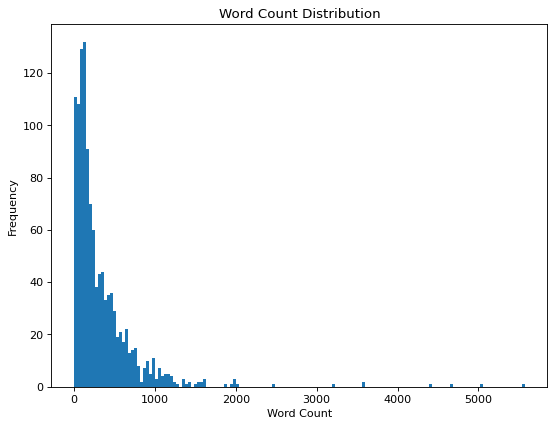

課程目標
Max count: 1722
Median count: 87.0
Quantiles count: [ 40.   179.75]


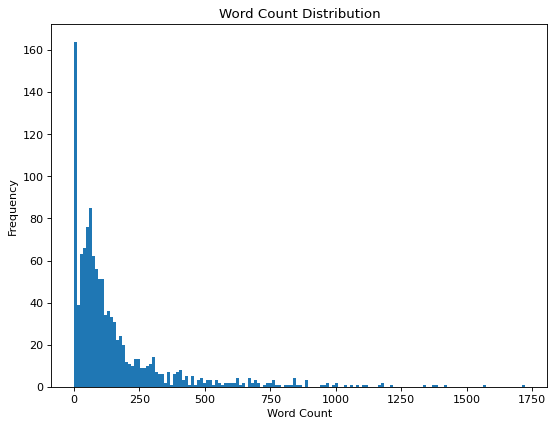

context
Max count: 5423
Median count: 349.5
Quantiles count: [198.25 623.5 ]


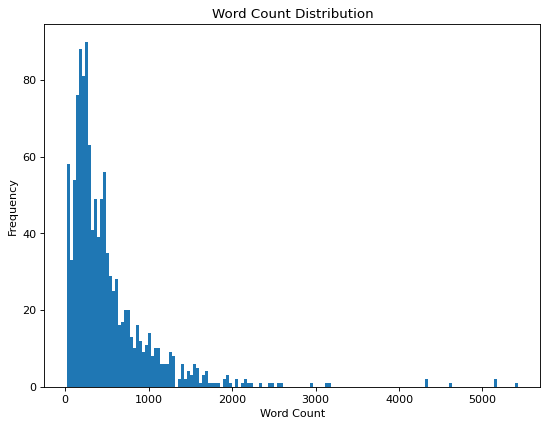

In [17]:
# 觀察重要欄位的字數分佈
column_list = ['課程大綱課程概述', '課程目標', "context"]
for col in column_list:  
    word_counts = [len(each) if type(each) == str else 0 for each in df_clean[col]]
    print(col)
    max_count = max(word_counts)
    median_count = statistics.median(word_counts)
    quantiles_count = np.quantile(word_counts, q = np.arange(0.25, 1, 0.5))
    print(f"Max count: {max_count}")
    print(f"Median count: {median_count}")
    print(f"Quantiles count: {quantiles_count}")
    plt.figure(figsize=(8, 6), dpi=80)
    n, bins, patches = plt.hist(word_counts, bins=150)
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.title(f"Word Count Distribution")
    plt.show()

Max count: 56
Mean count: 6


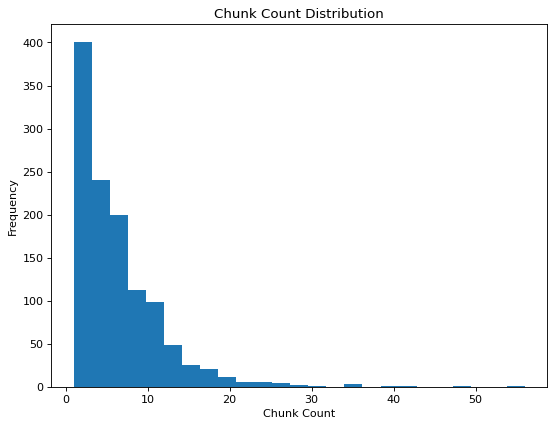

In [18]:
# 觀察短子句數量分佈
chunk_count = [len(context_chunk) for context_chunk in df_clean["context_chunk"]]
print(f"Max count: {max(chunk_count)}")
print(f"Mean count: {int(sum(chunk_count)/len(chunk_count))}")
plt.figure(figsize=(8, 6), dpi=80)
n, bins, patches = plt.hist(chunk_count, bins=25)
plt.xlabel("Chunk Count")
plt.ylabel("Frequency")
plt.title("Chunk Count Distribution")
plt.show()

## 切分訓練與驗證資料

In [19]:
# 類別標籤欄位清單 (SDG1~SDG17)
label_list = df_clean.columns[4:-2]
print(label_list)

Index(['SDG1', 'SDG2', 'SDG3', 'SDG4', 'SDG5', 'SDG6', 'SDG7', 'SDG8', 'SDG9',
       'SDG10', 'SDG11', 'SDG12', 'SDG13', 'SDG14', 'SDG15', 'SDG16', 'SDG17'],
      dtype='object')


## 載入 BERT 模型

In [20]:
device = torch.device('cuda', 0) if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [21]:
# BERT Tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')

# BERT Model
bert = AutoModel.from_pretrained('ckiplab/bert-base-chinese').to(device)

Some weights of the model checkpoint at ckiplab/bert-base-chinese were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ckiplab/bert-base-chinese and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.

## 計算 Chunk Embedding

In [22]:
# 先確保所有文章的 Chunk 數一致
context_chunk_lists = df_clean['context_chunk']
max_chunk_num = config["max_chunk_num"]
        
for i in range(len(context_chunk_lists)):
    text_len = len(context_chunk_lists[i])
    if text_len < max_chunk_num:
        tmp = [""] * (max_chunk_num - text_len)
        context_chunk_lists[i] += tmp
    else:
        context_chunk_lists[i] = context_chunk_lists[i][:max_chunk_num]

In [23]:
def get_embedding_tensor(context_chunk_lists, max_chunk_num, max_chunk_size):
    embedding_tensor = torch.ones((len(context_chunk_lists), max_chunk_num, 768))
    count = 0
    for i in range(len(context_chunk_lists)):
        context_chunk_list = context_chunk_lists[i]
        embedding = []
        for chunk in context_chunk_list:
            bert_input = tokenizer(chunk, padding='max_length', max_length=max_chunk_size,
                            truncation=True, return_tensors="pt")
            attention_mask = bert_input['attention_mask'].to(device)
            input_id = bert_input['input_ids'].squeeze(1).to(device)
            final_inputs = {'input_ids': input_id, 'attention_mask': attention_mask}
            outputs = bert(**final_inputs)
            # 因為 CLS 外面接的 Layer 存在 Random，因此每次跑出來結果會不一樣
            # pooler_output = outputs.pooler_output.reshape(768)  # torch.Size([1, 768]) -> torch.Size([768])
            # 要改成這樣寫才可以
            pooler_output = outputs.last_hidden_state[0][0].reshape(768)
            embedding.append(pooler_output)
        embedding = torch.stack(embedding).detach().cpu()  # torch.Size([n, 768])
        count += 1
        print(f"Finish: {count}/{len(context_chunk_lists)}")
        print(embedding)
        embedding_tensor[i] = embedding
        gc.collect()
        torch.cuda.empty_cache()
    return embedding_tensor

In [23]:
# # 如果要計算新的 Embedding 的話，就把這個 cell 的註解拿掉

# # 計算每個樣本各自的 BERT Embedding
# embedding_tensor = get_embedding_tensor(context_chunk_lists, config["max_chunk_num"], config["max_chunk_size"])

# # 儲存 BERT Embedding Tensor
# torch.save(embedding_tensor, config["embedding_path"])

## 載入 Chunk Embedding

In [24]:
# 載入 BERT Embedding Tensor
embedding_tensor = torch.load(config["embedding_path"])

In [25]:
print(type(embedding_tensor))
print(embedding_tensor.shape)

<class 'torch.Tensor'>
torch.Size([1182, 30, 768])


## 定義函數

In [26]:
# 函數: 計算 Class weight
def get_class_weight(df, labels):
    # 計算每個類別的「正樣本數量」，儲存成 class_pos_count 列表
    class_pos_count = np.zeros(len(labels))
    # 計算每個類別的「負樣本數量」，儲存成 class_neg_count 列表
    class_neg_count = np.zeros(len(labels))
    # 遞迴
    for i in range(len(labels)):
        label = labels[i]
        positive, negative = df[label].value_counts()[1.0], df[label].value_counts()[0.0]
        class_pos_count[i], class_neg_count[i] = positive, negative
    # 計算「正樣本權重」
    class_pos_weight = np.ones_like(class_pos_count)
    for cdx, (pos_count, neg_count) in enumerate(zip(class_pos_count, class_neg_count)):
        class_pos_weight[cdx] = math.sqrt(neg_count/(pos_count+1e-5))
    return torch.as_tensor(class_pos_weight, dtype=torch.float)

In [27]:
# 函數: 計算 Accuracy, Precision, Recall, Top-k
def _ACCscore(y_true, pred):
    accuracy_l = [ans.all() for ans in (pred == y_true)]
    accuracy = np.array(accuracy_l).mean()
    return accuracy


def _PRscore(y_true, pred):
    hit_matrix = np.zeros_like(pred)
    hit_matrix[np.where((pred == y_true) & (y_true > 0))] = 1
    tp = hit_matrix.sum(axis=1)
    pred_sum = pred.sum(axis=1)
    true_sum = y_true.sum(axis=1)
    precision_l = []
    recall_l = []
    for ix in range(tp.shape[0]):
        precision_score = (1.0 if true_sum[ix] == 0 else 0.0) if pred_sum[ix] == 0 else tp[ix]/pred_sum[ix]
        recall_score = (1.0 if pred_sum[ix] == 0 else 0.0) if true_sum[ix] == 0 else tp[ix]/true_sum[ix]
        precision_l.append(precision_score)
        recall_l.append(recall_score)
    precision = np.array(precision_l).mean()
    recall = np.array(recall_l).mean()
    return precision, recall


def _TopKscore(y_true, pred, output, k):
    topk_class = np.argsort(output, axis=1)[:,-k:]
    topk_pred = torch.zeros_like(pred)
    for i in range(pred.shape[0]):
        if pred[i, :].sum() > 0:
            topk_pred[i, topk_class[i]] = 1
    topk_precision, topk_recall = _PRscore(y_true, topk_pred)
    return topk_precision, topk_recall

In [28]:
# 函數: 一次同時計算所有評估指標
def score(y_true, pred, output, k=5):
    accuracy = _ACCscore(y_true, pred)
    precision, recall = _PRscore(y_true, pred)
    _, topk_recall = _TopKscore(y_true, pred, output, k)
    return accuracy, precision, recall, topk_recall

In [29]:
# 函數: 計算 F1-score
def f1(precision, recall):
    f1_score = (2 * precision * recall) / (precision + recall)
    return f1_score

## 類別與權重資訊

In [30]:
# Class (Pos) Weight
class_weight = get_class_weight(df_clean, label_list)

In [31]:
print("<< 目標變數與權重對應 >>\n")

print(f"<< 目標變數共有 {len(label_list)} 類 >>\n")

for c, w in zip(label_list, class_weight):
    print(f"{c}: {round(float(w), 2)}")

<< 目標變數與權重對應 >>

<< 目標變數共有 17 類 >>

SDG1: 5.99
SDG2: 5.99
SDG3: 1.64
SDG4: 1.36
SDG5: 6.67
SDG6: 5.81
SDG7: 7.1
SDG8: 1.94
SDG9: 5.9
SDG10: 4.57
SDG11: 4.18
SDG12: 4.02
SDG13: 5.99
SDG14: 5.15
SDG15: 4.62
SDG16: 5.49
SDG17: 5.81


## 訓練模型

In [32]:
class SDG_Dataset(Dataset):
    def __init__(self, df, embeddings, label_list):
        self.embeddings = embeddings
        self.labels = df[label_list].to_numpy()  # [[0,0,1], [0,1,1]...]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [33]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.lstm = nn.LSTM(768, 256, batch_first=True, bidirectional=False, dropout=0.)
        self.linear_1 = nn.Linear(256, 64)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(64, 17)

    def forward(self, embeddings):
        _, (ht, ct) = self.lstm(embeddings)
        output = self.linear_1(ht[-1])
        output = self.relu(output)
        output = self.linear_2(output)
        return output

In [45]:
def train(model, class_weight, train_index, val_index):
    # 記錄 train 訓練過程
    train_loss_list = []
    train_accuracy_list = []
    train_precision_list = []
    train_recall_list = []
    train_topk_recall_list = []
    train_f1_list = []
    
    # 記錄 validation 訓練過程
    val_loss_list = []
    val_accuracy_list = []
    val_precision_list = []
    val_recall_list = []
    val_topk_recall_list = []
    val_f1_list = []
    
    train_df, val_df = df_clean.iloc[train_index, :], df_clean.iloc[val_index, :]
    train_embedding, val_embedding = embedding_tensor[train_index, :], embedding_tensor[val_index, :]
    
    # Training and Val Dataset
    train_set = SDG_Dataset(train_df, train_embedding, label_list)
    val_set = SDG_Dataset(val_df, val_embedding, label_list)

    train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_set, batch_size=config["batch_size"], shuffle=False)

    # Loss Function
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)
    
    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=config["learning_rate"])

    # 把模型放到 GPU 上跑
    model = model.to(device)
    criterion = criterion.to(device)
    
    # 將模型設定成「訓練」狀態（Dropout等Layer才會被觸發）
    model.train()
    
    # 訓練階段
    epochs = config["epochs"]
    for epoch_num in range(epochs):
        
        # 訓練並儲存訓練結果
        loss_list = []
        accuracy_list = []
        precision_list = []
        recall_list = []
        topk_recall_list = []

        for train_embeddings, train_labels in tqdm(train_loader):
    
            optimizer.zero_grad()
            
            train_embeddings = train_embeddings.to(device)
            train_labels = train_labels.to(device)

            output = model(train_embeddings)

            batch_loss = criterion(output, train_labels.float())
            
            # Back propagation
            batch_loss.backward()
            optimizer.step()
            
            output = output.cpu().detach()
            pred = (output > 0).cpu()
            y_true = (train_labels > 0).cpu()
        
            # 計算 batch 表現並存起來
            loss = batch_loss.item()
            accuracy, precision, recall, topk_recall = score(y_true, pred, output, k=5)
            
            loss_list.append(loss)
            accuracy_list.append(accuracy)
            precision_list.append(precision)
            recall_list.append(recall)
            topk_recall_list.append(topk_recall)
        
        # 計算 EPOCH 表現並存起來
        train_loss = np.array(loss_list).mean()
        train_accuracy = np.array(accuracy_list).mean()
        train_precision = np.array(precision_list).mean()
        train_recall = np.array(recall_list).mean()
        train_topk_recall = np.array(topk_recall_list).mean()
        train_f1 = f1(train_precision, train_recall)
        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        train_precision_list.append(train_precision)
        train_recall_list.append(train_recall)
        train_topk_recall_list.append(train_topk_recall)
        train_f1_list.append(train_f1)
        
        
        # ===============================================================================
        
        # 驗證並儲存驗證結果
        loss_list = []
        accuracy_list = []
        precision_list = []
        recall_list = []
        topk_recall_list = []
        
        # 驗證當下的模型表現
        with torch.no_grad():
            for val_embeddings, val_labels in tqdm(val_loader):

                val_embeddings = val_embeddings.to(device)
                val_labels = val_labels.to(device)

                output = model(val_embeddings)
                
                batch_loss = criterion(output, val_labels.float())
                
                output = output.cpu()
                pred = (output > 0).cpu()
                y_true = (val_labels > 0).cpu()
                
                # 計算 batch 表現並存起來
                loss = batch_loss.item()
                accuracy, precision, recall, topk_recall = score(y_true, pred, output, k=5)
                
                loss_list.append(loss)
                accuracy_list.append(accuracy)
                precision_list.append(precision)
                recall_list.append(recall)
                topk_recall_list.append(topk_recall)
            
            # 計算 EPOCH 表現並存起來
            val_loss = np.array(loss_list).mean()
            val_accuracy = np.array(accuracy_list).mean()
            val_precision = np.array(precision_list).mean()
            val_recall = np.array(recall_list).mean()
            val_topk_recall = np.array(topk_recall_list).mean()
            val_f1 = f1(val_precision, val_recall)
            
            val_loss_list.append(val_loss)
            val_accuracy_list.append(val_accuracy)
            val_precision_list.append(val_precision)
            val_recall_list.append(val_recall)
            val_topk_recall_list.append(val_topk_recall)
            val_f1_list.append(val_f1)
        
        # 印出每一個 Epoch 的結果
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {train_loss: .3f} \
            | Train F1: {train_f1: .3f} \
            | Val Loss: {val_loss: .3f} \
            | Val F1: {val_f1: .3f}')
        
    return model, val_loss, val_accuracy, val_precision, val_recall, val_topk_recall, val_f1

In [55]:
best_val_accuracy = 0
best_train_index = []
best_val_index = []

In [56]:
%%time
# 10 fold
kf = KFold(n_splits=10, shuffle=True, random_state=config["seed"])
kfold_df = pd.DataFrame(columns=['Fold','val_loss', 'val_accuracy', 'val_precision', 'val_recall', 
                                 'val_topk_recall', 'val_f1'])
cnt = 1

for train_index, val_index in kf.split(df_clean):
    print("-"*50)
    print("Now Fold :",cnt, "TRAIN:", len(train_index), "Val:", len(val_index))
    
    model = Classifier()
    
    model, val_loss, val_accuracy, val_precision, val_recall, val_topk_recall, val_f1 = train(model, class_weight, train_index, val_index)
    
    kfold_df = kfold_df.append([{"Fold": cnt, "val_loss": val_loss, "val_accuracy": val_accuracy, "val_precision": val_precision, "val_recall": val_recall, "val_topk_recall": val_topk_recall, "val_f1": val_f1}])
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_train_index = train_index
        best_val_index = val_index
        torch.save(model.state_dict(), './best_10fold_model.ckpt')
    cnt += 1

--------------------------------------------------
Now Fold : 1 TRAIN: 1063 Val: 119


100%|██████████| 2/2 [00:00<00:00, 121.94it/s]


Epochs: 1 | Train Loss:  0.713             | Train F1:  0.186             | Val Loss:  0.638             | Val F1:  0.173


100%|██████████| 2/2 [00:00<00:00, 150.63it/s]


Epochs: 2 | Train Loss:  0.590             | Train F1:  0.239             | Val Loss:  0.581             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 150.24it/s]


Epochs: 3 | Train Loss:  0.561             | Train F1:  0.364             | Val Loss:  0.558             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 148.19it/s]


Epochs: 4 | Train Loss:  0.546             | Train F1:  0.366             | Val Loss:  0.549             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 150.57it/s]


Epochs: 5 | Train Loss:  0.543             | Train F1:  0.366             | Val Loss:  0.547             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 152.10it/s]


Epochs: 6 | Train Loss:  0.545             | Train F1:  0.367             | Val Loss:  0.545             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 151.53it/s]


Epochs: 7 | Train Loss:  0.547             | Train F1:  0.365             | Val Loss:  0.544             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 151.42it/s]


Epochs: 8 | Train Loss:  0.549             | Train F1:  0.364             | Val Loss:  0.545             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 152.27it/s]


Epochs: 9 | Train Loss:  0.539             | Train F1:  0.367             | Val Loss:  0.543             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 151.19it/s]


Epochs: 10 | Train Loss:  0.542             | Train F1:  0.368             | Val Loss:  0.542             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 151.29it/s]


Epochs: 11 | Train Loss:  0.540             | Train F1:  0.365             | Val Loss:  0.539             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 151.19it/s]


Epochs: 12 | Train Loss:  0.535             | Train F1:  0.367             | Val Loss:  0.538             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 152.64it/s]


Epochs: 13 | Train Loss:  0.532             | Train F1:  0.364             | Val Loss:  0.533             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 151.51it/s]


Epochs: 14 | Train Loss:  0.521             | Train F1:  0.367             | Val Loss:  0.516             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 152.35it/s]


Epochs: 15 | Train Loss:  0.501             | Train F1:  0.366             | Val Loss:  0.487             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 152.30it/s]


Epochs: 16 | Train Loss:  0.472             | Train F1:  0.367             | Val Loss:  0.491             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 152.27it/s]


Epochs: 17 | Train Loss:  0.465             | Train F1:  0.368             | Val Loss:  0.480             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 149.67it/s]


Epochs: 18 | Train Loss:  0.446             | Train F1:  0.392             | Val Loss:  0.454             | Val F1:  0.390


100%|██████████| 2/2 [00:00<00:00, 148.61it/s]


Epochs: 19 | Train Loss:  0.431             | Train F1:  0.392             | Val Loss:  0.446             | Val F1:  0.392


100%|██████████| 2/2 [00:00<00:00, 148.77it/s]


Epochs: 20 | Train Loss:  0.426             | Train F1:  0.398             | Val Loss:  0.437             | Val F1:  0.391


100%|██████████| 2/2 [00:00<00:00, 134.05it/s]


Epochs: 21 | Train Loss:  0.429             | Train F1:  0.404             | Val Loss:  0.465             | Val F1:  0.297


100%|██████████| 2/2 [00:00<00:00, 149.15it/s]


Epochs: 22 | Train Loss:  0.423             | Train F1:  0.384             | Val Loss:  0.478             | Val F1:  0.377


100%|██████████| 2/2 [00:00<00:00, 148.54it/s]


Epochs: 23 | Train Loss:  0.416             | Train F1:  0.442             | Val Loss:  0.454             | Val F1:  0.378


100%|██████████| 2/2 [00:00<00:00, 141.39it/s]


Epochs: 24 | Train Loss:  0.407             | Train F1:  0.431             | Val Loss:  0.428             | Val F1:  0.451


100%|██████████| 2/2 [00:00<00:00, 142.88it/s]


Epochs: 25 | Train Loss:  0.398             | Train F1:  0.499             | Val Loss:  0.429             | Val F1:  0.503


100%|██████████| 2/2 [00:00<00:00, 141.11it/s]


Epochs: 26 | Train Loss:  0.388             | Train F1:  0.538             | Val Loss:  0.412             | Val F1:  0.490


100%|██████████| 2/2 [00:00<00:00, 138.04it/s]


Epochs: 27 | Train Loss:  0.382             | Train F1:  0.542             | Val Loss:  0.433             | Val F1:  0.500


100%|██████████| 2/2 [00:00<00:00, 143.47it/s]


Epochs: 28 | Train Loss:  0.372             | Train F1:  0.573             | Val Loss:  0.417             | Val F1:  0.522


100%|██████████| 2/2 [00:00<00:00, 143.81it/s]


Epochs: 29 | Train Loss:  0.365             | Train F1:  0.565             | Val Loss:  0.435             | Val F1:  0.518


100%|██████████| 2/2 [00:00<00:00, 143.84it/s]


Epochs: 30 | Train Loss:  0.349             | Train F1:  0.582             | Val Loss:  0.409             | Val F1:  0.540


100%|██████████| 2/2 [00:00<00:00, 141.12it/s]


Epochs: 31 | Train Loss:  0.343             | Train F1:  0.590             | Val Loss:  0.457             | Val F1:  0.516


100%|██████████| 2/2 [00:00<00:00, 140.47it/s]


Epochs: 32 | Train Loss:  0.336             | Train F1:  0.597             | Val Loss:  0.403             | Val F1:  0.546


100%|██████████| 2/2 [00:00<00:00, 139.92it/s]


Epochs: 33 | Train Loss:  0.324             | Train F1:  0.622             | Val Loss:  0.413             | Val F1:  0.543


100%|██████████| 2/2 [00:00<00:00, 139.29it/s]


Epochs: 34 | Train Loss:  0.318             | Train F1:  0.622             | Val Loss:  0.386             | Val F1:  0.546


100%|██████████| 2/2 [00:00<00:00, 139.26it/s]


Epochs: 35 | Train Loss:  0.307             | Train F1:  0.629             | Val Loss:  0.422             | Val F1:  0.542


100%|██████████| 2/2 [00:00<00:00, 138.84it/s]


Epochs: 36 | Train Loss:  0.309             | Train F1:  0.648             | Val Loss:  0.426             | Val F1:  0.567


100%|██████████| 2/2 [00:00<00:00, 139.21it/s]


Epochs: 37 | Train Loss:  0.297             | Train F1:  0.652             | Val Loss:  0.369             | Val F1:  0.556


100%|██████████| 2/2 [00:00<00:00, 139.92it/s]


Epochs: 38 | Train Loss:  0.288             | Train F1:  0.666             | Val Loss:  0.406             | Val F1:  0.568


100%|██████████| 2/2 [00:00<00:00, 140.19it/s]


Epochs: 39 | Train Loss:  0.282             | Train F1:  0.658             | Val Loss:  0.403             | Val F1:  0.586


100%|██████████| 2/2 [00:00<00:00, 141.41it/s]


Epochs: 40 | Train Loss:  0.275             | Train F1:  0.683             | Val Loss:  0.395             | Val F1:  0.572


100%|██████████| 2/2 [00:00<00:00, 139.25it/s]


Epochs: 41 | Train Loss:  0.266             | Train F1:  0.678             | Val Loss:  0.389             | Val F1:  0.604


100%|██████████| 2/2 [00:00<00:00, 141.03it/s]


Epochs: 42 | Train Loss:  0.253             | Train F1:  0.695             | Val Loss:  0.387             | Val F1:  0.584


100%|██████████| 2/2 [00:00<00:00, 140.76it/s]


Epochs: 43 | Train Loss:  0.246             | Train F1:  0.697             | Val Loss:  0.429             | Val F1:  0.582


100%|██████████| 2/2 [00:00<00:00, 139.38it/s]


Epochs: 44 | Train Loss:  0.239             | Train F1:  0.726             | Val Loss:  0.433             | Val F1:  0.589


100%|██████████| 2/2 [00:00<00:00, 139.54it/s]


Epochs: 45 | Train Loss:  0.230             | Train F1:  0.735             | Val Loss:  0.420             | Val F1:  0.603


100%|██████████| 2/2 [00:00<00:00, 140.70it/s]


Epochs: 46 | Train Loss:  0.225             | Train F1:  0.736             | Val Loss:  0.396             | Val F1:  0.556


100%|██████████| 2/2 [00:00<00:00, 141.03it/s]


Epochs: 47 | Train Loss:  0.224             | Train F1:  0.754             | Val Loss:  0.412             | Val F1:  0.606


100%|██████████| 2/2 [00:00<00:00, 137.56it/s]


Epochs: 48 | Train Loss:  0.219             | Train F1:  0.752             | Val Loss:  0.351             | Val F1:  0.608


100%|██████████| 2/2 [00:00<00:00, 137.67it/s]


Epochs: 49 | Train Loss:  0.221             | Train F1:  0.744             | Val Loss:  0.461             | Val F1:  0.648


100%|██████████| 2/2 [00:00<00:00, 136.71it/s]


Epochs: 50 | Train Loss:  0.209             | Train F1:  0.770             | Val Loss:  0.375             | Val F1:  0.665


100%|██████████| 2/2 [00:00<00:00, 136.93it/s]


Epochs: 51 | Train Loss:  0.201             | Train F1:  0.791             | Val Loss:  0.414             | Val F1:  0.659


100%|██████████| 2/2 [00:00<00:00, 140.91it/s]


Epochs: 52 | Train Loss:  0.196             | Train F1:  0.801             | Val Loss:  0.456             | Val F1:  0.628


100%|██████████| 2/2 [00:00<00:00, 135.07it/s]


Epochs: 53 | Train Loss:  0.191             | Train F1:  0.805             | Val Loss:  0.395             | Val F1:  0.688


100%|██████████| 2/2 [00:00<00:00, 136.15it/s]


Epochs: 54 | Train Loss:  0.183             | Train F1:  0.819             | Val Loss:  0.378             | Val F1:  0.687


100%|██████████| 2/2 [00:00<00:00, 135.74it/s]


Epochs: 55 | Train Loss:  0.181             | Train F1:  0.817             | Val Loss:  0.407             | Val F1:  0.654


100%|██████████| 2/2 [00:00<00:00, 134.82it/s]


Epochs: 56 | Train Loss:  0.171             | Train F1:  0.829             | Val Loss:  0.388             | Val F1:  0.690


100%|██████████| 2/2 [00:00<00:00, 136.26it/s]


Epochs: 57 | Train Loss:  0.167             | Train F1:  0.841             | Val Loss:  0.416             | Val F1:  0.676


100%|██████████| 2/2 [00:00<00:00, 136.67it/s]


Epochs: 58 | Train Loss:  0.161             | Train F1:  0.849             | Val Loss:  0.402             | Val F1:  0.675


100%|██████████| 2/2 [00:00<00:00, 132.25it/s]


Epochs: 59 | Train Loss:  0.155             | Train F1:  0.861             | Val Loss:  0.359             | Val F1:  0.627


100%|██████████| 2/2 [00:00<00:00, 134.05it/s]


Epochs: 60 | Train Loss:  0.159             | Train F1:  0.831             | Val Loss:  0.430             | Val F1:  0.701


100%|██████████| 2/2 [00:00<00:00, 137.03it/s]


Epochs: 61 | Train Loss:  0.151             | Train F1:  0.858             | Val Loss:  0.446             | Val F1:  0.699


100%|██████████| 2/2 [00:00<00:00, 136.05it/s]


Epochs: 62 | Train Loss:  0.146             | Train F1:  0.861             | Val Loss:  0.427             | Val F1:  0.693


100%|██████████| 2/2 [00:00<00:00, 134.52it/s]


Epochs: 63 | Train Loss:  0.140             | Train F1:  0.871             | Val Loss:  0.382             | Val F1:  0.696


100%|██████████| 2/2 [00:00<00:00, 135.08it/s]


Epochs: 64 | Train Loss:  0.138             | Train F1:  0.874             | Val Loss:  0.391             | Val F1:  0.688


100%|██████████| 2/2 [00:00<00:00, 137.63it/s]


Epochs: 65 | Train Loss:  0.133             | Train F1:  0.894             | Val Loss:  0.428             | Val F1:  0.668


100%|██████████| 2/2 [00:00<00:00, 134.13it/s]


Epochs: 66 | Train Loss:  0.131             | Train F1:  0.870             | Val Loss:  0.404             | Val F1:  0.680


100%|██████████| 2/2 [00:00<00:00, 132.65it/s]


Epochs: 67 | Train Loss:  0.127             | Train F1:  0.891             | Val Loss:  0.346             | Val F1:  0.672


100%|██████████| 2/2 [00:00<00:00, 133.89it/s]


Epochs: 68 | Train Loss:  0.124             | Train F1:  0.889             | Val Loss:  0.421             | Val F1:  0.717


100%|██████████| 2/2 [00:00<00:00, 134.96it/s]


Epochs: 69 | Train Loss:  0.123             | Train F1:  0.891             | Val Loss:  0.408             | Val F1:  0.697


100%|██████████| 2/2 [00:00<00:00, 135.36it/s]


Epochs: 70 | Train Loss:  0.117             | Train F1:  0.898             | Val Loss:  0.355             | Val F1:  0.713


100%|██████████| 2/2 [00:00<00:00, 133.58it/s]


Epochs: 71 | Train Loss:  0.115             | Train F1:  0.906             | Val Loss:  0.449             | Val F1:  0.701


100%|██████████| 2/2 [00:00<00:00, 134.61it/s]


Epochs: 72 | Train Loss:  0.108             | Train F1:  0.906             | Val Loss:  0.438             | Val F1:  0.721


100%|██████████| 2/2 [00:00<00:00, 137.22it/s]


Epochs: 73 | Train Loss:  0.106             | Train F1:  0.913             | Val Loss:  0.407             | Val F1:  0.707


100%|██████████| 2/2 [00:00<00:00, 136.84it/s]


Epochs: 74 | Train Loss:  0.100             | Train F1:  0.922             | Val Loss:  0.478             | Val F1:  0.711


100%|██████████| 2/2 [00:00<00:00, 135.32it/s]


Epochs: 75 | Train Loss:  0.097             | Train F1:  0.931             | Val Loss:  0.456             | Val F1:  0.719


100%|██████████| 2/2 [00:00<00:00, 135.73it/s]


Epochs: 76 | Train Loss:  0.094             | Train F1:  0.925             | Val Loss:  0.443             | Val F1:  0.709


100%|██████████| 2/2 [00:00<00:00, 135.04it/s]


Epochs: 77 | Train Loss:  0.093             | Train F1:  0.928             | Val Loss:  0.416             | Val F1:  0.711


100%|██████████| 2/2 [00:00<00:00, 135.31it/s]


Epochs: 78 | Train Loss:  0.088             | Train F1:  0.944             | Val Loss:  0.449             | Val F1:  0.707


100%|██████████| 2/2 [00:00<00:00, 137.05it/s]


Epochs: 79 | Train Loss:  0.084             | Train F1:  0.944             | Val Loss:  0.432             | Val F1:  0.705


100%|██████████| 2/2 [00:00<00:00, 135.72it/s]


Epochs: 80 | Train Loss:  0.082             | Train F1:  0.947             | Val Loss:  0.463             | Val F1:  0.721


100%|██████████| 2/2 [00:00<00:00, 135.37it/s]


Epochs: 81 | Train Loss:  0.081             | Train F1:  0.943             | Val Loss:  0.433             | Val F1:  0.734


100%|██████████| 2/2 [00:00<00:00, 136.43it/s]


Epochs: 82 | Train Loss:  0.076             | Train F1:  0.953             | Val Loss:  0.498             | Val F1:  0.716


100%|██████████| 2/2 [00:00<00:00, 135.31it/s]


Epochs: 83 | Train Loss:  0.073             | Train F1:  0.954             | Val Loss:  0.457             | Val F1:  0.733


100%|██████████| 2/2 [00:00<00:00, 135.40it/s]


Epochs: 84 | Train Loss:  0.074             | Train F1:  0.951             | Val Loss:  0.488             | Val F1:  0.721


100%|██████████| 2/2 [00:00<00:00, 136.61it/s]


Epochs: 85 | Train Loss:  0.071             | Train F1:  0.954             | Val Loss:  0.501             | Val F1:  0.704


100%|██████████| 2/2 [00:00<00:00, 136.29it/s]


Epochs: 86 | Train Loss:  0.074             | Train F1:  0.936             | Val Loss:  0.502             | Val F1:  0.718


100%|██████████| 2/2 [00:00<00:00, 137.05it/s]


Epochs: 87 | Train Loss:  0.071             | Train F1:  0.952             | Val Loss:  0.468             | Val F1:  0.719


100%|██████████| 2/2 [00:00<00:00, 134.09it/s]


Epochs: 88 | Train Loss:  0.067             | Train F1:  0.948             | Val Loss:  0.431             | Val F1:  0.726


100%|██████████| 2/2 [00:00<00:00, 133.47it/s]


Epochs: 89 | Train Loss:  0.071             | Train F1:  0.935             | Val Loss:  0.482             | Val F1:  0.730


100%|██████████| 2/2 [00:00<00:00, 135.14it/s]


Epochs: 90 | Train Loss:  0.072             | Train F1:  0.939             | Val Loss:  0.489             | Val F1:  0.714


100%|██████████| 2/2 [00:00<00:00, 134.15it/s]


Epochs: 91 | Train Loss:  0.068             | Train F1:  0.950             | Val Loss:  0.409             | Val F1:  0.735


100%|██████████| 2/2 [00:00<00:00, 136.12it/s]


Epochs: 92 | Train Loss:  0.064             | Train F1:  0.957             | Val Loss:  0.552             | Val F1:  0.700


100%|██████████| 2/2 [00:00<00:00, 135.81it/s]


Epochs: 93 | Train Loss:  0.064             | Train F1:  0.954             | Val Loss:  0.459             | Val F1:  0.713


100%|██████████| 2/2 [00:00<00:00, 135.57it/s]


Epochs: 94 | Train Loss:  0.059             | Train F1:  0.962             | Val Loss:  0.453             | Val F1:  0.746


100%|██████████| 2/2 [00:00<00:00, 134.79it/s]


Epochs: 95 | Train Loss:  0.055             | Train F1:  0.963             | Val Loss:  0.523             | Val F1:  0.738


100%|██████████| 2/2 [00:00<00:00, 135.82it/s]


Epochs: 96 | Train Loss:  0.052             | Train F1:  0.964             | Val Loss:  0.528             | Val F1:  0.728


100%|██████████| 2/2 [00:00<00:00, 137.36it/s]


Epochs: 97 | Train Loss:  0.052             | Train F1:  0.966             | Val Loss:  0.595             | Val F1:  0.699


100%|██████████| 2/2 [00:00<00:00, 136.00it/s]


Epochs: 98 | Train Loss:  0.050             | Train F1:  0.968             | Val Loss:  0.518             | Val F1:  0.725


100%|██████████| 2/2 [00:00<00:00, 136.47it/s]


Epochs: 99 | Train Loss:  0.052             | Train F1:  0.962             | Val Loss:  0.510             | Val F1:  0.723


100%|██████████| 2/2 [00:00<00:00, 136.28it/s]


Epochs: 100 | Train Loss:  0.048             | Train F1:  0.970             | Val Loss:  0.527             | Val F1:  0.737


100%|██████████| 2/2 [00:00<00:00, 135.11it/s]


Epochs: 101 | Train Loss:  0.045             | Train F1:  0.975             | Val Loss:  0.565             | Val F1:  0.712


100%|██████████| 2/2 [00:00<00:00, 137.03it/s]


Epochs: 102 | Train Loss:  0.046             | Train F1:  0.972             | Val Loss:  0.606             | Val F1:  0.691


100%|██████████| 2/2 [00:00<00:00, 134.18it/s]


Epochs: 103 | Train Loss:  0.047             | Train F1:  0.962             | Val Loss:  0.465             | Val F1:  0.732


100%|██████████| 2/2 [00:00<00:00, 134.74it/s]


Epochs: 104 | Train Loss:  0.047             | Train F1:  0.967             | Val Loss:  0.545             | Val F1:  0.704


100%|██████████| 2/2 [00:00<00:00, 136.43it/s]


Epochs: 105 | Train Loss:  0.045             | Train F1:  0.973             | Val Loss:  0.604             | Val F1:  0.702


100%|██████████| 2/2 [00:00<00:00, 135.27it/s]


Epochs: 106 | Train Loss:  0.044             | Train F1:  0.975             | Val Loss:  0.526             | Val F1:  0.690


100%|██████████| 2/2 [00:00<00:00, 134.54it/s]


Epochs: 107 | Train Loss:  0.048             | Train F1:  0.963             | Val Loss:  0.553             | Val F1:  0.716


100%|██████████| 2/2 [00:00<00:00, 136.27it/s]


Epochs: 108 | Train Loss:  0.045             | Train F1:  0.971             | Val Loss:  0.544             | Val F1:  0.722


100%|██████████| 2/2 [00:00<00:00, 137.41it/s]


Epochs: 109 | Train Loss:  0.042             | Train F1:  0.973             | Val Loss:  0.597             | Val F1:  0.680


100%|██████████| 2/2 [00:00<00:00, 135.27it/s]


Epochs: 110 | Train Loss:  0.044             | Train F1:  0.968             | Val Loss:  0.648             | Val F1:  0.709


100%|██████████| 2/2 [00:00<00:00, 135.79it/s]


Epochs: 111 | Train Loss:  0.039             | Train F1:  0.977             | Val Loss:  0.547             | Val F1:  0.726


100%|██████████| 2/2 [00:00<00:00, 137.03it/s]


Epochs: 112 | Train Loss:  0.037             | Train F1:  0.978             | Val Loss:  0.595             | Val F1:  0.703


100%|██████████| 2/2 [00:00<00:00, 137.15it/s]


Epochs: 113 | Train Loss:  0.036             | Train F1:  0.980             | Val Loss:  0.641             | Val F1:  0.682


100%|██████████| 2/2 [00:00<00:00, 136.57it/s]


Epochs: 114 | Train Loss:  0.032             | Train F1:  0.985             | Val Loss:  0.641             | Val F1:  0.720


100%|██████████| 2/2 [00:00<00:00, 136.55it/s]


Epochs: 115 | Train Loss:  0.031             | Train F1:  0.984             | Val Loss:  0.646             | Val F1:  0.726


100%|██████████| 2/2 [00:00<00:00, 135.48it/s]


Epochs: 116 | Train Loss:  0.029             | Train F1:  0.987             | Val Loss:  0.621             | Val F1:  0.698


100%|██████████| 2/2 [00:00<00:00, 136.49it/s]


Epochs: 117 | Train Loss:  0.028             | Train F1:  0.987             | Val Loss:  0.665             | Val F1:  0.728


100%|██████████| 2/2 [00:00<00:00, 135.28it/s]


Epochs: 118 | Train Loss:  0.026             | Train F1:  0.989             | Val Loss:  0.701             | Val F1:  0.724


100%|██████████| 2/2 [00:00<00:00, 136.20it/s]


Epochs: 119 | Train Loss:  0.025             | Train F1:  0.990             | Val Loss:  0.686             | Val F1:  0.721


100%|██████████| 2/2 [00:00<00:00, 136.66it/s]


Epochs: 120 | Train Loss:  0.024             | Train F1:  0.991             | Val Loss:  0.703             | Val F1:  0.732


100%|██████████| 2/2 [00:00<00:00, 134.40it/s]


Epochs: 121 | Train Loss:  0.023             | Train F1:  0.991             | Val Loss:  0.650             | Val F1:  0.713


100%|██████████| 2/2 [00:00<00:00, 136.19it/s]


Epochs: 122 | Train Loss:  0.023             | Train F1:  0.992             | Val Loss:  0.705             | Val F1:  0.715


100%|██████████| 2/2 [00:00<00:00, 134.94it/s]


Epochs: 123 | Train Loss:  0.022             | Train F1:  0.991             | Val Loss:  0.665             | Val F1:  0.740


100%|██████████| 2/2 [00:00<00:00, 134.88it/s]


Epochs: 124 | Train Loss:  0.021             | Train F1:  0.991             | Val Loss:  0.706             | Val F1:  0.719


100%|██████████| 2/2 [00:00<00:00, 136.42it/s]


Epochs: 125 | Train Loss:  0.020             | Train F1:  0.993             | Val Loss:  0.681             | Val F1:  0.707


100%|██████████| 2/2 [00:00<00:00, 135.83it/s]


Epochs: 126 | Train Loss:  0.019             | Train F1:  0.995             | Val Loss:  0.707             | Val F1:  0.720


100%|██████████| 2/2 [00:00<00:00, 137.11it/s]


Epochs: 127 | Train Loss:  0.018             | Train F1:  0.995             | Val Loss:  0.711             | Val F1:  0.729


100%|██████████| 2/2 [00:00<00:00, 135.67it/s]


Epochs: 128 | Train Loss:  0.018             | Train F1:  0.996             | Val Loss:  0.704             | Val F1:  0.727


100%|██████████| 2/2 [00:00<00:00, 136.40it/s]


Epochs: 129 | Train Loss:  0.018             | Train F1:  0.994             | Val Loss:  0.719             | Val F1:  0.725


100%|██████████| 2/2 [00:00<00:00, 136.14it/s]


Epochs: 130 | Train Loss:  0.018             | Train F1:  0.993             | Val Loss:  0.705             | Val F1:  0.711
--------------------------------------------------
Now Fold : 2 TRAIN: 1063 Val: 119


100%|██████████| 2/2 [00:00<00:00, 122.07it/s]


Epochs: 1 | Train Loss:  0.706             | Train F1:  0.265             | Val Loss:  0.578             | Val F1:  0.220


100%|██████████| 2/2 [00:00<00:00, 122.53it/s]


Epochs: 2 | Train Loss:  0.595             | Train F1:  0.256             | Val Loss:  0.486             | Val F1:  0.220


100%|██████████| 2/2 [00:00<00:00, 149.19it/s]


Epochs: 3 | Train Loss:  0.563             | Train F1:  0.314             | Val Loss:  0.459             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 151.55it/s]


Epochs: 4 | Train Loss:  0.559             | Train F1:  0.366             | Val Loss:  0.458             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 149.67it/s]


Epochs: 5 | Train Loss:  0.556             | Train F1:  0.367             | Val Loss:  0.459             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 150.16it/s]


Epochs: 6 | Train Loss:  0.555             | Train F1:  0.366             | Val Loss:  0.460             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 148.82it/s]


Epochs: 7 | Train Loss:  0.552             | Train F1:  0.366             | Val Loss:  0.459             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 151.19it/s]


Epochs: 8 | Train Loss:  0.551             | Train F1:  0.369             | Val Loss:  0.457             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 150.66it/s]


Epochs: 9 | Train Loss:  0.551             | Train F1:  0.367             | Val Loss:  0.457             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 150.07it/s]


Epochs: 10 | Train Loss:  0.548             | Train F1:  0.366             | Val Loss:  0.456             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 150.76it/s]


Epochs: 11 | Train Loss:  0.545             | Train F1:  0.367             | Val Loss:  0.451             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 150.27it/s]


Epochs: 12 | Train Loss:  0.544             | Train F1:  0.370             | Val Loss:  0.452             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 150.96it/s]


Epochs: 13 | Train Loss:  0.535             | Train F1:  0.368             | Val Loss:  0.442             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 150.17it/s]


Epochs: 14 | Train Loss:  0.522             | Train F1:  0.368             | Val Loss:  0.427             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 151.24it/s]


Epochs: 15 | Train Loss:  0.502             | Train F1:  0.368             | Val Loss:  0.448             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 150.39it/s]


Epochs: 16 | Train Loss:  0.484             | Train F1:  0.370             | Val Loss:  0.386             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 149.13it/s]


Epochs: 17 | Train Loss:  0.457             | Train F1:  0.370             | Val Loss:  0.371             | Val F1:  0.363


100%|██████████| 2/2 [00:00<00:00, 146.70it/s]


Epochs: 18 | Train Loss:  0.449             | Train F1:  0.382             | Val Loss:  0.369             | Val F1:  0.358


100%|██████████| 2/2 [00:00<00:00, 146.22it/s]


Epochs: 19 | Train Loss:  0.435             | Train F1:  0.390             | Val Loss:  0.375             | Val F1:  0.375


100%|██████████| 2/2 [00:00<00:00, 149.56it/s]


Epochs: 20 | Train Loss:  0.443             | Train F1:  0.392             | Val Loss:  0.357             | Val F1:  0.378


100%|██████████| 2/2 [00:00<00:00, 147.47it/s]


Epochs: 21 | Train Loss:  0.429             | Train F1:  0.439             | Val Loss:  0.360             | Val F1:  0.378


100%|██████████| 2/2 [00:00<00:00, 148.00it/s]


Epochs: 22 | Train Loss:  0.424             | Train F1:  0.406             | Val Loss:  0.359             | Val F1:  0.382


100%|██████████| 2/2 [00:00<00:00, 145.11it/s]


Epochs: 23 | Train Loss:  0.417             | Train F1:  0.435             | Val Loss:  0.362             | Val F1:  0.406


100%|██████████| 2/2 [00:00<00:00, 141.48it/s]


Epochs: 24 | Train Loss:  0.413             | Train F1:  0.479             | Val Loss:  0.351             | Val F1:  0.436


100%|██████████| 2/2 [00:00<00:00, 137.90it/s]


Epochs: 25 | Train Loss:  0.412             | Train F1:  0.452             | Val Loss:  0.352             | Val F1:  0.496


100%|██████████| 2/2 [00:00<00:00, 142.17it/s]


Epochs: 26 | Train Loss:  0.407             | Train F1:  0.486             | Val Loss:  0.356             | Val F1:  0.464


100%|██████████| 2/2 [00:00<00:00, 139.67it/s]


Epochs: 27 | Train Loss:  0.399             | Train F1:  0.511             | Val Loss:  0.350             | Val F1:  0.523


100%|██████████| 2/2 [00:00<00:00, 140.17it/s]


Epochs: 28 | Train Loss:  0.391             | Train F1:  0.538             | Val Loss:  0.356             | Val F1:  0.514


100%|██████████| 2/2 [00:00<00:00, 134.73it/s]


Epochs: 29 | Train Loss:  0.394             | Train F1:  0.519             | Val Loss:  0.346             | Val F1:  0.585


100%|██████████| 2/2 [00:00<00:00, 138.63it/s]


Epochs: 30 | Train Loss:  0.386             | Train F1:  0.566             | Val Loss:  0.354             | Val F1:  0.588


100%|██████████| 2/2 [00:00<00:00, 137.05it/s]


Epochs: 31 | Train Loss:  0.382             | Train F1:  0.568             | Val Loss:  0.342             | Val F1:  0.632


100%|██████████| 2/2 [00:00<00:00, 137.35it/s]


Epochs: 32 | Train Loss:  0.369             | Train F1:  0.577             | Val Loss:  0.335             | Val F1:  0.643


100%|██████████| 2/2 [00:00<00:00, 139.23it/s]


Epochs: 33 | Train Loss:  0.353             | Train F1:  0.585             | Val Loss:  0.336             | Val F1:  0.557


100%|██████████| 2/2 [00:00<00:00, 135.06it/s]


Epochs: 34 | Train Loss:  0.354             | Train F1:  0.574             | Val Loss:  0.322             | Val F1:  0.642


100%|██████████| 2/2 [00:00<00:00, 136.05it/s]


Epochs: 35 | Train Loss:  0.358             | Train F1:  0.600             | Val Loss:  0.319             | Val F1:  0.663


100%|██████████| 2/2 [00:00<00:00, 135.66it/s]


Epochs: 36 | Train Loss:  0.350             | Train F1:  0.596             | Val Loss:  0.300             | Val F1:  0.618


100%|██████████| 2/2 [00:00<00:00, 135.72it/s]


Epochs: 37 | Train Loss:  0.342             | Train F1:  0.611             | Val Loss:  0.325             | Val F1:  0.612


100%|██████████| 2/2 [00:00<00:00, 135.03it/s]


Epochs: 38 | Train Loss:  0.328             | Train F1:  0.627             | Val Loss:  0.307             | Val F1:  0.637


100%|██████████| 2/2 [00:00<00:00, 136.02it/s]


Epochs: 39 | Train Loss:  0.317             | Train F1:  0.624             | Val Loss:  0.301             | Val F1:  0.629


100%|██████████| 2/2 [00:00<00:00, 133.63it/s]


Epochs: 40 | Train Loss:  0.304             | Train F1:  0.643             | Val Loss:  0.305             | Val F1:  0.646


100%|██████████| 2/2 [00:00<00:00, 134.38it/s]


Epochs: 41 | Train Loss:  0.301             | Train F1:  0.630             | Val Loss:  0.310             | Val F1:  0.557


100%|██████████| 2/2 [00:00<00:00, 138.91it/s]


Epochs: 42 | Train Loss:  0.315             | Train F1:  0.628             | Val Loss:  0.320             | Val F1:  0.552


100%|██████████| 2/2 [00:00<00:00, 135.79it/s]


Epochs: 43 | Train Loss:  0.328             | Train F1:  0.597             | Val Loss:  0.291             | Val F1:  0.630


100%|██████████| 2/2 [00:00<00:00, 132.91it/s]


Epochs: 44 | Train Loss:  0.293             | Train F1:  0.646             | Val Loss:  0.283             | Val F1:  0.662


100%|██████████| 2/2 [00:00<00:00, 133.78it/s]


Epochs: 45 | Train Loss:  0.280             | Train F1:  0.655             | Val Loss:  0.283             | Val F1:  0.665


100%|██████████| 2/2 [00:00<00:00, 132.28it/s]


Epochs: 46 | Train Loss:  0.270             | Train F1:  0.677             | Val Loss:  0.276             | Val F1:  0.638


100%|██████████| 2/2 [00:00<00:00, 134.07it/s]


Epochs: 47 | Train Loss:  0.257             | Train F1:  0.688             | Val Loss:  0.291             | Val F1:  0.683


100%|██████████| 2/2 [00:00<00:00, 132.86it/s]


Epochs: 48 | Train Loss:  0.250             | Train F1:  0.707             | Val Loss:  0.286             | Val F1:  0.713


100%|██████████| 2/2 [00:00<00:00, 129.27it/s]


Epochs: 49 | Train Loss:  0.247             | Train F1:  0.711             | Val Loss:  0.284             | Val F1:  0.722


100%|██████████| 2/2 [00:00<00:00, 132.24it/s]


Epochs: 50 | Train Loss:  0.235             | Train F1:  0.735             | Val Loss:  0.276             | Val F1:  0.721


100%|██████████| 2/2 [00:00<00:00, 131.30it/s]


Epochs: 51 | Train Loss:  0.231             | Train F1:  0.735             | Val Loss:  0.259             | Val F1:  0.725


100%|██████████| 2/2 [00:00<00:00, 130.49it/s]


Epochs: 52 | Train Loss:  0.222             | Train F1:  0.748             | Val Loss:  0.285             | Val F1:  0.765


100%|██████████| 2/2 [00:00<00:00, 131.23it/s]


Epochs: 53 | Train Loss:  0.221             | Train F1:  0.754             | Val Loss:  0.286             | Val F1:  0.794


100%|██████████| 2/2 [00:00<00:00, 131.10it/s]


Epochs: 54 | Train Loss:  0.214             | Train F1:  0.772             | Val Loss:  0.284             | Val F1:  0.787


100%|██████████| 2/2 [00:00<00:00, 129.63it/s]


Epochs: 55 | Train Loss:  0.208             | Train F1:  0.786             | Val Loss:  0.258             | Val F1:  0.778


100%|██████████| 2/2 [00:00<00:00, 131.64it/s]


Epochs: 56 | Train Loss:  0.202             | Train F1:  0.801             | Val Loss:  0.269             | Val F1:  0.770


100%|██████████| 2/2 [00:00<00:00, 128.17it/s]


Epochs: 57 | Train Loss:  0.195             | Train F1:  0.796             | Val Loss:  0.258             | Val F1:  0.781


100%|██████████| 2/2 [00:00<00:00, 129.98it/s]


Epochs: 58 | Train Loss:  0.194             | Train F1:  0.800             | Val Loss:  0.248             | Val F1:  0.744


100%|██████████| 2/2 [00:00<00:00, 129.85it/s]


Epochs: 59 | Train Loss:  0.189             | Train F1:  0.809             | Val Loss:  0.257             | Val F1:  0.781


100%|██████████| 2/2 [00:00<00:00, 128.61it/s]


Epochs: 60 | Train Loss:  0.180             | Train F1:  0.811             | Val Loss:  0.271             | Val F1:  0.771


100%|██████████| 2/2 [00:00<00:00, 128.33it/s]


Epochs: 61 | Train Loss:  0.173             | Train F1:  0.835             | Val Loss:  0.282             | Val F1:  0.760


100%|██████████| 2/2 [00:00<00:00, 128.74it/s]


Epochs: 62 | Train Loss:  0.173             | Train F1:  0.817             | Val Loss:  0.249             | Val F1:  0.740


100%|██████████| 2/2 [00:00<00:00, 129.69it/s]


Epochs: 63 | Train Loss:  0.166             | Train F1:  0.837             | Val Loss:  0.250             | Val F1:  0.801


100%|██████████| 2/2 [00:00<00:00, 129.58it/s]


Epochs: 64 | Train Loss:  0.156             | Train F1:  0.852             | Val Loss:  0.298             | Val F1:  0.814


100%|██████████| 2/2 [00:00<00:00, 128.72it/s]


Epochs: 65 | Train Loss:  0.153             | Train F1:  0.854             | Val Loss:  0.263             | Val F1:  0.771


100%|██████████| 2/2 [00:00<00:00, 129.26it/s]


Epochs: 66 | Train Loss:  0.149             | Train F1:  0.855             | Val Loss:  0.300             | Val F1:  0.749


100%|██████████| 2/2 [00:00<00:00, 128.02it/s]


Epochs: 67 | Train Loss:  0.145             | Train F1:  0.865             | Val Loss:  0.286             | Val F1:  0.766


100%|██████████| 2/2 [00:00<00:00, 126.18it/s]


Epochs: 68 | Train Loss:  0.142             | Train F1:  0.870             | Val Loss:  0.239             | Val F1:  0.771


100%|██████████| 2/2 [00:00<00:00, 128.40it/s]


Epochs: 69 | Train Loss:  0.137             | Train F1:  0.870             | Val Loss:  0.266             | Val F1:  0.755


100%|██████████| 2/2 [00:00<00:00, 131.56it/s]


Epochs: 70 | Train Loss:  0.132             | Train F1:  0.876             | Val Loss:  0.267             | Val F1:  0.781


100%|██████████| 2/2 [00:00<00:00, 128.38it/s]


Epochs: 71 | Train Loss:  0.131             | Train F1:  0.880             | Val Loss:  0.343             | Val F1:  0.766


100%|██████████| 2/2 [00:00<00:00, 131.25it/s]


Epochs: 72 | Train Loss:  0.134             | Train F1:  0.871             | Val Loss:  0.259             | Val F1:  0.787


100%|██████████| 2/2 [00:00<00:00, 129.22it/s]


Epochs: 73 | Train Loss:  0.137             | Train F1:  0.865             | Val Loss:  0.293             | Val F1:  0.751


100%|██████████| 2/2 [00:00<00:00, 128.67it/s]


Epochs: 74 | Train Loss:  0.131             | Train F1:  0.876             | Val Loss:  0.263             | Val F1:  0.769


100%|██████████| 2/2 [00:00<00:00, 129.86it/s]


Epochs: 75 | Train Loss:  0.118             | Train F1:  0.897             | Val Loss:  0.270             | Val F1:  0.761


100%|██████████| 2/2 [00:00<00:00, 128.13it/s]


Epochs: 76 | Train Loss:  0.112             | Train F1:  0.908             | Val Loss:  0.301             | Val F1:  0.701


100%|██████████| 2/2 [00:00<00:00, 128.10it/s]


Epochs: 77 | Train Loss:  0.110             | Train F1:  0.894             | Val Loss:  0.287             | Val F1:  0.770


100%|██████████| 2/2 [00:00<00:00, 128.63it/s]


Epochs: 78 | Train Loss:  0.108             | Train F1:  0.906             | Val Loss:  0.270             | Val F1:  0.755


100%|██████████| 2/2 [00:00<00:00, 129.08it/s]


Epochs: 79 | Train Loss:  0.100             | Train F1:  0.922             | Val Loss:  0.295             | Val F1:  0.770


100%|██████████| 2/2 [00:00<00:00, 130.05it/s]


Epochs: 80 | Train Loss:  0.101             | Train F1:  0.920             | Val Loss:  0.284             | Val F1:  0.773


100%|██████████| 2/2 [00:00<00:00, 128.52it/s]


Epochs: 81 | Train Loss:  0.099             | Train F1:  0.929             | Val Loss:  0.328             | Val F1:  0.766


100%|██████████| 2/2 [00:00<00:00, 127.59it/s]


Epochs: 82 | Train Loss:  0.094             | Train F1:  0.928             | Val Loss:  0.289             | Val F1:  0.765


100%|██████████| 2/2 [00:00<00:00, 128.88it/s]


Epochs: 83 | Train Loss:  0.092             | Train F1:  0.932             | Val Loss:  0.304             | Val F1:  0.768


100%|██████████| 2/2 [00:00<00:00, 130.34it/s]


Epochs: 84 | Train Loss:  0.089             | Train F1:  0.938             | Val Loss:  0.313             | Val F1:  0.800


100%|██████████| 2/2 [00:00<00:00, 129.78it/s]


Epochs: 85 | Train Loss:  0.087             | Train F1:  0.936             | Val Loss:  0.309             | Val F1:  0.759


100%|██████████| 2/2 [00:00<00:00, 127.13it/s]


Epochs: 86 | Train Loss:  0.085             | Train F1:  0.935             | Val Loss:  0.346             | Val F1:  0.741


100%|██████████| 2/2 [00:00<00:00, 129.04it/s]


Epochs: 87 | Train Loss:  0.084             | Train F1:  0.938             | Val Loss:  0.352             | Val F1:  0.750


100%|██████████| 2/2 [00:00<00:00, 129.59it/s]


Epochs: 88 | Train Loss:  0.079             | Train F1:  0.946             | Val Loss:  0.369             | Val F1:  0.792


100%|██████████| 2/2 [00:00<00:00, 126.82it/s]


Epochs: 89 | Train Loss:  0.087             | Train F1:  0.914             | Val Loss:  0.343             | Val F1:  0.725


100%|██████████| 2/2 [00:00<00:00, 129.90it/s]


Epochs: 90 | Train Loss:  0.087             | Train F1:  0.917             | Val Loss:  0.334             | Val F1:  0.786


100%|██████████| 2/2 [00:00<00:00, 127.43it/s]


Epochs: 91 | Train Loss:  0.081             | Train F1:  0.931             | Val Loss:  0.322             | Val F1:  0.761


100%|██████████| 2/2 [00:00<00:00, 129.88it/s]


Epochs: 92 | Train Loss:  0.080             | Train F1:  0.934             | Val Loss:  0.325             | Val F1:  0.794


100%|██████████| 2/2 [00:00<00:00, 128.27it/s]


Epochs: 93 | Train Loss:  0.073             | Train F1:  0.949             | Val Loss:  0.328             | Val F1:  0.753


100%|██████████| 2/2 [00:00<00:00, 130.66it/s]


Epochs: 94 | Train Loss:  0.069             | Train F1:  0.953             | Val Loss:  0.354             | Val F1:  0.799


100%|██████████| 2/2 [00:00<00:00, 129.86it/s]


Epochs: 95 | Train Loss:  0.065             | Train F1:  0.954             | Val Loss:  0.355             | Val F1:  0.758


100%|██████████| 2/2 [00:00<00:00, 129.98it/s]


Epochs: 96 | Train Loss:  0.063             | Train F1:  0.961             | Val Loss:  0.366             | Val F1:  0.782


100%|██████████| 2/2 [00:00<00:00, 128.81it/s]


Epochs: 97 | Train Loss:  0.061             | Train F1:  0.962             | Val Loss:  0.376             | Val F1:  0.776


100%|██████████| 2/2 [00:00<00:00, 130.05it/s]


Epochs: 98 | Train Loss:  0.060             | Train F1:  0.963             | Val Loss:  0.338             | Val F1:  0.789


100%|██████████| 2/2 [00:00<00:00, 129.56it/s]


Epochs: 99 | Train Loss:  0.058             | Train F1:  0.965             | Val Loss:  0.350             | Val F1:  0.766


100%|██████████| 2/2 [00:00<00:00, 128.84it/s]


Epochs: 100 | Train Loss:  0.057             | Train F1:  0.964             | Val Loss:  0.366             | Val F1:  0.756


100%|██████████| 2/2 [00:00<00:00, 129.87it/s]


Epochs: 101 | Train Loss:  0.053             | Train F1:  0.966             | Val Loss:  0.386             | Val F1:  0.778


100%|██████████| 2/2 [00:00<00:00, 129.41it/s]


Epochs: 102 | Train Loss:  0.052             | Train F1:  0.967             | Val Loss:  0.374             | Val F1:  0.772


100%|██████████| 2/2 [00:00<00:00, 130.52it/s]


Epochs: 103 | Train Loss:  0.053             | Train F1:  0.968             | Val Loss:  0.356             | Val F1:  0.766


100%|██████████| 2/2 [00:00<00:00, 129.44it/s]


Epochs: 104 | Train Loss:  0.058             | Train F1:  0.942             | Val Loss:  0.360             | Val F1:  0.781


100%|██████████| 2/2 [00:00<00:00, 128.51it/s]


Epochs: 105 | Train Loss:  0.056             | Train F1:  0.956             | Val Loss:  0.354             | Val F1:  0.766


100%|██████████| 2/2 [00:00<00:00, 130.61it/s]


Epochs: 106 | Train Loss:  0.053             | Train F1:  0.960             | Val Loss:  0.344             | Val F1:  0.784


100%|██████████| 2/2 [00:00<00:00, 128.30it/s]


Epochs: 107 | Train Loss:  0.049             | Train F1:  0.973             | Val Loss:  0.378             | Val F1:  0.785


100%|██████████| 2/2 [00:00<00:00, 129.06it/s]


Epochs: 108 | Train Loss:  0.045             | Train F1:  0.975             | Val Loss:  0.379             | Val F1:  0.806


100%|██████████| 2/2 [00:00<00:00, 128.74it/s]


Epochs: 109 | Train Loss:  0.045             | Train F1:  0.972             | Val Loss:  0.373             | Val F1:  0.790


100%|██████████| 2/2 [00:00<00:00, 129.61it/s]


Epochs: 110 | Train Loss:  0.044             | Train F1:  0.973             | Val Loss:  0.396             | Val F1:  0.778


100%|██████████| 2/2 [00:00<00:00, 128.44it/s]


Epochs: 111 | Train Loss:  0.043             | Train F1:  0.973             | Val Loss:  0.404             | Val F1:  0.763


100%|██████████| 2/2 [00:00<00:00, 128.78it/s]


Epochs: 112 | Train Loss:  0.043             | Train F1:  0.972             | Val Loss:  0.392             | Val F1:  0.826


100%|██████████| 2/2 [00:00<00:00, 128.79it/s]


Epochs: 113 | Train Loss:  0.041             | Train F1:  0.976             | Val Loss:  0.380             | Val F1:  0.773


100%|██████████| 2/2 [00:00<00:00, 129.01it/s]


Epochs: 114 | Train Loss:  0.040             | Train F1:  0.974             | Val Loss:  0.417             | Val F1:  0.802


100%|██████████| 2/2 [00:00<00:00, 128.82it/s]


Epochs: 115 | Train Loss:  0.039             | Train F1:  0.978             | Val Loss:  0.425             | Val F1:  0.788


100%|██████████| 2/2 [00:00<00:00, 130.03it/s]


Epochs: 116 | Train Loss:  0.037             | Train F1:  0.981             | Val Loss:  0.383             | Val F1:  0.789


100%|██████████| 2/2 [00:00<00:00, 128.89it/s]


Epochs: 117 | Train Loss:  0.036             | Train F1:  0.982             | Val Loss:  0.420             | Val F1:  0.760


100%|██████████| 2/2 [00:00<00:00, 129.34it/s]


Epochs: 118 | Train Loss:  0.036             | Train F1:  0.981             | Val Loss:  0.391             | Val F1:  0.780


100%|██████████| 2/2 [00:00<00:00, 126.95it/s]


Epochs: 119 | Train Loss:  0.036             | Train F1:  0.981             | Val Loss:  0.442             | Val F1:  0.699


100%|██████████| 2/2 [00:00<00:00, 127.41it/s]


Epochs: 120 | Train Loss:  0.041             | Train F1:  0.959             | Val Loss:  0.422             | Val F1:  0.727


100%|██████████| 2/2 [00:00<00:00, 131.42it/s]


Epochs: 121 | Train Loss:  0.041             | Train F1:  0.963             | Val Loss:  0.429             | Val F1:  0.783


100%|██████████| 2/2 [00:00<00:00, 129.91it/s]


Epochs: 122 | Train Loss:  0.037             | Train F1:  0.977             | Val Loss:  0.455             | Val F1:  0.797


100%|██████████| 2/2 [00:00<00:00, 128.97it/s]


Epochs: 123 | Train Loss:  0.052             | Train F1:  0.937             | Val Loss:  0.413             | Val F1:  0.763


100%|██████████| 2/2 [00:00<00:00, 129.81it/s]


Epochs: 124 | Train Loss:  0.095             | Train F1:  0.871             | Val Loss:  0.387             | Val F1:  0.767


100%|██████████| 2/2 [00:00<00:00, 127.94it/s]


Epochs: 125 | Train Loss:  0.085             | Train F1:  0.898             | Val Loss:  0.327             | Val F1:  0.762


100%|██████████| 2/2 [00:00<00:00, 129.68it/s]


Epochs: 126 | Train Loss:  0.068             | Train F1:  0.932             | Val Loss:  0.379             | Val F1:  0.792


100%|██████████| 2/2 [00:00<00:00, 127.37it/s]


Epochs: 127 | Train Loss:  0.056             | Train F1:  0.937             | Val Loss:  0.372             | Val F1:  0.771


100%|██████████| 2/2 [00:00<00:00, 128.17it/s]


Epochs: 128 | Train Loss:  0.047             | Train F1:  0.958             | Val Loss:  0.336             | Val F1:  0.762


100%|██████████| 2/2 [00:00<00:00, 129.16it/s]


Epochs: 129 | Train Loss:  0.038             | Train F1:  0.976             | Val Loss:  0.331             | Val F1:  0.781


100%|██████████| 2/2 [00:00<00:00, 129.58it/s]


Epochs: 130 | Train Loss:  0.034             | Train F1:  0.980             | Val Loss:  0.323             | Val F1:  0.788
--------------------------------------------------
Now Fold : 3 TRAIN: 1064 Val: 118


100%|██████████| 2/2 [00:00<00:00, 150.70it/s]


Epochs: 1 | Train Loss:  0.697             | Train F1:  0.293             | Val Loss:  0.638             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 152.64it/s]


Epochs: 2 | Train Loss:  0.593             | Train F1:  0.364             | Val Loss:  0.586             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 152.53it/s]


Epochs: 3 | Train Loss:  0.551             | Train F1:  0.368             | Val Loss:  0.574             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 151.40it/s]


Epochs: 4 | Train Loss:  0.547             | Train F1:  0.365             | Val Loss:  0.572             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 152.48it/s]


Epochs: 5 | Train Loss:  0.540             | Train F1:  0.367             | Val Loss:  0.571             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 151.64it/s]


Epochs: 6 | Train Loss:  0.547             | Train F1:  0.364             | Val Loss:  0.570             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 152.21it/s]


Epochs: 7 | Train Loss:  0.539             | Train F1:  0.366             | Val Loss:  0.569             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 152.50it/s]


Epochs: 8 | Train Loss:  0.538             | Train F1:  0.366             | Val Loss:  0.568             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 152.86it/s]


Epochs: 9 | Train Loss:  0.539             | Train F1:  0.365             | Val Loss:  0.568             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 151.18it/s]


Epochs: 10 | Train Loss:  0.535             | Train F1:  0.367             | Val Loss:  0.563             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 152.48it/s]


Epochs: 11 | Train Loss:  0.535             | Train F1:  0.367             | Val Loss:  0.561             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 153.68it/s]


Epochs: 12 | Train Loss:  0.526             | Train F1:  0.367             | Val Loss:  0.541             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 153.03it/s]


Epochs: 13 | Train Loss:  0.510             | Train F1:  0.369             | Val Loss:  0.510             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 148.48it/s]


Epochs: 14 | Train Loss:  0.483             | Train F1:  0.368             | Val Loss:  0.474             | Val F1:  0.385


100%|██████████| 2/2 [00:00<00:00, 146.81it/s]


Epochs: 15 | Train Loss:  0.456             | Train F1:  0.373             | Val Loss:  0.441             | Val F1:  0.410


100%|██████████| 2/2 [00:00<00:00, 147.12it/s]


Epochs: 16 | Train Loss:  0.439             | Train F1:  0.386             | Val Loss:  0.441             | Val F1:  0.464


100%|██████████| 2/2 [00:00<00:00, 147.01it/s]


Epochs: 17 | Train Loss:  0.429             | Train F1:  0.444             | Val Loss:  0.436             | Val F1:  0.408


100%|██████████| 2/2 [00:00<00:00, 143.59it/s]


Epochs: 18 | Train Loss:  0.427             | Train F1:  0.446             | Val Loss:  0.434             | Val F1:  0.528


100%|██████████| 2/2 [00:00<00:00, 146.69it/s]


Epochs: 19 | Train Loss:  0.421             | Train F1:  0.511             | Val Loss:  0.426             | Val F1:  0.453


100%|██████████| 2/2 [00:00<00:00, 145.85it/s]


Epochs: 20 | Train Loss:  0.412             | Train F1:  0.483             | Val Loss:  0.412             | Val F1:  0.527


100%|██████████| 2/2 [00:00<00:00, 143.68it/s]


Epochs: 21 | Train Loss:  0.392             | Train F1:  0.555             | Val Loss:  0.411             | Val F1:  0.535


100%|██████████| 2/2 [00:00<00:00, 144.07it/s]


Epochs: 22 | Train Loss:  0.382             | Train F1:  0.559             | Val Loss:  0.398             | Val F1:  0.527


100%|██████████| 2/2 [00:00<00:00, 142.28it/s]


Epochs: 23 | Train Loss:  0.374             | Train F1:  0.577             | Val Loss:  0.383             | Val F1:  0.537


100%|██████████| 2/2 [00:00<00:00, 140.20it/s]


Epochs: 24 | Train Loss:  0.360             | Train F1:  0.591             | Val Loss:  0.384             | Val F1:  0.573


100%|██████████| 2/2 [00:00<00:00, 141.30it/s]


Epochs: 25 | Train Loss:  0.350             | Train F1:  0.599             | Val Loss:  0.388             | Val F1:  0.582


100%|██████████| 2/2 [00:00<00:00, 140.43it/s]


Epochs: 26 | Train Loss:  0.336             | Train F1:  0.600             | Val Loss:  0.374             | Val F1:  0.595


100%|██████████| 2/2 [00:00<00:00, 139.33it/s]


Epochs: 27 | Train Loss:  0.323             | Train F1:  0.620             | Val Loss:  0.351             | Val F1:  0.598


100%|██████████| 2/2 [00:00<00:00, 140.06it/s]


Epochs: 28 | Train Loss:  0.319             | Train F1:  0.625             | Val Loss:  0.370             | Val F1:  0.606


100%|██████████| 2/2 [00:00<00:00, 137.03it/s]


Epochs: 29 | Train Loss:  0.304             | Train F1:  0.648             | Val Loss:  0.363             | Val F1:  0.590


100%|██████████| 2/2 [00:00<00:00, 137.76it/s]


Epochs: 30 | Train Loss:  0.286             | Train F1:  0.647             | Val Loss:  0.358             | Val F1:  0.597


100%|██████████| 2/2 [00:00<00:00, 135.59it/s]


Epochs: 31 | Train Loss:  0.279             | Train F1:  0.665             | Val Loss:  0.345             | Val F1:  0.599


100%|██████████| 2/2 [00:00<00:00, 138.23it/s]


Epochs: 32 | Train Loss:  0.265             | Train F1:  0.690             | Val Loss:  0.322             | Val F1:  0.612


100%|██████████| 2/2 [00:00<00:00, 138.67it/s]


Epochs: 33 | Train Loss:  0.254             | Train F1:  0.701             | Val Loss:  0.351             | Val F1:  0.617


100%|██████████| 2/2 [00:00<00:00, 136.38it/s]


Epochs: 34 | Train Loss:  0.246             | Train F1:  0.706             | Val Loss:  0.354             | Val F1:  0.628


100%|██████████| 2/2 [00:00<00:00, 134.79it/s]


Epochs: 35 | Train Loss:  0.238             | Train F1:  0.713             | Val Loss:  0.347             | Val F1:  0.677


100%|██████████| 2/2 [00:00<00:00, 138.35it/s]


Epochs: 36 | Train Loss:  0.230             | Train F1:  0.748             | Val Loss:  0.345             | Val F1:  0.617


100%|██████████| 2/2 [00:00<00:00, 134.80it/s]


Epochs: 37 | Train Loss:  0.222             | Train F1:  0.750             | Val Loss:  0.352             | Val F1:  0.674


100%|██████████| 2/2 [00:00<00:00, 137.18it/s]


Epochs: 38 | Train Loss:  0.219             | Train F1:  0.744             | Val Loss:  0.339             | Val F1:  0.665


100%|██████████| 2/2 [00:00<00:00, 136.98it/s]


Epochs: 39 | Train Loss:  0.211             | Train F1:  0.757             | Val Loss:  0.340             | Val F1:  0.654


100%|██████████| 2/2 [00:00<00:00, 137.72it/s]


Epochs: 40 | Train Loss:  0.204             | Train F1:  0.769             | Val Loss:  0.364             | Val F1:  0.660


100%|██████████| 2/2 [00:00<00:00, 136.64it/s]


Epochs: 41 | Train Loss:  0.201             | Train F1:  0.775             | Val Loss:  0.344             | Val F1:  0.698


100%|██████████| 2/2 [00:00<00:00, 134.03it/s]


Epochs: 42 | Train Loss:  0.197             | Train F1:  0.781             | Val Loss:  0.365             | Val F1:  0.708


100%|██████████| 2/2 [00:00<00:00, 137.48it/s]


Epochs: 43 | Train Loss:  0.187             | Train F1:  0.794             | Val Loss:  0.334             | Val F1:  0.672


100%|██████████| 2/2 [00:00<00:00, 134.35it/s]


Epochs: 44 | Train Loss:  0.181             | Train F1:  0.812             | Val Loss:  0.359             | Val F1:  0.695


100%|██████████| 2/2 [00:00<00:00, 136.25it/s]


Epochs: 45 | Train Loss:  0.183             | Train F1:  0.806             | Val Loss:  0.321             | Val F1:  0.711


100%|██████████| 2/2 [00:00<00:00, 134.96it/s]


Epochs: 46 | Train Loss:  0.172             | Train F1:  0.824             | Val Loss:  0.333             | Val F1:  0.727


100%|██████████| 2/2 [00:00<00:00, 133.60it/s]


Epochs: 47 | Train Loss:  0.164             | Train F1:  0.838             | Val Loss:  0.343             | Val F1:  0.749


100%|██████████| 2/2 [00:00<00:00, 134.26it/s]


Epochs: 48 | Train Loss:  0.157             | Train F1:  0.843             | Val Loss:  0.352             | Val F1:  0.749


100%|██████████| 2/2 [00:00<00:00, 134.32it/s]


Epochs: 49 | Train Loss:  0.150             | Train F1:  0.852             | Val Loss:  0.358             | Val F1:  0.734


100%|██████████| 2/2 [00:00<00:00, 133.93it/s]


Epochs: 50 | Train Loss:  0.153             | Train F1:  0.852             | Val Loss:  0.388             | Val F1:  0.734


100%|██████████| 2/2 [00:00<00:00, 137.38it/s]


Epochs: 51 | Train Loss:  0.149             | Train F1:  0.843             | Val Loss:  0.365             | Val F1:  0.676


100%|██████████| 2/2 [00:00<00:00, 135.81it/s]


Epochs: 52 | Train Loss:  0.145             | Train F1:  0.864             | Val Loss:  0.351             | Val F1:  0.768


100%|██████████| 2/2 [00:00<00:00, 135.20it/s]


Epochs: 53 | Train Loss:  0.136             | Train F1:  0.872             | Val Loss:  0.379             | Val F1:  0.752


100%|██████████| 2/2 [00:00<00:00, 135.17it/s]


Epochs: 54 | Train Loss:  0.132             | Train F1:  0.876             | Val Loss:  0.375             | Val F1:  0.757


100%|██████████| 2/2 [00:00<00:00, 134.97it/s]


Epochs: 55 | Train Loss:  0.125             | Train F1:  0.887             | Val Loss:  0.370             | Val F1:  0.774


100%|██████████| 2/2 [00:00<00:00, 132.51it/s]


Epochs: 56 | Train Loss:  0.136             | Train F1:  0.865             | Val Loss:  0.354             | Val F1:  0.708


100%|██████████| 2/2 [00:00<00:00, 133.25it/s]


Epochs: 57 | Train Loss:  0.163             | Train F1:  0.818             | Val Loss:  0.268             | Val F1:  0.723


100%|██████████| 2/2 [00:00<00:00, 135.88it/s]


Epochs: 58 | Train Loss:  0.145             | Train F1:  0.847             | Val Loss:  0.327             | Val F1:  0.762


100%|██████████| 2/2 [00:00<00:00, 135.28it/s]


Epochs: 59 | Train Loss:  0.125             | Train F1:  0.888             | Val Loss:  0.348             | Val F1:  0.762


100%|██████████| 2/2 [00:00<00:00, 135.38it/s]


Epochs: 60 | Train Loss:  0.118             | Train F1:  0.892             | Val Loss:  0.352             | Val F1:  0.777


100%|██████████| 2/2 [00:00<00:00, 134.99it/s]


Epochs: 61 | Train Loss:  0.113             | Train F1:  0.905             | Val Loss:  0.376             | Val F1:  0.778


100%|██████████| 2/2 [00:00<00:00, 134.04it/s]


Epochs: 62 | Train Loss:  0.110             | Train F1:  0.910             | Val Loss:  0.350             | Val F1:  0.789


100%|██████████| 2/2 [00:00<00:00, 133.71it/s]


Epochs: 63 | Train Loss:  0.106             | Train F1:  0.913             | Val Loss:  0.373             | Val F1:  0.776


100%|██████████| 2/2 [00:00<00:00, 134.83it/s]


Epochs: 64 | Train Loss:  0.103             | Train F1:  0.905             | Val Loss:  0.360             | Val F1:  0.773


100%|██████████| 2/2 [00:00<00:00, 132.91it/s]


Epochs: 65 | Train Loss:  0.098             | Train F1:  0.921             | Val Loss:  0.326             | Val F1:  0.766


100%|██████████| 2/2 [00:00<00:00, 133.14it/s]


Epochs: 66 | Train Loss:  0.099             | Train F1:  0.922             | Val Loss:  0.365             | Val F1:  0.799


100%|██████████| 2/2 [00:00<00:00, 134.88it/s]


Epochs: 67 | Train Loss:  0.091             | Train F1:  0.934             | Val Loss:  0.376             | Val F1:  0.769


100%|██████████| 2/2 [00:00<00:00, 134.35it/s]


Epochs: 68 | Train Loss:  0.088             | Train F1:  0.932             | Val Loss:  0.389             | Val F1:  0.807


100%|██████████| 2/2 [00:00<00:00, 134.90it/s]


Epochs: 69 | Train Loss:  0.084             | Train F1:  0.939             | Val Loss:  0.377             | Val F1:  0.797


100%|██████████| 2/2 [00:00<00:00, 133.73it/s]


Epochs: 70 | Train Loss:  0.084             | Train F1:  0.938             | Val Loss:  0.377             | Val F1:  0.777


100%|██████████| 2/2 [00:00<00:00, 135.94it/s]


Epochs: 71 | Train Loss:  0.080             | Train F1:  0.941             | Val Loss:  0.392             | Val F1:  0.777


100%|██████████| 2/2 [00:00<00:00, 135.36it/s]


Epochs: 72 | Train Loss:  0.081             | Train F1:  0.944             | Val Loss:  0.402             | Val F1:  0.772


100%|██████████| 2/2 [00:00<00:00, 134.81it/s]


Epochs: 73 | Train Loss:  0.077             | Train F1:  0.943             | Val Loss:  0.393             | Val F1:  0.787


100%|██████████| 2/2 [00:00<00:00, 134.89it/s]


Epochs: 74 | Train Loss:  0.072             | Train F1:  0.949             | Val Loss:  0.409             | Val F1:  0.764


100%|██████████| 2/2 [00:00<00:00, 134.82it/s]


Epochs: 75 | Train Loss:  0.069             | Train F1:  0.955             | Val Loss:  0.432             | Val F1:  0.764


100%|██████████| 2/2 [00:00<00:00, 134.78it/s]


Epochs: 76 | Train Loss:  0.068             | Train F1:  0.956             | Val Loss:  0.406             | Val F1:  0.778


100%|██████████| 2/2 [00:00<00:00, 133.56it/s]


Epochs: 77 | Train Loss:  0.066             | Train F1:  0.953             | Val Loss:  0.391             | Val F1:  0.767


100%|██████████| 2/2 [00:00<00:00, 135.24it/s]


Epochs: 78 | Train Loss:  0.065             | Train F1:  0.959             | Val Loss:  0.489             | Val F1:  0.774


100%|██████████| 2/2 [00:00<00:00, 135.14it/s]


Epochs: 79 | Train Loss:  0.069             | Train F1:  0.941             | Val Loss:  0.498             | Val F1:  0.749


100%|██████████| 2/2 [00:00<00:00, 134.23it/s]


Epochs: 80 | Train Loss:  0.076             | Train F1:  0.932             | Val Loss:  0.408             | Val F1:  0.748


100%|██████████| 2/2 [00:00<00:00, 134.45it/s]


Epochs: 81 | Train Loss:  0.074             | Train F1:  0.933             | Val Loss:  0.405             | Val F1:  0.767


100%|██████████| 2/2 [00:00<00:00, 133.71it/s]


Epochs: 82 | Train Loss:  0.068             | Train F1:  0.936             | Val Loss:  0.392             | Val F1:  0.750


100%|██████████| 2/2 [00:00<00:00, 136.02it/s]


Epochs: 83 | Train Loss:  0.062             | Train F1:  0.948             | Val Loss:  0.495             | Val F1:  0.711


100%|██████████| 2/2 [00:00<00:00, 134.23it/s]


Epochs: 84 | Train Loss:  0.061             | Train F1:  0.958             | Val Loss:  0.427             | Val F1:  0.765


100%|██████████| 2/2 [00:00<00:00, 134.58it/s]


Epochs: 85 | Train Loss:  0.057             | Train F1:  0.961             | Val Loss:  0.466             | Val F1:  0.755


100%|██████████| 2/2 [00:00<00:00, 133.29it/s]


Epochs: 86 | Train Loss:  0.054             | Train F1:  0.967             | Val Loss:  0.478             | Val F1:  0.769


100%|██████████| 2/2 [00:00<00:00, 135.03it/s]


Epochs: 87 | Train Loss:  0.051             | Train F1:  0.969             | Val Loss:  0.447             | Val F1:  0.753


100%|██████████| 2/2 [00:00<00:00, 134.73it/s]


Epochs: 88 | Train Loss:  0.048             | Train F1:  0.971             | Val Loss:  0.472             | Val F1:  0.770


100%|██████████| 2/2 [00:00<00:00, 133.45it/s]


Epochs: 89 | Train Loss:  0.048             | Train F1:  0.967             | Val Loss:  0.498             | Val F1:  0.778


100%|██████████| 2/2 [00:00<00:00, 133.36it/s]


Epochs: 90 | Train Loss:  0.053             | Train F1:  0.949             | Val Loss:  0.457             | Val F1:  0.785


100%|██████████| 2/2 [00:00<00:00, 134.85it/s]


Epochs: 91 | Train Loss:  0.050             | Train F1:  0.962             | Val Loss:  0.493             | Val F1:  0.781


100%|██████████| 2/2 [00:00<00:00, 133.86it/s]


Epochs: 92 | Train Loss:  0.045             | Train F1:  0.973             | Val Loss:  0.491             | Val F1:  0.752


100%|██████████| 2/2 [00:00<00:00, 133.83it/s]


Epochs: 93 | Train Loss:  0.042             | Train F1:  0.975             | Val Loss:  0.469             | Val F1:  0.765


100%|██████████| 2/2 [00:00<00:00, 134.29it/s]


Epochs: 94 | Train Loss:  0.041             | Train F1:  0.978             | Val Loss:  0.528             | Val F1:  0.777


100%|██████████| 2/2 [00:00<00:00, 134.25it/s]


Epochs: 95 | Train Loss:  0.039             | Train F1:  0.979             | Val Loss:  0.470             | Val F1:  0.778


100%|██████████| 2/2 [00:00<00:00, 132.32it/s]


Epochs: 96 | Train Loss:  0.037             | Train F1:  0.979             | Val Loss:  0.516             | Val F1:  0.772


100%|██████████| 2/2 [00:00<00:00, 134.91it/s]


Epochs: 97 | Train Loss:  0.036             | Train F1:  0.982             | Val Loss:  0.513             | Val F1:  0.772


100%|██████████| 2/2 [00:00<00:00, 134.42it/s]


Epochs: 98 | Train Loss:  0.033             | Train F1:  0.985             | Val Loss:  0.547             | Val F1:  0.759


100%|██████████| 2/2 [00:00<00:00, 135.18it/s]


Epochs: 99 | Train Loss:  0.034             | Train F1:  0.983             | Val Loss:  0.498             | Val F1:  0.763


100%|██████████| 2/2 [00:00<00:00, 133.87it/s]


Epochs: 100 | Train Loss:  0.036             | Train F1:  0.981             | Val Loss:  0.497             | Val F1:  0.773


100%|██████████| 2/2 [00:00<00:00, 134.91it/s]


Epochs: 101 | Train Loss:  0.033             | Train F1:  0.983             | Val Loss:  0.536             | Val F1:  0.763


100%|██████████| 2/2 [00:00<00:00, 135.26it/s]


Epochs: 102 | Train Loss:  0.031             | Train F1:  0.985             | Val Loss:  0.549             | Val F1:  0.773


100%|██████████| 2/2 [00:00<00:00, 134.14it/s]


Epochs: 103 | Train Loss:  0.031             | Train F1:  0.986             | Val Loss:  0.557             | Val F1:  0.761


100%|██████████| 2/2 [00:00<00:00, 134.56it/s]


Epochs: 104 | Train Loss:  0.029             | Train F1:  0.987             | Val Loss:  0.563             | Val F1:  0.781


100%|██████████| 2/2 [00:00<00:00, 134.88it/s]


Epochs: 105 | Train Loss:  0.027             | Train F1:  0.988             | Val Loss:  0.563             | Val F1:  0.768


100%|██████████| 2/2 [00:00<00:00, 134.81it/s]


Epochs: 106 | Train Loss:  0.026             | Train F1:  0.990             | Val Loss:  0.596             | Val F1:  0.761


100%|██████████| 2/2 [00:00<00:00, 133.74it/s]


Epochs: 107 | Train Loss:  0.025             | Train F1:  0.991             | Val Loss:  0.580             | Val F1:  0.763


100%|██████████| 2/2 [00:00<00:00, 134.47it/s]


Epochs: 108 | Train Loss:  0.024             | Train F1:  0.991             | Val Loss:  0.586             | Val F1:  0.776


100%|██████████| 2/2 [00:00<00:00, 133.56it/s]


Epochs: 109 | Train Loss:  0.023             | Train F1:  0.992             | Val Loss:  0.567             | Val F1:  0.764


100%|██████████| 2/2 [00:00<00:00, 135.46it/s]


Epochs: 110 | Train Loss:  0.023             | Train F1:  0.992             | Val Loss:  0.576             | Val F1:  0.769


100%|██████████| 2/2 [00:00<00:00, 136.21it/s]


Epochs: 111 | Train Loss:  0.022             | Train F1:  0.992             | Val Loss:  0.575             | Val F1:  0.761


100%|██████████| 2/2 [00:00<00:00, 136.22it/s]


Epochs: 112 | Train Loss:  0.023             | Train F1:  0.991             | Val Loss:  0.595             | Val F1:  0.738


100%|██████████| 2/2 [00:00<00:00, 134.67it/s]


Epochs: 113 | Train Loss:  0.021             | Train F1:  0.992             | Val Loss:  0.627             | Val F1:  0.758


100%|██████████| 2/2 [00:00<00:00, 135.56it/s]


Epochs: 114 | Train Loss:  0.020             | Train F1:  0.993             | Val Loss:  0.629             | Val F1:  0.742


100%|██████████| 2/2 [00:00<00:00, 135.50it/s]


Epochs: 115 | Train Loss:  0.023             | Train F1:  0.981             | Val Loss:  0.601             | Val F1:  0.785


100%|██████████| 2/2 [00:00<00:00, 134.77it/s]


Epochs: 116 | Train Loss:  0.034             | Train F1:  0.958             | Val Loss:  0.624             | Val F1:  0.779


100%|██████████| 2/2 [00:00<00:00, 134.71it/s]


Epochs: 117 | Train Loss:  0.075             | Train F1:  0.911             | Val Loss:  0.519             | Val F1:  0.746


100%|██████████| 2/2 [00:00<00:00, 134.63it/s]


Epochs: 118 | Train Loss:  0.062             | Train F1:  0.930             | Val Loss:  0.493             | Val F1:  0.750


100%|██████████| 2/2 [00:00<00:00, 132.35it/s]


Epochs: 119 | Train Loss:  0.063             | Train F1:  0.934             | Val Loss:  0.545             | Val F1:  0.742


100%|██████████| 2/2 [00:00<00:00, 134.50it/s]


Epochs: 120 | Train Loss:  0.052             | Train F1:  0.943             | Val Loss:  0.468             | Val F1:  0.762


100%|██████████| 2/2 [00:00<00:00, 133.95it/s]


Epochs: 121 | Train Loss:  0.052             | Train F1:  0.929             | Val Loss:  0.422             | Val F1:  0.729


100%|██████████| 2/2 [00:00<00:00, 135.67it/s]


Epochs: 122 | Train Loss:  0.044             | Train F1:  0.960             | Val Loss:  0.489             | Val F1:  0.748


100%|██████████| 2/2 [00:00<00:00, 132.52it/s]


Epochs: 123 | Train Loss:  0.035             | Train F1:  0.966             | Val Loss:  0.505             | Val F1:  0.792


100%|██████████| 2/2 [00:00<00:00, 134.83it/s]


Epochs: 124 | Train Loss:  0.027             | Train F1:  0.983             | Val Loss:  0.558             | Val F1:  0.763


100%|██████████| 2/2 [00:00<00:00, 134.18it/s]


Epochs: 125 | Train Loss:  0.023             | Train F1:  0.990             | Val Loss:  0.561             | Val F1:  0.753


100%|██████████| 2/2 [00:00<00:00, 134.39it/s]


Epochs: 126 | Train Loss:  0.022             | Train F1:  0.989             | Val Loss:  0.567             | Val F1:  0.763


100%|██████████| 2/2 [00:00<00:00, 134.44it/s]


Epochs: 127 | Train Loss:  0.020             | Train F1:  0.992             | Val Loss:  0.602             | Val F1:  0.763


100%|██████████| 2/2 [00:00<00:00, 134.27it/s]


Epochs: 128 | Train Loss:  0.019             | Train F1:  0.993             | Val Loss:  0.611             | Val F1:  0.779


100%|██████████| 2/2 [00:00<00:00, 134.00it/s]


Epochs: 129 | Train Loss:  0.018             | Train F1:  0.994             | Val Loss:  0.593             | Val F1:  0.770


100%|██████████| 2/2 [00:00<00:00, 134.48it/s]


Epochs: 130 | Train Loss:  0.016             | Train F1:  0.996             | Val Loss:  0.610             | Val F1:  0.761
--------------------------------------------------
Now Fold : 4 TRAIN: 1064 Val: 118


100%|██████████| 2/2 [00:00<00:00, 123.71it/s]


Epochs: 1 | Train Loss:  0.740             | Train F1:  0.099             | Val Loss:  0.721             | Val F1:  0.103


100%|██████████| 2/2 [00:00<00:00, 124.27it/s]


Epochs: 2 | Train Loss:  0.651             | Train F1:  0.097             | Val Loss:  0.667             | Val F1:  0.105


100%|██████████| 2/2 [00:00<00:00, 152.89it/s]


Epochs: 3 | Train Loss:  0.593             | Train F1:  0.277             | Val Loss:  0.635             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 152.48it/s]


Epochs: 4 | Train Loss:  0.561             | Train F1:  0.365             | Val Loss:  0.623             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 150.34it/s]


Epochs: 5 | Train Loss:  0.550             | Train F1:  0.366             | Val Loss:  0.619             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 149.06it/s]


Epochs: 6 | Train Loss:  0.546             | Train F1:  0.364             | Val Loss:  0.619             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 151.91it/s]


Epochs: 7 | Train Loss:  0.543             | Train F1:  0.363             | Val Loss:  0.616             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 148.61it/s]


Epochs: 8 | Train Loss:  0.537             | Train F1:  0.364             | Val Loss:  0.615             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 151.94it/s]


Epochs: 9 | Train Loss:  0.540             | Train F1:  0.366             | Val Loss:  0.617             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 152.86it/s]


Epochs: 10 | Train Loss:  0.537             | Train F1:  0.365             | Val Loss:  0.616             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 154.04it/s]


Epochs: 11 | Train Loss:  0.540             | Train F1:  0.366             | Val Loss:  0.618             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 153.25it/s]


Epochs: 12 | Train Loss:  0.537             | Train F1:  0.365             | Val Loss:  0.617             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 151.30it/s]


Epochs: 13 | Train Loss:  0.535             | Train F1:  0.365             | Val Loss:  0.617             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 154.44it/s]


Epochs: 14 | Train Loss:  0.537             | Train F1:  0.364             | Val Loss:  0.615             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 155.30it/s]


Epochs: 15 | Train Loss:  0.539             | Train F1:  0.366             | Val Loss:  0.615             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 154.38it/s]


Epochs: 16 | Train Loss:  0.537             | Train F1:  0.365             | Val Loss:  0.616             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 153.75it/s]


Epochs: 17 | Train Loss:  0.539             | Train F1:  0.363             | Val Loss:  0.617             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 152.32it/s]


Epochs: 18 | Train Loss:  0.540             | Train F1:  0.364             | Val Loss:  0.616             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 153.95it/s]


Epochs: 19 | Train Loss:  0.539             | Train F1:  0.366             | Val Loss:  0.613             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 153.31it/s]


Epochs: 20 | Train Loss:  0.534             | Train F1:  0.365             | Val Loss:  0.609             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 154.79it/s]


Epochs: 21 | Train Loss:  0.534             | Train F1:  0.364             | Val Loss:  0.608             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 152.43it/s]


Epochs: 22 | Train Loss:  0.530             | Train F1:  0.364             | Val Loss:  0.602             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 153.78it/s]


Epochs: 23 | Train Loss:  0.515             | Train F1:  0.366             | Val Loss:  0.580             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 155.32it/s]


Epochs: 24 | Train Loss:  0.490             | Train F1:  0.366             | Val Loss:  0.560             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 152.22it/s]


Epochs: 25 | Train Loss:  0.468             | Train F1:  0.369             | Val Loss:  0.581             | Val F1:  0.366


100%|██████████| 2/2 [00:00<00:00, 151.09it/s]


Epochs: 26 | Train Loss:  0.455             | Train F1:  0.385             | Val Loss:  0.535             | Val F1:  0.356


100%|██████████| 2/2 [00:00<00:00, 148.85it/s]


Epochs: 27 | Train Loss:  0.437             | Train F1:  0.385             | Val Loss:  0.523             | Val F1:  0.361


100%|██████████| 2/2 [00:00<00:00, 149.19it/s]


Epochs: 28 | Train Loss:  0.425             | Train F1:  0.394             | Val Loss:  0.517             | Val F1:  0.358


100%|██████████| 2/2 [00:00<00:00, 149.67it/s]


Epochs: 29 | Train Loss:  0.415             | Train F1:  0.401             | Val Loss:  0.515             | Val F1:  0.356


100%|██████████| 2/2 [00:00<00:00, 150.10it/s]


Epochs: 30 | Train Loss:  0.404             | Train F1:  0.406             | Val Loss:  0.511             | Val F1:  0.393


100%|██████████| 2/2 [00:00<00:00, 147.00it/s]


Epochs: 31 | Train Loss:  0.399             | Train F1:  0.406             | Val Loss:  0.509             | Val F1:  0.385


100%|██████████| 2/2 [00:00<00:00, 146.68it/s]


Epochs: 32 | Train Loss:  0.392             | Train F1:  0.410             | Val Loss:  0.506             | Val F1:  0.384


100%|██████████| 2/2 [00:00<00:00, 143.88it/s]


Epochs: 33 | Train Loss:  0.394             | Train F1:  0.403             | Val Loss:  0.502             | Val F1:  0.377


100%|██████████| 2/2 [00:00<00:00, 146.46it/s]


Epochs: 34 | Train Loss:  0.389             | Train F1:  0.407             | Val Loss:  0.529             | Val F1:  0.380


100%|██████████| 2/2 [00:00<00:00, 147.04it/s]


Epochs: 35 | Train Loss:  0.378             | Train F1:  0.437             | Val Loss:  0.496             | Val F1:  0.387


100%|██████████| 2/2 [00:00<00:00, 143.28it/s]


Epochs: 36 | Train Loss:  0.369             | Train F1:  0.420             | Val Loss:  0.491             | Val F1:  0.442


100%|██████████| 2/2 [00:00<00:00, 141.20it/s]


Epochs: 37 | Train Loss:  0.357             | Train F1:  0.502             | Val Loss:  0.512             | Val F1:  0.467


100%|██████████| 2/2 [00:00<00:00, 137.23it/s]


Epochs: 38 | Train Loss:  0.345             | Train F1:  0.534             | Val Loss:  0.501             | Val F1:  0.499


100%|██████████| 2/2 [00:00<00:00, 142.04it/s]


Epochs: 39 | Train Loss:  0.333             | Train F1:  0.549             | Val Loss:  0.502             | Val F1:  0.515


100%|██████████| 2/2 [00:00<00:00, 136.80it/s]


Epochs: 40 | Train Loss:  0.319             | Train F1:  0.573             | Val Loss:  0.454             | Val F1:  0.557


100%|██████████| 2/2 [00:00<00:00, 138.93it/s]


Epochs: 41 | Train Loss:  0.305             | Train F1:  0.601             | Val Loss:  0.493             | Val F1:  0.579


100%|██████████| 2/2 [00:00<00:00, 136.63it/s]


Epochs: 42 | Train Loss:  0.292             | Train F1:  0.612             | Val Loss:  0.464             | Val F1:  0.564


100%|██████████| 2/2 [00:00<00:00, 139.70it/s]


Epochs: 43 | Train Loss:  0.292             | Train F1:  0.627             | Val Loss:  0.472             | Val F1:  0.557


100%|██████████| 2/2 [00:00<00:00, 139.24it/s]


Epochs: 44 | Train Loss:  0.286             | Train F1:  0.624             | Val Loss:  0.485             | Val F1:  0.570


100%|██████████| 2/2 [00:00<00:00, 139.11it/s]


Epochs: 45 | Train Loss:  0.272             | Train F1:  0.638             | Val Loss:  0.538             | Val F1:  0.616


100%|██████████| 2/2 [00:00<00:00, 131.98it/s]


Epochs: 46 | Train Loss:  0.270             | Train F1:  0.647             | Val Loss:  0.427             | Val F1:  0.563


100%|██████████| 2/2 [00:00<00:00, 136.13it/s]


Epochs: 47 | Train Loss:  0.260             | Train F1:  0.651             | Val Loss:  0.470             | Val F1:  0.596


100%|██████████| 2/2 [00:00<00:00, 135.67it/s]


Epochs: 48 | Train Loss:  0.246             | Train F1:  0.677             | Val Loss:  0.430             | Val F1:  0.599


100%|██████████| 2/2 [00:00<00:00, 133.86it/s]


Epochs: 49 | Train Loss:  0.237             | Train F1:  0.678             | Val Loss:  0.490             | Val F1:  0.636


100%|██████████| 2/2 [00:00<00:00, 134.13it/s]


Epochs: 50 | Train Loss:  0.228             | Train F1:  0.686             | Val Loss:  0.517             | Val F1:  0.619


100%|██████████| 2/2 [00:00<00:00, 136.49it/s]


Epochs: 51 | Train Loss:  0.227             | Train F1:  0.690             | Val Loss:  0.522             | Val F1:  0.632


100%|██████████| 2/2 [00:00<00:00, 133.26it/s]


Epochs: 52 | Train Loss:  0.224             | Train F1:  0.692             | Val Loss:  0.472             | Val F1:  0.606


100%|██████████| 2/2 [00:00<00:00, 133.39it/s]


Epochs: 53 | Train Loss:  0.215             | Train F1:  0.708             | Val Loss:  0.474             | Val F1:  0.647


100%|██████████| 2/2 [00:00<00:00, 134.66it/s]


Epochs: 54 | Train Loss:  0.210             | Train F1:  0.716             | Val Loss:  0.454             | Val F1:  0.635


100%|██████████| 2/2 [00:00<00:00, 134.46it/s]


Epochs: 55 | Train Loss:  0.204             | Train F1:  0.729             | Val Loss:  0.501             | Val F1:  0.662


100%|██████████| 2/2 [00:00<00:00, 135.91it/s]


Epochs: 56 | Train Loss:  0.199             | Train F1:  0.743             | Val Loss:  0.515             | Val F1:  0.654


100%|██████████| 2/2 [00:00<00:00, 131.88it/s]


Epochs: 57 | Train Loss:  0.194             | Train F1:  0.751             | Val Loss:  0.508             | Val F1:  0.609


100%|██████████| 2/2 [00:00<00:00, 133.86it/s]


Epochs: 58 | Train Loss:  0.194             | Train F1:  0.766             | Val Loss:  0.445             | Val F1:  0.634


100%|██████████| 2/2 [00:00<00:00, 133.72it/s]


Epochs: 59 | Train Loss:  0.192             | Train F1:  0.762             | Val Loss:  0.570             | Val F1:  0.634


100%|██████████| 2/2 [00:00<00:00, 135.45it/s]


Epochs: 60 | Train Loss:  0.180             | Train F1:  0.777             | Val Loss:  0.516             | Val F1:  0.630


100%|██████████| 2/2 [00:00<00:00, 132.03it/s]


Epochs: 61 | Train Loss:  0.176             | Train F1:  0.789             | Val Loss:  0.519             | Val F1:  0.626


100%|██████████| 2/2 [00:00<00:00, 130.65it/s]


Epochs: 62 | Train Loss:  0.171             | Train F1:  0.803             | Val Loss:  0.554             | Val F1:  0.629


100%|██████████| 2/2 [00:00<00:00, 131.86it/s]


Epochs: 63 | Train Loss:  0.163             | Train F1:  0.822             | Val Loss:  0.534             | Val F1:  0.640


100%|██████████| 2/2 [00:00<00:00, 132.92it/s]


Epochs: 64 | Train Loss:  0.157             | Train F1:  0.822             | Val Loss:  0.626             | Val F1:  0.620


100%|██████████| 2/2 [00:00<00:00, 134.75it/s]


Epochs: 65 | Train Loss:  0.153             | Train F1:  0.830             | Val Loss:  0.579             | Val F1:  0.644


100%|██████████| 2/2 [00:00<00:00, 132.03it/s]


Epochs: 66 | Train Loss:  0.153             | Train F1:  0.822             | Val Loss:  0.492             | Val F1:  0.617


100%|██████████| 2/2 [00:00<00:00, 129.17it/s]


Epochs: 67 | Train Loss:  0.151             | Train F1:  0.845             | Val Loss:  0.579             | Val F1:  0.574


100%|██████████| 2/2 [00:00<00:00, 131.95it/s]


Epochs: 68 | Train Loss:  0.150             | Train F1:  0.841             | Val Loss:  0.480             | Val F1:  0.655


100%|██████████| 2/2 [00:00<00:00, 131.71it/s]


Epochs: 69 | Train Loss:  0.142             | Train F1:  0.851             | Val Loss:  0.671             | Val F1:  0.641


100%|██████████| 2/2 [00:00<00:00, 133.40it/s]


Epochs: 70 | Train Loss:  0.132             | Train F1:  0.863             | Val Loss:  0.617             | Val F1:  0.651


100%|██████████| 2/2 [00:00<00:00, 129.82it/s]


Epochs: 71 | Train Loss:  0.128             | Train F1:  0.875             | Val Loss:  0.472             | Val F1:  0.646


100%|██████████| 2/2 [00:00<00:00, 131.93it/s]


Epochs: 72 | Train Loss:  0.125             | Train F1:  0.870             | Val Loss:  0.514             | Val F1:  0.651


100%|██████████| 2/2 [00:00<00:00, 132.16it/s]


Epochs: 73 | Train Loss:  0.119             | Train F1:  0.885             | Val Loss:  0.604             | Val F1:  0.657


100%|██████████| 2/2 [00:00<00:00, 132.35it/s]


Epochs: 74 | Train Loss:  0.115             | Train F1:  0.892             | Val Loss:  0.633             | Val F1:  0.628


100%|██████████| 2/2 [00:00<00:00, 133.85it/s]


Epochs: 75 | Train Loss:  0.108             | Train F1:  0.902             | Val Loss:  0.599             | Val F1:  0.649


100%|██████████| 2/2 [00:00<00:00, 132.81it/s]


Epochs: 76 | Train Loss:  0.103             | Train F1:  0.910             | Val Loss:  0.637             | Val F1:  0.634


100%|██████████| 2/2 [00:00<00:00, 131.71it/s]


Epochs: 77 | Train Loss:  0.103             | Train F1:  0.906             | Val Loss:  0.672             | Val F1:  0.611


100%|██████████| 2/2 [00:00<00:00, 132.82it/s]


Epochs: 78 | Train Loss:  0.097             | Train F1:  0.921             | Val Loss:  0.657             | Val F1:  0.623


100%|██████████| 2/2 [00:00<00:00, 133.03it/s]


Epochs: 79 | Train Loss:  0.095             | Train F1:  0.914             | Val Loss:  0.558             | Val F1:  0.680


100%|██████████| 2/2 [00:00<00:00, 131.85it/s]


Epochs: 80 | Train Loss:  0.092             | Train F1:  0.923             | Val Loss:  0.688             | Val F1:  0.623


100%|██████████| 2/2 [00:00<00:00, 131.36it/s]


Epochs: 81 | Train Loss:  0.088             | Train F1:  0.929             | Val Loss:  0.625             | Val F1:  0.613


100%|██████████| 2/2 [00:00<00:00, 132.22it/s]


Epochs: 82 | Train Loss:  0.088             | Train F1:  0.922             | Val Loss:  0.657             | Val F1:  0.682


100%|██████████| 2/2 [00:00<00:00, 133.76it/s]


Epochs: 83 | Train Loss:  0.084             | Train F1:  0.927             | Val Loss:  0.743             | Val F1:  0.666


100%|██████████| 2/2 [00:00<00:00, 132.55it/s]


Epochs: 84 | Train Loss:  0.085             | Train F1:  0.932             | Val Loss:  0.593             | Val F1:  0.666


100%|██████████| 2/2 [00:00<00:00, 131.06it/s]


Epochs: 85 | Train Loss:  0.081             | Train F1:  0.934             | Val Loss:  0.675             | Val F1:  0.643


100%|██████████| 2/2 [00:00<00:00, 132.31it/s]


Epochs: 86 | Train Loss:  0.079             | Train F1:  0.932             | Val Loss:  0.702             | Val F1:  0.670


100%|██████████| 2/2 [00:00<00:00, 134.22it/s]


Epochs: 87 | Train Loss:  0.078             | Train F1:  0.939             | Val Loss:  0.767             | Val F1:  0.668


100%|██████████| 2/2 [00:00<00:00, 132.77it/s]


Epochs: 88 | Train Loss:  0.073             | Train F1:  0.945             | Val Loss:  0.723             | Val F1:  0.666


100%|██████████| 2/2 [00:00<00:00, 133.25it/s]


Epochs: 89 | Train Loss:  0.071             | Train F1:  0.946             | Val Loss:  0.745             | Val F1:  0.659


100%|██████████| 2/2 [00:00<00:00, 131.93it/s]


Epochs: 90 | Train Loss:  0.066             | Train F1:  0.957             | Val Loss:  0.730             | Val F1:  0.659


100%|██████████| 2/2 [00:00<00:00, 129.63it/s]


Epochs: 91 | Train Loss:  0.064             | Train F1:  0.958             | Val Loss:  0.697             | Val F1:  0.635


100%|██████████| 2/2 [00:00<00:00, 129.98it/s]


Epochs: 92 | Train Loss:  0.065             | Train F1:  0.949             | Val Loss:  0.803             | Val F1:  0.618


100%|██████████| 2/2 [00:00<00:00, 130.11it/s]


Epochs: 93 | Train Loss:  0.066             | Train F1:  0.938             | Val Loss:  0.617             | Val F1:  0.640


100%|██████████| 2/2 [00:00<00:00, 130.70it/s]


Epochs: 94 | Train Loss:  0.067             | Train F1:  0.949             | Val Loss:  0.731             | Val F1:  0.649


100%|██████████| 2/2 [00:00<00:00, 131.09it/s]


Epochs: 95 | Train Loss:  0.061             | Train F1:  0.956             | Val Loss:  0.671             | Val F1:  0.668


100%|██████████| 2/2 [00:00<00:00, 131.60it/s]


Epochs: 96 | Train Loss:  0.058             | Train F1:  0.961             | Val Loss:  0.811             | Val F1:  0.676


100%|██████████| 2/2 [00:00<00:00, 114.04it/s]


Epochs: 97 | Train Loss:  0.056             | Train F1:  0.967             | Val Loss:  0.943             | Val F1:  0.675


100%|██████████| 2/2 [00:00<00:00, 130.28it/s]


Epochs: 98 | Train Loss:  0.055             | Train F1:  0.966             | Val Loss:  0.787             | Val F1:  0.658


100%|██████████| 2/2 [00:00<00:00, 133.77it/s]


Epochs: 99 | Train Loss:  0.053             | Train F1:  0.966             | Val Loss:  0.657             | Val F1:  0.675


100%|██████████| 2/2 [00:00<00:00, 133.03it/s]


Epochs: 100 | Train Loss:  0.054             | Train F1:  0.968             | Val Loss:  0.820             | Val F1:  0.677


100%|██████████| 2/2 [00:00<00:00, 131.21it/s]


Epochs: 101 | Train Loss:  0.059             | Train F1:  0.945             | Val Loss:  0.709             | Val F1:  0.638


100%|██████████| 2/2 [00:00<00:00, 130.41it/s]


Epochs: 102 | Train Loss:  0.062             | Train F1:  0.937             | Val Loss:  0.662             | Val F1:  0.686


100%|██████████| 2/2 [00:00<00:00, 131.17it/s]


Epochs: 103 | Train Loss:  0.056             | Train F1:  0.959             | Val Loss:  0.720             | Val F1:  0.660


100%|██████████| 2/2 [00:00<00:00, 133.03it/s]


Epochs: 104 | Train Loss:  0.052             | Train F1:  0.962             | Val Loss:  0.862             | Val F1:  0.690


100%|██████████| 2/2 [00:00<00:00, 132.43it/s]


Epochs: 105 | Train Loss:  0.048             | Train F1:  0.969             | Val Loss:  0.837             | Val F1:  0.660


100%|██████████| 2/2 [00:00<00:00, 132.04it/s]


Epochs: 106 | Train Loss:  0.045             | Train F1:  0.975             | Val Loss:  0.746             | Val F1:  0.667


100%|██████████| 2/2 [00:00<00:00, 132.46it/s]


Epochs: 107 | Train Loss:  0.043             | Train F1:  0.976             | Val Loss:  0.746             | Val F1:  0.670


100%|██████████| 2/2 [00:00<00:00, 133.00it/s]


Epochs: 108 | Train Loss:  0.040             | Train F1:  0.978             | Val Loss:  0.826             | Val F1:  0.667


100%|██████████| 2/2 [00:00<00:00, 132.61it/s]


Epochs: 109 | Train Loss:  0.038             | Train F1:  0.980             | Val Loss:  0.787             | Val F1:  0.667


100%|██████████| 2/2 [00:00<00:00, 131.11it/s]


Epochs: 110 | Train Loss:  0.037             | Train F1:  0.983             | Val Loss:  0.875             | Val F1:  0.663


100%|██████████| 2/2 [00:00<00:00, 132.24it/s]


Epochs: 111 | Train Loss:  0.037             | Train F1:  0.980             | Val Loss:  0.883             | Val F1:  0.665


100%|██████████| 2/2 [00:00<00:00, 133.01it/s]


Epochs: 112 | Train Loss:  0.035             | Train F1:  0.983             | Val Loss:  1.009             | Val F1:  0.678


100%|██████████| 2/2 [00:00<00:00, 135.06it/s]


Epochs: 113 | Train Loss:  0.033             | Train F1:  0.986             | Val Loss:  1.003             | Val F1:  0.679


100%|██████████| 2/2 [00:00<00:00, 131.88it/s]


Epochs: 114 | Train Loss:  0.033             | Train F1:  0.983             | Val Loss:  0.846             | Val F1:  0.677


100%|██████████| 2/2 [00:00<00:00, 132.96it/s]


Epochs: 115 | Train Loss:  0.033             | Train F1:  0.984             | Val Loss:  0.927             | Val F1:  0.675


100%|██████████| 2/2 [00:00<00:00, 132.70it/s]


Epochs: 116 | Train Loss:  0.031             | Train F1:  0.985             | Val Loss:  0.958             | Val F1:  0.662


100%|██████████| 2/2 [00:00<00:00, 132.03it/s]


Epochs: 117 | Train Loss:  0.030             | Train F1:  0.989             | Val Loss:  0.993             | Val F1:  0.699


100%|██████████| 2/2 [00:00<00:00, 131.79it/s]


Epochs: 118 | Train Loss:  0.028             | Train F1:  0.990             | Val Loss:  0.972             | Val F1:  0.681


100%|██████████| 2/2 [00:00<00:00, 132.76it/s]


Epochs: 119 | Train Loss:  0.027             | Train F1:  0.990             | Val Loss:  1.050             | Val F1:  0.679


100%|██████████| 2/2 [00:00<00:00, 133.23it/s]


Epochs: 120 | Train Loss:  0.026             | Train F1:  0.992             | Val Loss:  1.045             | Val F1:  0.691


100%|██████████| 2/2 [00:00<00:00, 131.38it/s]


Epochs: 121 | Train Loss:  0.025             | Train F1:  0.992             | Val Loss:  1.000             | Val F1:  0.665


100%|██████████| 2/2 [00:00<00:00, 129.67it/s]


Epochs: 122 | Train Loss:  0.024             | Train F1:  0.990             | Val Loss:  1.098             | Val F1:  0.660


100%|██████████| 2/2 [00:00<00:00, 132.61it/s]


Epochs: 123 | Train Loss:  0.024             | Train F1:  0.993             | Val Loss:  1.068             | Val F1:  0.671


100%|██████████| 2/2 [00:00<00:00, 131.55it/s]


Epochs: 124 | Train Loss:  0.023             | Train F1:  0.994             | Val Loss:  0.863             | Val F1:  0.671


100%|██████████| 2/2 [00:00<00:00, 130.61it/s]


Epochs: 125 | Train Loss:  0.025             | Train F1:  0.990             | Val Loss:  1.013             | Val F1:  0.661


100%|██████████| 2/2 [00:00<00:00, 131.01it/s]


Epochs: 126 | Train Loss:  0.025             | Train F1:  0.988             | Val Loss:  1.082             | Val F1:  0.658


100%|██████████| 2/2 [00:00<00:00, 132.41it/s]


Epochs: 127 | Train Loss:  0.032             | Train F1:  0.977             | Val Loss:  0.817             | Val F1:  0.664


100%|██████████| 2/2 [00:00<00:00, 132.88it/s]


Epochs: 128 | Train Loss:  0.039             | Train F1:  0.963             | Val Loss:  0.982             | Val F1:  0.671


100%|██████████| 2/2 [00:00<00:00, 132.08it/s]


Epochs: 129 | Train Loss:  0.032             | Train F1:  0.979             | Val Loss:  0.873             | Val F1:  0.673


100%|██████████| 2/2 [00:00<00:00, 131.58it/s]


Epochs: 130 | Train Loss:  0.028             | Train F1:  0.982             | Val Loss:  0.917             | Val F1:  0.671
--------------------------------------------------
Now Fold : 5 TRAIN: 1064 Val: 118


100%|██████████| 2/2 [00:00<00:00, 150.80it/s]


Epochs: 1 | Train Loss:  0.701             | Train F1:  0.101             | Val Loss:  0.613             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 150.42it/s]


Epochs: 2 | Train Loss:  0.581             | Train F1:  0.374             | Val Loss:  0.554             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 149.26it/s]


Epochs: 3 | Train Loss:  0.556             | Train F1:  0.371             | Val Loss:  0.562             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 146.82it/s]


Epochs: 4 | Train Loss:  0.547             | Train F1:  0.376             | Val Loss:  0.565             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 148.46it/s]


Epochs: 5 | Train Loss:  0.541             | Train F1:  0.375             | Val Loss:  0.562             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 147.80it/s]


Epochs: 6 | Train Loss:  0.540             | Train F1:  0.377             | Val Loss:  0.562             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 147.95it/s]


Epochs: 7 | Train Loss:  0.541             | Train F1:  0.376             | Val Loss:  0.560             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 149.20it/s]


Epochs: 8 | Train Loss:  0.543             | Train F1:  0.375             | Val Loss:  0.560             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 148.69it/s]


Epochs: 9 | Train Loss:  0.547             | Train F1:  0.371             | Val Loss:  0.560             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 149.76it/s]


Epochs: 10 | Train Loss:  0.543             | Train F1:  0.376             | Val Loss:  0.560             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 152.94it/s]


Epochs: 11 | Train Loss:  0.545             | Train F1:  0.374             | Val Loss:  0.561             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 149.74it/s]


Epochs: 12 | Train Loss:  0.540             | Train F1:  0.374             | Val Loss:  0.557             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 148.52it/s]


Epochs: 13 | Train Loss:  0.540             | Train F1:  0.375             | Val Loss:  0.553             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 149.56it/s]


Epochs: 14 | Train Loss:  0.541             | Train F1:  0.377             | Val Loss:  0.557             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 148.55it/s]


Epochs: 15 | Train Loss:  0.539             | Train F1:  0.375             | Val Loss:  0.554             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 148.30it/s]


Epochs: 16 | Train Loss:  0.532             | Train F1:  0.375             | Val Loss:  0.550             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 151.20it/s]


Epochs: 17 | Train Loss:  0.526             | Train F1:  0.377             | Val Loss:  0.533             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 149.09it/s]


Epochs: 18 | Train Loss:  0.508             | Train F1:  0.377             | Val Loss:  0.513             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 147.87it/s]


Epochs: 19 | Train Loss:  0.477             | Train F1:  0.376             | Val Loss:  0.499             | Val F1:  0.307


100%|██████████| 2/2 [00:00<00:00, 148.48it/s]


Epochs: 20 | Train Loss:  0.465             | Train F1:  0.385             | Val Loss:  0.503             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 146.34it/s]


Epochs: 21 | Train Loss:  0.449             | Train F1:  0.384             | Val Loss:  0.488             | Val F1:  0.318


100%|██████████| 2/2 [00:00<00:00, 145.16it/s]


Epochs: 22 | Train Loss:  0.430             | Train F1:  0.397             | Val Loss:  0.482             | Val F1:  0.326


100%|██████████| 2/2 [00:00<00:00, 144.66it/s]


Epochs: 23 | Train Loss:  0.421             | Train F1:  0.402             | Val Loss:  0.468             | Val F1:  0.343


100%|██████████| 2/2 [00:00<00:00, 143.99it/s]


Epochs: 24 | Train Loss:  0.410             | Train F1:  0.408             | Val Loss:  0.475             | Val F1:  0.339


100%|██████████| 2/2 [00:00<00:00, 142.04it/s]


Epochs: 25 | Train Loss:  0.417             | Train F1:  0.409             | Val Loss:  0.454             | Val F1:  0.378


100%|██████████| 2/2 [00:00<00:00, 144.27it/s]


Epochs: 26 | Train Loss:  0.411             | Train F1:  0.433             | Val Loss:  0.469             | Val F1:  0.364


100%|██████████| 2/2 [00:00<00:00, 140.98it/s]


Epochs: 27 | Train Loss:  0.390             | Train F1:  0.467             | Val Loss:  0.467             | Val F1:  0.425


100%|██████████| 2/2 [00:00<00:00, 139.82it/s]


Epochs: 28 | Train Loss:  0.384             | Train F1:  0.502             | Val Loss:  0.461             | Val F1:  0.472


100%|██████████| 2/2 [00:00<00:00, 137.11it/s]


Epochs: 29 | Train Loss:  0.369             | Train F1:  0.543             | Val Loss:  0.453             | Val F1:  0.519


100%|██████████| 2/2 [00:00<00:00, 137.14it/s]


Epochs: 30 | Train Loss:  0.357             | Train F1:  0.583             | Val Loss:  0.445             | Val F1:  0.540


100%|██████████| 2/2 [00:00<00:00, 137.60it/s]


Epochs: 31 | Train Loss:  0.344             | Train F1:  0.608             | Val Loss:  0.440             | Val F1:  0.538


100%|██████████| 2/2 [00:00<00:00, 135.98it/s]


Epochs: 32 | Train Loss:  0.331             | Train F1:  0.620             | Val Loss:  0.435             | Val F1:  0.550


100%|██████████| 2/2 [00:00<00:00, 135.01it/s]


Epochs: 33 | Train Loss:  0.326             | Train F1:  0.637             | Val Loss:  0.430             | Val F1:  0.560


100%|██████████| 2/2 [00:00<00:00, 135.22it/s]


Epochs: 34 | Train Loss:  0.317             | Train F1:  0.630             | Val Loss:  0.447             | Val F1:  0.564


100%|██████████| 2/2 [00:00<00:00, 134.88it/s]


Epochs: 35 | Train Loss:  0.303             | Train F1:  0.652             | Val Loss:  0.427             | Val F1:  0.569


100%|██████████| 2/2 [00:00<00:00, 134.96it/s]


Epochs: 36 | Train Loss:  0.293             | Train F1:  0.665             | Val Loss:  0.448             | Val F1:  0.562


100%|██████████| 2/2 [00:00<00:00, 135.03it/s]


Epochs: 37 | Train Loss:  0.281             | Train F1:  0.670             | Val Loss:  0.435             | Val F1:  0.560


100%|██████████| 2/2 [00:00<00:00, 133.85it/s]


Epochs: 38 | Train Loss:  0.272             | Train F1:  0.681             | Val Loss:  0.449             | Val F1:  0.584


100%|██████████| 2/2 [00:00<00:00, 135.76it/s]


Epochs: 39 | Train Loss:  0.261             | Train F1:  0.691             | Val Loss:  0.435             | Val F1:  0.574


100%|██████████| 2/2 [00:00<00:00, 134.58it/s]


Epochs: 40 | Train Loss:  0.255             | Train F1:  0.706             | Val Loss:  0.456             | Val F1:  0.575


100%|██████████| 2/2 [00:00<00:00, 135.05it/s]


Epochs: 41 | Train Loss:  0.251             | Train F1:  0.723             | Val Loss:  0.525             | Val F1:  0.576


100%|██████████| 2/2 [00:00<00:00, 135.28it/s]


Epochs: 42 | Train Loss:  0.245             | Train F1:  0.717             | Val Loss:  0.423             | Val F1:  0.566


100%|██████████| 2/2 [00:00<00:00, 131.77it/s]


Epochs: 43 | Train Loss:  0.239             | Train F1:  0.727             | Val Loss:  0.421             | Val F1:  0.549


100%|██████████| 2/2 [00:00<00:00, 133.10it/s]


Epochs: 44 | Train Loss:  0.232             | Train F1:  0.733             | Val Loss:  0.420             | Val F1:  0.558


100%|██████████| 2/2 [00:00<00:00, 133.19it/s]


Epochs: 45 | Train Loss:  0.223             | Train F1:  0.744             | Val Loss:  0.431             | Val F1:  0.571


100%|██████████| 2/2 [00:00<00:00, 130.92it/s]


Epochs: 46 | Train Loss:  0.216             | Train F1:  0.755             | Val Loss:  0.405             | Val F1:  0.591


100%|██████████| 2/2 [00:00<00:00, 133.39it/s]


Epochs: 47 | Train Loss:  0.213             | Train F1:  0.754             | Val Loss:  0.455             | Val F1:  0.615


100%|██████████| 2/2 [00:00<00:00, 132.59it/s]


Epochs: 48 | Train Loss:  0.201             | Train F1:  0.782             | Val Loss:  0.475             | Val F1:  0.591


100%|██████████| 2/2 [00:00<00:00, 132.79it/s]


Epochs: 49 | Train Loss:  0.189             | Train F1:  0.797             | Val Loss:  0.428             | Val F1:  0.598


100%|██████████| 2/2 [00:00<00:00, 131.31it/s]


Epochs: 50 | Train Loss:  0.182             | Train F1:  0.806             | Val Loss:  0.417             | Val F1:  0.603


100%|██████████| 2/2 [00:00<00:00, 131.56it/s]


Epochs: 51 | Train Loss:  0.177             | Train F1:  0.803             | Val Loss:  0.447             | Val F1:  0.612


100%|██████████| 2/2 [00:00<00:00, 128.36it/s]


Epochs: 52 | Train Loss:  0.173             | Train F1:  0.814             | Val Loss:  0.420             | Val F1:  0.624


100%|██████████| 2/2 [00:00<00:00, 131.43it/s]


Epochs: 53 | Train Loss:  0.169             | Train F1:  0.811             | Val Loss:  0.455             | Val F1:  0.593


100%|██████████| 2/2 [00:00<00:00, 132.94it/s]


Epochs: 54 | Train Loss:  0.160             | Train F1:  0.825             | Val Loss:  0.462             | Val F1:  0.614


100%|██████████| 2/2 [00:00<00:00, 131.20it/s]


Epochs: 55 | Train Loss:  0.154             | Train F1:  0.831             | Val Loss:  0.461             | Val F1:  0.639


100%|██████████| 2/2 [00:00<00:00, 131.85it/s]


Epochs: 56 | Train Loss:  0.150             | Train F1:  0.844             | Val Loss:  0.419             | Val F1:  0.630


100%|██████████| 2/2 [00:00<00:00, 130.67it/s]


Epochs: 57 | Train Loss:  0.144             | Train F1:  0.846             | Val Loss:  0.501             | Val F1:  0.654


100%|██████████| 2/2 [00:00<00:00, 132.15it/s]


Epochs: 58 | Train Loss:  0.140             | Train F1:  0.856             | Val Loss:  0.453             | Val F1:  0.604


100%|██████████| 2/2 [00:00<00:00, 131.30it/s]


Epochs: 59 | Train Loss:  0.141             | Train F1:  0.857             | Val Loss:  0.451             | Val F1:  0.601


100%|██████████| 2/2 [00:00<00:00, 132.33it/s]


Epochs: 60 | Train Loss:  0.141             | Train F1:  0.860             | Val Loss:  0.491             | Val F1:  0.609


100%|██████████| 2/2 [00:00<00:00, 132.41it/s]


Epochs: 61 | Train Loss:  0.142             | Train F1:  0.845             | Val Loss:  0.530             | Val F1:  0.623


100%|██████████| 2/2 [00:00<00:00, 130.89it/s]


Epochs: 62 | Train Loss:  0.143             | Train F1:  0.853             | Val Loss:  0.391             | Val F1:  0.605


100%|██████████| 2/2 [00:00<00:00, 129.89it/s]


Epochs: 63 | Train Loss:  0.131             | Train F1:  0.871             | Val Loss:  0.455             | Val F1:  0.629


100%|██████████| 2/2 [00:00<00:00, 125.20it/s]


Epochs: 64 | Train Loss:  0.128             | Train F1:  0.874             | Val Loss:  0.415             | Val F1:  0.619


100%|██████████| 2/2 [00:00<00:00, 128.79it/s]


Epochs: 65 | Train Loss:  0.125             | Train F1:  0.864             | Val Loss:  0.436             | Val F1:  0.629


100%|██████████| 2/2 [00:00<00:00, 128.03it/s]


Epochs: 66 | Train Loss:  0.120             | Train F1:  0.877             | Val Loss:  0.498             | Val F1:  0.620


100%|██████████| 2/2 [00:00<00:00, 131.64it/s]


Epochs: 67 | Train Loss:  0.114             | Train F1:  0.894             | Val Loss:  0.460             | Val F1:  0.622


100%|██████████| 2/2 [00:00<00:00, 131.69it/s]


Epochs: 68 | Train Loss:  0.108             | Train F1:  0.902             | Val Loss:  0.470             | Val F1:  0.598


100%|██████████| 2/2 [00:00<00:00, 126.54it/s]


Epochs: 69 | Train Loss:  0.105             | Train F1:  0.904             | Val Loss:  0.437             | Val F1:  0.599


100%|██████████| 2/2 [00:00<00:00, 130.87it/s]


Epochs: 70 | Train Loss:  0.100             | Train F1:  0.920             | Val Loss:  0.542             | Val F1:  0.619


100%|██████████| 2/2 [00:00<00:00, 130.58it/s]


Epochs: 71 | Train Loss:  0.096             | Train F1:  0.914             | Val Loss:  0.499             | Val F1:  0.622


100%|██████████| 2/2 [00:00<00:00, 130.99it/s]


Epochs: 72 | Train Loss:  0.095             | Train F1:  0.916             | Val Loss:  0.494             | Val F1:  0.633


100%|██████████| 2/2 [00:00<00:00, 130.59it/s]


Epochs: 73 | Train Loss:  0.091             | Train F1:  0.920             | Val Loss:  0.520             | Val F1:  0.619


100%|██████████| 2/2 [00:00<00:00, 130.24it/s]


Epochs: 74 | Train Loss:  0.090             | Train F1:  0.917             | Val Loss:  0.564             | Val F1:  0.613


100%|██████████| 2/2 [00:00<00:00, 97.52it/s]


Epochs: 75 | Train Loss:  0.086             | Train F1:  0.924             | Val Loss:  0.510             | Val F1:  0.615


100%|██████████| 2/2 [00:00<00:00, 130.40it/s]


Epochs: 76 | Train Loss:  0.082             | Train F1:  0.933             | Val Loss:  0.480             | Val F1:  0.621


100%|██████████| 2/2 [00:00<00:00, 130.25it/s]


Epochs: 77 | Train Loss:  0.079             | Train F1:  0.937             | Val Loss:  0.496             | Val F1:  0.630


100%|██████████| 2/2 [00:00<00:00, 130.19it/s]


Epochs: 78 | Train Loss:  0.075             | Train F1:  0.943             | Val Loss:  0.561             | Val F1:  0.626


100%|██████████| 2/2 [00:00<00:00, 128.43it/s]


Epochs: 79 | Train Loss:  0.076             | Train F1:  0.941             | Val Loss:  0.513             | Val F1:  0.656


100%|██████████| 2/2 [00:00<00:00, 130.31it/s]


Epochs: 80 | Train Loss:  0.071             | Train F1:  0.948             | Val Loss:  0.586             | Val F1:  0.642


100%|██████████| 2/2 [00:00<00:00, 129.19it/s]


Epochs: 81 | Train Loss:  0.069             | Train F1:  0.950             | Val Loss:  0.531             | Val F1:  0.646


100%|██████████| 2/2 [00:00<00:00, 128.00it/s]


Epochs: 82 | Train Loss:  0.068             | Train F1:  0.950             | Val Loss:  0.553             | Val F1:  0.661


100%|██████████| 2/2 [00:00<00:00, 130.74it/s]


Epochs: 83 | Train Loss:  0.066             | Train F1:  0.952             | Val Loss:  0.585             | Val F1:  0.637


100%|██████████| 2/2 [00:00<00:00, 129.82it/s]


Epochs: 84 | Train Loss:  0.065             | Train F1:  0.951             | Val Loss:  0.564             | Val F1:  0.659


100%|██████████| 2/2 [00:00<00:00, 129.45it/s]


Epochs: 85 | Train Loss:  0.066             | Train F1:  0.952             | Val Loss:  0.520             | Val F1:  0.646


100%|██████████| 2/2 [00:00<00:00, 130.12it/s]


Epochs: 86 | Train Loss:  0.065             | Train F1:  0.947             | Val Loss:  0.569             | Val F1:  0.653


100%|██████████| 2/2 [00:00<00:00, 127.79it/s]


Epochs: 87 | Train Loss:  0.061             | Train F1:  0.956             | Val Loss:  0.510             | Val F1:  0.675


100%|██████████| 2/2 [00:00<00:00, 129.49it/s]


Epochs: 88 | Train Loss:  0.064             | Train F1:  0.945             | Val Loss:  0.548             | Val F1:  0.634


100%|██████████| 2/2 [00:00<00:00, 130.53it/s]


Epochs: 89 | Train Loss:  0.059             | Train F1:  0.953             | Val Loss:  0.609             | Val F1:  0.631


100%|██████████| 2/2 [00:00<00:00, 130.31it/s]


Epochs: 90 | Train Loss:  0.055             | Train F1:  0.960             | Val Loss:  0.603             | Val F1:  0.637


100%|██████████| 2/2 [00:00<00:00, 130.15it/s]


Epochs: 91 | Train Loss:  0.054             | Train F1:  0.961             | Val Loss:  0.632             | Val F1:  0.652


100%|██████████| 2/2 [00:00<00:00, 129.70it/s]


Epochs: 92 | Train Loss:  0.052             | Train F1:  0.964             | Val Loss:  0.638             | Val F1:  0.625


100%|██████████| 2/2 [00:00<00:00, 128.79it/s]


Epochs: 93 | Train Loss:  0.050             | Train F1:  0.963             | Val Loss:  0.581             | Val F1:  0.650


100%|██████████| 2/2 [00:00<00:00, 129.01it/s]


Epochs: 94 | Train Loss:  0.050             | Train F1:  0.971             | Val Loss:  0.662             | Val F1:  0.649


100%|██████████| 2/2 [00:00<00:00, 131.84it/s]


Epochs: 95 | Train Loss:  0.050             | Train F1:  0.962             | Val Loss:  0.633             | Val F1:  0.646


100%|██████████| 2/2 [00:00<00:00, 129.77it/s]


Epochs: 96 | Train Loss:  0.046             | Train F1:  0.970             | Val Loss:  0.604             | Val F1:  0.647


100%|██████████| 2/2 [00:00<00:00, 128.90it/s]


Epochs: 97 | Train Loss:  0.045             | Train F1:  0.971             | Val Loss:  0.613             | Val F1:  0.639


100%|██████████| 2/2 [00:00<00:00, 129.86it/s]


Epochs: 98 | Train Loss:  0.042             | Train F1:  0.976             | Val Loss:  0.621             | Val F1:  0.667


100%|██████████| 2/2 [00:00<00:00, 128.86it/s]


Epochs: 99 | Train Loss:  0.040             | Train F1:  0.978             | Val Loss:  0.594             | Val F1:  0.640


100%|██████████| 2/2 [00:00<00:00, 129.77it/s]


Epochs: 100 | Train Loss:  0.039             | Train F1:  0.978             | Val Loss:  0.674             | Val F1:  0.638


100%|██████████| 2/2 [00:00<00:00, 129.52it/s]


Epochs: 101 | Train Loss:  0.038             | Train F1:  0.980             | Val Loss:  0.653             | Val F1:  0.638


100%|██████████| 2/2 [00:00<00:00, 130.83it/s]


Epochs: 102 | Train Loss:  0.036             | Train F1:  0.981             | Val Loss:  0.642             | Val F1:  0.657


100%|██████████| 2/2 [00:00<00:00, 129.38it/s]


Epochs: 103 | Train Loss:  0.037             | Train F1:  0.979             | Val Loss:  0.615             | Val F1:  0.644


100%|██████████| 2/2 [00:00<00:00, 128.46it/s]


Epochs: 104 | Train Loss:  0.036             | Train F1:  0.980             | Val Loss:  0.666             | Val F1:  0.647


100%|██████████| 2/2 [00:00<00:00, 127.19it/s]


Epochs: 105 | Train Loss:  0.034             | Train F1:  0.982             | Val Loss:  0.642             | Val F1:  0.649


100%|██████████| 2/2 [00:00<00:00, 127.52it/s]


Epochs: 106 | Train Loss:  0.033             | Train F1:  0.982             | Val Loss:  0.663             | Val F1:  0.665


100%|██████████| 2/2 [00:00<00:00, 128.92it/s]


Epochs: 107 | Train Loss:  0.032             | Train F1:  0.985             | Val Loss:  0.678             | Val F1:  0.679


100%|██████████| 2/2 [00:00<00:00, 129.54it/s]


Epochs: 108 | Train Loss:  0.031             | Train F1:  0.986             | Val Loss:  0.609             | Val F1:  0.645


100%|██████████| 2/2 [00:00<00:00, 126.47it/s]


Epochs: 109 | Train Loss:  0.034             | Train F1:  0.985             | Val Loss:  0.527             | Val F1:  0.601


100%|██████████| 2/2 [00:00<00:00, 129.84it/s]


Epochs: 110 | Train Loss:  0.126             | Train F1:  0.820             | Val Loss:  0.438             | Val F1:  0.605


100%|██████████| 2/2 [00:00<00:00, 130.03it/s]


Epochs: 111 | Train Loss:  0.104             | Train F1:  0.869             | Val Loss:  0.428             | Val F1:  0.648


100%|██████████| 2/2 [00:00<00:00, 129.83it/s]


Epochs: 112 | Train Loss:  0.088             | Train F1:  0.902             | Val Loss:  0.475             | Val F1:  0.638


100%|██████████| 2/2 [00:00<00:00, 129.16it/s]


Epochs: 113 | Train Loss:  0.072             | Train F1:  0.936             | Val Loss:  0.448             | Val F1:  0.630


100%|██████████| 2/2 [00:00<00:00, 131.19it/s]


Epochs: 114 | Train Loss:  0.061             | Train F1:  0.946             | Val Loss:  0.543             | Val F1:  0.644


100%|██████████| 2/2 [00:00<00:00, 129.93it/s]


Epochs: 115 | Train Loss:  0.053             | Train F1:  0.960             | Val Loss:  0.493             | Val F1:  0.635


100%|██████████| 2/2 [00:00<00:00, 129.42it/s]


Epochs: 116 | Train Loss:  0.044             | Train F1:  0.974             | Val Loss:  0.572             | Val F1:  0.665


100%|██████████| 2/2 [00:00<00:00, 127.41it/s]


Epochs: 117 | Train Loss:  0.041             | Train F1:  0.973             | Val Loss:  0.524             | Val F1:  0.657


100%|██████████| 2/2 [00:00<00:00, 128.70it/s]


Epochs: 118 | Train Loss:  0.037             | Train F1:  0.973             | Val Loss:  0.571             | Val F1:  0.673


100%|██████████| 2/2 [00:00<00:00, 128.35it/s]


Epochs: 119 | Train Loss:  0.033             | Train F1:  0.984             | Val Loss:  0.551             | Val F1:  0.655


100%|██████████| 2/2 [00:00<00:00, 129.12it/s]


Epochs: 120 | Train Loss:  0.032             | Train F1:  0.985             | Val Loss:  0.588             | Val F1:  0.653


100%|██████████| 2/2 [00:00<00:00, 129.27it/s]


Epochs: 121 | Train Loss:  0.030             | Train F1:  0.984             | Val Loss:  0.575             | Val F1:  0.660


100%|██████████| 2/2 [00:00<00:00, 126.62it/s]


Epochs: 122 | Train Loss:  0.029             | Train F1:  0.988             | Val Loss:  0.545             | Val F1:  0.656


100%|██████████| 2/2 [00:00<00:00, 128.51it/s]


Epochs: 123 | Train Loss:  0.027             | Train F1:  0.989             | Val Loss:  0.585             | Val F1:  0.646


100%|██████████| 2/2 [00:00<00:00, 131.48it/s]


Epochs: 124 | Train Loss:  0.026             | Train F1:  0.990             | Val Loss:  0.634             | Val F1:  0.654


100%|██████████| 2/2 [00:00<00:00, 130.54it/s]


Epochs: 125 | Train Loss:  0.025             | Train F1:  0.990             | Val Loss:  0.632             | Val F1:  0.647


100%|██████████| 2/2 [00:00<00:00, 130.30it/s]


Epochs: 126 | Train Loss:  0.023             | Train F1:  0.992             | Val Loss:  0.610             | Val F1:  0.657


100%|██████████| 2/2 [00:00<00:00, 125.32it/s]


Epochs: 127 | Train Loss:  0.022             | Train F1:  0.993             | Val Loss:  0.640             | Val F1:  0.659


100%|██████████| 2/2 [00:00<00:00, 131.38it/s]


Epochs: 128 | Train Loss:  0.021             | Train F1:  0.993             | Val Loss:  0.668             | Val F1:  0.654


100%|██████████| 2/2 [00:00<00:00, 132.11it/s]


Epochs: 129 | Train Loss:  0.021             | Train F1:  0.994             | Val Loss:  0.680             | Val F1:  0.642


100%|██████████| 2/2 [00:00<00:00, 131.24it/s]


Epochs: 130 | Train Loss:  0.021             | Train F1:  0.993             | Val Loss:  0.668             | Val F1:  0.645
--------------------------------------------------
Now Fold : 6 TRAIN: 1064 Val: 118


100%|██████████| 2/2 [00:00<00:00, 120.70it/s]


Epochs: 1 | Train Loss:  0.727             | Train F1:  0.107             | Val Loss:  0.655             | Val F1:  0.008


100%|██████████| 2/2 [00:00<00:00, 148.47it/s]


Epochs: 2 | Train Loss:  0.617             | Train F1:  0.145             | Val Loss:  0.584             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 148.41it/s]


Epochs: 3 | Train Loss:  0.573             | Train F1:  0.370             | Val Loss:  0.558             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 148.78it/s]


Epochs: 4 | Train Loss:  0.551             | Train F1:  0.371             | Val Loss:  0.549             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 149.39it/s]


Epochs: 5 | Train Loss:  0.546             | Train F1:  0.371             | Val Loss:  0.550             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 149.07it/s]


Epochs: 6 | Train Loss:  0.547             | Train F1:  0.369             | Val Loss:  0.551             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 149.13it/s]


Epochs: 7 | Train Loss:  0.547             | Train F1:  0.371             | Val Loss:  0.549             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 149.04it/s]


Epochs: 8 | Train Loss:  0.548             | Train F1:  0.367             | Val Loss:  0.550             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 149.27it/s]


Epochs: 9 | Train Loss:  0.545             | Train F1:  0.369             | Val Loss:  0.549             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 149.95it/s]


Epochs: 10 | Train Loss:  0.543             | Train F1:  0.369             | Val Loss:  0.549             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 150.36it/s]


Epochs: 11 | Train Loss:  0.545             | Train F1:  0.371             | Val Loss:  0.547             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 150.57it/s]


Epochs: 12 | Train Loss:  0.547             | Train F1:  0.370             | Val Loss:  0.546             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 150.71it/s]


Epochs: 13 | Train Loss:  0.540             | Train F1:  0.368             | Val Loss:  0.545             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 150.36it/s]


Epochs: 14 | Train Loss:  0.536             | Train F1:  0.372             | Val Loss:  0.540             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 150.30it/s]


Epochs: 15 | Train Loss:  0.534             | Train F1:  0.371             | Val Loss:  0.536             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 149.83it/s]


Epochs: 16 | Train Loss:  0.531             | Train F1:  0.371             | Val Loss:  0.533             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 150.99it/s]


Epochs: 17 | Train Loss:  0.524             | Train F1:  0.370             | Val Loss:  0.522             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 151.09it/s]


Epochs: 18 | Train Loss:  0.508             | Train F1:  0.370             | Val Loss:  0.505             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 150.05it/s]


Epochs: 19 | Train Loss:  0.489             | Train F1:  0.383             | Val Loss:  0.475             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 149.74it/s]


Epochs: 20 | Train Loss:  0.460             | Train F1:  0.392             | Val Loss:  0.443             | Val F1:  0.358


100%|██████████| 2/2 [00:00<00:00, 148.21it/s]


Epochs: 21 | Train Loss:  0.437             | Train F1:  0.382             | Val Loss:  0.419             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 140.48it/s]


Epochs: 22 | Train Loss:  0.428             | Train F1:  0.448             | Val Loss:  0.398             | Val F1:  0.506


100%|██████████| 2/2 [00:00<00:00, 143.40it/s]


Epochs: 23 | Train Loss:  0.427             | Train F1:  0.453             | Val Loss:  0.406             | Val F1:  0.471


100%|██████████| 2/2 [00:00<00:00, 142.95it/s]


Epochs: 24 | Train Loss:  0.404             | Train F1:  0.503             | Val Loss:  0.385             | Val F1:  0.484


100%|██████████| 2/2 [00:00<00:00, 139.95it/s]


Epochs: 25 | Train Loss:  0.393             | Train F1:  0.549             | Val Loss:  0.377             | Val F1:  0.501


100%|██████████| 2/2 [00:00<00:00, 139.56it/s]


Epochs: 26 | Train Loss:  0.386             | Train F1:  0.550             | Val Loss:  0.362             | Val F1:  0.531


100%|██████████| 2/2 [00:00<00:00, 132.63it/s]


Epochs: 27 | Train Loss:  0.370             | Train F1:  0.578             | Val Loss:  0.353             | Val F1:  0.572


100%|██████████| 2/2 [00:00<00:00, 135.42it/s]


Epochs: 28 | Train Loss:  0.358             | Train F1:  0.588             | Val Loss:  0.346             | Val F1:  0.567


100%|██████████| 2/2 [00:00<00:00, 133.83it/s]


Epochs: 29 | Train Loss:  0.342             | Train F1:  0.604             | Val Loss:  0.335             | Val F1:  0.572


100%|██████████| 2/2 [00:00<00:00, 132.98it/s]


Epochs: 30 | Train Loss:  0.332             | Train F1:  0.605             | Val Loss:  0.339             | Val F1:  0.597


100%|██████████| 2/2 [00:00<00:00, 133.81it/s]


Epochs: 31 | Train Loss:  0.329             | Train F1:  0.624             | Val Loss:  0.352             | Val F1:  0.590


100%|██████████| 2/2 [00:00<00:00, 131.46it/s]


Epochs: 32 | Train Loss:  0.328             | Train F1:  0.610             | Val Loss:  0.329             | Val F1:  0.602


100%|██████████| 2/2 [00:00<00:00, 133.70it/s]


Epochs: 33 | Train Loss:  0.318             | Train F1:  0.629             | Val Loss:  0.330             | Val F1:  0.568


100%|██████████| 2/2 [00:00<00:00, 134.27it/s]


Epochs: 34 | Train Loss:  0.305             | Train F1:  0.630             | Val Loss:  0.315             | Val F1:  0.585


100%|██████████| 2/2 [00:00<00:00, 132.51it/s]


Epochs: 35 | Train Loss:  0.300             | Train F1:  0.635             | Val Loss:  0.342             | Val F1:  0.610


100%|██████████| 2/2 [00:00<00:00, 137.01it/s]


Epochs: 36 | Train Loss:  0.292             | Train F1:  0.648             | Val Loss:  0.310             | Val F1:  0.583


100%|██████████| 2/2 [00:00<00:00, 137.10it/s]


Epochs: 37 | Train Loss:  0.284             | Train F1:  0.660             | Val Loss:  0.306             | Val F1:  0.594


100%|██████████| 2/2 [00:00<00:00, 133.92it/s]


Epochs: 38 | Train Loss:  0.277             | Train F1:  0.657             | Val Loss:  0.293             | Val F1:  0.621


100%|██████████| 2/2 [00:00<00:00, 134.57it/s]


Epochs: 39 | Train Loss:  0.267             | Train F1:  0.671             | Val Loss:  0.294             | Val F1:  0.629


100%|██████████| 2/2 [00:00<00:00, 134.27it/s]


Epochs: 40 | Train Loss:  0.259             | Train F1:  0.676             | Val Loss:  0.296             | Val F1:  0.645


100%|██████████| 2/2 [00:00<00:00, 132.88it/s]


Epochs: 41 | Train Loss:  0.254             | Train F1:  0.680             | Val Loss:  0.300             | Val F1:  0.609


100%|██████████| 2/2 [00:00<00:00, 134.20it/s]


Epochs: 42 | Train Loss:  0.260             | Train F1:  0.687             | Val Loss:  0.296             | Val F1:  0.643


100%|██████████| 2/2 [00:00<00:00, 134.64it/s]


Epochs: 43 | Train Loss:  0.250             | Train F1:  0.688             | Val Loss:  0.285             | Val F1:  0.634


100%|██████████| 2/2 [00:00<00:00, 135.31it/s]


Epochs: 44 | Train Loss:  0.239             | Train F1:  0.700             | Val Loss:  0.312             | Val F1:  0.661


100%|██████████| 2/2 [00:00<00:00, 132.12it/s]


Epochs: 45 | Train Loss:  0.230             | Train F1:  0.707             | Val Loss:  0.310             | Val F1:  0.644


100%|██████████| 2/2 [00:00<00:00, 133.95it/s]


Epochs: 46 | Train Loss:  0.228             | Train F1:  0.716             | Val Loss:  0.299             | Val F1:  0.644


100%|██████████| 2/2 [00:00<00:00, 132.05it/s]


Epochs: 47 | Train Loss:  0.223             | Train F1:  0.727             | Val Loss:  0.328             | Val F1:  0.652


100%|██████████| 2/2 [00:00<00:00, 132.33it/s]


Epochs: 48 | Train Loss:  0.215             | Train F1:  0.738             | Val Loss:  0.315             | Val F1:  0.665


100%|██████████| 2/2 [00:00<00:00, 133.15it/s]


Epochs: 49 | Train Loss:  0.210             | Train F1:  0.751             | Val Loss:  0.312             | Val F1:  0.677


100%|██████████| 2/2 [00:00<00:00, 134.64it/s]


Epochs: 50 | Train Loss:  0.199             | Train F1:  0.760             | Val Loss:  0.340             | Val F1:  0.701


100%|██████████| 2/2 [00:00<00:00, 132.55it/s]


Epochs: 51 | Train Loss:  0.199             | Train F1:  0.755             | Val Loss:  0.321             | Val F1:  0.670


100%|██████████| 2/2 [00:00<00:00, 132.77it/s]


Epochs: 52 | Train Loss:  0.192             | Train F1:  0.779             | Val Loss:  0.292             | Val F1:  0.665


100%|██████████| 2/2 [00:00<00:00, 132.96it/s]


Epochs: 53 | Train Loss:  0.186             | Train F1:  0.787             | Val Loss:  0.298             | Val F1:  0.690


100%|██████████| 2/2 [00:00<00:00, 133.03it/s]


Epochs: 54 | Train Loss:  0.182             | Train F1:  0.802             | Val Loss:  0.315             | Val F1:  0.699


100%|██████████| 2/2 [00:00<00:00, 133.64it/s]


Epochs: 55 | Train Loss:  0.179             | Train F1:  0.794             | Val Loss:  0.308             | Val F1:  0.721


100%|██████████| 2/2 [00:00<00:00, 132.34it/s]


Epochs: 56 | Train Loss:  0.174             | Train F1:  0.800             | Val Loss:  0.312             | Val F1:  0.710


100%|██████████| 2/2 [00:00<00:00, 132.18it/s]


Epochs: 57 | Train Loss:  0.174             | Train F1:  0.813             | Val Loss:  0.298             | Val F1:  0.686


100%|██████████| 2/2 [00:00<00:00, 131.65it/s]


Epochs: 58 | Train Loss:  0.172             | Train F1:  0.820             | Val Loss:  0.321             | Val F1:  0.705


100%|██████████| 2/2 [00:00<00:00, 133.30it/s]


Epochs: 59 | Train Loss:  0.164             | Train F1:  0.815             | Val Loss:  0.309             | Val F1:  0.719


100%|██████████| 2/2 [00:00<00:00, 133.15it/s]


Epochs: 60 | Train Loss:  0.153             | Train F1:  0.833             | Val Loss:  0.339             | Val F1:  0.726


100%|██████████| 2/2 [00:00<00:00, 133.23it/s]


Epochs: 61 | Train Loss:  0.144             | Train F1:  0.857             | Val Loss:  0.320             | Val F1:  0.741


100%|██████████| 2/2 [00:00<00:00, 131.83it/s]


Epochs: 62 | Train Loss:  0.141             | Train F1:  0.854             | Val Loss:  0.302             | Val F1:  0.758


100%|██████████| 2/2 [00:00<00:00, 133.46it/s]


Epochs: 63 | Train Loss:  0.139             | Train F1:  0.864             | Val Loss:  0.329             | Val F1:  0.728


100%|██████████| 2/2 [00:00<00:00, 131.79it/s]


Epochs: 64 | Train Loss:  0.134             | Train F1:  0.868             | Val Loss:  0.335             | Val F1:  0.753


100%|██████████| 2/2 [00:00<00:00, 131.25it/s]


Epochs: 65 | Train Loss:  0.132             | Train F1:  0.871             | Val Loss:  0.338             | Val F1:  0.717


100%|██████████| 2/2 [00:00<00:00, 129.50it/s]


Epochs: 66 | Train Loss:  0.126             | Train F1:  0.878             | Val Loss:  0.302             | Val F1:  0.753


100%|██████████| 2/2 [00:00<00:00, 133.14it/s]


Epochs: 67 | Train Loss:  0.127             | Train F1:  0.876             | Val Loss:  0.343             | Val F1:  0.743


100%|██████████| 2/2 [00:00<00:00, 130.21it/s]


Epochs: 68 | Train Loss:  0.125             | Train F1:  0.882             | Val Loss:  0.311             | Val F1:  0.714


100%|██████████| 2/2 [00:00<00:00, 131.46it/s]


Epochs: 69 | Train Loss:  0.118             | Train F1:  0.884             | Val Loss:  0.329             | Val F1:  0.746


100%|██████████| 2/2 [00:00<00:00, 131.45it/s]


Epochs: 70 | Train Loss:  0.110             | Train F1:  0.896             | Val Loss:  0.351             | Val F1:  0.738


100%|██████████| 2/2 [00:00<00:00, 132.66it/s]


Epochs: 71 | Train Loss:  0.106             | Train F1:  0.898             | Val Loss:  0.337             | Val F1:  0.773


100%|██████████| 2/2 [00:00<00:00, 131.27it/s]


Epochs: 72 | Train Loss:  0.103             | Train F1:  0.907             | Val Loss:  0.328             | Val F1:  0.767


100%|██████████| 2/2 [00:00<00:00, 131.21it/s]


Epochs: 73 | Train Loss:  0.100             | Train F1:  0.916             | Val Loss:  0.368             | Val F1:  0.726


100%|██████████| 2/2 [00:00<00:00, 131.63it/s]


Epochs: 74 | Train Loss:  0.096             | Train F1:  0.914             | Val Loss:  0.343             | Val F1:  0.777


100%|██████████| 2/2 [00:00<00:00, 132.78it/s]


Epochs: 75 | Train Loss:  0.106             | Train F1:  0.888             | Val Loss:  0.354             | Val F1:  0.741


100%|██████████| 2/2 [00:00<00:00, 132.70it/s]


Epochs: 76 | Train Loss:  0.098             | Train F1:  0.912             | Val Loss:  0.338             | Val F1:  0.784


100%|██████████| 2/2 [00:00<00:00, 132.20it/s]


Epochs: 77 | Train Loss:  0.092             | Train F1:  0.922             | Val Loss:  0.366             | Val F1:  0.724


100%|██████████| 2/2 [00:00<00:00, 131.25it/s]


Epochs: 78 | Train Loss:  0.094             | Train F1:  0.922             | Val Loss:  0.329             | Val F1:  0.757


100%|██████████| 2/2 [00:00<00:00, 130.69it/s]


Epochs: 79 | Train Loss:  0.091             | Train F1:  0.922             | Val Loss:  0.366             | Val F1:  0.758


100%|██████████| 2/2 [00:00<00:00, 132.24it/s]


Epochs: 80 | Train Loss:  0.088             | Train F1:  0.925             | Val Loss:  0.335             | Val F1:  0.751


100%|██████████| 2/2 [00:00<00:00, 131.00it/s]


Epochs: 81 | Train Loss:  0.086             | Train F1:  0.930             | Val Loss:  0.340             | Val F1:  0.745


100%|██████████| 2/2 [00:00<00:00, 131.81it/s]


Epochs: 82 | Train Loss:  0.080             | Train F1:  0.936             | Val Loss:  0.335             | Val F1:  0.772


100%|██████████| 2/2 [00:00<00:00, 132.33it/s]


Epochs: 83 | Train Loss:  0.076             | Train F1:  0.947             | Val Loss:  0.382             | Val F1:  0.762


100%|██████████| 2/2 [00:00<00:00, 133.48it/s]


Epochs: 84 | Train Loss:  0.075             | Train F1:  0.948             | Val Loss:  0.354             | Val F1:  0.747


100%|██████████| 2/2 [00:00<00:00, 131.90it/s]


Epochs: 85 | Train Loss:  0.074             | Train F1:  0.940             | Val Loss:  0.362             | Val F1:  0.771


100%|██████████| 2/2 [00:00<00:00, 131.43it/s]


Epochs: 86 | Train Loss:  0.068             | Train F1:  0.952             | Val Loss:  0.368             | Val F1:  0.758


100%|██████████| 2/2 [00:00<00:00, 131.38it/s]


Epochs: 87 | Train Loss:  0.071             | Train F1:  0.945             | Val Loss:  0.358             | Val F1:  0.749


100%|██████████| 2/2 [00:00<00:00, 132.10it/s]


Epochs: 88 | Train Loss:  0.066             | Train F1:  0.957             | Val Loss:  0.362             | Val F1:  0.767


100%|██████████| 2/2 [00:00<00:00, 131.58it/s]


Epochs: 89 | Train Loss:  0.065             | Train F1:  0.954             | Val Loss:  0.380             | Val F1:  0.735


100%|██████████| 2/2 [00:00<00:00, 131.47it/s]


Epochs: 90 | Train Loss:  0.066             | Train F1:  0.948             | Val Loss:  0.379             | Val F1:  0.766


100%|██████████| 2/2 [00:00<00:00, 130.65it/s]


Epochs: 91 | Train Loss:  0.064             | Train F1:  0.959             | Val Loss:  0.377             | Val F1:  0.759


100%|██████████| 2/2 [00:00<00:00, 130.32it/s]


Epochs: 92 | Train Loss:  0.061             | Train F1:  0.956             | Val Loss:  0.378             | Val F1:  0.751


100%|██████████| 2/2 [00:00<00:00, 130.62it/s]


Epochs: 93 | Train Loss:  0.058             | Train F1:  0.951             | Val Loss:  0.366             | Val F1:  0.750


100%|██████████| 2/2 [00:00<00:00, 133.22it/s]


Epochs: 94 | Train Loss:  0.058             | Train F1:  0.955             | Val Loss:  0.441             | Val F1:  0.767


100%|██████████| 2/2 [00:00<00:00, 132.83it/s]


Epochs: 95 | Train Loss:  0.052             | Train F1:  0.968             | Val Loss:  0.400             | Val F1:  0.772


100%|██████████| 2/2 [00:00<00:00, 133.15it/s]


Epochs: 96 | Train Loss:  0.048             | Train F1:  0.974             | Val Loss:  0.403             | Val F1:  0.766


100%|██████████| 2/2 [00:00<00:00, 132.17it/s]


Epochs: 97 | Train Loss:  0.047             | Train F1:  0.972             | Val Loss:  0.445             | Val F1:  0.735


100%|██████████| 2/2 [00:00<00:00, 133.94it/s]


Epochs: 98 | Train Loss:  0.046             | Train F1:  0.972             | Val Loss:  0.422             | Val F1:  0.783


100%|██████████| 2/2 [00:00<00:00, 134.27it/s]


Epochs: 99 | Train Loss:  0.045             | Train F1:  0.974             | Val Loss:  0.424             | Val F1:  0.768


100%|██████████| 2/2 [00:00<00:00, 133.79it/s]


Epochs: 100 | Train Loss:  0.044             | Train F1:  0.975             | Val Loss:  0.439             | Val F1:  0.739


100%|██████████| 2/2 [00:00<00:00, 132.65it/s]


Epochs: 101 | Train Loss:  0.042             | Train F1:  0.978             | Val Loss:  0.432             | Val F1:  0.768


100%|██████████| 2/2 [00:00<00:00, 134.34it/s]


Epochs: 102 | Train Loss:  0.041             | Train F1:  0.980             | Val Loss:  0.421             | Val F1:  0.773


100%|██████████| 2/2 [00:00<00:00, 134.65it/s]


Epochs: 103 | Train Loss:  0.040             | Train F1:  0.977             | Val Loss:  0.409             | Val F1:  0.785


100%|██████████| 2/2 [00:00<00:00, 133.92it/s]


Epochs: 104 | Train Loss:  0.038             | Train F1:  0.981             | Val Loss:  0.459             | Val F1:  0.767


100%|██████████| 2/2 [00:00<00:00, 130.41it/s]


Epochs: 105 | Train Loss:  0.036             | Train F1:  0.983             | Val Loss:  0.471             | Val F1:  0.740


100%|██████████| 2/2 [00:00<00:00, 134.69it/s]


Epochs: 106 | Train Loss:  0.035             | Train F1:  0.985             | Val Loss:  0.492             | Val F1:  0.733


100%|██████████| 2/2 [00:00<00:00, 134.42it/s]


Epochs: 107 | Train Loss:  0.033             | Train F1:  0.984             | Val Loss:  0.481             | Val F1:  0.761


100%|██████████| 2/2 [00:00<00:00, 133.93it/s]


Epochs: 108 | Train Loss:  0.033             | Train F1:  0.984             | Val Loss:  0.469             | Val F1:  0.753


100%|██████████| 2/2 [00:00<00:00, 133.45it/s]


Epochs: 109 | Train Loss:  0.031             | Train F1:  0.984             | Val Loss:  0.442             | Val F1:  0.756


100%|██████████| 2/2 [00:00<00:00, 132.38it/s]


Epochs: 110 | Train Loss:  0.031             | Train F1:  0.986             | Val Loss:  0.450             | Val F1:  0.761


100%|██████████| 2/2 [00:00<00:00, 133.67it/s]


Epochs: 111 | Train Loss:  0.029             | Train F1:  0.988             | Val Loss:  0.464             | Val F1:  0.758


100%|██████████| 2/2 [00:00<00:00, 135.25it/s]


Epochs: 112 | Train Loss:  0.033             | Train F1:  0.983             | Val Loss:  0.470             | Val F1:  0.765


100%|██████████| 2/2 [00:00<00:00, 132.55it/s]


Epochs: 113 | Train Loss:  0.037             | Train F1:  0.968             | Val Loss:  0.413             | Val F1:  0.740


100%|██████████| 2/2 [00:00<00:00, 132.47it/s]


Epochs: 114 | Train Loss:  0.050             | Train F1:  0.949             | Val Loss:  0.444             | Val F1:  0.727


100%|██████████| 2/2 [00:00<00:00, 133.95it/s]


Epochs: 115 | Train Loss:  0.059             | Train F1:  0.942             | Val Loss:  0.409             | Val F1:  0.733


100%|██████████| 2/2 [00:00<00:00, 132.73it/s]


Epochs: 116 | Train Loss:  0.055             | Train F1:  0.952             | Val Loss:  0.364             | Val F1:  0.736


100%|██████████| 2/2 [00:00<00:00, 134.43it/s]


Epochs: 117 | Train Loss:  0.048             | Train F1:  0.954             | Val Loss:  0.533             | Val F1:  0.742


100%|██████████| 2/2 [00:00<00:00, 134.05it/s]


Epochs: 118 | Train Loss:  0.053             | Train F1:  0.945             | Val Loss:  0.396             | Val F1:  0.731


100%|██████████| 2/2 [00:00<00:00, 134.65it/s]


Epochs: 119 | Train Loss:  0.054             | Train F1:  0.950             | Val Loss:  0.375             | Val F1:  0.767


100%|██████████| 2/2 [00:00<00:00, 132.27it/s]


Epochs: 120 | Train Loss:  0.055             | Train F1:  0.942             | Val Loss:  0.354             | Val F1:  0.749


100%|██████████| 2/2 [00:00<00:00, 134.79it/s]


Epochs: 121 | Train Loss:  0.044             | Train F1:  0.971             | Val Loss:  0.424             | Val F1:  0.763


100%|██████████| 2/2 [00:00<00:00, 131.78it/s]


Epochs: 122 | Train Loss:  0.036             | Train F1:  0.977             | Val Loss:  0.389             | Val F1:  0.733


100%|██████████| 2/2 [00:00<00:00, 135.40it/s]


Epochs: 123 | Train Loss:  0.044             | Train F1:  0.955             | Val Loss:  0.458             | Val F1:  0.735


100%|██████████| 2/2 [00:00<00:00, 133.94it/s]


Epochs: 124 | Train Loss:  0.039             | Train F1:  0.968             | Val Loss:  0.509             | Val F1:  0.746


100%|██████████| 2/2 [00:00<00:00, 131.15it/s]


Epochs: 125 | Train Loss:  0.033             | Train F1:  0.977             | Val Loss:  0.442             | Val F1:  0.752


100%|██████████| 2/2 [00:00<00:00, 133.92it/s]


Epochs: 126 | Train Loss:  0.028             | Train F1:  0.983             | Val Loss:  0.435             | Val F1:  0.757


100%|██████████| 2/2 [00:00<00:00, 134.78it/s]


Epochs: 127 | Train Loss:  0.025             | Train F1:  0.988             | Val Loss:  0.468             | Val F1:  0.747


100%|██████████| 2/2 [00:00<00:00, 133.72it/s]


Epochs: 128 | Train Loss:  0.022             | Train F1:  0.991             | Val Loss:  0.475             | Val F1:  0.741


100%|██████████| 2/2 [00:00<00:00, 133.79it/s]


Epochs: 129 | Train Loss:  0.020             | Train F1:  0.992             | Val Loss:  0.480             | Val F1:  0.779


100%|██████████| 2/2 [00:00<00:00, 133.49it/s]


Epochs: 130 | Train Loss:  0.019             | Train F1:  0.993             | Val Loss:  0.480             | Val F1:  0.774
--------------------------------------------------
Now Fold : 7 TRAIN: 1064 Val: 118


100%|██████████| 2/2 [00:00<00:00, 151.40it/s]


Epochs: 1 | Train Loss:  0.704             | Train F1:  0.253             | Val Loss:  0.604             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 152.21it/s]


Epochs: 2 | Train Loss:  0.596             | Train F1:  0.361             | Val Loss:  0.523             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 151.57it/s]


Epochs: 3 | Train Loss:  0.560             | Train F1:  0.364             | Val Loss:  0.496             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 151.75it/s]


Epochs: 4 | Train Loss:  0.555             | Train F1:  0.360             | Val Loss:  0.491             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 153.07it/s]


Epochs: 5 | Train Loss:  0.549             | Train F1:  0.362             | Val Loss:  0.491             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 154.18it/s]


Epochs: 6 | Train Loss:  0.553             | Train F1:  0.362             | Val Loss:  0.489             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 153.96it/s]


Epochs: 7 | Train Loss:  0.549             | Train F1:  0.360             | Val Loss:  0.491             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 154.12it/s]


Epochs: 8 | Train Loss:  0.546             | Train F1:  0.364             | Val Loss:  0.489             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 154.73it/s]


Epochs: 9 | Train Loss:  0.545             | Train F1:  0.364             | Val Loss:  0.488             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 155.23it/s]


Epochs: 10 | Train Loss:  0.542             | Train F1:  0.367             | Val Loss:  0.488             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 155.24it/s]


Epochs: 11 | Train Loss:  0.547             | Train F1:  0.361             | Val Loss:  0.483             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 154.46it/s]


Epochs: 12 | Train Loss:  0.540             | Train F1:  0.362             | Val Loss:  0.480             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 155.62it/s]


Epochs: 13 | Train Loss:  0.525             | Train F1:  0.363             | Val Loss:  0.472             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 152.41it/s]


Epochs: 14 | Train Loss:  0.510             | Train F1:  0.362             | Val Loss:  0.444             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 155.63it/s]


Epochs: 15 | Train Loss:  0.484             | Train F1:  0.364             | Val Loss:  0.429             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 154.37it/s]


Epochs: 16 | Train Loss:  0.463             | Train F1:  0.363             | Val Loss:  0.419             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 150.15it/s]


Epochs: 17 | Train Loss:  0.460             | Train F1:  0.369             | Val Loss:  0.409             | Val F1:  0.414


100%|██████████| 2/2 [00:00<00:00, 152.66it/s]


Epochs: 18 | Train Loss:  0.433             | Train F1:  0.387             | Val Loss:  0.404             | Val F1:  0.417


100%|██████████| 2/2 [00:00<00:00, 145.44it/s]


Epochs: 19 | Train Loss:  0.426             | Train F1:  0.398             | Val Loss:  0.399             | Val F1:  0.474


100%|██████████| 2/2 [00:00<00:00, 151.96it/s]


Epochs: 20 | Train Loss:  0.420             | Train F1:  0.398             | Val Loss:  0.399             | Val F1:  0.432


100%|██████████| 2/2 [00:00<00:00, 142.75it/s]


Epochs: 21 | Train Loss:  0.406             | Train F1:  0.470             | Val Loss:  0.391             | Val F1:  0.522


100%|██████████| 2/2 [00:00<00:00, 138.72it/s]


Epochs: 22 | Train Loss:  0.408             | Train F1:  0.481             | Val Loss:  0.394             | Val F1:  0.488


100%|██████████| 2/2 [00:00<00:00, 140.04it/s]


Epochs: 23 | Train Loss:  0.398             | Train F1:  0.514             | Val Loss:  0.388             | Val F1:  0.590


100%|██████████| 2/2 [00:00<00:00, 142.69it/s]


Epochs: 24 | Train Loss:  0.386             | Train F1:  0.542             | Val Loss:  0.381             | Val F1:  0.615


100%|██████████| 2/2 [00:00<00:00, 136.16it/s]


Epochs: 25 | Train Loss:  0.383             | Train F1:  0.546             | Val Loss:  0.384             | Val F1:  0.615


100%|██████████| 2/2 [00:00<00:00, 139.57it/s]


Epochs: 26 | Train Loss:  0.376             | Train F1:  0.549             | Val Loss:  0.370             | Val F1:  0.656


100%|██████████| 2/2 [00:00<00:00, 140.96it/s]


Epochs: 27 | Train Loss:  0.366             | Train F1:  0.568             | Val Loss:  0.366             | Val F1:  0.637


100%|██████████| 2/2 [00:00<00:00, 140.35it/s]


Epochs: 28 | Train Loss:  0.355             | Train F1:  0.586             | Val Loss:  0.364             | Val F1:  0.651


100%|██████████| 2/2 [00:00<00:00, 139.89it/s]


Epochs: 29 | Train Loss:  0.346             | Train F1:  0.600             | Val Loss:  0.361             | Val F1:  0.657


100%|██████████| 2/2 [00:00<00:00, 137.48it/s]


Epochs: 30 | Train Loss:  0.341             | Train F1:  0.596             | Val Loss:  0.365             | Val F1:  0.658


100%|██████████| 2/2 [00:00<00:00, 138.07it/s]


Epochs: 31 | Train Loss:  0.335             | Train F1:  0.610             | Val Loss:  0.351             | Val F1:  0.704


100%|██████████| 2/2 [00:00<00:00, 139.14it/s]


Epochs: 32 | Train Loss:  0.322             | Train F1:  0.623             | Val Loss:  0.351             | Val F1:  0.660


100%|██████████| 2/2 [00:00<00:00, 137.21it/s]


Epochs: 33 | Train Loss:  0.316             | Train F1:  0.624             | Val Loss:  0.342             | Val F1:  0.698


100%|██████████| 2/2 [00:00<00:00, 138.44it/s]


Epochs: 34 | Train Loss:  0.305             | Train F1:  0.625             | Val Loss:  0.335             | Val F1:  0.694


100%|██████████| 2/2 [00:00<00:00, 136.01it/s]


Epochs: 35 | Train Loss:  0.297             | Train F1:  0.655             | Val Loss:  0.330             | Val F1:  0.689


100%|██████████| 2/2 [00:00<00:00, 140.44it/s]


Epochs: 36 | Train Loss:  0.285             | Train F1:  0.670             | Val Loss:  0.315             | Val F1:  0.674


100%|██████████| 2/2 [00:00<00:00, 140.74it/s]


Epochs: 37 | Train Loss:  0.273             | Train F1:  0.677             | Val Loss:  0.306             | Val F1:  0.680


100%|██████████| 2/2 [00:00<00:00, 137.61it/s]


Epochs: 38 | Train Loss:  0.265             | Train F1:  0.689             | Val Loss:  0.303             | Val F1:  0.684


100%|██████████| 2/2 [00:00<00:00, 138.58it/s]


Epochs: 39 | Train Loss:  0.258             | Train F1:  0.710             | Val Loss:  0.338             | Val F1:  0.697


100%|██████████| 2/2 [00:00<00:00, 133.54it/s]


Epochs: 40 | Train Loss:  0.258             | Train F1:  0.699             | Val Loss:  0.296             | Val F1:  0.700


100%|██████████| 2/2 [00:00<00:00, 133.62it/s]


Epochs: 41 | Train Loss:  0.247             | Train F1:  0.729             | Val Loss:  0.298             | Val F1:  0.696


100%|██████████| 2/2 [00:00<00:00, 134.47it/s]


Epochs: 42 | Train Loss:  0.234             | Train F1:  0.739             | Val Loss:  0.292             | Val F1:  0.665


100%|██████████| 2/2 [00:00<00:00, 137.93it/s]


Epochs: 43 | Train Loss:  0.230             | Train F1:  0.744             | Val Loss:  0.317             | Val F1:  0.724


100%|██████████| 2/2 [00:00<00:00, 134.69it/s]


Epochs: 44 | Train Loss:  0.223             | Train F1:  0.746             | Val Loss:  0.305             | Val F1:  0.670


100%|██████████| 2/2 [00:00<00:00, 134.58it/s]


Epochs: 45 | Train Loss:  0.214             | Train F1:  0.771             | Val Loss:  0.282             | Val F1:  0.725


100%|██████████| 2/2 [00:00<00:00, 137.08it/s]


Epochs: 46 | Train Loss:  0.204             | Train F1:  0.789             | Val Loss:  0.292             | Val F1:  0.723


100%|██████████| 2/2 [00:00<00:00, 135.03it/s]


Epochs: 47 | Train Loss:  0.201             | Train F1:  0.784             | Val Loss:  0.293             | Val F1:  0.693


100%|██████████| 2/2 [00:00<00:00, 134.74it/s]


Epochs: 48 | Train Loss:  0.195             | Train F1:  0.801             | Val Loss:  0.286             | Val F1:  0.702


100%|██████████| 2/2 [00:00<00:00, 136.48it/s]


Epochs: 49 | Train Loss:  0.194             | Train F1:  0.795             | Val Loss:  0.308             | Val F1:  0.724


100%|██████████| 2/2 [00:00<00:00, 133.75it/s]


Epochs: 50 | Train Loss:  0.189             | Train F1:  0.788             | Val Loss:  0.286             | Val F1:  0.678


100%|██████████| 2/2 [00:00<00:00, 136.83it/s]


Epochs: 51 | Train Loss:  0.179             | Train F1:  0.821             | Val Loss:  0.295             | Val F1:  0.747


100%|██████████| 2/2 [00:00<00:00, 133.86it/s]


Epochs: 52 | Train Loss:  0.174             | Train F1:  0.812             | Val Loss:  0.295             | Val F1:  0.694


100%|██████████| 2/2 [00:00<00:00, 138.03it/s]


Epochs: 53 | Train Loss:  0.171             | Train F1:  0.822             | Val Loss:  0.289             | Val F1:  0.725


100%|██████████| 2/2 [00:00<00:00, 133.80it/s]


Epochs: 54 | Train Loss:  0.169             | Train F1:  0.824             | Val Loss:  0.259             | Val F1:  0.691


100%|██████████| 2/2 [00:00<00:00, 138.15it/s]


Epochs: 55 | Train Loss:  0.170             | Train F1:  0.825             | Val Loss:  0.291             | Val F1:  0.715


100%|██████████| 2/2 [00:00<00:00, 134.05it/s]


Epochs: 56 | Train Loss:  0.160             | Train F1:  0.834             | Val Loss:  0.285             | Val F1:  0.693


100%|██████████| 2/2 [00:00<00:00, 135.53it/s]


Epochs: 57 | Train Loss:  0.154             | Train F1:  0.849             | Val Loss:  0.312             | Val F1:  0.700


100%|██████████| 2/2 [00:00<00:00, 133.14it/s]


Epochs: 58 | Train Loss:  0.151             | Train F1:  0.852             | Val Loss:  0.296             | Val F1:  0.708


100%|██████████| 2/2 [00:00<00:00, 134.92it/s]


Epochs: 59 | Train Loss:  0.147             | Train F1:  0.852             | Val Loss:  0.301             | Val F1:  0.692


100%|██████████| 2/2 [00:00<00:00, 133.31it/s]


Epochs: 60 | Train Loss:  0.155             | Train F1:  0.848             | Val Loss:  0.293             | Val F1:  0.712


100%|██████████| 2/2 [00:00<00:00, 134.43it/s]


Epochs: 61 | Train Loss:  0.148             | Train F1:  0.844             | Val Loss:  0.321             | Val F1:  0.725


100%|██████████| 2/2 [00:00<00:00, 133.70it/s]


Epochs: 62 | Train Loss:  0.140             | Train F1:  0.860             | Val Loss:  0.277             | Val F1:  0.701


100%|██████████| 2/2 [00:00<00:00, 133.76it/s]


Epochs: 63 | Train Loss:  0.135             | Train F1:  0.872             | Val Loss:  0.321             | Val F1:  0.695


100%|██████████| 2/2 [00:00<00:00, 135.68it/s]


Epochs: 64 | Train Loss:  0.129             | Train F1:  0.886             | Val Loss:  0.309             | Val F1:  0.687


100%|██████████| 2/2 [00:00<00:00, 133.16it/s]


Epochs: 65 | Train Loss:  0.125             | Train F1:  0.889             | Val Loss:  0.310             | Val F1:  0.685


100%|██████████| 2/2 [00:00<00:00, 136.07it/s]


Epochs: 66 | Train Loss:  0.124             | Train F1:  0.889             | Val Loss:  0.329             | Val F1:  0.724


100%|██████████| 2/2 [00:00<00:00, 135.24it/s]


Epochs: 67 | Train Loss:  0.146             | Train F1:  0.841             | Val Loss:  0.292             | Val F1:  0.684


100%|██████████| 2/2 [00:00<00:00, 136.02it/s]


Epochs: 68 | Train Loss:  0.158             | Train F1:  0.826             | Val Loss:  0.264             | Val F1:  0.701


100%|██████████| 2/2 [00:00<00:00, 134.95it/s]


Epochs: 69 | Train Loss:  0.143             | Train F1:  0.859             | Val Loss:  0.338             | Val F1:  0.689


100%|██████████| 2/2 [00:00<00:00, 129.62it/s]


Epochs: 70 | Train Loss:  0.132             | Train F1:  0.873             | Val Loss:  0.288             | Val F1:  0.690


100%|██████████| 2/2 [00:00<00:00, 130.82it/s]


Epochs: 71 | Train Loss:  0.122             | Train F1:  0.890             | Val Loss:  0.339             | Val F1:  0.682


100%|██████████| 2/2 [00:00<00:00, 130.45it/s]


Epochs: 72 | Train Loss:  0.119             | Train F1:  0.896             | Val Loss:  0.329             | Val F1:  0.675


100%|██████████| 2/2 [00:00<00:00, 128.93it/s]


Epochs: 73 | Train Loss:  0.114             | Train F1:  0.904             | Val Loss:  0.310             | Val F1:  0.686


100%|██████████| 2/2 [00:00<00:00, 130.46it/s]


Epochs: 74 | Train Loss:  0.109             | Train F1:  0.912             | Val Loss:  0.356             | Val F1:  0.708


100%|██████████| 2/2 [00:00<00:00, 131.76it/s]


Epochs: 75 | Train Loss:  0.104             | Train F1:  0.913             | Val Loss:  0.348             | Val F1:  0.692


100%|██████████| 2/2 [00:00<00:00, 131.89it/s]


Epochs: 76 | Train Loss:  0.104             | Train F1:  0.906             | Val Loss:  0.320             | Val F1:  0.700


100%|██████████| 2/2 [00:00<00:00, 131.61it/s]


Epochs: 77 | Train Loss:  0.101             | Train F1:  0.924             | Val Loss:  0.362             | Val F1:  0.698


100%|██████████| 2/2 [00:00<00:00, 131.18it/s]


Epochs: 78 | Train Loss:  0.097             | Train F1:  0.934             | Val Loss:  0.357             | Val F1:  0.696


100%|██████████| 2/2 [00:00<00:00, 131.26it/s]


Epochs: 79 | Train Loss:  0.094             | Train F1:  0.931             | Val Loss:  0.377             | Val F1:  0.692


100%|██████████| 2/2 [00:00<00:00, 132.89it/s]


Epochs: 80 | Train Loss:  0.091             | Train F1:  0.931             | Val Loss:  0.359             | Val F1:  0.722


100%|██████████| 2/2 [00:00<00:00, 127.67it/s]


Epochs: 81 | Train Loss:  0.094             | Train F1:  0.920             | Val Loss:  0.344             | Val F1:  0.680


100%|██████████| 2/2 [00:00<00:00, 130.24it/s]


Epochs: 82 | Train Loss:  0.095             | Train F1:  0.927             | Val Loss:  0.379             | Val F1:  0.697


100%|██████████| 2/2 [00:00<00:00, 131.15it/s]


Epochs: 83 | Train Loss:  0.087             | Train F1:  0.940             | Val Loss:  0.361             | Val F1:  0.679


100%|██████████| 2/2 [00:00<00:00, 130.14it/s]


Epochs: 84 | Train Loss:  0.083             | Train F1:  0.944             | Val Loss:  0.364             | Val F1:  0.694


100%|██████████| 2/2 [00:00<00:00, 130.73it/s]


Epochs: 85 | Train Loss:  0.082             | Train F1:  0.939             | Val Loss:  0.392             | Val F1:  0.677


100%|██████████| 2/2 [00:00<00:00, 131.48it/s]


Epochs: 86 | Train Loss:  0.079             | Train F1:  0.950             | Val Loss:  0.383             | Val F1:  0.677


100%|██████████| 2/2 [00:00<00:00, 130.64it/s]


Epochs: 87 | Train Loss:  0.079             | Train F1:  0.941             | Val Loss:  0.397             | Val F1:  0.662


100%|██████████| 2/2 [00:00<00:00, 127.37it/s]


Epochs: 88 | Train Loss:  0.082             | Train F1:  0.932             | Val Loss:  0.382             | Val F1:  0.637


100%|██████████| 2/2 [00:00<00:00, 128.37it/s]


Epochs: 89 | Train Loss:  0.078             | Train F1:  0.940             | Val Loss:  0.368             | Val F1:  0.677


100%|██████████| 2/2 [00:00<00:00, 130.39it/s]


Epochs: 90 | Train Loss:  0.074             | Train F1:  0.952             | Val Loss:  0.426             | Val F1:  0.657


100%|██████████| 2/2 [00:00<00:00, 130.11it/s]


Epochs: 91 | Train Loss:  0.071             | Train F1:  0.954             | Val Loss:  0.400             | Val F1:  0.659


100%|██████████| 2/2 [00:00<00:00, 129.57it/s]


Epochs: 92 | Train Loss:  0.068             | Train F1:  0.957             | Val Loss:  0.427             | Val F1:  0.688


100%|██████████| 2/2 [00:00<00:00, 131.29it/s]


Epochs: 93 | Train Loss:  0.067             | Train F1:  0.959             | Val Loss:  0.453             | Val F1:  0.683


100%|██████████| 2/2 [00:00<00:00, 128.90it/s]


Epochs: 94 | Train Loss:  0.064             | Train F1:  0.961             | Val Loss:  0.414             | Val F1:  0.695


100%|██████████| 2/2 [00:00<00:00, 129.91it/s]


Epochs: 95 | Train Loss:  0.066             | Train F1:  0.962             | Val Loss:  0.446             | Val F1:  0.691


100%|██████████| 2/2 [00:00<00:00, 129.63it/s]


Epochs: 96 | Train Loss:  0.063             | Train F1:  0.961             | Val Loss:  0.451             | Val F1:  0.717


100%|██████████| 2/2 [00:00<00:00, 131.82it/s]


Epochs: 97 | Train Loss:  0.061             | Train F1:  0.963             | Val Loss:  0.441             | Val F1:  0.700


100%|██████████| 2/2 [00:00<00:00, 130.49it/s]


Epochs: 98 | Train Loss:  0.068             | Train F1:  0.942             | Val Loss:  0.453             | Val F1:  0.696


100%|██████████| 2/2 [00:00<00:00, 130.53it/s]


Epochs: 99 | Train Loss:  0.064             | Train F1:  0.948             | Val Loss:  0.414             | Val F1:  0.697


100%|██████████| 2/2 [00:00<00:00, 130.47it/s]


Epochs: 100 | Train Loss:  0.062             | Train F1:  0.952             | Val Loss:  0.437             | Val F1:  0.698


100%|██████████| 2/2 [00:00<00:00, 131.29it/s]


Epochs: 101 | Train Loss:  0.058             | Train F1:  0.961             | Val Loss:  0.445             | Val F1:  0.696


100%|██████████| 2/2 [00:00<00:00, 130.68it/s]


Epochs: 102 | Train Loss:  0.056             | Train F1:  0.961             | Val Loss:  0.429             | Val F1:  0.705


100%|██████████| 2/2 [00:00<00:00, 130.12it/s]


Epochs: 103 | Train Loss:  0.053             | Train F1:  0.968             | Val Loss:  0.452             | Val F1:  0.688


100%|██████████| 2/2 [00:00<00:00, 131.41it/s]


Epochs: 104 | Train Loss:  0.052             | Train F1:  0.969             | Val Loss:  0.456             | Val F1:  0.706


100%|██████████| 2/2 [00:00<00:00, 130.88it/s]


Epochs: 105 | Train Loss:  0.050             | Train F1:  0.970             | Val Loss:  0.456             | Val F1:  0.690


100%|██████████| 2/2 [00:00<00:00, 130.75it/s]


Epochs: 106 | Train Loss:  0.048             | Train F1:  0.970             | Val Loss:  0.479             | Val F1:  0.702


100%|██████████| 2/2 [00:00<00:00, 128.49it/s]


Epochs: 107 | Train Loss:  0.049             | Train F1:  0.972             | Val Loss:  0.480             | Val F1:  0.687


100%|██████████| 2/2 [00:00<00:00, 131.32it/s]


Epochs: 108 | Train Loss:  0.046             | Train F1:  0.973             | Val Loss:  0.477             | Val F1:  0.710


100%|██████████| 2/2 [00:00<00:00, 128.33it/s]


Epochs: 109 | Train Loss:  0.046             | Train F1:  0.969             | Val Loss:  0.436             | Val F1:  0.677


100%|██████████| 2/2 [00:00<00:00, 131.12it/s]


Epochs: 110 | Train Loss:  0.047             | Train F1:  0.972             | Val Loss:  0.510             | Val F1:  0.736


100%|██████████| 2/2 [00:00<00:00, 129.40it/s]


Epochs: 111 | Train Loss:  0.048             | Train F1:  0.969             | Val Loss:  0.460             | Val F1:  0.707


100%|██████████| 2/2 [00:00<00:00, 135.47it/s]


Epochs: 112 | Train Loss:  0.046             | Train F1:  0.972             | Val Loss:  0.457             | Val F1:  0.676


100%|██████████| 2/2 [00:00<00:00, 134.75it/s]


Epochs: 113 | Train Loss:  0.043             | Train F1:  0.977             | Val Loss:  0.401             | Val F1:  0.695


100%|██████████| 2/2 [00:00<00:00, 133.14it/s]


Epochs: 114 | Train Loss:  0.043             | Train F1:  0.977             | Val Loss:  0.466             | Val F1:  0.702


100%|██████████| 2/2 [00:00<00:00, 134.44it/s]


Epochs: 115 | Train Loss:  0.040             | Train F1:  0.978             | Val Loss:  0.475             | Val F1:  0.718


100%|██████████| 2/2 [00:00<00:00, 133.30it/s]


Epochs: 116 | Train Loss:  0.040             | Train F1:  0.978             | Val Loss:  0.427             | Val F1:  0.711


100%|██████████| 2/2 [00:00<00:00, 133.57it/s]


Epochs: 117 | Train Loss:  0.039             | Train F1:  0.979             | Val Loss:  0.474             | Val F1:  0.716


100%|██████████| 2/2 [00:00<00:00, 133.53it/s]


Epochs: 118 | Train Loss:  0.037             | Train F1:  0.981             | Val Loss:  0.459             | Val F1:  0.703


100%|██████████| 2/2 [00:00<00:00, 131.80it/s]


Epochs: 119 | Train Loss:  0.035             | Train F1:  0.982             | Val Loss:  0.498             | Val F1:  0.718


100%|██████████| 2/2 [00:00<00:00, 132.85it/s]


Epochs: 120 | Train Loss:  0.034             | Train F1:  0.985             | Val Loss:  0.503             | Val F1:  0.707


100%|██████████| 2/2 [00:00<00:00, 134.72it/s]


Epochs: 121 | Train Loss:  0.032             | Train F1:  0.985             | Val Loss:  0.508             | Val F1:  0.718


100%|██████████| 2/2 [00:00<00:00, 134.53it/s]


Epochs: 122 | Train Loss:  0.030             | Train F1:  0.986             | Val Loss:  0.529             | Val F1:  0.722


100%|██████████| 2/2 [00:00<00:00, 134.77it/s]


Epochs: 123 | Train Loss:  0.030             | Train F1:  0.986             | Val Loss:  0.537             | Val F1:  0.716


100%|██████████| 2/2 [00:00<00:00, 133.82it/s]


Epochs: 124 | Train Loss:  0.029             | Train F1:  0.987             | Val Loss:  0.520             | Val F1:  0.709


100%|██████████| 2/2 [00:00<00:00, 134.34it/s]


Epochs: 125 | Train Loss:  0.028             | Train F1:  0.988             | Val Loss:  0.554             | Val F1:  0.716


100%|██████████| 2/2 [00:00<00:00, 135.56it/s]


Epochs: 126 | Train Loss:  0.027             | Train F1:  0.990             | Val Loss:  0.544             | Val F1:  0.712


100%|██████████| 2/2 [00:00<00:00, 134.47it/s]


Epochs: 127 | Train Loss:  0.026             | Train F1:  0.991             | Val Loss:  0.520             | Val F1:  0.715


100%|██████████| 2/2 [00:00<00:00, 134.69it/s]


Epochs: 128 | Train Loss:  0.025             | Train F1:  0.992             | Val Loss:  0.524             | Val F1:  0.733


100%|██████████| 2/2 [00:00<00:00, 134.87it/s]


Epochs: 129 | Train Loss:  0.025             | Train F1:  0.990             | Val Loss:  0.536             | Val F1:  0.736


100%|██████████| 2/2 [00:00<00:00, 135.09it/s]


Epochs: 130 | Train Loss:  0.025             | Train F1:  0.990             | Val Loss:  0.518             | Val F1:  0.730
--------------------------------------------------
Now Fold : 8 TRAIN: 1064 Val: 118


100%|██████████| 2/2 [00:00<00:00, 121.88it/s]


Epochs: 1 | Train Loss:  0.694             | Train F1:  0.192             | Val Loss:  0.666             | Val F1:  0.187


100%|██████████| 2/2 [00:00<00:00, 150.23it/s]


Epochs: 2 | Train Loss:  0.599             | Train F1:  0.273             | Val Loss:  0.615             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 150.43it/s]


Epochs: 3 | Train Loss:  0.558             | Train F1:  0.374             | Val Loss:  0.585             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 150.68it/s]


Epochs: 4 | Train Loss:  0.543             | Train F1:  0.373             | Val Loss:  0.579             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 149.16it/s]


Epochs: 5 | Train Loss:  0.543             | Train F1:  0.372             | Val Loss:  0.579             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 151.25it/s]


Epochs: 6 | Train Loss:  0.541             | Train F1:  0.372             | Val Loss:  0.577             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 150.89it/s]


Epochs: 7 | Train Loss:  0.542             | Train F1:  0.372             | Val Loss:  0.579             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 151.65it/s]


Epochs: 8 | Train Loss:  0.540             | Train F1:  0.376             | Val Loss:  0.579             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 149.72it/s]


Epochs: 9 | Train Loss:  0.545             | Train F1:  0.374             | Val Loss:  0.578             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 149.39it/s]


Epochs: 10 | Train Loss:  0.542             | Train F1:  0.373             | Val Loss:  0.578             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 150.70it/s]


Epochs: 11 | Train Loss:  0.540             | Train F1:  0.375             | Val Loss:  0.579             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 151.94it/s]


Epochs: 12 | Train Loss:  0.543             | Train F1:  0.373             | Val Loss:  0.581             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 152.48it/s]


Epochs: 13 | Train Loss:  0.543             | Train F1:  0.371             | Val Loss:  0.578             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 152.40it/s]


Epochs: 14 | Train Loss:  0.542             | Train F1:  0.372             | Val Loss:  0.578             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 152.30it/s]


Epochs: 15 | Train Loss:  0.543             | Train F1:  0.373             | Val Loss:  0.578             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 153.11it/s]


Epochs: 16 | Train Loss:  0.543             | Train F1:  0.374             | Val Loss:  0.578             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 151.64it/s]


Epochs: 17 | Train Loss:  0.541             | Train F1:  0.375             | Val Loss:  0.580             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 151.54it/s]


Epochs: 18 | Train Loss:  0.539             | Train F1:  0.376             | Val Loss:  0.578             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 153.29it/s]


Epochs: 19 | Train Loss:  0.539             | Train F1:  0.373             | Val Loss:  0.578             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 153.17it/s]


Epochs: 20 | Train Loss:  0.543             | Train F1:  0.371             | Val Loss:  0.574             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 152.88it/s]


Epochs: 21 | Train Loss:  0.538             | Train F1:  0.373             | Val Loss:  0.576             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 152.01it/s]


Epochs: 22 | Train Loss:  0.533             | Train F1:  0.374             | Val Loss:  0.573             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 152.53it/s]


Epochs: 23 | Train Loss:  0.530             | Train F1:  0.375             | Val Loss:  0.566             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 152.65it/s]


Epochs: 24 | Train Loss:  0.527             | Train F1:  0.373             | Val Loss:  0.550             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 151.43it/s]


Epochs: 25 | Train Loss:  0.510             | Train F1:  0.374             | Val Loss:  0.541             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 152.04it/s]


Epochs: 26 | Train Loss:  0.487             | Train F1:  0.377             | Val Loss:  0.513             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 148.67it/s]


Epochs: 27 | Train Loss:  0.457             | Train F1:  0.384             | Val Loss:  0.484             | Val F1:  0.311


100%|██████████| 2/2 [00:00<00:00, 146.13it/s]


Epochs: 28 | Train Loss:  0.438             | Train F1:  0.395             | Val Loss:  0.467             | Val F1:  0.307


100%|██████████| 2/2 [00:00<00:00, 149.28it/s]


Epochs: 29 | Train Loss:  0.431             | Train F1:  0.400             | Val Loss:  0.468             | Val F1:  0.326


100%|██████████| 2/2 [00:00<00:00, 146.53it/s]


Epochs: 30 | Train Loss:  0.425             | Train F1:  0.396             | Val Loss:  0.482             | Val F1:  0.297


100%|██████████| 2/2 [00:00<00:00, 143.35it/s]


Epochs: 31 | Train Loss:  0.419             | Train F1:  0.402             | Val Loss:  0.477             | Val F1:  0.321


100%|██████████| 2/2 [00:00<00:00, 145.42it/s]


Epochs: 32 | Train Loss:  0.411             | Train F1:  0.410             | Val Loss:  0.451             | Val F1:  0.339


100%|██████████| 2/2 [00:00<00:00, 146.14it/s]


Epochs: 33 | Train Loss:  0.402             | Train F1:  0.412             | Val Loss:  0.450             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 143.44it/s]


Epochs: 34 | Train Loss:  0.395             | Train F1:  0.417             | Val Loss:  0.440             | Val F1:  0.353


100%|██████████| 2/2 [00:00<00:00, 139.29it/s]


Epochs: 35 | Train Loss:  0.385             | Train F1:  0.449             | Val Loss:  0.448             | Val F1:  0.405


100%|██████████| 2/2 [00:00<00:00, 144.44it/s]


Epochs: 36 | Train Loss:  0.378             | Train F1:  0.475             | Val Loss:  0.434             | Val F1:  0.421


100%|██████████| 2/2 [00:00<00:00, 135.41it/s]


Epochs: 37 | Train Loss:  0.376             | Train F1:  0.517             | Val Loss:  0.426             | Val F1:  0.542


100%|██████████| 2/2 [00:00<00:00, 136.18it/s]


Epochs: 38 | Train Loss:  0.367             | Train F1:  0.538             | Val Loss:  0.436             | Val F1:  0.487


100%|██████████| 2/2 [00:00<00:00, 134.67it/s]


Epochs: 39 | Train Loss:  0.358             | Train F1:  0.505             | Val Loss:  0.415             | Val F1:  0.531


100%|██████████| 2/2 [00:00<00:00, 135.16it/s]


Epochs: 40 | Train Loss:  0.341             | Train F1:  0.570             | Val Loss:  0.406             | Val F1:  0.511


100%|██████████| 2/2 [00:00<00:00, 134.09it/s]


Epochs: 41 | Train Loss:  0.324             | Train F1:  0.596             | Val Loss:  0.396             | Val F1:  0.513


100%|██████████| 2/2 [00:00<00:00, 134.18it/s]


Epochs: 42 | Train Loss:  0.312             | Train F1:  0.608             | Val Loss:  0.392             | Val F1:  0.552


100%|██████████| 2/2 [00:00<00:00, 132.26it/s]


Epochs: 43 | Train Loss:  0.299             | Train F1:  0.608             | Val Loss:  0.387             | Val F1:  0.528


100%|██████████| 2/2 [00:00<00:00, 130.88it/s]


Epochs: 44 | Train Loss:  0.292             | Train F1:  0.625             | Val Loss:  0.379             | Val F1:  0.530


100%|██████████| 2/2 [00:00<00:00, 133.67it/s]


Epochs: 45 | Train Loss:  0.281             | Train F1:  0.659             | Val Loss:  0.373             | Val F1:  0.557


100%|██████████| 2/2 [00:00<00:00, 134.73it/s]


Epochs: 46 | Train Loss:  0.278             | Train F1:  0.655             | Val Loss:  0.378             | Val F1:  0.555


100%|██████████| 2/2 [00:00<00:00, 132.87it/s]


Epochs: 47 | Train Loss:  0.267             | Train F1:  0.667             | Val Loss:  0.369             | Val F1:  0.579


100%|██████████| 2/2 [00:00<00:00, 131.07it/s]


Epochs: 48 | Train Loss:  0.258             | Train F1:  0.676             | Val Loss:  0.375             | Val F1:  0.556


100%|██████████| 2/2 [00:00<00:00, 132.42it/s]


Epochs: 49 | Train Loss:  0.254             | Train F1:  0.696             | Val Loss:  0.363             | Val F1:  0.611


100%|██████████| 2/2 [00:00<00:00, 130.44it/s]


Epochs: 50 | Train Loss:  0.242             | Train F1:  0.722             | Val Loss:  0.377             | Val F1:  0.564


100%|██████████| 2/2 [00:00<00:00, 132.02it/s]


Epochs: 51 | Train Loss:  0.236             | Train F1:  0.728             | Val Loss:  0.387             | Val F1:  0.592


100%|██████████| 2/2 [00:00<00:00, 131.33it/s]


Epochs: 52 | Train Loss:  0.242             | Train F1:  0.721             | Val Loss:  0.367             | Val F1:  0.579


100%|██████████| 2/2 [00:00<00:00, 129.75it/s]


Epochs: 53 | Train Loss:  0.232             | Train F1:  0.729             | Val Loss:  0.364             | Val F1:  0.606


100%|██████████| 2/2 [00:00<00:00, 127.56it/s]


Epochs: 54 | Train Loss:  0.221             | Train F1:  0.755             | Val Loss:  0.364             | Val F1:  0.598


100%|██████████| 2/2 [00:00<00:00, 130.88it/s]


Epochs: 55 | Train Loss:  0.222             | Train F1:  0.748             | Val Loss:  0.356             | Val F1:  0.605


100%|██████████| 2/2 [00:00<00:00, 128.81it/s]


Epochs: 56 | Train Loss:  0.220             | Train F1:  0.762             | Val Loss:  0.367             | Val F1:  0.599


100%|██████████| 2/2 [00:00<00:00, 127.74it/s]


Epochs: 57 | Train Loss:  0.208             | Train F1:  0.768             | Val Loss:  0.364             | Val F1:  0.580


100%|██████████| 2/2 [00:00<00:00, 129.10it/s]


Epochs: 58 | Train Loss:  0.201             | Train F1:  0.778             | Val Loss:  0.368             | Val F1:  0.636


100%|██████████| 2/2 [00:00<00:00, 130.29it/s]


Epochs: 59 | Train Loss:  0.197             | Train F1:  0.795             | Val Loss:  0.359             | Val F1:  0.627


100%|██████████| 2/2 [00:00<00:00, 127.17it/s]


Epochs: 60 | Train Loss:  0.191             | Train F1:  0.788             | Val Loss:  0.377             | Val F1:  0.631


100%|██████████| 2/2 [00:00<00:00, 130.67it/s]


Epochs: 61 | Train Loss:  0.185             | Train F1:  0.807             | Val Loss:  0.374             | Val F1:  0.651


100%|██████████| 2/2 [00:00<00:00, 131.19it/s]


Epochs: 62 | Train Loss:  0.179             | Train F1:  0.814             | Val Loss:  0.376             | Val F1:  0.649


100%|██████████| 2/2 [00:00<00:00, 131.67it/s]


Epochs: 63 | Train Loss:  0.178             | Train F1:  0.819             | Val Loss:  0.389             | Val F1:  0.640


100%|██████████| 2/2 [00:00<00:00, 131.30it/s]


Epochs: 64 | Train Loss:  0.173             | Train F1:  0.823             | Val Loss:  0.372             | Val F1:  0.644


100%|██████████| 2/2 [00:00<00:00, 129.65it/s]


Epochs: 65 | Train Loss:  0.166             | Train F1:  0.836             | Val Loss:  0.378             | Val F1:  0.641


100%|██████████| 2/2 [00:00<00:00, 132.19it/s]


Epochs: 66 | Train Loss:  0.161             | Train F1:  0.846             | Val Loss:  0.375             | Val F1:  0.651


100%|██████████| 2/2 [00:00<00:00, 131.23it/s]


Epochs: 67 | Train Loss:  0.158             | Train F1:  0.854             | Val Loss:  0.379             | Val F1:  0.666


100%|██████████| 2/2 [00:00<00:00, 130.03it/s]


Epochs: 68 | Train Loss:  0.151             | Train F1:  0.859             | Val Loss:  0.434             | Val F1:  0.649


100%|██████████| 2/2 [00:00<00:00, 129.50it/s]


Epochs: 69 | Train Loss:  0.147             | Train F1:  0.869             | Val Loss:  0.385             | Val F1:  0.647


100%|██████████| 2/2 [00:00<00:00, 130.93it/s]


Epochs: 70 | Train Loss:  0.144             | Train F1:  0.871             | Val Loss:  0.386             | Val F1:  0.648


100%|██████████| 2/2 [00:00<00:00, 130.73it/s]


Epochs: 71 | Train Loss:  0.140             | Train F1:  0.873             | Val Loss:  0.372             | Val F1:  0.667


100%|██████████| 2/2 [00:00<00:00, 130.16it/s]


Epochs: 72 | Train Loss:  0.138             | Train F1:  0.866             | Val Loss:  0.370             | Val F1:  0.670


100%|██████████| 2/2 [00:00<00:00, 130.38it/s]


Epochs: 73 | Train Loss:  0.136             | Train F1:  0.874             | Val Loss:  0.367             | Val F1:  0.690


100%|██████████| 2/2 [00:00<00:00, 129.84it/s]


Epochs: 74 | Train Loss:  0.130             | Train F1:  0.887             | Val Loss:  0.414             | Val F1:  0.667


100%|██████████| 2/2 [00:00<00:00, 130.33it/s]


Epochs: 75 | Train Loss:  0.128             | Train F1:  0.891             | Val Loss:  0.429             | Val F1:  0.676


100%|██████████| 2/2 [00:00<00:00, 131.05it/s]


Epochs: 76 | Train Loss:  0.120             | Train F1:  0.903             | Val Loss:  0.416             | Val F1:  0.675


100%|██████████| 2/2 [00:00<00:00, 131.14it/s]


Epochs: 77 | Train Loss:  0.115             | Train F1:  0.913             | Val Loss:  0.419             | Val F1:  0.677


100%|██████████| 2/2 [00:00<00:00, 130.31it/s]


Epochs: 78 | Train Loss:  0.113             | Train F1:  0.905             | Val Loss:  0.425             | Val F1:  0.675


100%|██████████| 2/2 [00:00<00:00, 129.61it/s]


Epochs: 79 | Train Loss:  0.114             | Train F1:  0.897             | Val Loss:  0.377             | Val F1:  0.668


100%|██████████| 2/2 [00:00<00:00, 131.70it/s]


Epochs: 80 | Train Loss:  0.109             | Train F1:  0.912             | Val Loss:  0.439             | Val F1:  0.712


100%|██████████| 2/2 [00:00<00:00, 129.54it/s]


Epochs: 81 | Train Loss:  0.107             | Train F1:  0.917             | Val Loss:  0.397             | Val F1:  0.681


100%|██████████| 2/2 [00:00<00:00, 130.13it/s]


Epochs: 82 | Train Loss:  0.099             | Train F1:  0.928             | Val Loss:  0.425             | Val F1:  0.703


100%|██████████| 2/2 [00:00<00:00, 130.47it/s]


Epochs: 83 | Train Loss:  0.097             | Train F1:  0.932             | Val Loss:  0.381             | Val F1:  0.678


100%|██████████| 2/2 [00:00<00:00, 129.13it/s]


Epochs: 84 | Train Loss:  0.096             | Train F1:  0.929             | Val Loss:  0.453             | Val F1:  0.674


100%|██████████| 2/2 [00:00<00:00, 130.15it/s]


Epochs: 85 | Train Loss:  0.095             | Train F1:  0.928             | Val Loss:  0.399             | Val F1:  0.719


100%|██████████| 2/2 [00:00<00:00, 129.34it/s]


Epochs: 86 | Train Loss:  0.090             | Train F1:  0.942             | Val Loss:  0.401             | Val F1:  0.689


100%|██████████| 2/2 [00:00<00:00, 130.69it/s]


Epochs: 87 | Train Loss:  0.088             | Train F1:  0.937             | Val Loss:  0.452             | Val F1:  0.692


100%|██████████| 2/2 [00:00<00:00, 129.74it/s]


Epochs: 88 | Train Loss:  0.089             | Train F1:  0.939             | Val Loss:  0.457             | Val F1:  0.701


100%|██████████| 2/2 [00:00<00:00, 130.34it/s]


Epochs: 89 | Train Loss:  0.085             | Train F1:  0.937             | Val Loss:  0.420             | Val F1:  0.686


100%|██████████| 2/2 [00:00<00:00, 129.59it/s]


Epochs: 90 | Train Loss:  0.083             | Train F1:  0.939             | Val Loss:  0.420             | Val F1:  0.677


100%|██████████| 2/2 [00:00<00:00, 130.83it/s]


Epochs: 91 | Train Loss:  0.079             | Train F1:  0.943             | Val Loss:  0.433             | Val F1:  0.695


100%|██████████| 2/2 [00:00<00:00, 130.70it/s]


Epochs: 92 | Train Loss:  0.078             | Train F1:  0.945             | Val Loss:  0.427             | Val F1:  0.687


100%|██████████| 2/2 [00:00<00:00, 130.65it/s]


Epochs: 93 | Train Loss:  0.074             | Train F1:  0.953             | Val Loss:  0.444             | Val F1:  0.682


100%|██████████| 2/2 [00:00<00:00, 129.42it/s]


Epochs: 94 | Train Loss:  0.071             | Train F1:  0.949             | Val Loss:  0.425             | Val F1:  0.675


100%|██████████| 2/2 [00:00<00:00, 131.00it/s]


Epochs: 95 | Train Loss:  0.068             | Train F1:  0.956             | Val Loss:  0.475             | Val F1:  0.696


100%|██████████| 2/2 [00:00<00:00, 129.77it/s]


Epochs: 96 | Train Loss:  0.068             | Train F1:  0.959             | Val Loss:  0.497             | Val F1:  0.680


100%|██████████| 2/2 [00:00<00:00, 130.20it/s]


Epochs: 97 | Train Loss:  0.065             | Train F1:  0.959             | Val Loss:  0.469             | Val F1:  0.669


100%|██████████| 2/2 [00:00<00:00, 130.74it/s]


Epochs: 98 | Train Loss:  0.062             | Train F1:  0.958             | Val Loss:  0.501             | Val F1:  0.710


100%|██████████| 2/2 [00:00<00:00, 130.88it/s]


Epochs: 99 | Train Loss:  0.060             | Train F1:  0.961             | Val Loss:  0.493             | Val F1:  0.712


100%|██████████| 2/2 [00:00<00:00, 130.07it/s]


Epochs: 100 | Train Loss:  0.059             | Train F1:  0.962             | Val Loss:  0.438             | Val F1:  0.675


100%|██████████| 2/2 [00:00<00:00, 130.40it/s]


Epochs: 101 | Train Loss:  0.056             | Train F1:  0.967             | Val Loss:  0.503             | Val F1:  0.672


100%|██████████| 2/2 [00:00<00:00, 130.03it/s]


Epochs: 102 | Train Loss:  0.055             | Train F1:  0.968             | Val Loss:  0.512             | Val F1:  0.690


100%|██████████| 2/2 [00:00<00:00, 129.76it/s]


Epochs: 103 | Train Loss:  0.053             | Train F1:  0.972             | Val Loss:  0.495             | Val F1:  0.680


100%|██████████| 2/2 [00:00<00:00, 129.89it/s]


Epochs: 104 | Train Loss:  0.051             | Train F1:  0.973             | Val Loss:  0.498             | Val F1:  0.693


100%|██████████| 2/2 [00:00<00:00, 130.01it/s]


Epochs: 105 | Train Loss:  0.049             | Train F1:  0.975             | Val Loss:  0.526             | Val F1:  0.700


100%|██████████| 2/2 [00:00<00:00, 131.29it/s]


Epochs: 106 | Train Loss:  0.048             | Train F1:  0.976             | Val Loss:  0.510             | Val F1:  0.677


100%|██████████| 2/2 [00:00<00:00, 131.24it/s]


Epochs: 107 | Train Loss:  0.046             | Train F1:  0.973             | Val Loss:  0.527             | Val F1:  0.707


100%|██████████| 2/2 [00:00<00:00, 130.03it/s]


Epochs: 108 | Train Loss:  0.045             | Train F1:  0.976             | Val Loss:  0.527             | Val F1:  0.675


100%|██████████| 2/2 [00:00<00:00, 130.97it/s]


Epochs: 109 | Train Loss:  0.044             | Train F1:  0.976             | Val Loss:  0.530             | Val F1:  0.697


100%|██████████| 2/2 [00:00<00:00, 125.59it/s]


Epochs: 110 | Train Loss:  0.049             | Train F1:  0.960             | Val Loss:  0.490             | Val F1:  0.651


100%|██████████| 2/2 [00:00<00:00, 127.53it/s]


Epochs: 111 | Train Loss:  0.059             | Train F1:  0.934             | Val Loss:  0.503             | Val F1:  0.674


100%|██████████| 2/2 [00:00<00:00, 127.25it/s]


Epochs: 112 | Train Loss:  0.055             | Train F1:  0.962             | Val Loss:  0.481             | Val F1:  0.705


100%|██████████| 2/2 [00:00<00:00, 127.00it/s]


Epochs: 113 | Train Loss:  0.055             | Train F1:  0.951             | Val Loss:  0.553             | Val F1:  0.710


100%|██████████| 2/2 [00:00<00:00, 128.04it/s]


Epochs: 114 | Train Loss:  0.048             | Train F1:  0.968             | Val Loss:  0.522             | Val F1:  0.690


100%|██████████| 2/2 [00:00<00:00, 128.47it/s]


Epochs: 115 | Train Loss:  0.044             | Train F1:  0.974             | Val Loss:  0.529             | Val F1:  0.692


100%|██████████| 2/2 [00:00<00:00, 127.64it/s]


Epochs: 116 | Train Loss:  0.043             | Train F1:  0.972             | Val Loss:  0.533             | Val F1:  0.690


100%|██████████| 2/2 [00:00<00:00, 129.79it/s]


Epochs: 117 | Train Loss:  0.039             | Train F1:  0.978             | Val Loss:  0.525             | Val F1:  0.724


100%|██████████| 2/2 [00:00<00:00, 127.44it/s]


Epochs: 118 | Train Loss:  0.036             | Train F1:  0.984             | Val Loss:  0.585             | Val F1:  0.675


100%|██████████| 2/2 [00:00<00:00, 127.94it/s]


Epochs: 119 | Train Loss:  0.035             | Train F1:  0.985             | Val Loss:  0.530             | Val F1:  0.725


100%|██████████| 2/2 [00:00<00:00, 126.80it/s]


Epochs: 120 | Train Loss:  0.033             | Train F1:  0.983             | Val Loss:  0.541             | Val F1:  0.690


100%|██████████| 2/2 [00:00<00:00, 129.02it/s]


Epochs: 121 | Train Loss:  0.031             | Train F1:  0.984             | Val Loss:  0.581             | Val F1:  0.685


100%|██████████| 2/2 [00:00<00:00, 128.08it/s]


Epochs: 122 | Train Loss:  0.030             | Train F1:  0.988             | Val Loss:  0.578             | Val F1:  0.682


100%|██████████| 2/2 [00:00<00:00, 126.74it/s]


Epochs: 123 | Train Loss:  0.029             | Train F1:  0.987             | Val Loss:  0.561             | Val F1:  0.718


100%|██████████| 2/2 [00:00<00:00, 126.71it/s]


Epochs: 124 | Train Loss:  0.029             | Train F1:  0.987             | Val Loss:  0.592             | Val F1:  0.704


100%|██████████| 2/2 [00:00<00:00, 127.04it/s]


Epochs: 125 | Train Loss:  0.028             | Train F1:  0.988             | Val Loss:  0.547             | Val F1:  0.676


100%|██████████| 2/2 [00:00<00:00, 127.12it/s]


Epochs: 126 | Train Loss:  0.027             | Train F1:  0.988             | Val Loss:  0.575             | Val F1:  0.687


100%|██████████| 2/2 [00:00<00:00, 123.91it/s]


Epochs: 127 | Train Loss:  0.026             | Train F1:  0.990             | Val Loss:  0.612             | Val F1:  0.701


100%|██████████| 2/2 [00:00<00:00, 123.63it/s]


Epochs: 128 | Train Loss:  0.025             | Train F1:  0.990             | Val Loss:  0.612             | Val F1:  0.675


100%|██████████| 2/2 [00:00<00:00, 128.21it/s]


Epochs: 129 | Train Loss:  0.024             | Train F1:  0.991             | Val Loss:  0.602             | Val F1:  0.678


100%|██████████| 2/2 [00:00<00:00, 129.19it/s]


Epochs: 130 | Train Loss:  0.022             | Train F1:  0.993             | Val Loss:  0.600             | Val F1:  0.684
--------------------------------------------------
Now Fold : 9 TRAIN: 1064 Val: 118


100%|██████████| 2/2 [00:00<00:00, 122.53it/s]


Epochs: 1 | Train Loss:  0.692             | Train F1:  0.220             | Val Loss:  0.619             | Val F1:  0.260


100%|██████████| 2/2 [00:00<00:00, 122.10it/s]


Epochs: 2 | Train Loss:  0.568             | Train F1:  0.250             | Val Loss:  0.564             | Val F1:  0.260


100%|██████████| 2/2 [00:00<00:00, 150.72it/s]


Epochs: 3 | Train Loss:  0.545             | Train F1:  0.357             | Val Loss:  0.563             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 150.50it/s]


Epochs: 4 | Train Loss:  0.544             | Train F1:  0.370             | Val Loss:  0.562             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 150.25it/s]


Epochs: 5 | Train Loss:  0.543             | Train F1:  0.368             | Val Loss:  0.561             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 148.96it/s]


Epochs: 6 | Train Loss:  0.547             | Train F1:  0.368             | Val Loss:  0.561             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 151.24it/s]


Epochs: 7 | Train Loss:  0.546             | Train F1:  0.368             | Val Loss:  0.561             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 151.34it/s]


Epochs: 8 | Train Loss:  0.542             | Train F1:  0.369             | Val Loss:  0.561             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 151.48it/s]


Epochs: 9 | Train Loss:  0.543             | Train F1:  0.370             | Val Loss:  0.559             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 151.19it/s]


Epochs: 10 | Train Loss:  0.542             | Train F1:  0.369             | Val Loss:  0.557             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 151.23it/s]


Epochs: 11 | Train Loss:  0.536             | Train F1:  0.370             | Val Loss:  0.554             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 151.37it/s]


Epochs: 12 | Train Loss:  0.531             | Train F1:  0.371             | Val Loss:  0.550             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 151.71it/s]


Epochs: 13 | Train Loss:  0.526             | Train F1:  0.371             | Val Loss:  0.540             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 152.17it/s]


Epochs: 14 | Train Loss:  0.515             | Train F1:  0.369             | Val Loss:  0.527             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 152.39it/s]


Epochs: 15 | Train Loss:  0.503             | Train F1:  0.370             | Val Loss:  0.505             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 151.48it/s]


Epochs: 16 | Train Loss:  0.470             | Train F1:  0.371             | Val Loss:  0.483             | Val F1:  0.326


100%|██████████| 2/2 [00:00<00:00, 148.37it/s]


Epochs: 17 | Train Loss:  0.457             | Train F1:  0.378             | Val Loss:  0.470             | Val F1:  0.350


100%|██████████| 2/2 [00:00<00:00, 145.80it/s]


Epochs: 18 | Train Loss:  0.434             | Train F1:  0.389             | Val Loss:  0.460             | Val F1:  0.337


100%|██████████| 2/2 [00:00<00:00, 145.71it/s]


Epochs: 19 | Train Loss:  0.423             | Train F1:  0.396             | Val Loss:  0.459             | Val F1:  0.369


100%|██████████| 2/2 [00:00<00:00, 144.63it/s]


Epochs: 20 | Train Loss:  0.419             | Train F1:  0.409             | Val Loss:  0.453             | Val F1:  0.389


100%|██████████| 2/2 [00:00<00:00, 138.65it/s]


Epochs: 21 | Train Loss:  0.408             | Train F1:  0.449             | Val Loss:  0.446             | Val F1:  0.472


100%|██████████| 2/2 [00:00<00:00, 145.23it/s]


Epochs: 22 | Train Loss:  0.406             | Train F1:  0.497             | Val Loss:  0.452             | Val F1:  0.373


100%|██████████| 2/2 [00:00<00:00, 139.81it/s]


Epochs: 23 | Train Loss:  0.395             | Train F1:  0.476             | Val Loss:  0.434             | Val F1:  0.433


100%|██████████| 2/2 [00:00<00:00, 144.03it/s]


Epochs: 24 | Train Loss:  0.387             | Train F1:  0.538             | Val Loss:  0.436             | Val F1:  0.449


100%|██████████| 2/2 [00:00<00:00, 140.17it/s]


Epochs: 25 | Train Loss:  0.381             | Train F1:  0.541             | Val Loss:  0.431             | Val F1:  0.499


100%|██████████| 2/2 [00:00<00:00, 138.92it/s]


Epochs: 26 | Train Loss:  0.364             | Train F1:  0.567             | Val Loss:  0.420             | Val F1:  0.535


100%|██████████| 2/2 [00:00<00:00, 137.45it/s]


Epochs: 27 | Train Loss:  0.351             | Train F1:  0.594             | Val Loss:  0.406             | Val F1:  0.565


100%|██████████| 2/2 [00:00<00:00, 138.02it/s]


Epochs: 28 | Train Loss:  0.335             | Train F1:  0.602             | Val Loss:  0.408             | Val F1:  0.500


100%|██████████| 2/2 [00:00<00:00, 137.13it/s]


Epochs: 29 | Train Loss:  0.324             | Train F1:  0.604             | Val Loss:  0.401             | Val F1:  0.535


100%|██████████| 2/2 [00:00<00:00, 136.63it/s]


Epochs: 30 | Train Loss:  0.313             | Train F1:  0.628             | Val Loss:  0.389             | Val F1:  0.576


100%|██████████| 2/2 [00:00<00:00, 134.90it/s]


Epochs: 31 | Train Loss:  0.301             | Train F1:  0.628             | Val Loss:  0.386             | Val F1:  0.558


100%|██████████| 2/2 [00:00<00:00, 135.35it/s]


Epochs: 32 | Train Loss:  0.294             | Train F1:  0.638             | Val Loss:  0.392             | Val F1:  0.573


100%|██████████| 2/2 [00:00<00:00, 136.18it/s]


Epochs: 33 | Train Loss:  0.289             | Train F1:  0.651             | Val Loss:  0.386             | Val F1:  0.561


100%|██████████| 2/2 [00:00<00:00, 137.59it/s]


Epochs: 34 | Train Loss:  0.277             | Train F1:  0.651             | Val Loss:  0.367             | Val F1:  0.595


100%|██████████| 2/2 [00:00<00:00, 135.27it/s]


Epochs: 35 | Train Loss:  0.275             | Train F1:  0.656             | Val Loss:  0.391             | Val F1:  0.563


100%|██████████| 2/2 [00:00<00:00, 135.28it/s]


Epochs: 36 | Train Loss:  0.273             | Train F1:  0.681             | Val Loss:  0.358             | Val F1:  0.572


100%|██████████| 2/2 [00:00<00:00, 136.44it/s]


Epochs: 37 | Train Loss:  0.268             | Train F1:  0.672             | Val Loss:  0.361             | Val F1:  0.597


100%|██████████| 2/2 [00:00<00:00, 134.56it/s]


Epochs: 38 | Train Loss:  0.255             | Train F1:  0.692             | Val Loss:  0.373             | Val F1:  0.574


100%|██████████| 2/2 [00:00<00:00, 134.39it/s]


Epochs: 39 | Train Loss:  0.242             | Train F1:  0.712             | Val Loss:  0.367             | Val F1:  0.618


100%|██████████| 2/2 [00:00<00:00, 135.64it/s]


Epochs: 40 | Train Loss:  0.233             | Train F1:  0.731             | Val Loss:  0.370             | Val F1:  0.638


100%|██████████| 2/2 [00:00<00:00, 136.70it/s]


Epochs: 41 | Train Loss:  0.225             | Train F1:  0.745             | Val Loss:  0.349             | Val F1:  0.585


100%|██████████| 2/2 [00:00<00:00, 133.57it/s]


Epochs: 42 | Train Loss:  0.223             | Train F1:  0.737             | Val Loss:  0.384             | Val F1:  0.617


100%|██████████| 2/2 [00:00<00:00, 134.54it/s]


Epochs: 43 | Train Loss:  0.217             | Train F1:  0.755             | Val Loss:  0.374             | Val F1:  0.662


100%|██████████| 2/2 [00:00<00:00, 133.66it/s]


Epochs: 44 | Train Loss:  0.208             | Train F1:  0.777             | Val Loss:  0.360             | Val F1:  0.669


100%|██████████| 2/2 [00:00<00:00, 132.32it/s]


Epochs: 45 | Train Loss:  0.198             | Train F1:  0.798             | Val Loss:  0.342             | Val F1:  0.677


100%|██████████| 2/2 [00:00<00:00, 134.07it/s]


Epochs: 46 | Train Loss:  0.197             | Train F1:  0.798             | Val Loss:  0.356             | Val F1:  0.738


100%|██████████| 2/2 [00:00<00:00, 134.97it/s]


Epochs: 47 | Train Loss:  0.187             | Train F1:  0.818             | Val Loss:  0.355             | Val F1:  0.691


100%|██████████| 2/2 [00:00<00:00, 133.01it/s]


Epochs: 48 | Train Loss:  0.181             | Train F1:  0.817             | Val Loss:  0.336             | Val F1:  0.709


100%|██████████| 2/2 [00:00<00:00, 131.58it/s]


Epochs: 49 | Train Loss:  0.171             | Train F1:  0.850             | Val Loss:  0.342             | Val F1:  0.705


100%|██████████| 2/2 [00:00<00:00, 134.84it/s]


Epochs: 50 | Train Loss:  0.170             | Train F1:  0.842             | Val Loss:  0.354             | Val F1:  0.662


100%|██████████| 2/2 [00:00<00:00, 135.06it/s]


Epochs: 51 | Train Loss:  0.169             | Train F1:  0.845             | Val Loss:  0.389             | Val F1:  0.675


100%|██████████| 2/2 [00:00<00:00, 132.81it/s]


Epochs: 52 | Train Loss:  0.169             | Train F1:  0.837             | Val Loss:  0.341             | Val F1:  0.693


100%|██████████| 2/2 [00:00<00:00, 131.63it/s]


Epochs: 53 | Train Loss:  0.163             | Train F1:  0.845             | Val Loss:  0.331             | Val F1:  0.684


100%|██████████| 2/2 [00:00<00:00, 131.72it/s]


Epochs: 54 | Train Loss:  0.155             | Train F1:  0.847             | Val Loss:  0.333             | Val F1:  0.718


100%|██████████| 2/2 [00:00<00:00, 132.11it/s]


Epochs: 55 | Train Loss:  0.149             | Train F1:  0.870             | Val Loss:  0.349             | Val F1:  0.723


100%|██████████| 2/2 [00:00<00:00, 131.43it/s]


Epochs: 56 | Train Loss:  0.145             | Train F1:  0.871             | Val Loss:  0.324             | Val F1:  0.737


100%|██████████| 2/2 [00:00<00:00, 130.33it/s]


Epochs: 57 | Train Loss:  0.138             | Train F1:  0.878             | Val Loss:  0.346             | Val F1:  0.656


100%|██████████| 2/2 [00:00<00:00, 132.54it/s]


Epochs: 58 | Train Loss:  0.133             | Train F1:  0.877             | Val Loss:  0.339             | Val F1:  0.735


100%|██████████| 2/2 [00:00<00:00, 132.85it/s]


Epochs: 59 | Train Loss:  0.129             | Train F1:  0.889             | Val Loss:  0.343             | Val F1:  0.742


100%|██████████| 2/2 [00:00<00:00, 129.55it/s]


Epochs: 60 | Train Loss:  0.124             | Train F1:  0.900             | Val Loss:  0.344             | Val F1:  0.725


100%|██████████| 2/2 [00:00<00:00, 128.38it/s]


Epochs: 61 | Train Loss:  0.124             | Train F1:  0.887             | Val Loss:  0.356             | Val F1:  0.698


100%|██████████| 2/2 [00:00<00:00, 129.82it/s]


Epochs: 62 | Train Loss:  0.120             | Train F1:  0.892             | Val Loss:  0.368             | Val F1:  0.684


100%|██████████| 2/2 [00:00<00:00, 132.90it/s]


Epochs: 63 | Train Loss:  0.118             | Train F1:  0.898             | Val Loss:  0.418             | Val F1:  0.710


100%|██████████| 2/2 [00:00<00:00, 131.63it/s]


Epochs: 64 | Train Loss:  0.120             | Train F1:  0.889             | Val Loss:  0.347             | Val F1:  0.673


100%|██████████| 2/2 [00:00<00:00, 132.03it/s]


Epochs: 65 | Train Loss:  0.115             | Train F1:  0.895             | Val Loss:  0.346             | Val F1:  0.726


100%|██████████| 2/2 [00:00<00:00, 128.46it/s]


Epochs: 66 | Train Loss:  0.108             | Train F1:  0.905             | Val Loss:  0.428             | Val F1:  0.733


100%|██████████| 2/2 [00:00<00:00, 131.06it/s]


Epochs: 67 | Train Loss:  0.105             | Train F1:  0.916             | Val Loss:  0.335             | Val F1:  0.709


100%|██████████| 2/2 [00:00<00:00, 130.88it/s]


Epochs: 68 | Train Loss:  0.103             | Train F1:  0.917             | Val Loss:  0.347             | Val F1:  0.724


100%|██████████| 2/2 [00:00<00:00, 131.76it/s]


Epochs: 69 | Train Loss:  0.095             | Train F1:  0.926             | Val Loss:  0.385             | Val F1:  0.738


100%|██████████| 2/2 [00:00<00:00, 130.49it/s]


Epochs: 70 | Train Loss:  0.097             | Train F1:  0.921             | Val Loss:  0.321             | Val F1:  0.715


100%|██████████| 2/2 [00:00<00:00, 130.77it/s]


Epochs: 71 | Train Loss:  0.094             | Train F1:  0.926             | Val Loss:  0.440             | Val F1:  0.732


100%|██████████| 2/2 [00:00<00:00, 131.02it/s]


Epochs: 72 | Train Loss:  0.096             | Train F1:  0.905             | Val Loss:  0.349             | Val F1:  0.714


100%|██████████| 2/2 [00:00<00:00, 131.53it/s]


Epochs: 73 | Train Loss:  0.092             | Train F1:  0.928             | Val Loss:  0.410             | Val F1:  0.722


100%|██████████| 2/2 [00:00<00:00, 130.67it/s]


Epochs: 74 | Train Loss:  0.085             | Train F1:  0.931             | Val Loss:  0.375             | Val F1:  0.725


100%|██████████| 2/2 [00:00<00:00, 129.79it/s]


Epochs: 75 | Train Loss:  0.082             | Train F1:  0.942             | Val Loss:  0.386             | Val F1:  0.739


100%|██████████| 2/2 [00:00<00:00, 132.84it/s]


Epochs: 76 | Train Loss:  0.079             | Train F1:  0.946             | Val Loss:  0.409             | Val F1:  0.728


100%|██████████| 2/2 [00:00<00:00, 132.92it/s]


Epochs: 77 | Train Loss:  0.077             | Train F1:  0.947             | Val Loss:  0.392             | Val F1:  0.736


100%|██████████| 2/2 [00:00<00:00, 133.37it/s]


Epochs: 78 | Train Loss:  0.073             | Train F1:  0.951             | Val Loss:  0.452             | Val F1:  0.752


100%|██████████| 2/2 [00:00<00:00, 129.96it/s]


Epochs: 79 | Train Loss:  0.071             | Train F1:  0.951             | Val Loss:  0.432             | Val F1:  0.734


100%|██████████| 2/2 [00:00<00:00, 133.71it/s]


Epochs: 80 | Train Loss:  0.069             | Train F1:  0.954             | Val Loss:  0.465             | Val F1:  0.723


100%|██████████| 2/2 [00:00<00:00, 130.03it/s]


Epochs: 81 | Train Loss:  0.069             | Train F1:  0.952             | Val Loss:  0.399             | Val F1:  0.751


100%|██████████| 2/2 [00:00<00:00, 131.34it/s]


Epochs: 82 | Train Loss:  0.068             | Train F1:  0.948             | Val Loss:  0.417             | Val F1:  0.760


100%|██████████| 2/2 [00:00<00:00, 132.86it/s]


Epochs: 83 | Train Loss:  0.063             | Train F1:  0.956             | Val Loss:  0.422             | Val F1:  0.708


100%|██████████| 2/2 [00:00<00:00, 133.92it/s]


Epochs: 84 | Train Loss:  0.060             | Train F1:  0.965             | Val Loss:  0.436             | Val F1:  0.724


100%|██████████| 2/2 [00:00<00:00, 133.98it/s]


Epochs: 85 | Train Loss:  0.058             | Train F1:  0.966             | Val Loss:  0.502             | Val F1:  0.750


100%|██████████| 2/2 [00:00<00:00, 132.21it/s]


Epochs: 86 | Train Loss:  0.057             | Train F1:  0.964             | Val Loss:  0.424             | Val F1:  0.763


100%|██████████| 2/2 [00:00<00:00, 133.01it/s]


Epochs: 87 | Train Loss:  0.054             | Train F1:  0.968             | Val Loss:  0.473             | Val F1:  0.739


100%|██████████| 2/2 [00:00<00:00, 132.21it/s]


Epochs: 88 | Train Loss:  0.054             | Train F1:  0.969             | Val Loss:  0.416             | Val F1:  0.753


100%|██████████| 2/2 [00:00<00:00, 133.19it/s]


Epochs: 89 | Train Loss:  0.052             | Train F1:  0.968             | Val Loss:  0.477             | Val F1:  0.730


100%|██████████| 2/2 [00:00<00:00, 131.66it/s]


Epochs: 90 | Train Loss:  0.049             | Train F1:  0.975             | Val Loss:  0.460             | Val F1:  0.714


100%|██████████| 2/2 [00:00<00:00, 133.46it/s]


Epochs: 91 | Train Loss:  0.047             | Train F1:  0.974             | Val Loss:  0.478             | Val F1:  0.723


100%|██████████| 2/2 [00:00<00:00, 131.79it/s]


Epochs: 92 | Train Loss:  0.046             | Train F1:  0.977             | Val Loss:  0.450             | Val F1:  0.748


100%|██████████| 2/2 [00:00<00:00, 131.22it/s]


Epochs: 93 | Train Loss:  0.045             | Train F1:  0.975             | Val Loss:  0.430             | Val F1:  0.724


100%|██████████| 2/2 [00:00<00:00, 132.13it/s]


Epochs: 94 | Train Loss:  0.046             | Train F1:  0.975             | Val Loss:  0.469             | Val F1:  0.748


100%|██████████| 2/2 [00:00<00:00, 131.04it/s]


Epochs: 95 | Train Loss:  0.044             | Train F1:  0.976             | Val Loss:  0.440             | Val F1:  0.726


100%|██████████| 2/2 [00:00<00:00, 131.75it/s]


Epochs: 96 | Train Loss:  0.047             | Train F1:  0.962             | Val Loss:  0.414             | Val F1:  0.729


100%|██████████| 2/2 [00:00<00:00, 132.43it/s]


Epochs: 97 | Train Loss:  0.054             | Train F1:  0.950             | Val Loss:  0.485             | Val F1:  0.760


100%|██████████| 2/2 [00:00<00:00, 133.73it/s]


Epochs: 98 | Train Loss:  0.051             | Train F1:  0.963             | Val Loss:  0.478             | Val F1:  0.750


100%|██████████| 2/2 [00:00<00:00, 131.93it/s]


Epochs: 99 | Train Loss:  0.049             | Train F1:  0.966             | Val Loss:  0.514             | Val F1:  0.756


100%|██████████| 2/2 [00:00<00:00, 130.34it/s]


Epochs: 100 | Train Loss:  0.045             | Train F1:  0.967             | Val Loss:  0.419             | Val F1:  0.736


100%|██████████| 2/2 [00:00<00:00, 131.58it/s]


Epochs: 101 | Train Loss:  0.048             | Train F1:  0.956             | Val Loss:  0.442             | Val F1:  0.744


100%|██████████| 2/2 [00:00<00:00, 132.09it/s]


Epochs: 102 | Train Loss:  0.046             | Train F1:  0.965             | Val Loss:  0.483             | Val F1:  0.738


100%|██████████| 2/2 [00:00<00:00, 129.80it/s]


Epochs: 103 | Train Loss:  0.044             | Train F1:  0.972             | Val Loss:  0.472             | Val F1:  0.732


100%|██████████| 2/2 [00:00<00:00, 131.89it/s]


Epochs: 104 | Train Loss:  0.043             | Train F1:  0.970             | Val Loss:  0.439             | Val F1:  0.757


100%|██████████| 2/2 [00:00<00:00, 130.27it/s]


Epochs: 105 | Train Loss:  0.041             | Train F1:  0.971             | Val Loss:  0.456             | Val F1:  0.731


100%|██████████| 2/2 [00:00<00:00, 133.55it/s]


Epochs: 106 | Train Loss:  0.042             | Train F1:  0.966             | Val Loss:  0.422             | Val F1:  0.765


100%|██████████| 2/2 [00:00<00:00, 129.61it/s]


Epochs: 107 | Train Loss:  0.044             | Train F1:  0.970             | Val Loss:  0.404             | Val F1:  0.718


100%|██████████| 2/2 [00:00<00:00, 130.30it/s]


Epochs: 108 | Train Loss:  0.045             | Train F1:  0.962             | Val Loss:  0.413             | Val F1:  0.805


100%|██████████| 2/2 [00:00<00:00, 131.65it/s]


Epochs: 109 | Train Loss:  0.045             | Train F1:  0.966             | Val Loss:  0.399             | Val F1:  0.740


100%|██████████| 2/2 [00:00<00:00, 131.25it/s]


Epochs: 110 | Train Loss:  0.037             | Train F1:  0.974             | Val Loss:  0.457             | Val F1:  0.793


100%|██████████| 2/2 [00:00<00:00, 132.94it/s]


Epochs: 111 | Train Loss:  0.033             | Train F1:  0.982             | Val Loss:  0.481             | Val F1:  0.767


100%|██████████| 2/2 [00:00<00:00, 131.88it/s]


Epochs: 112 | Train Loss:  0.031             | Train F1:  0.984             | Val Loss:  0.506             | Val F1:  0.768


100%|██████████| 2/2 [00:00<00:00, 130.87it/s]


Epochs: 113 | Train Loss:  0.028             | Train F1:  0.988             | Val Loss:  0.480             | Val F1:  0.769


100%|██████████| 2/2 [00:00<00:00, 130.70it/s]


Epochs: 114 | Train Loss:  0.027             | Train F1:  0.988             | Val Loss:  0.502             | Val F1:  0.769


100%|██████████| 2/2 [00:00<00:00, 132.44it/s]


Epochs: 115 | Train Loss:  0.026             | Train F1:  0.990             | Val Loss:  0.527             | Val F1:  0.759


100%|██████████| 2/2 [00:00<00:00, 132.59it/s]


Epochs: 116 | Train Loss:  0.024             | Train F1:  0.991             | Val Loss:  0.491             | Val F1:  0.750


100%|██████████| 2/2 [00:00<00:00, 129.61it/s]


Epochs: 117 | Train Loss:  0.024             | Train F1:  0.991             | Val Loss:  0.498             | Val F1:  0.771


100%|██████████| 2/2 [00:00<00:00, 130.66it/s]


Epochs: 118 | Train Loss:  0.023             | Train F1:  0.992             | Val Loss:  0.499             | Val F1:  0.766


100%|██████████| 2/2 [00:00<00:00, 132.08it/s]


Epochs: 119 | Train Loss:  0.022             | Train F1:  0.993             | Val Loss:  0.531             | Val F1:  0.765


100%|██████████| 2/2 [00:00<00:00, 132.21it/s]


Epochs: 120 | Train Loss:  0.021             | Train F1:  0.993             | Val Loss:  0.550             | Val F1:  0.780


100%|██████████| 2/2 [00:00<00:00, 132.97it/s]


Epochs: 121 | Train Loss:  0.020             | Train F1:  0.992             | Val Loss:  0.523             | Val F1:  0.767


100%|██████████| 2/2 [00:00<00:00, 132.90it/s]


Epochs: 122 | Train Loss:  0.020             | Train F1:  0.993             | Val Loss:  0.531             | Val F1:  0.765


100%|██████████| 2/2 [00:00<00:00, 131.44it/s]


Epochs: 123 | Train Loss:  0.019             | Train F1:  0.994             | Val Loss:  0.526             | Val F1:  0.774


100%|██████████| 2/2 [00:00<00:00, 132.12it/s]


Epochs: 124 | Train Loss:  0.018             | Train F1:  0.994             | Val Loss:  0.560             | Val F1:  0.766


100%|██████████| 2/2 [00:00<00:00, 131.65it/s]


Epochs: 125 | Train Loss:  0.018             | Train F1:  0.995             | Val Loss:  0.546             | Val F1:  0.770


100%|██████████| 2/2 [00:00<00:00, 131.73it/s]


Epochs: 126 | Train Loss:  0.018             | Train F1:  0.995             | Val Loss:  0.530             | Val F1:  0.759


100%|██████████| 2/2 [00:00<00:00, 130.99it/s]


Epochs: 127 | Train Loss:  0.017             | Train F1:  0.995             | Val Loss:  0.538             | Val F1:  0.774


100%|██████████| 2/2 [00:00<00:00, 132.13it/s]


Epochs: 128 | Train Loss:  0.017             | Train F1:  0.995             | Val Loss:  0.578             | Val F1:  0.757


100%|██████████| 2/2 [00:00<00:00, 130.62it/s]


Epochs: 129 | Train Loss:  0.016             | Train F1:  0.994             | Val Loss:  0.574             | Val F1:  0.745


100%|██████████| 2/2 [00:00<00:00, 132.00it/s]


Epochs: 130 | Train Loss:  0.016             | Train F1:  0.996             | Val Loss:  0.568             | Val F1:  0.763
--------------------------------------------------
Now Fold : 10 TRAIN: 1064 Val: 118


100%|██████████| 2/2 [00:00<00:00, 152.46it/s]


Epochs: 1 | Train Loss:  0.687             | Train F1:  0.098             | Val Loss:  0.655             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 151.89it/s]


Epochs: 2 | Train Loss:  0.565             | Train F1:  0.365             | Val Loss:  0.621             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 152.85it/s]


Epochs: 3 | Train Loss:  0.543             | Train F1:  0.369             | Val Loss:  0.618             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 153.34it/s]


Epochs: 4 | Train Loss:  0.539             | Train F1:  0.369             | Val Loss:  0.618             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 153.16it/s]


Epochs: 5 | Train Loss:  0.538             | Train F1:  0.369             | Val Loss:  0.618             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 153.12it/s]


Epochs: 6 | Train Loss:  0.533             | Train F1:  0.371             | Val Loss:  0.614             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 152.17it/s]


Epochs: 7 | Train Loss:  0.537             | Train F1:  0.367             | Val Loss:  0.617             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 153.07it/s]


Epochs: 8 | Train Loss:  0.538             | Train F1:  0.368             | Val Loss:  0.614             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 152.41it/s]


Epochs: 9 | Train Loss:  0.536             | Train F1:  0.366             | Val Loss:  0.612             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 154.16it/s]


Epochs: 10 | Train Loss:  0.530             | Train F1:  0.373             | Val Loss:  0.607             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 152.89it/s]


Epochs: 11 | Train Loss:  0.530             | Train F1:  0.371             | Val Loss:  0.612             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 152.87it/s]


Epochs: 12 | Train Loss:  0.529             | Train F1:  0.370             | Val Loss:  0.602             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 153.88it/s]


Epochs: 13 | Train Loss:  0.521             | Train F1:  0.369             | Val Loss:  0.598             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 152.96it/s]


Epochs: 14 | Train Loss:  0.509             | Train F1:  0.368             | Val Loss:  0.571             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 153.59it/s]


Epochs: 15 | Train Loss:  0.494             | Train F1:  0.370             | Val Loss:  0.541             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 153.00it/s]


Epochs: 16 | Train Loss:  0.470             | Train F1:  0.368             | Val Loss:  0.517             | Val F1:  0.350


100%|██████████| 2/2 [00:00<00:00, 149.43it/s]


Epochs: 17 | Train Loss:  0.451             | Train F1:  0.377             | Val Loss:  0.498             | Val F1:  0.375


100%|██████████| 2/2 [00:00<00:00, 142.71it/s]


Epochs: 18 | Train Loss:  0.441             | Train F1:  0.379             | Val Loss:  0.548             | Val F1:  0.342


100%|██████████| 2/2 [00:00<00:00, 149.98it/s]


Epochs: 19 | Train Loss:  0.453             | Train F1:  0.385             | Val Loss:  0.488             | Val F1:  0.376


100%|██████████| 2/2 [00:00<00:00, 149.72it/s]


Epochs: 20 | Train Loss:  0.433             | Train F1:  0.390             | Val Loss:  0.490             | Val F1:  0.376


100%|██████████| 2/2 [00:00<00:00, 148.85it/s]


Epochs: 21 | Train Loss:  0.430             | Train F1:  0.383             | Val Loss:  0.477             | Val F1:  0.367


100%|██████████| 2/2 [00:00<00:00, 144.45it/s]


Epochs: 22 | Train Loss:  0.415             | Train F1:  0.433             | Val Loss:  0.470             | Val F1:  0.475


100%|██████████| 2/2 [00:00<00:00, 143.68it/s]


Epochs: 23 | Train Loss:  0.406             | Train F1:  0.440             | Val Loss:  0.472             | Val F1:  0.497


100%|██████████| 2/2 [00:00<00:00, 136.48it/s]


Epochs: 24 | Train Loss:  0.406             | Train F1:  0.482             | Val Loss:  0.458             | Val F1:  0.473


100%|██████████| 2/2 [00:00<00:00, 143.94it/s]


Epochs: 25 | Train Loss:  0.403             | Train F1:  0.488             | Val Loss:  0.461             | Val F1:  0.495


100%|██████████| 2/2 [00:00<00:00, 139.39it/s]


Epochs: 26 | Train Loss:  0.396             | Train F1:  0.521             | Val Loss:  0.468             | Val F1:  0.528


100%|██████████| 2/2 [00:00<00:00, 140.96it/s]


Epochs: 27 | Train Loss:  0.384             | Train F1:  0.547             | Val Loss:  0.439             | Val F1:  0.569


100%|██████████| 2/2 [00:00<00:00, 140.60it/s]


Epochs: 28 | Train Loss:  0.373             | Train F1:  0.555             | Val Loss:  0.434             | Val F1:  0.575


100%|██████████| 2/2 [00:00<00:00, 142.36it/s]


Epochs: 29 | Train Loss:  0.369             | Train F1:  0.567             | Val Loss:  0.446             | Val F1:  0.586


100%|██████████| 2/2 [00:00<00:00, 141.80it/s]


Epochs: 30 | Train Loss:  0.361             | Train F1:  0.583             | Val Loss:  0.426             | Val F1:  0.573


100%|██████████| 2/2 [00:00<00:00, 139.38it/s]


Epochs: 31 | Train Loss:  0.348             | Train F1:  0.586             | Val Loss:  0.414             | Val F1:  0.593


100%|██████████| 2/2 [00:00<00:00, 139.03it/s]


Epochs: 32 | Train Loss:  0.339             | Train F1:  0.599             | Val Loss:  0.400             | Val F1:  0.620


100%|██████████| 2/2 [00:00<00:00, 137.07it/s]


Epochs: 33 | Train Loss:  0.327             | Train F1:  0.605             | Val Loss:  0.400             | Val F1:  0.643


100%|██████████| 2/2 [00:00<00:00, 137.16it/s]


Epochs: 34 | Train Loss:  0.324             | Train F1:  0.605             | Val Loss:  0.399             | Val F1:  0.596


100%|██████████| 2/2 [00:00<00:00, 139.30it/s]


Epochs: 35 | Train Loss:  0.320             | Train F1:  0.634             | Val Loss:  0.415             | Val F1:  0.621


100%|██████████| 2/2 [00:00<00:00, 136.72it/s]


Epochs: 36 | Train Loss:  0.312             | Train F1:  0.624             | Val Loss:  0.390             | Val F1:  0.629


100%|██████████| 2/2 [00:00<00:00, 135.02it/s]


Epochs: 37 | Train Loss:  0.301             | Train F1:  0.636             | Val Loss:  0.368             | Val F1:  0.638


100%|██████████| 2/2 [00:00<00:00, 138.22it/s]


Epochs: 38 | Train Loss:  0.287             | Train F1:  0.643             | Val Loss:  0.402             | Val F1:  0.628


100%|██████████| 2/2 [00:00<00:00, 138.70it/s]


Epochs: 39 | Train Loss:  0.282             | Train F1:  0.639             | Val Loss:  0.363             | Val F1:  0.630


100%|██████████| 2/2 [00:00<00:00, 137.29it/s]


Epochs: 40 | Train Loss:  0.272             | Train F1:  0.669             | Val Loss:  0.356             | Val F1:  0.665


100%|██████████| 2/2 [00:00<00:00, 136.69it/s]


Epochs: 41 | Train Loss:  0.265             | Train F1:  0.681             | Val Loss:  0.386             | Val F1:  0.673


100%|██████████| 2/2 [00:00<00:00, 138.35it/s]


Epochs: 42 | Train Loss:  0.262             | Train F1:  0.688             | Val Loss:  0.375             | Val F1:  0.606


100%|██████████| 2/2 [00:00<00:00, 135.97it/s]


Epochs: 43 | Train Loss:  0.256             | Train F1:  0.703             | Val Loss:  0.406             | Val F1:  0.675


100%|██████████| 2/2 [00:00<00:00, 133.66it/s]


Epochs: 44 | Train Loss:  0.246             | Train F1:  0.708             | Val Loss:  0.329             | Val F1:  0.702


100%|██████████| 2/2 [00:00<00:00, 132.82it/s]


Epochs: 45 | Train Loss:  0.238             | Train F1:  0.717             | Val Loss:  0.402             | Val F1:  0.692


100%|██████████| 2/2 [00:00<00:00, 134.40it/s]


Epochs: 46 | Train Loss:  0.234             | Train F1:  0.726             | Val Loss:  0.381             | Val F1:  0.711


100%|██████████| 2/2 [00:00<00:00, 134.85it/s]


Epochs: 47 | Train Loss:  0.230             | Train F1:  0.733             | Val Loss:  0.378             | Val F1:  0.718


100%|██████████| 2/2 [00:00<00:00, 135.31it/s]


Epochs: 48 | Train Loss:  0.222             | Train F1:  0.753             | Val Loss:  0.379             | Val F1:  0.699


100%|██████████| 2/2 [00:00<00:00, 134.92it/s]


Epochs: 49 | Train Loss:  0.212             | Train F1:  0.760             | Val Loss:  0.386             | Val F1:  0.747


100%|██████████| 2/2 [00:00<00:00, 133.61it/s]


Epochs: 50 | Train Loss:  0.209             | Train F1:  0.762             | Val Loss:  0.388             | Val F1:  0.735


100%|██████████| 2/2 [00:00<00:00, 133.71it/s]


Epochs: 51 | Train Loss:  0.209             | Train F1:  0.759             | Val Loss:  0.381             | Val F1:  0.753


100%|██████████| 2/2 [00:00<00:00, 134.71it/s]


Epochs: 52 | Train Loss:  0.200             | Train F1:  0.777             | Val Loss:  0.399             | Val F1:  0.723


100%|██████████| 2/2 [00:00<00:00, 133.51it/s]


Epochs: 53 | Train Loss:  0.191             | Train F1:  0.791             | Val Loss:  0.362             | Val F1:  0.714


100%|██████████| 2/2 [00:00<00:00, 135.32it/s]


Epochs: 54 | Train Loss:  0.193             | Train F1:  0.782             | Val Loss:  0.423             | Val F1:  0.731


100%|██████████| 2/2 [00:00<00:00, 133.05it/s]


Epochs: 55 | Train Loss:  0.186             | Train F1:  0.799             | Val Loss:  0.412             | Val F1:  0.762


100%|██████████| 2/2 [00:00<00:00, 132.61it/s]


Epochs: 56 | Train Loss:  0.178             | Train F1:  0.817             | Val Loss:  0.389             | Val F1:  0.749


100%|██████████| 2/2 [00:00<00:00, 135.06it/s]


Epochs: 57 | Train Loss:  0.173             | Train F1:  0.824             | Val Loss:  0.393             | Val F1:  0.726


100%|██████████| 2/2 [00:00<00:00, 133.12it/s]


Epochs: 58 | Train Loss:  0.171             | Train F1:  0.810             | Val Loss:  0.417             | Val F1:  0.760


100%|██████████| 2/2 [00:00<00:00, 135.16it/s]


Epochs: 59 | Train Loss:  0.172             | Train F1:  0.807             | Val Loss:  0.474             | Val F1:  0.711


100%|██████████| 2/2 [00:00<00:00, 132.89it/s]


Epochs: 60 | Train Loss:  0.169             | Train F1:  0.818             | Val Loss:  0.390             | Val F1:  0.766


100%|██████████| 2/2 [00:00<00:00, 134.98it/s]


Epochs: 61 | Train Loss:  0.160             | Train F1:  0.840             | Val Loss:  0.395             | Val F1:  0.724


100%|██████████| 2/2 [00:00<00:00, 131.96it/s]


Epochs: 62 | Train Loss:  0.152             | Train F1:  0.842             | Val Loss:  0.351             | Val F1:  0.734


100%|██████████| 2/2 [00:00<00:00, 134.98it/s]


Epochs: 63 | Train Loss:  0.146             | Train F1:  0.851             | Val Loss:  0.421             | Val F1:  0.737


100%|██████████| 2/2 [00:00<00:00, 134.78it/s]


Epochs: 64 | Train Loss:  0.139             | Train F1:  0.861             | Val Loss:  0.435             | Val F1:  0.732


100%|██████████| 2/2 [00:00<00:00, 133.81it/s]


Epochs: 65 | Train Loss:  0.138             | Train F1:  0.861             | Val Loss:  0.418             | Val F1:  0.713


100%|██████████| 2/2 [00:00<00:00, 132.79it/s]


Epochs: 66 | Train Loss:  0.147             | Train F1:  0.829             | Val Loss:  0.398             | Val F1:  0.705


100%|██████████| 2/2 [00:00<00:00, 131.94it/s]


Epochs: 67 | Train Loss:  0.145             | Train F1:  0.847             | Val Loss:  0.402             | Val F1:  0.726


100%|██████████| 2/2 [00:00<00:00, 135.17it/s]


Epochs: 68 | Train Loss:  0.134             | Train F1:  0.863             | Val Loss:  0.399             | Val F1:  0.737


100%|██████████| 2/2 [00:00<00:00, 133.93it/s]


Epochs: 69 | Train Loss:  0.127             | Train F1:  0.875             | Val Loss:  0.406             | Val F1:  0.745


100%|██████████| 2/2 [00:00<00:00, 135.01it/s]


Epochs: 70 | Train Loss:  0.121             | Train F1:  0.881             | Val Loss:  0.471             | Val F1:  0.711


100%|██████████| 2/2 [00:00<00:00, 130.78it/s]


Epochs: 71 | Train Loss:  0.117             | Train F1:  0.896             | Val Loss:  0.419             | Val F1:  0.717


100%|██████████| 2/2 [00:00<00:00, 134.32it/s]


Epochs: 72 | Train Loss:  0.113             | Train F1:  0.899             | Val Loss:  0.442             | Val F1:  0.740


100%|██████████| 2/2 [00:00<00:00, 132.88it/s]


Epochs: 73 | Train Loss:  0.111             | Train F1:  0.896             | Val Loss:  0.435             | Val F1:  0.743


100%|██████████| 2/2 [00:00<00:00, 135.30it/s]


Epochs: 74 | Train Loss:  0.106             | Train F1:  0.908             | Val Loss:  0.486             | Val F1:  0.733


100%|██████████| 2/2 [00:00<00:00, 132.02it/s]


Epochs: 75 | Train Loss:  0.103             | Train F1:  0.909             | Val Loss:  0.427             | Val F1:  0.742


100%|██████████| 2/2 [00:00<00:00, 134.54it/s]


Epochs: 76 | Train Loss:  0.106             | Train F1:  0.897             | Val Loss:  0.491             | Val F1:  0.735


100%|██████████| 2/2 [00:00<00:00, 132.69it/s]


Epochs: 77 | Train Loss:  0.105             | Train F1:  0.904             | Val Loss:  0.364             | Val F1:  0.742


100%|██████████| 2/2 [00:00<00:00, 134.03it/s]


Epochs: 78 | Train Loss:  0.102             | Train F1:  0.908             | Val Loss:  0.483             | Val F1:  0.739


100%|██████████| 2/2 [00:00<00:00, 133.94it/s]


Epochs: 79 | Train Loss:  0.096             | Train F1:  0.915             | Val Loss:  0.466             | Val F1:  0.732


100%|██████████| 2/2 [00:00<00:00, 131.53it/s]


Epochs: 80 | Train Loss:  0.091             | Train F1:  0.931             | Val Loss:  0.427             | Val F1:  0.763


100%|██████████| 2/2 [00:00<00:00, 134.02it/s]


Epochs: 81 | Train Loss:  0.087             | Train F1:  0.933             | Val Loss:  0.483             | Val F1:  0.759


100%|██████████| 2/2 [00:00<00:00, 134.33it/s]


Epochs: 82 | Train Loss:  0.086             | Train F1:  0.935             | Val Loss:  0.491             | Val F1:  0.758


100%|██████████| 2/2 [00:00<00:00, 132.78it/s]


Epochs: 83 | Train Loss:  0.083             | Train F1:  0.939             | Val Loss:  0.416             | Val F1:  0.749


100%|██████████| 2/2 [00:00<00:00, 132.46it/s]


Epochs: 84 | Train Loss:  0.082             | Train F1:  0.933             | Val Loss:  0.429             | Val F1:  0.747


100%|██████████| 2/2 [00:00<00:00, 133.48it/s]


Epochs: 85 | Train Loss:  0.085             | Train F1:  0.917             | Val Loss:  0.420             | Val F1:  0.753


100%|██████████| 2/2 [00:00<00:00, 131.52it/s]


Epochs: 86 | Train Loss:  0.085             | Train F1:  0.921             | Val Loss:  0.409             | Val F1:  0.735


100%|██████████| 2/2 [00:00<00:00, 132.97it/s]


Epochs: 87 | Train Loss:  0.087             | Train F1:  0.917             | Val Loss:  0.467             | Val F1:  0.749


100%|██████████| 2/2 [00:00<00:00, 133.63it/s]


Epochs: 88 | Train Loss:  0.080             | Train F1:  0.934             | Val Loss:  0.482             | Val F1:  0.730


100%|██████████| 2/2 [00:00<00:00, 133.92it/s]


Epochs: 89 | Train Loss:  0.076             | Train F1:  0.944             | Val Loss:  0.477             | Val F1:  0.734


100%|██████████| 2/2 [00:00<00:00, 135.33it/s]


Epochs: 90 | Train Loss:  0.070             | Train F1:  0.952             | Val Loss:  0.495             | Val F1:  0.737


100%|██████████| 2/2 [00:00<00:00, 133.40it/s]


Epochs: 91 | Train Loss:  0.067             | Train F1:  0.955             | Val Loss:  0.520             | Val F1:  0.756


100%|██████████| 2/2 [00:00<00:00, 132.36it/s]


Epochs: 92 | Train Loss:  0.065             | Train F1:  0.956             | Val Loss:  0.444             | Val F1:  0.743


100%|██████████| 2/2 [00:00<00:00, 131.20it/s]


Epochs: 93 | Train Loss:  0.064             | Train F1:  0.955             | Val Loss:  0.495             | Val F1:  0.739


100%|██████████| 2/2 [00:00<00:00, 134.17it/s]


Epochs: 94 | Train Loss:  0.063             | Train F1:  0.955             | Val Loss:  0.505             | Val F1:  0.749


100%|██████████| 2/2 [00:00<00:00, 134.49it/s]


Epochs: 95 | Train Loss:  0.062             | Train F1:  0.955             | Val Loss:  0.507             | Val F1:  0.745


100%|██████████| 2/2 [00:00<00:00, 132.07it/s]


Epochs: 96 | Train Loss:  0.062             | Train F1:  0.951             | Val Loss:  0.464             | Val F1:  0.734


100%|██████████| 2/2 [00:00<00:00, 134.14it/s]


Epochs: 97 | Train Loss:  0.064             | Train F1:  0.938             | Val Loss:  0.525             | Val F1:  0.748


100%|██████████| 2/2 [00:00<00:00, 133.92it/s]


Epochs: 98 | Train Loss:  0.061             | Train F1:  0.952             | Val Loss:  0.503             | Val F1:  0.737


100%|██████████| 2/2 [00:00<00:00, 134.25it/s]


Epochs: 99 | Train Loss:  0.057             | Train F1:  0.956             | Val Loss:  0.569             | Val F1:  0.752


100%|██████████| 2/2 [00:00<00:00, 133.62it/s]


Epochs: 100 | Train Loss:  0.055             | Train F1:  0.958             | Val Loss:  0.518             | Val F1:  0.733


100%|██████████| 2/2 [00:00<00:00, 133.43it/s]


Epochs: 101 | Train Loss:  0.053             | Train F1:  0.966             | Val Loss:  0.574             | Val F1:  0.740


100%|██████████| 2/2 [00:00<00:00, 133.77it/s]


Epochs: 102 | Train Loss:  0.051             | Train F1:  0.968             | Val Loss:  0.556             | Val F1:  0.757


100%|██████████| 2/2 [00:00<00:00, 133.43it/s]


Epochs: 103 | Train Loss:  0.050             | Train F1:  0.966             | Val Loss:  0.497             | Val F1:  0.737


100%|██████████| 2/2 [00:00<00:00, 134.34it/s]


Epochs: 104 | Train Loss:  0.054             | Train F1:  0.961             | Val Loss:  0.631             | Val F1:  0.748


100%|██████████| 2/2 [00:00<00:00, 132.92it/s]


Epochs: 105 | Train Loss:  0.049             | Train F1:  0.972             | Val Loss:  0.512             | Val F1:  0.760


100%|██████████| 2/2 [00:00<00:00, 133.80it/s]


Epochs: 106 | Train Loss:  0.046             | Train F1:  0.972             | Val Loss:  0.526             | Val F1:  0.745


100%|██████████| 2/2 [00:00<00:00, 133.71it/s]


Epochs: 107 | Train Loss:  0.045             | Train F1:  0.976             | Val Loss:  0.606             | Val F1:  0.749


100%|██████████| 2/2 [00:00<00:00, 132.39it/s]


Epochs: 108 | Train Loss:  0.043             | Train F1:  0.975             | Val Loss:  0.522             | Val F1:  0.755


100%|██████████| 2/2 [00:00<00:00, 133.95it/s]


Epochs: 109 | Train Loss:  0.042             | Train F1:  0.977             | Val Loss:  0.624             | Val F1:  0.748


100%|██████████| 2/2 [00:00<00:00, 134.53it/s]


Epochs: 110 | Train Loss:  0.041             | Train F1:  0.977             | Val Loss:  0.630             | Val F1:  0.746


100%|██████████| 2/2 [00:00<00:00, 131.57it/s]


Epochs: 111 | Train Loss:  0.041             | Train F1:  0.976             | Val Loss:  0.462             | Val F1:  0.722


100%|██████████| 2/2 [00:00<00:00, 133.24it/s]


Epochs: 112 | Train Loss:  0.046             | Train F1:  0.956             | Val Loss:  0.545             | Val F1:  0.749


100%|██████████| 2/2 [00:00<00:00, 131.95it/s]


Epochs: 113 | Train Loss:  0.052             | Train F1:  0.951             | Val Loss:  0.549             | Val F1:  0.732


100%|██████████| 2/2 [00:00<00:00, 133.57it/s]


Epochs: 114 | Train Loss:  0.051             | Train F1:  0.950             | Val Loss:  0.526             | Val F1:  0.776


100%|██████████| 2/2 [00:00<00:00, 134.27it/s]


Epochs: 115 | Train Loss:  0.043             | Train F1:  0.971             | Val Loss:  0.624             | Val F1:  0.758


100%|██████████| 2/2 [00:00<00:00, 132.92it/s]


Epochs: 116 | Train Loss:  0.037             | Train F1:  0.976             | Val Loss:  0.605             | Val F1:  0.772


100%|██████████| 2/2 [00:00<00:00, 135.03it/s]


Epochs: 117 | Train Loss:  0.033             | Train F1:  0.983             | Val Loss:  0.625             | Val F1:  0.767


100%|██████████| 2/2 [00:00<00:00, 135.07it/s]


Epochs: 118 | Train Loss:  0.031             | Train F1:  0.984             | Val Loss:  0.658             | Val F1:  0.746


100%|██████████| 2/2 [00:00<00:00, 133.35it/s]


Epochs: 119 | Train Loss:  0.030             | Train F1:  0.986             | Val Loss:  0.631             | Val F1:  0.742


100%|██████████| 2/2 [00:00<00:00, 134.86it/s]


Epochs: 120 | Train Loss:  0.032             | Train F1:  0.978             | Val Loss:  0.659             | Val F1:  0.745


100%|██████████| 2/2 [00:00<00:00, 132.01it/s]


Epochs: 121 | Train Loss:  0.033             | Train F1:  0.967             | Val Loss:  0.569             | Val F1:  0.744


100%|██████████| 2/2 [00:00<00:00, 133.96it/s]


Epochs: 122 | Train Loss:  0.031             | Train F1:  0.976             | Val Loss:  0.630             | Val F1:  0.762


100%|██████████| 2/2 [00:00<00:00, 134.40it/s]


Epochs: 123 | Train Loss:  0.028             | Train F1:  0.986             | Val Loss:  0.682             | Val F1:  0.759


100%|██████████| 2/2 [00:00<00:00, 133.67it/s]


Epochs: 124 | Train Loss:  0.026             | Train F1:  0.987             | Val Loss:  0.591             | Val F1:  0.760


100%|██████████| 2/2 [00:00<00:00, 134.09it/s]


Epochs: 125 | Train Loss:  0.025             | Train F1:  0.990             | Val Loss:  0.675             | Val F1:  0.745


100%|██████████| 2/2 [00:00<00:00, 133.99it/s]


Epochs: 126 | Train Loss:  0.024             | Train F1:  0.989             | Val Loss:  0.657             | Val F1:  0.775


100%|██████████| 2/2 [00:00<00:00, 133.23it/s]


Epochs: 127 | Train Loss:  0.023             | Train F1:  0.989             | Val Loss:  0.679             | Val F1:  0.735


100%|██████████| 2/2 [00:00<00:00, 133.46it/s]


Epochs: 128 | Train Loss:  0.023             | Train F1:  0.990             | Val Loss:  0.686             | Val F1:  0.747


100%|██████████| 2/2 [00:00<00:00, 133.66it/s]


Epochs: 129 | Train Loss:  0.022             | Train F1:  0.991             | Val Loss:  0.720             | Val F1:  0.752


100%|██████████| 2/2 [00:00<00:00, 131.99it/s]

Epochs: 130 | Train Loss:  0.021             | Train F1:  0.992             | Val Loss:  0.729             | Val F1:  0.747
CPU times: user 3min 49s, sys: 15.3 s, total: 4min 4s
Wall time: 4min 1s


In [35]:
# 10 fold
kf = KFold(n_splits=10, shuffle=True, random_state=config["seed"])
kfold_df = pd.DataFrame(columns=['Fold','val_loss', 'val_accuracy', 'val_precision', 'val_recall', 
                                 'val_topk_recall', 'val_f1'])
cnt = 1

for train_index, val_index in kf.split(df_clean):
    print("-"*50)
    print("Now Fold :",cnt, "TRAIN:", len(train_index), "Val:", len(val_index))
    
    model = Classifier()
    
    model, val_loss, val_accuracy, val_precision, val_recall, val_topk_recall, val_f1 = train(model, class_weight, train_index, val_index)
    
    kfold_df = kfold_df.append([{"Fold": cnt, "val_loss": val_loss, "val_accuracy": val_accuracy, "val_precision": val_precision, "val_recall": val_recall, "val_topk_recall": val_topk_recall, "val_f1": val_f1}])
    cnt += 1

--------------------------------------------------
Now Fold : 1 TRAIN: 1063 Val: 119


100%|██████████| 2/2 [00:00<00:00, 24.15it/s]


Epochs: 1 | Train Loss:  0.712             | Train F1:  0.105             | Val Loss:  0.624             | Val F1:  0.111


100%|██████████| 2/2 [00:00<00:00, 24.07it/s]


Epochs: 2 | Train Loss:  0.596             | Train F1:  0.251             | Val Loss:  0.553             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 22.61it/s]


Epochs: 3 | Train Loss:  0.555             | Train F1:  0.365             | Val Loss:  0.544             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 24.91it/s]


Epochs: 4 | Train Loss:  0.546             | Train F1:  0.369             | Val Loss:  0.545             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 24.81it/s]


Epochs: 5 | Train Loss:  0.544             | Train F1:  0.367             | Val Loss:  0.546             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 25.08it/s]


Epochs: 6 | Train Loss:  0.545             | Train F1:  0.362             | Val Loss:  0.545             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 23.64it/s]


Epochs: 7 | Train Loss:  0.545             | Train F1:  0.363             | Val Loss:  0.545             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 22.70it/s]


Epochs: 8 | Train Loss:  0.546             | Train F1:  0.366             | Val Loss:  0.546             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 25.92it/s]


Epochs: 9 | Train Loss:  0.542             | Train F1:  0.367             | Val Loss:  0.544             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 23.65it/s]


Epochs: 10 | Train Loss:  0.551             | Train F1:  0.363             | Val Loss:  0.545             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 24.85it/s]


Epochs: 11 | Train Loss:  0.547             | Train F1:  0.365             | Val Loss:  0.546             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 23.89it/s]


Epochs: 12 | Train Loss:  0.543             | Train F1:  0.368             | Val Loss:  0.546             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 24.71it/s]


Epochs: 13 | Train Loss:  0.543             | Train F1:  0.366             | Val Loss:  0.545             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 23.13it/s]


Epochs: 14 | Train Loss:  0.544             | Train F1:  0.367             | Val Loss:  0.545             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 27.19it/s]


Epochs: 15 | Train Loss:  0.548             | Train F1:  0.367             | Val Loss:  0.546             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epochs: 16 | Train Loss:  0.545             | Train F1:  0.366             | Val Loss:  0.544             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 23.89it/s]


Epochs: 17 | Train Loss:  0.545             | Train F1:  0.364             | Val Loss:  0.544             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 22.50it/s]


Epochs: 18 | Train Loss:  0.543             | Train F1:  0.366             | Val Loss:  0.543             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 23.37it/s]


Epochs: 19 | Train Loss:  0.543             | Train F1:  0.365             | Val Loss:  0.541             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 22.71it/s]


Epochs: 20 | Train Loss:  0.538             | Train F1:  0.367             | Val Loss:  0.537             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 24.07it/s]


Epochs: 21 | Train Loss:  0.537             | Train F1:  0.365             | Val Loss:  0.533             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 24.35it/s]


Epochs: 22 | Train Loss:  0.533             | Train F1:  0.368             | Val Loss:  0.526             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 22.41it/s]


Epochs: 23 | Train Loss:  0.517             | Train F1:  0.364             | Val Loss:  0.511             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 22.60it/s]


Epochs: 24 | Train Loss:  0.494             | Train F1:  0.368             | Val Loss:  0.486             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 26.69it/s]


Epochs: 25 | Train Loss:  0.459             | Train F1:  0.368             | Val Loss:  0.502             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 20.55it/s]


Epochs: 26 | Train Loss:  0.451             | Train F1:  0.374             | Val Loss:  0.456             | Val F1:  0.390


100%|██████████| 2/2 [00:00<00:00, 25.55it/s]


Epochs: 27 | Train Loss:  0.437             | Train F1:  0.385             | Val Loss:  0.461             | Val F1:  0.402


100%|██████████| 2/2 [00:00<00:00, 24.85it/s]


Epochs: 28 | Train Loss:  0.422             | Train F1:  0.389             | Val Loss:  0.465             | Val F1:  0.387


100%|██████████| 2/2 [00:00<00:00, 24.73it/s]


Epochs: 29 | Train Loss:  0.421             | Train F1:  0.372             | Val Loss:  0.447             | Val F1:  0.399


100%|██████████| 2/2 [00:00<00:00, 24.38it/s]


Epochs: 30 | Train Loss:  0.411             | Train F1:  0.421             | Val Loss:  0.471             | Val F1:  0.453


100%|██████████| 2/2 [00:00<00:00, 24.85it/s]


Epochs: 31 | Train Loss:  0.409             | Train F1:  0.455             | Val Loss:  0.456             | Val F1:  0.486


100%|██████████| 2/2 [00:00<00:00, 23.39it/s]


Epochs: 32 | Train Loss:  0.398             | Train F1:  0.494             | Val Loss:  0.450             | Val F1:  0.460


100%|██████████| 2/2 [00:00<00:00, 23.64it/s]


Epochs: 33 | Train Loss:  0.394             | Train F1:  0.511             | Val Loss:  0.462             | Val F1:  0.491


100%|██████████| 2/2 [00:00<00:00, 23.03it/s]


Epochs: 34 | Train Loss:  0.384             | Train F1:  0.516             | Val Loss:  0.453             | Val F1:  0.456


100%|██████████| 2/2 [00:00<00:00, 22.59it/s]


Epochs: 35 | Train Loss:  0.378             | Train F1:  0.560             | Val Loss:  0.424             | Val F1:  0.500


100%|██████████| 2/2 [00:00<00:00, 23.66it/s]


Epochs: 36 | Train Loss:  0.365             | Train F1:  0.577             | Val Loss:  0.424             | Val F1:  0.528


100%|██████████| 2/2 [00:00<00:00, 23.99it/s]


Epochs: 37 | Train Loss:  0.360             | Train F1:  0.579             | Val Loss:  0.466             | Val F1:  0.535


100%|██████████| 2/2 [00:00<00:00, 24.35it/s]


Epochs: 38 | Train Loss:  0.351             | Train F1:  0.602             | Val Loss:  0.427             | Val F1:  0.547


100%|██████████| 2/2 [00:00<00:00, 23.20it/s]


Epochs: 39 | Train Loss:  0.341             | Train F1:  0.613             | Val Loss:  0.448             | Val F1:  0.527


100%|██████████| 2/2 [00:00<00:00, 25.06it/s]


Epochs: 40 | Train Loss:  0.338             | Train F1:  0.619             | Val Loss:  0.415             | Val F1:  0.540


100%|██████████| 2/2 [00:00<00:00, 22.74it/s]


Epochs: 41 | Train Loss:  0.327             | Train F1:  0.623             | Val Loss:  0.430             | Val F1:  0.544


100%|██████████| 2/2 [00:00<00:00, 24.89it/s]


Epochs: 42 | Train Loss:  0.316             | Train F1:  0.623             | Val Loss:  0.458             | Val F1:  0.555


100%|██████████| 2/2 [00:00<00:00, 22.94it/s]


Epochs: 43 | Train Loss:  0.306             | Train F1:  0.634             | Val Loss:  0.402             | Val F1:  0.564


100%|██████████| 2/2 [00:00<00:00, 22.56it/s]


Epochs: 44 | Train Loss:  0.300             | Train F1:  0.658             | Val Loss:  0.440             | Val F1:  0.563


100%|██████████| 2/2 [00:00<00:00, 24.49it/s]


Epochs: 45 | Train Loss:  0.289             | Train F1:  0.661             | Val Loss:  0.438             | Val F1:  0.595


100%|██████████| 2/2 [00:00<00:00, 24.04it/s]


Epochs: 46 | Train Loss:  0.276             | Train F1:  0.679             | Val Loss:  0.429             | Val F1:  0.595


100%|██████████| 2/2 [00:00<00:00, 22.28it/s]


Epochs: 47 | Train Loss:  0.268             | Train F1:  0.688             | Val Loss:  0.443             | Val F1:  0.593


100%|██████████| 2/2 [00:00<00:00, 22.53it/s]


Epochs: 48 | Train Loss:  0.258             | Train F1:  0.720             | Val Loss:  0.434             | Val F1:  0.614


100%|██████████| 2/2 [00:00<00:00, 21.47it/s]


Epochs: 49 | Train Loss:  0.247             | Train F1:  0.729             | Val Loss:  0.432             | Val F1:  0.609


100%|██████████| 2/2 [00:00<00:00, 22.48it/s]


Epochs: 50 | Train Loss:  0.239             | Train F1:  0.743             | Val Loss:  0.427             | Val F1:  0.615


100%|██████████| 2/2 [00:00<00:00, 21.89it/s]


Epochs: 51 | Train Loss:  0.229             | Train F1:  0.764             | Val Loss:  0.435             | Val F1:  0.625


100%|██████████| 2/2 [00:00<00:00, 24.75it/s]


Epochs: 52 | Train Loss:  0.225             | Train F1:  0.771             | Val Loss:  0.440             | Val F1:  0.625


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epochs: 53 | Train Loss:  0.217             | Train F1:  0.765             | Val Loss:  0.387             | Val F1:  0.632


100%|██████████| 2/2 [00:00<00:00, 25.08it/s]


Epochs: 54 | Train Loss:  0.208             | Train F1:  0.780             | Val Loss:  0.449             | Val F1:  0.650


100%|██████████| 2/2 [00:00<00:00, 23.70it/s]


Epochs: 55 | Train Loss:  0.201             | Train F1:  0.788             | Val Loss:  0.412             | Val F1:  0.642


100%|██████████| 2/2 [00:00<00:00, 24.13it/s]


Epochs: 56 | Train Loss:  0.198             | Train F1:  0.803             | Val Loss:  0.383             | Val F1:  0.617


100%|██████████| 2/2 [00:00<00:00, 24.27it/s]


Epochs: 57 | Train Loss:  0.188             | Train F1:  0.809             | Val Loss:  0.415             | Val F1:  0.637


100%|██████████| 2/2 [00:00<00:00, 20.57it/s]


Epochs: 58 | Train Loss:  0.184             | Train F1:  0.820             | Val Loss:  0.449             | Val F1:  0.639


100%|██████████| 2/2 [00:00<00:00, 24.63it/s]


Epochs: 59 | Train Loss:  0.186             | Train F1:  0.813             | Val Loss:  0.441             | Val F1:  0.650


100%|██████████| 2/2 [00:00<00:00, 24.64it/s]


Epochs: 60 | Train Loss:  0.180             | Train F1:  0.811             | Val Loss:  0.459             | Val F1:  0.665


100%|██████████| 2/2 [00:00<00:00, 23.40it/s]


Epochs: 61 | Train Loss:  0.170             | Train F1:  0.838             | Val Loss:  0.443             | Val F1:  0.674


100%|██████████| 2/2 [00:00<00:00, 23.19it/s]


Epochs: 62 | Train Loss:  0.165             | Train F1:  0.847             | Val Loss:  0.391             | Val F1:  0.638


100%|██████████| 2/2 [00:00<00:00, 22.04it/s]


Epochs: 63 | Train Loss:  0.160             | Train F1:  0.851             | Val Loss:  0.500             | Val F1:  0.679


100%|██████████| 2/2 [00:00<00:00, 23.29it/s]


Epochs: 64 | Train Loss:  0.159             | Train F1:  0.851             | Val Loss:  0.470             | Val F1:  0.657


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epochs: 65 | Train Loss:  0.155             | Train F1:  0.864             | Val Loss:  0.477             | Val F1:  0.672


100%|██████████| 2/2 [00:00<00:00, 23.07it/s]


Epochs: 66 | Train Loss:  0.147             | Train F1:  0.863             | Val Loss:  0.460             | Val F1:  0.665


100%|██████████| 2/2 [00:00<00:00, 24.60it/s]


Epochs: 67 | Train Loss:  0.146             | Train F1:  0.867             | Val Loss:  0.469             | Val F1:  0.642


100%|██████████| 2/2 [00:00<00:00, 24.07it/s]


Epochs: 68 | Train Loss:  0.140             | Train F1:  0.868             | Val Loss:  0.463             | Val F1:  0.686


100%|██████████| 2/2 [00:00<00:00, 25.24it/s]


Epochs: 69 | Train Loss:  0.135             | Train F1:  0.881             | Val Loss:  0.415             | Val F1:  0.620


100%|██████████| 2/2 [00:00<00:00, 24.04it/s]


Epochs: 70 | Train Loss:  0.132             | Train F1:  0.884             | Val Loss:  0.481             | Val F1:  0.642


100%|██████████| 2/2 [00:00<00:00, 24.01it/s]


Epochs: 71 | Train Loss:  0.128             | Train F1:  0.892             | Val Loss:  0.491             | Val F1:  0.663


100%|██████████| 2/2 [00:00<00:00, 21.48it/s]


Epochs: 72 | Train Loss:  0.123             | Train F1:  0.902             | Val Loss:  0.462             | Val F1:  0.652


100%|██████████| 2/2 [00:00<00:00, 25.45it/s]


Epochs: 73 | Train Loss:  0.124             | Train F1:  0.901             | Val Loss:  0.535             | Val F1:  0.693


100%|██████████| 2/2 [00:00<00:00, 25.66it/s]


Epochs: 74 | Train Loss:  0.117             | Train F1:  0.904             | Val Loss:  0.498             | Val F1:  0.664


100%|██████████| 2/2 [00:00<00:00, 23.49it/s]


Epochs: 75 | Train Loss:  0.113             | Train F1:  0.909             | Val Loss:  0.514             | Val F1:  0.673


100%|██████████| 2/2 [00:00<00:00, 22.66it/s]


Epochs: 76 | Train Loss:  0.111             | Train F1:  0.908             | Val Loss:  0.475             | Val F1:  0.673


100%|██████████| 2/2 [00:00<00:00, 24.74it/s]


Epochs: 77 | Train Loss:  0.116             | Train F1:  0.899             | Val Loss:  0.485             | Val F1:  0.663


100%|██████████| 2/2 [00:00<00:00, 23.78it/s]


Epochs: 78 | Train Loss:  0.109             | Train F1:  0.906             | Val Loss:  0.540             | Val F1:  0.668


100%|██████████| 2/2 [00:00<00:00, 24.77it/s]


Epochs: 79 | Train Loss:  0.106             | Train F1:  0.910             | Val Loss:  0.489             | Val F1:  0.665


100%|██████████| 2/2 [00:00<00:00, 19.95it/s]


Epochs: 80 | Train Loss:  0.100             | Train F1:  0.921             | Val Loss:  0.541             | Val F1:  0.701


100%|██████████| 2/2 [00:00<00:00, 23.66it/s]


Epochs: 81 | Train Loss:  0.099             | Train F1:  0.920             | Val Loss:  0.496             | Val F1:  0.697


100%|██████████| 2/2 [00:00<00:00, 23.78it/s]


Epochs: 82 | Train Loss:  0.100             | Train F1:  0.911             | Val Loss:  0.508             | Val F1:  0.678


100%|██████████| 2/2 [00:00<00:00, 22.92it/s]


Epochs: 83 | Train Loss:  0.102             | Train F1:  0.911             | Val Loss:  0.444             | Val F1:  0.664


100%|██████████| 2/2 [00:00<00:00, 23.60it/s]


Epochs: 84 | Train Loss:  0.098             | Train F1:  0.919             | Val Loss:  0.491             | Val F1:  0.661


100%|██████████| 2/2 [00:00<00:00, 23.44it/s]


Epochs: 85 | Train Loss:  0.093             | Train F1:  0.930             | Val Loss:  0.529             | Val F1:  0.701


100%|██████████| 2/2 [00:00<00:00, 23.95it/s]


Epochs: 86 | Train Loss:  0.091             | Train F1:  0.929             | Val Loss:  0.596             | Val F1:  0.676


100%|██████████| 2/2 [00:00<00:00, 23.12it/s]


Epochs: 87 | Train Loss:  0.085             | Train F1:  0.935             | Val Loss:  0.509             | Val F1:  0.696


100%|██████████| 2/2 [00:00<00:00, 24.79it/s]


Epochs: 88 | Train Loss:  0.082             | Train F1:  0.942             | Val Loss:  0.607             | Val F1:  0.668


100%|██████████| 2/2 [00:00<00:00, 24.11it/s]


Epochs: 89 | Train Loss:  0.079             | Train F1:  0.944             | Val Loss:  0.569             | Val F1:  0.684


100%|██████████| 2/2 [00:00<00:00, 24.49it/s]


Epochs: 90 | Train Loss:  0.076             | Train F1:  0.946             | Val Loss:  0.581             | Val F1:  0.693


100%|██████████| 2/2 [00:00<00:00, 25.42it/s]


Epochs: 91 | Train Loss:  0.076             | Train F1:  0.945             | Val Loss:  0.587             | Val F1:  0.684


100%|██████████| 2/2 [00:00<00:00, 22.82it/s]


Epochs: 92 | Train Loss:  0.082             | Train F1:  0.920             | Val Loss:  0.544             | Val F1:  0.637


100%|██████████| 2/2 [00:00<00:00, 22.72it/s]


Epochs: 93 | Train Loss:  0.078             | Train F1:  0.931             | Val Loss:  0.582             | Val F1:  0.666


100%|██████████| 2/2 [00:00<00:00, 23.66it/s]


Epochs: 94 | Train Loss:  0.076             | Train F1:  0.937             | Val Loss:  0.578             | Val F1:  0.707


100%|██████████| 2/2 [00:00<00:00, 22.03it/s]


Epochs: 95 | Train Loss:  0.073             | Train F1:  0.950             | Val Loss:  0.540             | Val F1:  0.693


100%|██████████| 2/2 [00:00<00:00, 24.72it/s]


Epochs: 96 | Train Loss:  0.067             | Train F1:  0.954             | Val Loss:  0.508             | Val F1:  0.680


100%|██████████| 2/2 [00:00<00:00, 26.06it/s]


Epochs: 97 | Train Loss:  0.065             | Train F1:  0.954             | Val Loss:  0.581             | Val F1:  0.692


100%|██████████| 2/2 [00:00<00:00, 23.24it/s]


Epochs: 98 | Train Loss:  0.062             | Train F1:  0.959             | Val Loss:  0.593             | Val F1:  0.690


100%|██████████| 2/2 [00:00<00:00, 25.01it/s]


Epochs: 99 | Train Loss:  0.060             | Train F1:  0.962             | Val Loss:  0.550             | Val F1:  0.685


100%|██████████| 2/2 [00:00<00:00, 23.94it/s]


Epochs: 100 | Train Loss:  0.059             | Train F1:  0.960             | Val Loss:  0.612             | Val F1:  0.685


100%|██████████| 2/2 [00:00<00:00, 21.97it/s]


Epochs: 101 | Train Loss:  0.059             | Train F1:  0.959             | Val Loss:  0.550             | Val F1:  0.698


100%|██████████| 2/2 [00:00<00:00, 26.13it/s]


Epochs: 102 | Train Loss:  0.056             | Train F1:  0.968             | Val Loss:  0.595             | Val F1:  0.705


100%|██████████| 2/2 [00:00<00:00, 23.09it/s]


Epochs: 103 | Train Loss:  0.053             | Train F1:  0.972             | Val Loss:  0.567             | Val F1:  0.692


100%|██████████| 2/2 [00:00<00:00, 21.95it/s]


Epochs: 104 | Train Loss:  0.049             | Train F1:  0.971             | Val Loss:  0.616             | Val F1:  0.707


100%|██████████| 2/2 [00:00<00:00, 22.87it/s]


Epochs: 105 | Train Loss:  0.048             | Train F1:  0.972             | Val Loss:  0.585             | Val F1:  0.702


100%|██████████| 2/2 [00:00<00:00, 22.33it/s]


Epochs: 106 | Train Loss:  0.047             | Train F1:  0.974             | Val Loss:  0.607             | Val F1:  0.705


100%|██████████| 2/2 [00:00<00:00, 24.06it/s]


Epochs: 107 | Train Loss:  0.047             | Train F1:  0.969             | Val Loss:  0.644             | Val F1:  0.708


100%|██████████| 2/2 [00:00<00:00, 22.82it/s]


Epochs: 108 | Train Loss:  0.046             | Train F1:  0.975             | Val Loss:  0.621             | Val F1:  0.701


100%|██████████| 2/2 [00:00<00:00, 25.58it/s]


Epochs: 109 | Train Loss:  0.046             | Train F1:  0.973             | Val Loss:  0.580             | Val F1:  0.685


100%|██████████| 2/2 [00:00<00:00, 22.06it/s]


Epochs: 110 | Train Loss:  0.045             | Train F1:  0.971             | Val Loss:  0.661             | Val F1:  0.704


100%|██████████| 2/2 [00:00<00:00, 24.71it/s]


Epochs: 111 | Train Loss:  0.045             | Train F1:  0.975             | Val Loss:  0.736             | Val F1:  0.679


100%|██████████| 2/2 [00:00<00:00, 22.23it/s]


Epochs: 112 | Train Loss:  0.045             | Train F1:  0.974             | Val Loss:  0.590             | Val F1:  0.684


100%|██████████| 2/2 [00:00<00:00, 22.81it/s]


Epochs: 113 | Train Loss:  0.040             | Train F1:  0.979             | Val Loss:  0.637             | Val F1:  0.691


100%|██████████| 2/2 [00:00<00:00, 22.98it/s]


Epochs: 114 | Train Loss:  0.038             | Train F1:  0.982             | Val Loss:  0.627             | Val F1:  0.707


100%|██████████| 2/2 [00:00<00:00, 24.54it/s]


Epochs: 115 | Train Loss:  0.037             | Train F1:  0.982             | Val Loss:  0.658             | Val F1:  0.708


100%|██████████| 2/2 [00:00<00:00, 23.82it/s]


Epochs: 116 | Train Loss:  0.037             | Train F1:  0.978             | Val Loss:  0.639             | Val F1:  0.681


100%|██████████| 2/2 [00:00<00:00, 23.96it/s]


Epochs: 117 | Train Loss:  0.041             | Train F1:  0.971             | Val Loss:  0.646             | Val F1:  0.689


100%|██████████| 2/2 [00:00<00:00, 24.70it/s]


Epochs: 118 | Train Loss:  0.038             | Train F1:  0.978             | Val Loss:  0.561             | Val F1:  0.708


100%|██████████| 2/2 [00:00<00:00, 22.20it/s]


Epochs: 119 | Train Loss:  0.043             | Train F1:  0.970             | Val Loss:  0.727             | Val F1:  0.687


100%|██████████| 2/2 [00:00<00:00, 23.16it/s]


Epochs: 120 | Train Loss:  0.047             | Train F1:  0.958             | Val Loss:  0.585             | Val F1:  0.695


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epochs: 121 | Train Loss:  0.039             | Train F1:  0.977             | Val Loss:  0.572             | Val F1:  0.673


100%|██████████| 2/2 [00:00<00:00, 22.66it/s]


Epochs: 122 | Train Loss:  0.035             | Train F1:  0.980             | Val Loss:  0.667             | Val F1:  0.674


100%|██████████| 2/2 [00:00<00:00, 24.04it/s]


Epochs: 123 | Train Loss:  0.032             | Train F1:  0.984             | Val Loss:  0.589             | Val F1:  0.696


100%|██████████| 2/2 [00:00<00:00, 23.57it/s]


Epochs: 124 | Train Loss:  0.031             | Train F1:  0.987             | Val Loss:  0.647             | Val F1:  0.698


100%|██████████| 2/2 [00:00<00:00, 23.24it/s]


Epochs: 125 | Train Loss:  0.030             | Train F1:  0.989             | Val Loss:  0.685             | Val F1:  0.710


100%|██████████| 2/2 [00:00<00:00, 23.92it/s]


Epochs: 126 | Train Loss:  0.032             | Train F1:  0.983             | Val Loss:  0.638             | Val F1:  0.648


100%|██████████| 2/2 [00:00<00:00, 23.68it/s]


Epochs: 127 | Train Loss:  0.031             | Train F1:  0.986             | Val Loss:  0.704             | Val F1:  0.701


100%|██████████| 2/2 [00:00<00:00, 24.21it/s]


Epochs: 128 | Train Loss:  0.028             | Train F1:  0.988             | Val Loss:  0.688             | Val F1:  0.680


100%|██████████| 2/2 [00:00<00:00, 22.43it/s]


Epochs: 129 | Train Loss:  0.026             | Train F1:  0.989             | Val Loss:  0.631             | Val F1:  0.695


100%|██████████| 2/2 [00:00<00:00, 23.43it/s]


Epochs: 130 | Train Loss:  0.024             | Train F1:  0.991             | Val Loss:  0.660             | Val F1:  0.677
--------------------------------------------------
Now Fold : 2 TRAIN: 1063 Val: 119


100%|██████████| 2/2 [00:00<00:00, 23.44it/s]


Epochs: 1 | Train Loss:  0.721             | Train F1:  0.104             | Val Loss:  0.587             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 24.14it/s]


Epochs: 2 | Train Loss:  0.599             | Train F1:  0.370             | Val Loss:  0.487             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 22.96it/s]


Epochs: 3 | Train Loss:  0.562             | Train F1:  0.371             | Val Loss:  0.457             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 25.90it/s]


Epochs: 4 | Train Loss:  0.553             | Train F1:  0.369             | Val Loss:  0.456             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 22.65it/s]


Epochs: 5 | Train Loss:  0.556             | Train F1:  0.367             | Val Loss:  0.458             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 24.46it/s]


Epochs: 6 | Train Loss:  0.552             | Train F1:  0.371             | Val Loss:  0.461             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 24.13it/s]


Epochs: 7 | Train Loss:  0.553             | Train F1:  0.367             | Val Loss:  0.459             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 24.82it/s]


Epochs: 8 | Train Loss:  0.554             | Train F1:  0.367             | Val Loss:  0.458             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 25.20it/s]


Epochs: 9 | Train Loss:  0.551             | Train F1:  0.369             | Val Loss:  0.461             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 25.48it/s]


Epochs: 10 | Train Loss:  0.548             | Train F1:  0.367             | Val Loss:  0.459             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 22.78it/s]


Epochs: 11 | Train Loss:  0.549             | Train F1:  0.368             | Val Loss:  0.457             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epochs: 12 | Train Loss:  0.553             | Train F1:  0.368             | Val Loss:  0.457             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 22.95it/s]


Epochs: 13 | Train Loss:  0.550             | Train F1:  0.367             | Val Loss:  0.457             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 23.41it/s]


Epochs: 14 | Train Loss:  0.548             | Train F1:  0.370             | Val Loss:  0.455             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 20.33it/s]


Epochs: 15 | Train Loss:  0.543             | Train F1:  0.367             | Val Loss:  0.452             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 24.34it/s]


Epochs: 16 | Train Loss:  0.537             | Train F1:  0.367             | Val Loss:  0.446             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 24.66it/s]


Epochs: 17 | Train Loss:  0.517             | Train F1:  0.370             | Val Loss:  0.420             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 24.32it/s]


Epochs: 18 | Train Loss:  0.493             | Train F1:  0.370             | Val Loss:  0.398             | Val F1:  0.369


100%|██████████| 2/2 [00:00<00:00, 23.98it/s]


Epochs: 19 | Train Loss:  0.474             | Train F1:  0.365             | Val Loss:  0.382             | Val F1:  0.360


100%|██████████| 2/2 [00:00<00:00, 22.52it/s]


Epochs: 20 | Train Loss:  0.457             | Train F1:  0.380             | Val Loss:  0.389             | Val F1:  0.369


100%|██████████| 2/2 [00:00<00:00, 23.47it/s]


Epochs: 21 | Train Loss:  0.446             | Train F1:  0.388             | Val Loss:  0.373             | Val F1:  0.369


100%|██████████| 2/2 [00:00<00:00, 25.15it/s]


Epochs: 22 | Train Loss:  0.449             | Train F1:  0.402             | Val Loss:  0.374             | Val F1:  0.374


100%|██████████| 2/2 [00:00<00:00, 22.84it/s]


Epochs: 23 | Train Loss:  0.438             | Train F1:  0.394             | Val Loss:  0.360             | Val F1:  0.392


100%|██████████| 2/2 [00:00<00:00, 25.14it/s]


Epochs: 24 | Train Loss:  0.423             | Train F1:  0.438             | Val Loss:  0.352             | Val F1:  0.407


100%|██████████| 2/2 [00:00<00:00, 25.18it/s]


Epochs: 25 | Train Loss:  0.412             | Train F1:  0.472             | Val Loss:  0.352             | Val F1:  0.442


100%|██████████| 2/2 [00:00<00:00, 25.19it/s]


Epochs: 26 | Train Loss:  0.402             | Train F1:  0.498             | Val Loss:  0.341             | Val F1:  0.500


100%|██████████| 2/2 [00:00<00:00, 22.77it/s]


Epochs: 27 | Train Loss:  0.393             | Train F1:  0.526             | Val Loss:  0.330             | Val F1:  0.581


100%|██████████| 2/2 [00:00<00:00, 23.99it/s]


Epochs: 28 | Train Loss:  0.382             | Train F1:  0.561             | Val Loss:  0.325             | Val F1:  0.533


100%|██████████| 2/2 [00:00<00:00, 23.16it/s]


Epochs: 29 | Train Loss:  0.371             | Train F1:  0.568             | Val Loss:  0.322             | Val F1:  0.562


100%|██████████| 2/2 [00:00<00:00, 24.44it/s]


Epochs: 30 | Train Loss:  0.358             | Train F1:  0.573             | Val Loss:  0.320             | Val F1:  0.609


100%|██████████| 2/2 [00:00<00:00, 24.47it/s]


Epochs: 31 | Train Loss:  0.362             | Train F1:  0.586             | Val Loss:  0.304             | Val F1:  0.604


100%|██████████| 2/2 [00:00<00:00, 25.22it/s]


Epochs: 32 | Train Loss:  0.351             | Train F1:  0.589             | Val Loss:  0.305             | Val F1:  0.631


100%|██████████| 2/2 [00:00<00:00, 25.31it/s]


Epochs: 33 | Train Loss:  0.339             | Train F1:  0.613             | Val Loss:  0.298             | Val F1:  0.650


100%|██████████| 2/2 [00:00<00:00, 24.19it/s]


Epochs: 34 | Train Loss:  0.333             | Train F1:  0.624             | Val Loss:  0.289             | Val F1:  0.624


100%|██████████| 2/2 [00:00<00:00, 24.31it/s]


Epochs: 35 | Train Loss:  0.318             | Train F1:  0.632             | Val Loss:  0.294             | Val F1:  0.626


100%|██████████| 2/2 [00:00<00:00, 23.30it/s]


Epochs: 36 | Train Loss:  0.316             | Train F1:  0.613             | Val Loss:  0.287             | Val F1:  0.626


100%|██████████| 2/2 [00:00<00:00, 24.45it/s]


Epochs: 37 | Train Loss:  0.303             | Train F1:  0.637             | Val Loss:  0.277             | Val F1:  0.640


100%|██████████| 2/2 [00:00<00:00, 25.96it/s]


Epochs: 38 | Train Loss:  0.297             | Train F1:  0.648             | Val Loss:  0.286             | Val F1:  0.618


100%|██████████| 2/2 [00:00<00:00, 24.64it/s]


Epochs: 39 | Train Loss:  0.289             | Train F1:  0.659             | Val Loss:  0.263             | Val F1:  0.666


100%|██████████| 2/2 [00:00<00:00, 25.40it/s]


Epochs: 40 | Train Loss:  0.281             | Train F1:  0.669             | Val Loss:  0.265             | Val F1:  0.649


100%|██████████| 2/2 [00:00<00:00, 25.57it/s]


Epochs: 41 | Train Loss:  0.274             | Train F1:  0.686             | Val Loss:  0.270             | Val F1:  0.635


100%|██████████| 2/2 [00:00<00:00, 22.71it/s]


Epochs: 42 | Train Loss:  0.273             | Train F1:  0.684             | Val Loss:  0.267             | Val F1:  0.659


100%|██████████| 2/2 [00:00<00:00, 23.67it/s]


Epochs: 43 | Train Loss:  0.264             | Train F1:  0.691             | Val Loss:  0.242             | Val F1:  0.707


100%|██████████| 2/2 [00:00<00:00, 22.54it/s]


Epochs: 44 | Train Loss:  0.251             | Train F1:  0.706             | Val Loss:  0.254             | Val F1:  0.722


100%|██████████| 2/2 [00:00<00:00, 22.69it/s]


Epochs: 45 | Train Loss:  0.244             | Train F1:  0.727             | Val Loss:  0.246             | Val F1:  0.737


100%|██████████| 2/2 [00:00<00:00, 22.98it/s]


Epochs: 46 | Train Loss:  0.240             | Train F1:  0.728             | Val Loss:  0.245             | Val F1:  0.751


100%|██████████| 2/2 [00:00<00:00, 23.77it/s]


Epochs: 47 | Train Loss:  0.230             | Train F1:  0.742             | Val Loss:  0.245             | Val F1:  0.704


100%|██████████| 2/2 [00:00<00:00, 22.72it/s]


Epochs: 48 | Train Loss:  0.221             | Train F1:  0.760             | Val Loss:  0.233             | Val F1:  0.779


100%|██████████| 2/2 [00:00<00:00, 24.19it/s]


Epochs: 49 | Train Loss:  0.212             | Train F1:  0.768             | Val Loss:  0.228             | Val F1:  0.770


100%|██████████| 2/2 [00:00<00:00, 23.41it/s]


Epochs: 50 | Train Loss:  0.209             | Train F1:  0.765             | Val Loss:  0.242             | Val F1:  0.774


100%|██████████| 2/2 [00:00<00:00, 22.86it/s]


Epochs: 51 | Train Loss:  0.207             | Train F1:  0.764             | Val Loss:  0.223             | Val F1:  0.784


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epochs: 52 | Train Loss:  0.205             | Train F1:  0.781             | Val Loss:  0.239             | Val F1:  0.771


100%|██████████| 2/2 [00:00<00:00, 23.20it/s]


Epochs: 53 | Train Loss:  0.198             | Train F1:  0.797             | Val Loss:  0.233             | Val F1:  0.775


100%|██████████| 2/2 [00:00<00:00, 23.37it/s]


Epochs: 54 | Train Loss:  0.186             | Train F1:  0.804             | Val Loss:  0.242             | Val F1:  0.806


100%|██████████| 2/2 [00:00<00:00, 21.75it/s]


Epochs: 55 | Train Loss:  0.182             | Train F1:  0.813             | Val Loss:  0.229             | Val F1:  0.767


100%|██████████| 2/2 [00:00<00:00, 21.99it/s]


Epochs: 56 | Train Loss:  0.180             | Train F1:  0.816             | Val Loss:  0.253             | Val F1:  0.757


100%|██████████| 2/2 [00:00<00:00, 21.56it/s]


Epochs: 57 | Train Loss:  0.176             | Train F1:  0.808             | Val Loss:  0.239             | Val F1:  0.761


100%|██████████| 2/2 [00:00<00:00, 23.36it/s]


Epochs: 58 | Train Loss:  0.173             | Train F1:  0.820             | Val Loss:  0.238             | Val F1:  0.812


100%|██████████| 2/2 [00:00<00:00, 22.48it/s]


Epochs: 59 | Train Loss:  0.164             | Train F1:  0.840             | Val Loss:  0.232             | Val F1:  0.793


100%|██████████| 2/2 [00:00<00:00, 23.36it/s]


Epochs: 60 | Train Loss:  0.161             | Train F1:  0.842             | Val Loss:  0.221             | Val F1:  0.818


100%|██████████| 2/2 [00:00<00:00, 22.93it/s]


Epochs: 61 | Train Loss:  0.158             | Train F1:  0.847             | Val Loss:  0.222             | Val F1:  0.790


100%|██████████| 2/2 [00:00<00:00, 22.42it/s]


Epochs: 62 | Train Loss:  0.148             | Train F1:  0.868             | Val Loss:  0.209             | Val F1:  0.782


100%|██████████| 2/2 [00:00<00:00, 21.73it/s]


Epochs: 63 | Train Loss:  0.149             | Train F1:  0.854             | Val Loss:  0.248             | Val F1:  0.837


100%|██████████| 2/2 [00:00<00:00, 24.07it/s]


Epochs: 64 | Train Loss:  0.142             | Train F1:  0.864             | Val Loss:  0.224             | Val F1:  0.834


100%|██████████| 2/2 [00:00<00:00, 24.60it/s]


Epochs: 65 | Train Loss:  0.137             | Train F1:  0.880             | Val Loss:  0.232             | Val F1:  0.842


100%|██████████| 2/2 [00:00<00:00, 23.48it/s]


Epochs: 66 | Train Loss:  0.133             | Train F1:  0.886             | Val Loss:  0.237             | Val F1:  0.823


100%|██████████| 2/2 [00:00<00:00, 24.30it/s]


Epochs: 67 | Train Loss:  0.130             | Train F1:  0.893             | Val Loss:  0.241             | Val F1:  0.835


100%|██████████| 2/2 [00:00<00:00, 21.80it/s]


Epochs: 68 | Train Loss:  0.127             | Train F1:  0.894             | Val Loss:  0.223             | Val F1:  0.827


100%|██████████| 2/2 [00:00<00:00, 24.93it/s]


Epochs: 69 | Train Loss:  0.123             | Train F1:  0.895             | Val Loss:  0.240             | Val F1:  0.802


100%|██████████| 2/2 [00:00<00:00, 22.83it/s]


Epochs: 70 | Train Loss:  0.122             | Train F1:  0.896             | Val Loss:  0.248             | Val F1:  0.802


100%|██████████| 2/2 [00:00<00:00, 22.68it/s]


Epochs: 71 | Train Loss:  0.118             | Train F1:  0.906             | Val Loss:  0.240             | Val F1:  0.845


100%|██████████| 2/2 [00:00<00:00, 23.20it/s]


Epochs: 72 | Train Loss:  0.114             | Train F1:  0.909             | Val Loss:  0.249             | Val F1:  0.809


100%|██████████| 2/2 [00:00<00:00, 22.31it/s]


Epochs: 73 | Train Loss:  0.110             | Train F1:  0.910             | Val Loss:  0.260             | Val F1:  0.848


100%|██████████| 2/2 [00:00<00:00, 23.05it/s]


Epochs: 74 | Train Loss:  0.106             | Train F1:  0.919             | Val Loss:  0.262             | Val F1:  0.808


100%|██████████| 2/2 [00:00<00:00, 22.33it/s]


Epochs: 75 | Train Loss:  0.104             | Train F1:  0.920             | Val Loss:  0.253             | Val F1:  0.812


100%|██████████| 2/2 [00:00<00:00, 22.94it/s]


Epochs: 76 | Train Loss:  0.102             | Train F1:  0.920             | Val Loss:  0.267             | Val F1:  0.806


100%|██████████| 2/2 [00:00<00:00, 23.13it/s]


Epochs: 77 | Train Loss:  0.099             | Train F1:  0.924             | Val Loss:  0.234             | Val F1:  0.821


100%|██████████| 2/2 [00:00<00:00, 21.92it/s]


Epochs: 78 | Train Loss:  0.097             | Train F1:  0.927             | Val Loss:  0.269             | Val F1:  0.800


100%|██████████| 2/2 [00:00<00:00, 24.31it/s]


Epochs: 79 | Train Loss:  0.093             | Train F1:  0.936             | Val Loss:  0.268             | Val F1:  0.815


100%|██████████| 2/2 [00:00<00:00, 22.65it/s]


Epochs: 80 | Train Loss:  0.088             | Train F1:  0.935             | Val Loss:  0.251             | Val F1:  0.800


100%|██████████| 2/2 [00:00<00:00, 23.20it/s]


Epochs: 81 | Train Loss:  0.087             | Train F1:  0.941             | Val Loss:  0.277             | Val F1:  0.843


100%|██████████| 2/2 [00:00<00:00, 21.48it/s]


Epochs: 82 | Train Loss:  0.084             | Train F1:  0.944             | Val Loss:  0.321             | Val F1:  0.829


100%|██████████| 2/2 [00:00<00:00, 24.35it/s]


Epochs: 83 | Train Loss:  0.082             | Train F1:  0.948             | Val Loss:  0.269             | Val F1:  0.816


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epochs: 84 | Train Loss:  0.079             | Train F1:  0.947             | Val Loss:  0.285             | Val F1:  0.843


100%|██████████| 2/2 [00:00<00:00, 22.10it/s]


Epochs: 85 | Train Loss:  0.076             | Train F1:  0.950             | Val Loss:  0.276             | Val F1:  0.822


100%|██████████| 2/2 [00:00<00:00, 23.87it/s]


Epochs: 86 | Train Loss:  0.075             | Train F1:  0.953             | Val Loss:  0.278             | Val F1:  0.833


100%|██████████| 2/2 [00:00<00:00, 24.27it/s]


Epochs: 87 | Train Loss:  0.072             | Train F1:  0.955             | Val Loss:  0.276             | Val F1:  0.833


100%|██████████| 2/2 [00:00<00:00, 25.91it/s]


Epochs: 88 | Train Loss:  0.071             | Train F1:  0.949             | Val Loss:  0.308             | Val F1:  0.802


100%|██████████| 2/2 [00:00<00:00, 21.21it/s]


Epochs: 89 | Train Loss:  0.073             | Train F1:  0.949             | Val Loss:  0.265             | Val F1:  0.825


100%|██████████| 2/2 [00:00<00:00, 22.14it/s]


Epochs: 90 | Train Loss:  0.069             | Train F1:  0.950             | Val Loss:  0.279             | Val F1:  0.826


100%|██████████| 2/2 [00:00<00:00, 23.29it/s]


Epochs: 91 | Train Loss:  0.065             | Train F1:  0.961             | Val Loss:  0.274             | Val F1:  0.838


100%|██████████| 2/2 [00:00<00:00, 23.60it/s]


Epochs: 92 | Train Loss:  0.062             | Train F1:  0.965             | Val Loss:  0.287             | Val F1:  0.835


100%|██████████| 2/2 [00:00<00:00, 23.73it/s]


Epochs: 93 | Train Loss:  0.061             | Train F1:  0.962             | Val Loss:  0.293             | Val F1:  0.840


100%|██████████| 2/2 [00:00<00:00, 23.96it/s]


Epochs: 94 | Train Loss:  0.060             | Train F1:  0.965             | Val Loss:  0.308             | Val F1:  0.830


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epochs: 95 | Train Loss:  0.060             | Train F1:  0.959             | Val Loss:  0.285             | Val F1:  0.832


100%|██████████| 2/2 [00:00<00:00, 22.04it/s]


Epochs: 96 | Train Loss:  0.061             | Train F1:  0.959             | Val Loss:  0.282             | Val F1:  0.835


100%|██████████| 2/2 [00:00<00:00, 23.79it/s]


Epochs: 97 | Train Loss:  0.061             | Train F1:  0.961             | Val Loss:  0.304             | Val F1:  0.835


100%|██████████| 2/2 [00:00<00:00, 22.21it/s]


Epochs: 98 | Train Loss:  0.060             | Train F1:  0.960             | Val Loss:  0.341             | Val F1:  0.824


100%|██████████| 2/2 [00:00<00:00, 21.86it/s]


Epochs: 99 | Train Loss:  0.055             | Train F1:  0.969             | Val Loss:  0.300             | Val F1:  0.829


100%|██████████| 2/2 [00:00<00:00, 24.34it/s]


Epochs: 100 | Train Loss:  0.052             | Train F1:  0.969             | Val Loss:  0.349             | Val F1:  0.821


100%|██████████| 2/2 [00:00<00:00, 22.52it/s]


Epochs: 101 | Train Loss:  0.053             | Train F1:  0.967             | Val Loss:  0.302             | Val F1:  0.835


100%|██████████| 2/2 [00:00<00:00, 22.20it/s]


Epochs: 102 | Train Loss:  0.051             | Train F1:  0.970             | Val Loss:  0.310             | Val F1:  0.815


100%|██████████| 2/2 [00:00<00:00, 22.70it/s]


Epochs: 103 | Train Loss:  0.049             | Train F1:  0.970             | Val Loss:  0.277             | Val F1:  0.856


100%|██████████| 2/2 [00:00<00:00, 22.72it/s]


Epochs: 104 | Train Loss:  0.047             | Train F1:  0.970             | Val Loss:  0.318             | Val F1:  0.810


100%|██████████| 2/2 [00:00<00:00, 24.17it/s]


Epochs: 105 | Train Loss:  0.046             | Train F1:  0.971             | Val Loss:  0.307             | Val F1:  0.815


100%|██████████| 2/2 [00:00<00:00, 23.55it/s]


Epochs: 106 | Train Loss:  0.046             | Train F1:  0.972             | Val Loss:  0.298             | Val F1:  0.843


100%|██████████| 2/2 [00:00<00:00, 23.76it/s]


Epochs: 107 | Train Loss:  0.045             | Train F1:  0.974             | Val Loss:  0.350             | Val F1:  0.815


100%|██████████| 2/2 [00:00<00:00, 23.88it/s]


Epochs: 108 | Train Loss:  0.045             | Train F1:  0.972             | Val Loss:  0.321             | Val F1:  0.815


100%|██████████| 2/2 [00:00<00:00, 21.42it/s]


Epochs: 109 | Train Loss:  0.044             | Train F1:  0.974             | Val Loss:  0.310             | Val F1:  0.820


100%|██████████| 2/2 [00:00<00:00, 23.40it/s]


Epochs: 110 | Train Loss:  0.044             | Train F1:  0.970             | Val Loss:  0.334             | Val F1:  0.801


100%|██████████| 2/2 [00:00<00:00, 22.84it/s]


Epochs: 111 | Train Loss:  0.047             | Train F1:  0.969             | Val Loss:  0.304             | Val F1:  0.814


100%|██████████| 2/2 [00:00<00:00, 22.97it/s]


Epochs: 112 | Train Loss:  0.047             | Train F1:  0.967             | Val Loss:  0.305             | Val F1:  0.809


100%|██████████| 2/2 [00:00<00:00, 22.59it/s]


Epochs: 113 | Train Loss:  0.059             | Train F1:  0.943             | Val Loss:  0.339             | Val F1:  0.800


100%|██████████| 2/2 [00:00<00:00, 21.95it/s]


Epochs: 114 | Train Loss:  0.082             | Train F1:  0.914             | Val Loss:  0.302             | Val F1:  0.805


100%|██████████| 2/2 [00:00<00:00, 22.37it/s]


Epochs: 115 | Train Loss:  0.069             | Train F1:  0.934             | Val Loss:  0.300             | Val F1:  0.779


100%|██████████| 2/2 [00:00<00:00, 23.57it/s]


Epochs: 116 | Train Loss:  0.056             | Train F1:  0.950             | Val Loss:  0.353             | Val F1:  0.820


100%|██████████| 2/2 [00:00<00:00, 22.68it/s]


Epochs: 117 | Train Loss:  0.047             | Train F1:  0.968             | Val Loss:  0.357             | Val F1:  0.813


100%|██████████| 2/2 [00:00<00:00, 21.92it/s]


Epochs: 118 | Train Loss:  0.039             | Train F1:  0.981             | Val Loss:  0.406             | Val F1:  0.820


100%|██████████| 2/2 [00:00<00:00, 21.52it/s]


Epochs: 119 | Train Loss:  0.035             | Train F1:  0.984             | Val Loss:  0.376             | Val F1:  0.834


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epochs: 120 | Train Loss:  0.033             | Train F1:  0.983             | Val Loss:  0.372             | Val F1:  0.830


100%|██████████| 2/2 [00:00<00:00, 22.41it/s]


Epochs: 121 | Train Loss:  0.033             | Train F1:  0.983             | Val Loss:  0.377             | Val F1:  0.811


100%|██████████| 2/2 [00:00<00:00, 23.84it/s]


Epochs: 122 | Train Loss:  0.031             | Train F1:  0.987             | Val Loss:  0.384             | Val F1:  0.829


100%|██████████| 2/2 [00:00<00:00, 25.30it/s]


Epochs: 123 | Train Loss:  0.029             | Train F1:  0.988             | Val Loss:  0.366             | Val F1:  0.837


100%|██████████| 2/2 [00:00<00:00, 24.94it/s]


Epochs: 124 | Train Loss:  0.027             | Train F1:  0.989             | Val Loss:  0.385             | Val F1:  0.840


100%|██████████| 2/2 [00:00<00:00, 23.12it/s]


Epochs: 125 | Train Loss:  0.026             | Train F1:  0.989             | Val Loss:  0.369             | Val F1:  0.827


100%|██████████| 2/2 [00:00<00:00, 24.76it/s]


Epochs: 126 | Train Loss:  0.025             | Train F1:  0.992             | Val Loss:  0.395             | Val F1:  0.831


100%|██████████| 2/2 [00:00<00:00, 24.31it/s]


Epochs: 127 | Train Loss:  0.024             | Train F1:  0.991             | Val Loss:  0.362             | Val F1:  0.842


100%|██████████| 2/2 [00:00<00:00, 22.30it/s]


Epochs: 128 | Train Loss:  0.024             | Train F1:  0.994             | Val Loss:  0.391             | Val F1:  0.828


100%|██████████| 2/2 [00:00<00:00, 23.60it/s]


Epochs: 129 | Train Loss:  0.022             | Train F1:  0.994             | Val Loss:  0.385             | Val F1:  0.839


100%|██████████| 2/2 [00:00<00:00, 24.22it/s]


Epochs: 130 | Train Loss:  0.022             | Train F1:  0.994             | Val Loss:  0.402             | Val F1:  0.836
--------------------------------------------------
Now Fold : 3 TRAIN: 1064 Val: 118


100%|██████████| 2/2 [00:00<00:00, 24.26it/s]


Epochs: 1 | Train Loss:  0.697             | Train F1:  0.314             | Val Loss:  0.641             | Val F1:  0.319


100%|██████████| 2/2 [00:00<00:00, 23.38it/s]


Epochs: 2 | Train Loss:  0.579             | Train F1:  0.290             | Val Loss:  0.575             | Val F1:  0.265


100%|██████████| 2/2 [00:00<00:00, 23.42it/s]


Epochs: 3 | Train Loss:  0.548             | Train F1:  0.339             | Val Loss:  0.574             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 24.29it/s]


Epochs: 4 | Train Loss:  0.542             | Train F1:  0.361             | Val Loss:  0.573             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 23.76it/s]


Epochs: 5 | Train Loss:  0.543             | Train F1:  0.364             | Val Loss:  0.573             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 24.50it/s]


Epochs: 6 | Train Loss:  0.541             | Train F1:  0.366             | Val Loss:  0.572             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 22.83it/s]


Epochs: 7 | Train Loss:  0.542             | Train F1:  0.367             | Val Loss:  0.572             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 24.05it/s]


Epochs: 8 | Train Loss:  0.546             | Train F1:  0.366             | Val Loss:  0.573             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 24.47it/s]


Epochs: 9 | Train Loss:  0.541             | Train F1:  0.366             | Val Loss:  0.571             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 23.82it/s]


Epochs: 10 | Train Loss:  0.544             | Train F1:  0.367             | Val Loss:  0.572             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 25.46it/s]


Epochs: 11 | Train Loss:  0.541             | Train F1:  0.364             | Val Loss:  0.570             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 22.55it/s]


Epochs: 12 | Train Loss:  0.537             | Train F1:  0.369             | Val Loss:  0.569             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 24.71it/s]


Epochs: 13 | Train Loss:  0.541             | Train F1:  0.367             | Val Loss:  0.571             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 24.06it/s]


Epochs: 14 | Train Loss:  0.539             | Train F1:  0.369             | Val Loss:  0.567             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 24.81it/s]


Epochs: 15 | Train Loss:  0.537             | Train F1:  0.366             | Val Loss:  0.561             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 24.28it/s]


Epochs: 16 | Train Loss:  0.530             | Train F1:  0.366             | Val Loss:  0.554             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 23.22it/s]


Epochs: 17 | Train Loss:  0.520             | Train F1:  0.368             | Val Loss:  0.541             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 24.73it/s]


Epochs: 18 | Train Loss:  0.506             | Train F1:  0.365             | Val Loss:  0.514             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 26.04it/s]


Epochs: 19 | Train Loss:  0.478             | Train F1:  0.323             | Val Loss:  0.489             | Val F1:  0.394


100%|██████████| 2/2 [00:00<00:00, 20.52it/s]


Epochs: 20 | Train Loss:  0.466             | Train F1:  0.390             | Val Loss:  0.462             | Val F1:  0.487


100%|██████████| 2/2 [00:00<00:00, 25.71it/s]


Epochs: 21 | Train Loss:  0.443             | Train F1:  0.396             | Val Loss:  0.456             | Val F1:  0.481


100%|██████████| 2/2 [00:00<00:00, 22.98it/s]


Epochs: 22 | Train Loss:  0.434             | Train F1:  0.426             | Val Loss:  0.431             | Val F1:  0.502


100%|██████████| 2/2 [00:00<00:00, 26.09it/s]


Epochs: 23 | Train Loss:  0.430             | Train F1:  0.487             | Val Loss:  0.424             | Val F1:  0.574


100%|██████████| 2/2 [00:00<00:00, 24.71it/s]


Epochs: 24 | Train Loss:  0.416             | Train F1:  0.484             | Val Loss:  0.419             | Val F1:  0.546


100%|██████████| 2/2 [00:00<00:00, 22.61it/s]


Epochs: 25 | Train Loss:  0.412             | Train F1:  0.506             | Val Loss:  0.422             | Val F1:  0.492


100%|██████████| 2/2 [00:00<00:00, 23.15it/s]


Epochs: 26 | Train Loss:  0.403             | Train F1:  0.539             | Val Loss:  0.422             | Val F1:  0.530


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epochs: 27 | Train Loss:  0.396             | Train F1:  0.558             | Val Loss:  0.408             | Val F1:  0.570


100%|██████████| 2/2 [00:00<00:00, 23.36it/s]


Epochs: 28 | Train Loss:  0.392             | Train F1:  0.552             | Val Loss:  0.408             | Val F1:  0.588


100%|██████████| 2/2 [00:00<00:00, 24.31it/s]


Epochs: 29 | Train Loss:  0.386             | Train F1:  0.558             | Val Loss:  0.398             | Val F1:  0.626


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epochs: 30 | Train Loss:  0.377             | Train F1:  0.575             | Val Loss:  0.410             | Val F1:  0.566


100%|██████████| 2/2 [00:00<00:00, 23.32it/s]


Epochs: 31 | Train Loss:  0.372             | Train F1:  0.567             | Val Loss:  0.383             | Val F1:  0.565


100%|██████████| 2/2 [00:00<00:00, 19.42it/s]


Epochs: 32 | Train Loss:  0.360             | Train F1:  0.589             | Val Loss:  0.405             | Val F1:  0.618


100%|██████████| 2/2 [00:00<00:00, 23.38it/s]


Epochs: 33 | Train Loss:  0.351             | Train F1:  0.598             | Val Loss:  0.369             | Val F1:  0.585


100%|██████████| 2/2 [00:00<00:00, 25.55it/s]


Epochs: 34 | Train Loss:  0.344             | Train F1:  0.607             | Val Loss:  0.353             | Val F1:  0.581


100%|██████████| 2/2 [00:00<00:00, 23.18it/s]


Epochs: 35 | Train Loss:  0.344             | Train F1:  0.598             | Val Loss:  0.359             | Val F1:  0.596


100%|██████████| 2/2 [00:00<00:00, 23.22it/s]


Epochs: 36 | Train Loss:  0.331             | Train F1:  0.606             | Val Loss:  0.357             | Val F1:  0.629


100%|██████████| 2/2 [00:00<00:00, 24.08it/s]


Epochs: 37 | Train Loss:  0.317             | Train F1:  0.633             | Val Loss:  0.330             | Val F1:  0.629


100%|██████████| 2/2 [00:00<00:00, 23.20it/s]


Epochs: 38 | Train Loss:  0.307             | Train F1:  0.637             | Val Loss:  0.371             | Val F1:  0.636


100%|██████████| 2/2 [00:00<00:00, 24.66it/s]


Epochs: 39 | Train Loss:  0.300             | Train F1:  0.651             | Val Loss:  0.323             | Val F1:  0.589


100%|██████████| 2/2 [00:00<00:00, 25.74it/s]


Epochs: 40 | Train Loss:  0.303             | Train F1:  0.632             | Val Loss:  0.369             | Val F1:  0.641


100%|██████████| 2/2 [00:00<00:00, 23.84it/s]


Epochs: 41 | Train Loss:  0.291             | Train F1:  0.662             | Val Loss:  0.333             | Val F1:  0.662


100%|██████████| 2/2 [00:00<00:00, 23.88it/s]


Epochs: 42 | Train Loss:  0.270             | Train F1:  0.678             | Val Loss:  0.324             | Val F1:  0.677


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epochs: 43 | Train Loss:  0.266             | Train F1:  0.684             | Val Loss:  0.338             | Val F1:  0.647


100%|██████████| 2/2 [00:00<00:00, 24.92it/s]


Epochs: 44 | Train Loss:  0.251             | Train F1:  0.703             | Val Loss:  0.310             | Val F1:  0.683


100%|██████████| 2/2 [00:00<00:00, 23.60it/s]


Epochs: 45 | Train Loss:  0.244             | Train F1:  0.704             | Val Loss:  0.328             | Val F1:  0.649


100%|██████████| 2/2 [00:00<00:00, 24.06it/s]


Epochs: 46 | Train Loss:  0.240             | Train F1:  0.716             | Val Loss:  0.317             | Val F1:  0.672


100%|██████████| 2/2 [00:00<00:00, 22.88it/s]


Epochs: 47 | Train Loss:  0.234             | Train F1:  0.716             | Val Loss:  0.333             | Val F1:  0.694


100%|██████████| 2/2 [00:00<00:00, 24.47it/s]


Epochs: 48 | Train Loss:  0.228             | Train F1:  0.739             | Val Loss:  0.290             | Val F1:  0.677


100%|██████████| 2/2 [00:00<00:00, 24.41it/s]


Epochs: 49 | Train Loss:  0.228             | Train F1:  0.735             | Val Loss:  0.382             | Val F1:  0.672


100%|██████████| 2/2 [00:00<00:00, 24.32it/s]


Epochs: 50 | Train Loss:  0.218             | Train F1:  0.747             | Val Loss:  0.327             | Val F1:  0.685


100%|██████████| 2/2 [00:00<00:00, 23.82it/s]


Epochs: 51 | Train Loss:  0.209             | Train F1:  0.755             | Val Loss:  0.340             | Val F1:  0.670


100%|██████████| 2/2 [00:00<00:00, 23.36it/s]


Epochs: 52 | Train Loss:  0.200             | Train F1:  0.778             | Val Loss:  0.346             | Val F1:  0.705


100%|██████████| 2/2 [00:00<00:00, 23.44it/s]


Epochs: 53 | Train Loss:  0.198             | Train F1:  0.783             | Val Loss:  0.323             | Val F1:  0.730


100%|██████████| 2/2 [00:00<00:00, 23.32it/s]


Epochs: 54 | Train Loss:  0.194             | Train F1:  0.779             | Val Loss:  0.334             | Val F1:  0.692


100%|██████████| 2/2 [00:00<00:00, 23.85it/s]


Epochs: 55 | Train Loss:  0.195             | Train F1:  0.781             | Val Loss:  0.322             | Val F1:  0.723


100%|██████████| 2/2 [00:00<00:00, 22.81it/s]


Epochs: 56 | Train Loss:  0.190             | Train F1:  0.785             | Val Loss:  0.336             | Val F1:  0.711


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epochs: 57 | Train Loss:  0.180             | Train F1:  0.801             | Val Loss:  0.325             | Val F1:  0.697


100%|██████████| 2/2 [00:00<00:00, 20.39it/s]


Epochs: 58 | Train Loss:  0.171             | Train F1:  0.817             | Val Loss:  0.382             | Val F1:  0.704


100%|██████████| 2/2 [00:00<00:00, 21.71it/s]


Epochs: 59 | Train Loss:  0.167             | Train F1:  0.824             | Val Loss:  0.356             | Val F1:  0.719


100%|██████████| 2/2 [00:00<00:00, 22.89it/s]


Epochs: 60 | Train Loss:  0.162             | Train F1:  0.825             | Val Loss:  0.367             | Val F1:  0.727


100%|██████████| 2/2 [00:00<00:00, 23.92it/s]


Epochs: 61 | Train Loss:  0.157             | Train F1:  0.838             | Val Loss:  0.339             | Val F1:  0.736


100%|██████████| 2/2 [00:00<00:00, 23.30it/s]


Epochs: 62 | Train Loss:  0.149             | Train F1:  0.851             | Val Loss:  0.378             | Val F1:  0.731


100%|██████████| 2/2 [00:00<00:00, 23.42it/s]


Epochs: 63 | Train Loss:  0.147             | Train F1:  0.850             | Val Loss:  0.344             | Val F1:  0.734


100%|██████████| 2/2 [00:00<00:00, 23.37it/s]


Epochs: 64 | Train Loss:  0.142             | Train F1:  0.857             | Val Loss:  0.409             | Val F1:  0.708


100%|██████████| 2/2 [00:00<00:00, 22.19it/s]


Epochs: 65 | Train Loss:  0.140             | Train F1:  0.863             | Val Loss:  0.346             | Val F1:  0.738


100%|██████████| 2/2 [00:00<00:00, 24.25it/s]


Epochs: 66 | Train Loss:  0.135             | Train F1:  0.872             | Val Loss:  0.338             | Val F1:  0.758


100%|██████████| 2/2 [00:00<00:00, 23.29it/s]


Epochs: 67 | Train Loss:  0.132             | Train F1:  0.869             | Val Loss:  0.381             | Val F1:  0.767


100%|██████████| 2/2 [00:00<00:00, 24.43it/s]


Epochs: 68 | Train Loss:  0.131             | Train F1:  0.878             | Val Loss:  0.338             | Val F1:  0.752


100%|██████████| 2/2 [00:00<00:00, 23.79it/s]


Epochs: 69 | Train Loss:  0.135             | Train F1:  0.855             | Val Loss:  0.409             | Val F1:  0.749


100%|██████████| 2/2 [00:00<00:00, 24.79it/s]


Epochs: 70 | Train Loss:  0.124             | Train F1:  0.883             | Val Loss:  0.397             | Val F1:  0.759


100%|██████████| 2/2 [00:00<00:00, 23.94it/s]


Epochs: 71 | Train Loss:  0.120             | Train F1:  0.896             | Val Loss:  0.396             | Val F1:  0.766


100%|██████████| 2/2 [00:00<00:00, 23.30it/s]


Epochs: 72 | Train Loss:  0.116             | Train F1:  0.909             | Val Loss:  0.341             | Val F1:  0.758


100%|██████████| 2/2 [00:00<00:00, 23.93it/s]


Epochs: 73 | Train Loss:  0.111             | Train F1:  0.908             | Val Loss:  0.431             | Val F1:  0.767


100%|██████████| 2/2 [00:00<00:00, 22.03it/s]


Epochs: 74 | Train Loss:  0.109             | Train F1:  0.915             | Val Loss:  0.421             | Val F1:  0.753


100%|██████████| 2/2 [00:00<00:00, 23.70it/s]


Epochs: 75 | Train Loss:  0.103             | Train F1:  0.919             | Val Loss:  0.364             | Val F1:  0.789


100%|██████████| 2/2 [00:00<00:00, 23.02it/s]


Epochs: 76 | Train Loss:  0.100             | Train F1:  0.927             | Val Loss:  0.434             | Val F1:  0.754


100%|██████████| 2/2 [00:00<00:00, 24.30it/s]


Epochs: 77 | Train Loss:  0.096             | Train F1:  0.924             | Val Loss:  0.381             | Val F1:  0.785


100%|██████████| 2/2 [00:00<00:00, 23.47it/s]


Epochs: 78 | Train Loss:  0.095             | Train F1:  0.934             | Val Loss:  0.374             | Val F1:  0.781


100%|██████████| 2/2 [00:00<00:00, 23.20it/s]


Epochs: 79 | Train Loss:  0.092             | Train F1:  0.924             | Val Loss:  0.365             | Val F1:  0.782


100%|██████████| 2/2 [00:00<00:00, 23.68it/s]


Epochs: 80 | Train Loss:  0.092             | Train F1:  0.920             | Val Loss:  0.424             | Val F1:  0.774


100%|██████████| 2/2 [00:00<00:00, 21.53it/s]


Epochs: 81 | Train Loss:  0.091             | Train F1:  0.935             | Val Loss:  0.353             | Val F1:  0.758


100%|██████████| 2/2 [00:00<00:00, 23.72it/s]


Epochs: 82 | Train Loss:  0.088             | Train F1:  0.940             | Val Loss:  0.442             | Val F1:  0.786


100%|██████████| 2/2 [00:00<00:00, 22.03it/s]


Epochs: 83 | Train Loss:  0.089             | Train F1:  0.936             | Val Loss:  0.382             | Val F1:  0.783


100%|██████████| 2/2 [00:00<00:00, 23.19it/s]


Epochs: 84 | Train Loss:  0.090             | Train F1:  0.920             | Val Loss:  0.386             | Val F1:  0.750


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epochs: 85 | Train Loss:  0.088             | Train F1:  0.928             | Val Loss:  0.377             | Val F1:  0.761


100%|██████████| 2/2 [00:00<00:00, 22.77it/s]


Epochs: 86 | Train Loss:  0.084             | Train F1:  0.933             | Val Loss:  0.376             | Val F1:  0.755


100%|██████████| 2/2 [00:00<00:00, 23.86it/s]


Epochs: 87 | Train Loss:  0.080             | Train F1:  0.943             | Val Loss:  0.403             | Val F1:  0.745


100%|██████████| 2/2 [00:00<00:00, 23.47it/s]


Epochs: 88 | Train Loss:  0.077             | Train F1:  0.951             | Val Loss:  0.476             | Val F1:  0.729


100%|██████████| 2/2 [00:00<00:00, 25.38it/s]


Epochs: 89 | Train Loss:  0.072             | Train F1:  0.954             | Val Loss:  0.438             | Val F1:  0.749


100%|██████████| 2/2 [00:00<00:00, 23.58it/s]


Epochs: 90 | Train Loss:  0.071             | Train F1:  0.954             | Val Loss:  0.459             | Val F1:  0.751


100%|██████████| 2/2 [00:00<00:00, 22.78it/s]


Epochs: 91 | Train Loss:  0.068             | Train F1:  0.956             | Val Loss:  0.424             | Val F1:  0.773


100%|██████████| 2/2 [00:00<00:00, 24.90it/s]


Epochs: 92 | Train Loss:  0.066             | Train F1:  0.962             | Val Loss:  0.480             | Val F1:  0.776


100%|██████████| 2/2 [00:00<00:00, 25.21it/s]


Epochs: 93 | Train Loss:  0.063             | Train F1:  0.962             | Val Loss:  0.486             | Val F1:  0.748


100%|██████████| 2/2 [00:00<00:00, 23.52it/s]


Epochs: 94 | Train Loss:  0.061             | Train F1:  0.964             | Val Loss:  0.450             | Val F1:  0.758


100%|██████████| 2/2 [00:00<00:00, 25.16it/s]


Epochs: 95 | Train Loss:  0.059             | Train F1:  0.965             | Val Loss:  0.481             | Val F1:  0.770


100%|██████████| 2/2 [00:00<00:00, 22.84it/s]


Epochs: 96 | Train Loss:  0.057             | Train F1:  0.966             | Val Loss:  0.516             | Val F1:  0.745


100%|██████████| 2/2 [00:00<00:00, 22.14it/s]


Epochs: 97 | Train Loss:  0.060             | Train F1:  0.968             | Val Loss:  0.417             | Val F1:  0.753


100%|██████████| 2/2 [00:00<00:00, 21.67it/s]


Epochs: 98 | Train Loss:  0.068             | Train F1:  0.945             | Val Loss:  0.511             | Val F1:  0.751


100%|██████████| 2/2 [00:00<00:00, 23.38it/s]


Epochs: 99 | Train Loss:  0.066             | Train F1:  0.939             | Val Loss:  0.486             | Val F1:  0.769


100%|██████████| 2/2 [00:00<00:00, 23.04it/s]


Epochs: 100 | Train Loss:  0.064             | Train F1:  0.948             | Val Loss:  0.419             | Val F1:  0.789


100%|██████████| 2/2 [00:00<00:00, 23.97it/s]


Epochs: 101 | Train Loss:  0.060             | Train F1:  0.957             | Val Loss:  0.511             | Val F1:  0.751


100%|██████████| 2/2 [00:00<00:00, 22.63it/s]


Epochs: 102 | Train Loss:  0.057             | Train F1:  0.964             | Val Loss:  0.476             | Val F1:  0.739


100%|██████████| 2/2 [00:00<00:00, 23.63it/s]


Epochs: 103 | Train Loss:  0.054             | Train F1:  0.965             | Val Loss:  0.484             | Val F1:  0.791


100%|██████████| 2/2 [00:00<00:00, 24.84it/s]


Epochs: 104 | Train Loss:  0.052             | Train F1:  0.967             | Val Loss:  0.480             | Val F1:  0.744


100%|██████████| 2/2 [00:00<00:00, 22.48it/s]


Epochs: 105 | Train Loss:  0.051             | Train F1:  0.974             | Val Loss:  0.515             | Val F1:  0.765


100%|██████████| 2/2 [00:00<00:00, 22.81it/s]


Epochs: 106 | Train Loss:  0.049             | Train F1:  0.973             | Val Loss:  0.508             | Val F1:  0.767


100%|██████████| 2/2 [00:00<00:00, 22.05it/s]


Epochs: 107 | Train Loss:  0.047             | Train F1:  0.976             | Val Loss:  0.501             | Val F1:  0.767


100%|██████████| 2/2 [00:00<00:00, 22.33it/s]


Epochs: 108 | Train Loss:  0.045             | Train F1:  0.977             | Val Loss:  0.528             | Val F1:  0.761


100%|██████████| 2/2 [00:00<00:00, 22.72it/s]


Epochs: 109 | Train Loss:  0.045             | Train F1:  0.979             | Val Loss:  0.506             | Val F1:  0.773


100%|██████████| 2/2 [00:00<00:00, 22.49it/s]


Epochs: 110 | Train Loss:  0.043             | Train F1:  0.977             | Val Loss:  0.554             | Val F1:  0.771


100%|██████████| 2/2 [00:00<00:00, 21.41it/s]


Epochs: 111 | Train Loss:  0.041             | Train F1:  0.979             | Val Loss:  0.505             | Val F1:  0.760


100%|██████████| 2/2 [00:00<00:00, 23.95it/s]


Epochs: 112 | Train Loss:  0.042             | Train F1:  0.979             | Val Loss:  0.548             | Val F1:  0.790


100%|██████████| 2/2 [00:00<00:00, 24.53it/s]


Epochs: 113 | Train Loss:  0.043             | Train F1:  0.977             | Val Loss:  0.623             | Val F1:  0.769


100%|██████████| 2/2 [00:00<00:00, 22.88it/s]


Epochs: 114 | Train Loss:  0.044             | Train F1:  0.974             | Val Loss:  0.497             | Val F1:  0.749


100%|██████████| 2/2 [00:00<00:00, 23.58it/s]


Epochs: 115 | Train Loss:  0.046             | Train F1:  0.965             | Val Loss:  0.576             | Val F1:  0.768


100%|██████████| 2/2 [00:00<00:00, 26.65it/s]


Epochs: 116 | Train Loss:  0.042             | Train F1:  0.975             | Val Loss:  0.496             | Val F1:  0.761


100%|██████████| 2/2 [00:00<00:00, 24.11it/s]


Epochs: 117 | Train Loss:  0.040             | Train F1:  0.980             | Val Loss:  0.566             | Val F1:  0.760


100%|██████████| 2/2 [00:00<00:00, 23.62it/s]


Epochs: 118 | Train Loss:  0.038             | Train F1:  0.981             | Val Loss:  0.530             | Val F1:  0.750


100%|██████████| 2/2 [00:00<00:00, 24.96it/s]


Epochs: 119 | Train Loss:  0.037             | Train F1:  0.982             | Val Loss:  0.541             | Val F1:  0.765


100%|██████████| 2/2 [00:00<00:00, 26.51it/s]


Epochs: 120 | Train Loss:  0.035             | Train F1:  0.983             | Val Loss:  0.577             | Val F1:  0.770


100%|██████████| 2/2 [00:00<00:00, 21.20it/s]


Epochs: 121 | Train Loss:  0.035             | Train F1:  0.985             | Val Loss:  0.568             | Val F1:  0.774


100%|██████████| 2/2 [00:00<00:00, 23.00it/s]


Epochs: 122 | Train Loss:  0.033             | Train F1:  0.986             | Val Loss:  0.585             | Val F1:  0.759


100%|██████████| 2/2 [00:00<00:00, 22.05it/s]


Epochs: 123 | Train Loss:  0.033             | Train F1:  0.986             | Val Loss:  0.583             | Val F1:  0.766


100%|██████████| 2/2 [00:00<00:00, 24.62it/s]


Epochs: 124 | Train Loss:  0.033             | Train F1:  0.986             | Val Loss:  0.562             | Val F1:  0.762


100%|██████████| 2/2 [00:00<00:00, 23.68it/s]


Epochs: 125 | Train Loss:  0.032             | Train F1:  0.985             | Val Loss:  0.543             | Val F1:  0.753


100%|██████████| 2/2 [00:00<00:00, 21.90it/s]


Epochs: 126 | Train Loss:  0.031             | Train F1:  0.986             | Val Loss:  0.668             | Val F1:  0.766


100%|██████████| 2/2 [00:00<00:00, 24.79it/s]


Epochs: 127 | Train Loss:  0.030             | Train F1:  0.988             | Val Loss:  0.600             | Val F1:  0.763


100%|██████████| 2/2 [00:00<00:00, 25.15it/s]


Epochs: 128 | Train Loss:  0.030             | Train F1:  0.987             | Val Loss:  0.630             | Val F1:  0.756


100%|██████████| 2/2 [00:00<00:00, 25.02it/s]


Epochs: 129 | Train Loss:  0.036             | Train F1:  0.978             | Val Loss:  0.513             | Val F1:  0.735


100%|██████████| 2/2 [00:00<00:00, 24.07it/s]


Epochs: 130 | Train Loss:  0.042             | Train F1:  0.968             | Val Loss:  0.659             | Val F1:  0.725
--------------------------------------------------
Now Fold : 4 TRAIN: 1064 Val: 118


100%|██████████| 2/2 [00:00<00:00, 23.63it/s]


Epochs: 1 | Train Loss:  0.725             | Train F1:  0.128             | Val Loss:  0.688             | Val F1:  0.034


100%|██████████| 2/2 [00:00<00:00, 26.15it/s]


Epochs: 2 | Train Loss:  0.605             | Train F1:  0.280             | Val Loss:  0.621             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 24.32it/s]


Epochs: 3 | Train Loss:  0.559             | Train F1:  0.363             | Val Loss:  0.616             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 23.36it/s]


Epochs: 4 | Train Loss:  0.540             | Train F1:  0.366             | Val Loss:  0.615             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 24.05it/s]


Epochs: 5 | Train Loss:  0.539             | Train F1:  0.369             | Val Loss:  0.617             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 21.88it/s]


Epochs: 6 | Train Loss:  0.539             | Train F1:  0.365             | Val Loss:  0.617             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 24.57it/s]


Epochs: 7 | Train Loss:  0.536             | Train F1:  0.367             | Val Loss:  0.616             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 22.61it/s]


Epochs: 8 | Train Loss:  0.541             | Train F1:  0.366             | Val Loss:  0.615             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 25.14it/s]


Epochs: 9 | Train Loss:  0.539             | Train F1:  0.365             | Val Loss:  0.617             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 24.09it/s]


Epochs: 10 | Train Loss:  0.535             | Train F1:  0.368             | Val Loss:  0.617             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 22.48it/s]


Epochs: 11 | Train Loss:  0.538             | Train F1:  0.365             | Val Loss:  0.616             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 24.13it/s]


Epochs: 12 | Train Loss:  0.541             | Train F1:  0.364             | Val Loss:  0.615             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 25.74it/s]


Epochs: 13 | Train Loss:  0.534             | Train F1:  0.370             | Val Loss:  0.615             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 23.57it/s]


Epochs: 14 | Train Loss:  0.536             | Train F1:  0.365             | Val Loss:  0.614             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 23.44it/s]


Epochs: 15 | Train Loss:  0.532             | Train F1:  0.369             | Val Loss:  0.613             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 22.95it/s]


Epochs: 16 | Train Loss:  0.527             | Train F1:  0.368             | Val Loss:  0.612             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 23.95it/s]


Epochs: 17 | Train Loss:  0.527             | Train F1:  0.365             | Val Loss:  0.606             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 24.23it/s]


Epochs: 18 | Train Loss:  0.520             | Train F1:  0.365             | Val Loss:  0.594             | Val F1:  0.370


100%|██████████| 2/2 [00:00<00:00, 23.11it/s]


Epochs: 19 | Train Loss:  0.504             | Train F1:  0.365             | Val Loss:  0.581             | Val F1:  0.376


100%|██████████| 2/2 [00:00<00:00, 23.09it/s]


Epochs: 20 | Train Loss:  0.479             | Train F1:  0.398             | Val Loss:  0.558             | Val F1:  0.495


100%|██████████| 2/2 [00:00<00:00, 23.90it/s]


Epochs: 21 | Train Loss:  0.460             | Train F1:  0.485             | Val Loss:  0.554             | Val F1:  0.433


100%|██████████| 2/2 [00:00<00:00, 24.18it/s]


Epochs: 22 | Train Loss:  0.442             | Train F1:  0.472             | Val Loss:  0.553             | Val F1:  0.523


100%|██████████| 2/2 [00:00<00:00, 23.55it/s]


Epochs: 23 | Train Loss:  0.437             | Train F1:  0.513             | Val Loss:  0.542             | Val F1:  0.479


100%|██████████| 2/2 [00:00<00:00, 22.36it/s]


Epochs: 24 | Train Loss:  0.425             | Train F1:  0.481             | Val Loss:  0.544             | Val F1:  0.527


100%|██████████| 2/2 [00:00<00:00, 25.84it/s]


Epochs: 25 | Train Loss:  0.419             | Train F1:  0.533             | Val Loss:  0.514             | Val F1:  0.493


100%|██████████| 2/2 [00:00<00:00, 23.98it/s]


Epochs: 26 | Train Loss:  0.406             | Train F1:  0.535             | Val Loss:  0.498             | Val F1:  0.524


100%|██████████| 2/2 [00:00<00:00, 23.89it/s]


Epochs: 27 | Train Loss:  0.389             | Train F1:  0.527             | Val Loss:  0.496             | Val F1:  0.537


100%|██████████| 2/2 [00:00<00:00, 24.78it/s]


Epochs: 28 | Train Loss:  0.377             | Train F1:  0.550             | Val Loss:  0.500             | Val F1:  0.502


100%|██████████| 2/2 [00:00<00:00, 23.21it/s]


Epochs: 29 | Train Loss:  0.369             | Train F1:  0.550             | Val Loss:  0.480             | Val F1:  0.533


100%|██████████| 2/2 [00:00<00:00, 23.97it/s]


Epochs: 30 | Train Loss:  0.357             | Train F1:  0.565             | Val Loss:  0.482             | Val F1:  0.563


100%|██████████| 2/2 [00:00<00:00, 23.14it/s]


Epochs: 31 | Train Loss:  0.349             | Train F1:  0.565             | Val Loss:  0.469             | Val F1:  0.540


100%|██████████| 2/2 [00:00<00:00, 24.66it/s]


Epochs: 32 | Train Loss:  0.345             | Train F1:  0.588             | Val Loss:  0.463             | Val F1:  0.560


100%|██████████| 2/2 [00:00<00:00, 26.11it/s]


Epochs: 33 | Train Loss:  0.327             | Train F1:  0.597             | Val Loss:  0.496             | Val F1:  0.565


100%|██████████| 2/2 [00:00<00:00, 25.46it/s]


Epochs: 34 | Train Loss:  0.326             | Train F1:  0.611             | Val Loss:  0.451             | Val F1:  0.575


100%|██████████| 2/2 [00:00<00:00, 22.97it/s]


Epochs: 35 | Train Loss:  0.316             | Train F1:  0.635             | Val Loss:  0.525             | Val F1:  0.586


100%|██████████| 2/2 [00:00<00:00, 22.95it/s]


Epochs: 36 | Train Loss:  0.312             | Train F1:  0.634             | Val Loss:  0.467             | Val F1:  0.635


100%|██████████| 2/2 [00:00<00:00, 24.63it/s]


Epochs: 37 | Train Loss:  0.300             | Train F1:  0.647             | Val Loss:  0.434             | Val F1:  0.552


100%|██████████| 2/2 [00:00<00:00, 25.31it/s]


Epochs: 38 | Train Loss:  0.294             | Train F1:  0.648             | Val Loss:  0.458             | Val F1:  0.645


100%|██████████| 2/2 [00:00<00:00, 24.33it/s]


Epochs: 39 | Train Loss:  0.283             | Train F1:  0.651             | Val Loss:  0.480             | Val F1:  0.600


100%|██████████| 2/2 [00:00<00:00, 22.81it/s]


Epochs: 40 | Train Loss:  0.278             | Train F1:  0.659             | Val Loss:  0.444             | Val F1:  0.640


100%|██████████| 2/2 [00:00<00:00, 25.35it/s]


Epochs: 41 | Train Loss:  0.269             | Train F1:  0.663             | Val Loss:  0.488             | Val F1:  0.544


100%|██████████| 2/2 [00:00<00:00, 22.67it/s]


Epochs: 42 | Train Loss:  0.267             | Train F1:  0.650             | Val Loss:  0.426             | Val F1:  0.649


100%|██████████| 2/2 [00:00<00:00, 25.76it/s]


Epochs: 43 | Train Loss:  0.261             | Train F1:  0.676             | Val Loss:  0.502             | Val F1:  0.624


100%|██████████| 2/2 [00:00<00:00, 23.41it/s]


Epochs: 44 | Train Loss:  0.254             | Train F1:  0.687             | Val Loss:  0.531             | Val F1:  0.600


100%|██████████| 2/2 [00:00<00:00, 23.54it/s]


Epochs: 45 | Train Loss:  0.245             | Train F1:  0.697             | Val Loss:  0.467             | Val F1:  0.656


100%|██████████| 2/2 [00:00<00:00, 22.80it/s]


Epochs: 46 | Train Loss:  0.236             | Train F1:  0.707             | Val Loss:  0.526             | Val F1:  0.658


100%|██████████| 2/2 [00:00<00:00, 23.46it/s]


Epochs: 47 | Train Loss:  0.230             | Train F1:  0.720             | Val Loss:  0.547             | Val F1:  0.667


100%|██████████| 2/2 [00:00<00:00, 21.99it/s]


Epochs: 48 | Train Loss:  0.226             | Train F1:  0.733             | Val Loss:  0.544             | Val F1:  0.662


100%|██████████| 2/2 [00:00<00:00, 23.10it/s]


Epochs: 49 | Train Loss:  0.223             | Train F1:  0.736             | Val Loss:  0.519             | Val F1:  0.641


100%|██████████| 2/2 [00:00<00:00, 24.11it/s]


Epochs: 50 | Train Loss:  0.215             | Train F1:  0.753             | Val Loss:  0.536             | Val F1:  0.653


100%|██████████| 2/2 [00:00<00:00, 22.30it/s]


Epochs: 51 | Train Loss:  0.212             | Train F1:  0.760             | Val Loss:  0.540             | Val F1:  0.608


100%|██████████| 2/2 [00:00<00:00, 23.13it/s]


Epochs: 52 | Train Loss:  0.204             | Train F1:  0.773             | Val Loss:  0.580             | Val F1:  0.655


100%|██████████| 2/2 [00:00<00:00, 22.36it/s]


Epochs: 53 | Train Loss:  0.202             | Train F1:  0.773             | Val Loss:  0.653             | Val F1:  0.675


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epochs: 54 | Train Loss:  0.210             | Train F1:  0.761             | Val Loss:  0.425             | Val F1:  0.585


100%|██████████| 2/2 [00:00<00:00, 24.63it/s]


Epochs: 55 | Train Loss:  0.200             | Train F1:  0.780             | Val Loss:  0.623             | Val F1:  0.648


100%|██████████| 2/2 [00:00<00:00, 23.23it/s]


Epochs: 56 | Train Loss:  0.194             | Train F1:  0.777             | Val Loss:  0.491             | Val F1:  0.641


100%|██████████| 2/2 [00:00<00:00, 23.35it/s]


Epochs: 57 | Train Loss:  0.184             | Train F1:  0.798             | Val Loss:  0.561             | Val F1:  0.638


100%|██████████| 2/2 [00:00<00:00, 23.03it/s]


Epochs: 58 | Train Loss:  0.174             | Train F1:  0.816             | Val Loss:  0.592             | Val F1:  0.657


100%|██████████| 2/2 [00:00<00:00, 22.76it/s]


Epochs: 59 | Train Loss:  0.171             | Train F1:  0.825             | Val Loss:  0.526             | Val F1:  0.616


100%|██████████| 2/2 [00:00<00:00, 23.39it/s]


Epochs: 60 | Train Loss:  0.163             | Train F1:  0.839             | Val Loss:  0.682             | Val F1:  0.655


100%|██████████| 2/2 [00:00<00:00, 25.11it/s]


Epochs: 61 | Train Loss:  0.161             | Train F1:  0.845             | Val Loss:  0.546             | Val F1:  0.621


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epochs: 62 | Train Loss:  0.158             | Train F1:  0.840             | Val Loss:  0.648             | Val F1:  0.671


100%|██████████| 2/2 [00:00<00:00, 23.50it/s]


Epochs: 63 | Train Loss:  0.153             | Train F1:  0.855             | Val Loss:  0.654             | Val F1:  0.660


100%|██████████| 2/2 [00:00<00:00, 23.44it/s]


Epochs: 64 | Train Loss:  0.149             | Train F1:  0.855             | Val Loss:  0.574             | Val F1:  0.646


100%|██████████| 2/2 [00:00<00:00, 25.35it/s]


Epochs: 65 | Train Loss:  0.148             | Train F1:  0.864             | Val Loss:  0.592             | Val F1:  0.662


100%|██████████| 2/2 [00:00<00:00, 23.09it/s]


Epochs: 66 | Train Loss:  0.140             | Train F1:  0.874             | Val Loss:  0.643             | Val F1:  0.642


100%|██████████| 2/2 [00:00<00:00, 24.41it/s]


Epochs: 67 | Train Loss:  0.136             | Train F1:  0.875             | Val Loss:  0.653             | Val F1:  0.663


100%|██████████| 2/2 [00:00<00:00, 24.05it/s]


Epochs: 68 | Train Loss:  0.132             | Train F1:  0.889             | Val Loss:  0.687             | Val F1:  0.668


100%|██████████| 2/2 [00:00<00:00, 23.78it/s]


Epochs: 69 | Train Loss:  0.130             | Train F1:  0.888             | Val Loss:  0.667             | Val F1:  0.646


100%|██████████| 2/2 [00:00<00:00, 23.22it/s]


Epochs: 70 | Train Loss:  0.127             | Train F1:  0.895             | Val Loss:  0.662             | Val F1:  0.637


100%|██████████| 2/2 [00:00<00:00, 23.14it/s]


Epochs: 71 | Train Loss:  0.124             | Train F1:  0.882             | Val Loss:  0.680             | Val F1:  0.614


100%|██████████| 2/2 [00:00<00:00, 22.13it/s]


Epochs: 72 | Train Loss:  0.129             | Train F1:  0.882             | Val Loss:  0.592             | Val F1:  0.631


100%|██████████| 2/2 [00:00<00:00, 24.41it/s]


Epochs: 73 | Train Loss:  0.124             | Train F1:  0.892             | Val Loss:  0.604             | Val F1:  0.622


100%|██████████| 2/2 [00:00<00:00, 24.24it/s]


Epochs: 74 | Train Loss:  0.119             | Train F1:  0.899             | Val Loss:  0.715             | Val F1:  0.670


100%|██████████| 2/2 [00:00<00:00, 21.46it/s]


Epochs: 75 | Train Loss:  0.120             | Train F1:  0.900             | Val Loss:  0.603             | Val F1:  0.650


100%|██████████| 2/2 [00:00<00:00, 23.14it/s]


Epochs: 76 | Train Loss:  0.113             | Train F1:  0.907             | Val Loss:  0.725             | Val F1:  0.639


100%|██████████| 2/2 [00:00<00:00, 25.70it/s]


Epochs: 77 | Train Loss:  0.110             | Train F1:  0.914             | Val Loss:  0.706             | Val F1:  0.646


100%|██████████| 2/2 [00:00<00:00, 22.24it/s]


Epochs: 78 | Train Loss:  0.106             | Train F1:  0.913             | Val Loss:  0.738             | Val F1:  0.652


100%|██████████| 2/2 [00:00<00:00, 22.17it/s]


Epochs: 79 | Train Loss:  0.100             | Train F1:  0.931             | Val Loss:  0.811             | Val F1:  0.667


100%|██████████| 2/2 [00:00<00:00, 23.32it/s]


Epochs: 80 | Train Loss:  0.099             | Train F1:  0.927             | Val Loss:  0.700             | Val F1:  0.620


100%|██████████| 2/2 [00:00<00:00, 25.90it/s]


Epochs: 81 | Train Loss:  0.096             | Train F1:  0.927             | Val Loss:  0.783             | Val F1:  0.659


100%|██████████| 2/2 [00:00<00:00, 24.49it/s]


Epochs: 82 | Train Loss:  0.091             | Train F1:  0.934             | Val Loss:  0.826             | Val F1:  0.642


100%|██████████| 2/2 [00:00<00:00, 23.23it/s]


Epochs: 83 | Train Loss:  0.090             | Train F1:  0.932             | Val Loss:  0.805             | Val F1:  0.680


100%|██████████| 2/2 [00:00<00:00, 23.85it/s]


Epochs: 84 | Train Loss:  0.087             | Train F1:  0.940             | Val Loss:  0.882             | Val F1:  0.627


100%|██████████| 2/2 [00:00<00:00, 23.38it/s]


Epochs: 85 | Train Loss:  0.086             | Train F1:  0.941             | Val Loss:  0.679             | Val F1:  0.655


100%|██████████| 2/2 [00:00<00:00, 23.05it/s]


Epochs: 86 | Train Loss:  0.088             | Train F1:  0.938             | Val Loss:  0.780             | Val F1:  0.677


100%|██████████| 2/2 [00:00<00:00, 23.75it/s]


Epochs: 87 | Train Loss:  0.083             | Train F1:  0.946             | Val Loss:  0.840             | Val F1:  0.654


100%|██████████| 2/2 [00:00<00:00, 23.61it/s]


Epochs: 88 | Train Loss:  0.082             | Train F1:  0.937             | Val Loss:  0.723             | Val F1:  0.648


100%|██████████| 2/2 [00:00<00:00, 23.67it/s]


Epochs: 89 | Train Loss:  0.084             | Train F1:  0.933             | Val Loss:  0.872             | Val F1:  0.667


100%|██████████| 2/2 [00:00<00:00, 24.18it/s]


Epochs: 90 | Train Loss:  0.080             | Train F1:  0.942             | Val Loss:  0.731             | Val F1:  0.654


100%|██████████| 2/2 [00:00<00:00, 22.68it/s]


Epochs: 91 | Train Loss:  0.081             | Train F1:  0.940             | Val Loss:  0.781             | Val F1:  0.617


100%|██████████| 2/2 [00:00<00:00, 21.32it/s]


Epochs: 92 | Train Loss:  0.084             | Train F1:  0.916             | Val Loss:  0.742             | Val F1:  0.673


100%|██████████| 2/2 [00:00<00:00, 23.18it/s]


Epochs: 93 | Train Loss:  0.086             | Train F1:  0.917             | Val Loss:  0.816             | Val F1:  0.669


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epochs: 94 | Train Loss:  0.083             | Train F1:  0.925             | Val Loss:  0.709             | Val F1:  0.646


100%|██████████| 2/2 [00:00<00:00, 22.41it/s]


Epochs: 95 | Train Loss:  0.075             | Train F1:  0.944             | Val Loss:  0.787             | Val F1:  0.630


100%|██████████| 2/2 [00:00<00:00, 22.81it/s]


Epochs: 96 | Train Loss:  0.075             | Train F1:  0.944             | Val Loss:  0.645             | Val F1:  0.657


100%|██████████| 2/2 [00:00<00:00, 23.65it/s]


Epochs: 97 | Train Loss:  0.072             | Train F1:  0.944             | Val Loss:  0.778             | Val F1:  0.667


100%|██████████| 2/2 [00:00<00:00, 24.71it/s]


Epochs: 98 | Train Loss:  0.068             | Train F1:  0.958             | Val Loss:  0.728             | Val F1:  0.697


100%|██████████| 2/2 [00:00<00:00, 21.78it/s]


Epochs: 99 | Train Loss:  0.064             | Train F1:  0.962             | Val Loss:  0.812             | Val F1:  0.690


100%|██████████| 2/2 [00:00<00:00, 23.93it/s]


Epochs: 100 | Train Loss:  0.059             | Train F1:  0.969             | Val Loss:  0.791             | Val F1:  0.715


100%|██████████| 2/2 [00:00<00:00, 24.58it/s]


Epochs: 101 | Train Loss:  0.058             | Train F1:  0.970             | Val Loss:  0.843             | Val F1:  0.700


100%|██████████| 2/2 [00:00<00:00, 23.57it/s]


Epochs: 102 | Train Loss:  0.056             | Train F1:  0.971             | Val Loss:  0.805             | Val F1:  0.679


100%|██████████| 2/2 [00:00<00:00, 23.24it/s]


Epochs: 103 | Train Loss:  0.054             | Train F1:  0.971             | Val Loss:  0.839             | Val F1:  0.689


100%|██████████| 2/2 [00:00<00:00, 22.87it/s]


Epochs: 104 | Train Loss:  0.054             | Train F1:  0.969             | Val Loss:  0.684             | Val F1:  0.654


100%|██████████| 2/2 [00:00<00:00, 22.72it/s]


Epochs: 105 | Train Loss:  0.056             | Train F1:  0.963             | Val Loss:  0.836             | Val F1:  0.704


100%|██████████| 2/2 [00:00<00:00, 23.00it/s]


Epochs: 106 | Train Loss:  0.056             | Train F1:  0.967             | Val Loss:  0.851             | Val F1:  0.668


100%|██████████| 2/2 [00:00<00:00, 23.89it/s]


Epochs: 107 | Train Loss:  0.053             | Train F1:  0.970             | Val Loss:  0.820             | Val F1:  0.669


100%|██████████| 2/2 [00:00<00:00, 22.52it/s]


Epochs: 108 | Train Loss:  0.051             | Train F1:  0.973             | Val Loss:  0.861             | Val F1:  0.647


100%|██████████| 2/2 [00:00<00:00, 23.68it/s]


Epochs: 109 | Train Loss:  0.050             | Train F1:  0.974             | Val Loss:  0.920             | Val F1:  0.688


100%|██████████| 2/2 [00:00<00:00, 25.22it/s]


Epochs: 110 | Train Loss:  0.047             | Train F1:  0.977             | Val Loss:  0.922             | Val F1:  0.680


100%|██████████| 2/2 [00:00<00:00, 23.23it/s]


Epochs: 111 | Train Loss:  0.045             | Train F1:  0.977             | Val Loss:  0.893             | Val F1:  0.689


100%|██████████| 2/2 [00:00<00:00, 23.63it/s]


Epochs: 112 | Train Loss:  0.043             | Train F1:  0.978             | Val Loss:  0.920             | Val F1:  0.684


100%|██████████| 2/2 [00:00<00:00, 26.17it/s]


Epochs: 113 | Train Loss:  0.042             | Train F1:  0.979             | Val Loss:  0.894             | Val F1:  0.693


100%|██████████| 2/2 [00:00<00:00, 22.55it/s]


Epochs: 114 | Train Loss:  0.042             | Train F1:  0.979             | Val Loss:  0.955             | Val F1:  0.685


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epochs: 115 | Train Loss:  0.043             | Train F1:  0.980             | Val Loss:  0.955             | Val F1:  0.687


100%|██████████| 2/2 [00:00<00:00, 24.00it/s]


Epochs: 116 | Train Loss:  0.044             | Train F1:  0.975             | Val Loss:  0.951             | Val F1:  0.676


100%|██████████| 2/2 [00:00<00:00, 22.86it/s]


Epochs: 117 | Train Loss:  0.043             | Train F1:  0.973             | Val Loss:  0.821             | Val F1:  0.654


100%|██████████| 2/2 [00:00<00:00, 21.97it/s]


Epochs: 118 | Train Loss:  0.048             | Train F1:  0.966             | Val Loss:  1.146             | Val F1:  0.683


100%|██████████| 2/2 [00:00<00:00, 22.03it/s]


Epochs: 119 | Train Loss:  0.058             | Train F1:  0.944             | Val Loss:  0.799             | Val F1:  0.658


100%|██████████| 2/2 [00:00<00:00, 24.31it/s]


Epochs: 120 | Train Loss:  0.058             | Train F1:  0.955             | Val Loss:  0.870             | Val F1:  0.650


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epochs: 121 | Train Loss:  0.051             | Train F1:  0.965             | Val Loss:  1.011             | Val F1:  0.671


100%|██████████| 2/2 [00:00<00:00, 23.44it/s]


Epochs: 122 | Train Loss:  0.047             | Train F1:  0.973             | Val Loss:  0.879             | Val F1:  0.681


100%|██████████| 2/2 [00:00<00:00, 24.45it/s]


Epochs: 123 | Train Loss:  0.043             | Train F1:  0.970             | Val Loss:  1.033             | Val F1:  0.673


100%|██████████| 2/2 [00:00<00:00, 24.42it/s]


Epochs: 124 | Train Loss:  0.040             | Train F1:  0.977             | Val Loss:  0.859             | Val F1:  0.680


100%|██████████| 2/2 [00:00<00:00, 25.07it/s]


Epochs: 125 | Train Loss:  0.038             | Train F1:  0.979             | Val Loss:  0.946             | Val F1:  0.705


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epochs: 126 | Train Loss:  0.037             | Train F1:  0.976             | Val Loss:  0.926             | Val F1:  0.695


100%|██████████| 2/2 [00:00<00:00, 22.07it/s]


Epochs: 127 | Train Loss:  0.036             | Train F1:  0.979             | Val Loss:  0.807             | Val F1:  0.687


100%|██████████| 2/2 [00:00<00:00, 23.59it/s]


Epochs: 128 | Train Loss:  0.035             | Train F1:  0.980             | Val Loss:  1.005             | Val F1:  0.702


100%|██████████| 2/2 [00:00<00:00, 21.92it/s]


Epochs: 129 | Train Loss:  0.033             | Train F1:  0.985             | Val Loss:  0.963             | Val F1:  0.695


100%|██████████| 2/2 [00:00<00:00, 22.09it/s]


Epochs: 130 | Train Loss:  0.031             | Train F1:  0.984             | Val Loss:  1.007             | Val F1:  0.701
--------------------------------------------------
Now Fold : 5 TRAIN: 1064 Val: 118


100%|██████████| 2/2 [00:00<00:00, 18.09it/s]


Epochs: 1 | Train Loss:  0.728             | Train F1:  0.098             | Val Loss:  0.667             | Val F1:  0.025


100%|██████████| 2/2 [00:00<00:00, 22.69it/s]


Epochs: 2 | Train Loss:  0.601             | Train F1:  0.205             | Val Loss:  0.581             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 24.84it/s]


Epochs: 3 | Train Loss:  0.553             | Train F1:  0.375             | Val Loss:  0.566             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 24.22it/s]


Epochs: 4 | Train Loss:  0.545             | Train F1:  0.373             | Val Loss:  0.559             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 23.48it/s]


Epochs: 5 | Train Loss:  0.547             | Train F1:  0.372             | Val Loss:  0.561             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 22.92it/s]


Epochs: 6 | Train Loss:  0.543             | Train F1:  0.376             | Val Loss:  0.562             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 26.27it/s]


Epochs: 7 | Train Loss:  0.542             | Train F1:  0.373             | Val Loss:  0.560             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 24.56it/s]


Epochs: 8 | Train Loss:  0.541             | Train F1:  0.376             | Val Loss:  0.558             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 24.75it/s]


Epochs: 9 | Train Loss:  0.540             | Train F1:  0.375             | Val Loss:  0.558             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epochs: 10 | Train Loss:  0.544             | Train F1:  0.374             | Val Loss:  0.558             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 24.93it/s]


Epochs: 11 | Train Loss:  0.537             | Train F1:  0.374             | Val Loss:  0.551             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 25.10it/s]


Epochs: 12 | Train Loss:  0.534             | Train F1:  0.372             | Val Loss:  0.553             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 24.03it/s]


Epochs: 13 | Train Loss:  0.529             | Train F1:  0.374             | Val Loss:  0.546             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 27.30it/s]


Epochs: 14 | Train Loss:  0.527             | Train F1:  0.375             | Val Loss:  0.546             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 23.02it/s]


Epochs: 15 | Train Loss:  0.509             | Train F1:  0.376             | Val Loss:  0.530             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 24.67it/s]


Epochs: 16 | Train Loss:  0.489             | Train F1:  0.376             | Val Loss:  0.502             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 24.50it/s]


Epochs: 17 | Train Loss:  0.470             | Train F1:  0.377             | Val Loss:  0.507             | Val F1:  0.298


100%|██████████| 2/2 [00:00<00:00, 24.42it/s]


Epochs: 18 | Train Loss:  0.445             | Train F1:  0.384             | Val Loss:  0.496             | Val F1:  0.314


100%|██████████| 2/2 [00:00<00:00, 24.60it/s]


Epochs: 19 | Train Loss:  0.433             | Train F1:  0.385             | Val Loss:  0.478             | Val F1:  0.313


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epochs: 20 | Train Loss:  0.423             | Train F1:  0.395             | Val Loss:  0.474             | Val F1:  0.301


100%|██████████| 2/2 [00:00<00:00, 23.46it/s]


Epochs: 21 | Train Loss:  0.424             | Train F1:  0.416             | Val Loss:  0.491             | Val F1:  0.355


100%|██████████| 2/2 [00:00<00:00, 23.64it/s]


Epochs: 22 | Train Loss:  0.406             | Train F1:  0.468             | Val Loss:  0.486             | Val F1:  0.419


100%|██████████| 2/2 [00:00<00:00, 23.68it/s]


Epochs: 23 | Train Loss:  0.401             | Train F1:  0.455             | Val Loss:  0.457             | Val F1:  0.343


100%|██████████| 2/2 [00:00<00:00, 23.77it/s]


Epochs: 24 | Train Loss:  0.392             | Train F1:  0.487             | Val Loss:  0.493             | Val F1:  0.454


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epochs: 25 | Train Loss:  0.386             | Train F1:  0.529             | Val Loss:  0.452             | Val F1:  0.406


100%|██████████| 2/2 [00:00<00:00, 20.81it/s]


Epochs: 26 | Train Loss:  0.382             | Train F1:  0.550             | Val Loss:  0.475             | Val F1:  0.474


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epochs: 27 | Train Loss:  0.370             | Train F1:  0.561             | Val Loss:  0.458             | Val F1:  0.474


100%|██████████| 2/2 [00:00<00:00, 24.76it/s]


Epochs: 28 | Train Loss:  0.358             | Train F1:  0.579             | Val Loss:  0.453             | Val F1:  0.471


100%|██████████| 2/2 [00:00<00:00, 24.66it/s]


Epochs: 29 | Train Loss:  0.354             | Train F1:  0.609             | Val Loss:  0.437             | Val F1:  0.476


100%|██████████| 2/2 [00:00<00:00, 26.28it/s]


Epochs: 30 | Train Loss:  0.350             | Train F1:  0.613             | Val Loss:  0.503             | Val F1:  0.514


100%|██████████| 2/2 [00:00<00:00, 25.04it/s]


Epochs: 31 | Train Loss:  0.342             | Train F1:  0.612             | Val Loss:  0.433             | Val F1:  0.499


100%|██████████| 2/2 [00:00<00:00, 22.07it/s]


Epochs: 32 | Train Loss:  0.325             | Train F1:  0.629             | Val Loss:  0.442             | Val F1:  0.498


100%|██████████| 2/2 [00:00<00:00, 22.92it/s]


Epochs: 33 | Train Loss:  0.312             | Train F1:  0.632             | Val Loss:  0.429             | Val F1:  0.530


100%|██████████| 2/2 [00:00<00:00, 23.36it/s]


Epochs: 34 | Train Loss:  0.300             | Train F1:  0.649             | Val Loss:  0.418             | Val F1:  0.529


100%|██████████| 2/2 [00:00<00:00, 23.41it/s]


Epochs: 35 | Train Loss:  0.291             | Train F1:  0.649             | Val Loss:  0.422             | Val F1:  0.561


100%|██████████| 2/2 [00:00<00:00, 22.69it/s]


Epochs: 36 | Train Loss:  0.280             | Train F1:  0.668             | Val Loss:  0.423             | Val F1:  0.527


100%|██████████| 2/2 [00:00<00:00, 23.60it/s]


Epochs: 37 | Train Loss:  0.267             | Train F1:  0.675             | Val Loss:  0.403             | Val F1:  0.553


100%|██████████| 2/2 [00:00<00:00, 22.80it/s]


Epochs: 38 | Train Loss:  0.264             | Train F1:  0.692             | Val Loss:  0.395             | Val F1:  0.569


100%|██████████| 2/2 [00:00<00:00, 23.19it/s]


Epochs: 39 | Train Loss:  0.254             | Train F1:  0.700             | Val Loss:  0.401             | Val F1:  0.594


100%|██████████| 2/2 [00:00<00:00, 23.34it/s]


Epochs: 40 | Train Loss:  0.244             | Train F1:  0.721             | Val Loss:  0.398             | Val F1:  0.584


100%|██████████| 2/2 [00:00<00:00, 21.20it/s]


Epochs: 41 | Train Loss:  0.237             | Train F1:  0.737             | Val Loss:  0.450             | Val F1:  0.616


100%|██████████| 2/2 [00:00<00:00, 23.99it/s]


Epochs: 42 | Train Loss:  0.229             | Train F1:  0.753             | Val Loss:  0.376             | Val F1:  0.619


100%|██████████| 2/2 [00:00<00:00, 23.56it/s]


Epochs: 43 | Train Loss:  0.225             | Train F1:  0.764             | Val Loss:  0.415             | Val F1:  0.590


100%|██████████| 2/2 [00:00<00:00, 21.56it/s]


Epochs: 44 | Train Loss:  0.217             | Train F1:  0.757             | Val Loss:  0.422             | Val F1:  0.617


100%|██████████| 2/2 [00:00<00:00, 25.48it/s]


Epochs: 45 | Train Loss:  0.205             | Train F1:  0.779             | Val Loss:  0.423             | Val F1:  0.612


100%|██████████| 2/2 [00:00<00:00, 22.31it/s]


Epochs: 46 | Train Loss:  0.199             | Train F1:  0.799             | Val Loss:  0.384             | Val F1:  0.644


100%|██████████| 2/2 [00:00<00:00, 22.61it/s]


Epochs: 47 | Train Loss:  0.194             | Train F1:  0.804             | Val Loss:  0.429             | Val F1:  0.620


100%|██████████| 2/2 [00:00<00:00, 22.67it/s]


Epochs: 48 | Train Loss:  0.184             | Train F1:  0.821             | Val Loss:  0.408             | Val F1:  0.611


100%|██████████| 2/2 [00:00<00:00, 23.95it/s]


Epochs: 49 | Train Loss:  0.175             | Train F1:  0.832             | Val Loss:  0.470             | Val F1:  0.618


100%|██████████| 2/2 [00:00<00:00, 22.85it/s]


Epochs: 50 | Train Loss:  0.168             | Train F1:  0.841             | Val Loss:  0.431             | Val F1:  0.663


100%|██████████| 2/2 [00:00<00:00, 24.09it/s]


Epochs: 51 | Train Loss:  0.167             | Train F1:  0.830             | Val Loss:  0.390             | Val F1:  0.578


100%|██████████| 2/2 [00:00<00:00, 24.68it/s]


Epochs: 52 | Train Loss:  0.168             | Train F1:  0.825             | Val Loss:  0.448             | Val F1:  0.632


100%|██████████| 2/2 [00:00<00:00, 21.84it/s]


Epochs: 53 | Train Loss:  0.162             | Train F1:  0.838             | Val Loss:  0.422             | Val F1:  0.612


100%|██████████| 2/2 [00:00<00:00, 22.92it/s]


Epochs: 54 | Train Loss:  0.151             | Train F1:  0.854             | Val Loss:  0.439             | Val F1:  0.645


100%|██████████| 2/2 [00:00<00:00, 26.72it/s]


Epochs: 55 | Train Loss:  0.143             | Train F1:  0.869             | Val Loss:  0.447             | Val F1:  0.635


100%|██████████| 2/2 [00:00<00:00, 23.27it/s]


Epochs: 56 | Train Loss:  0.139             | Train F1:  0.879             | Val Loss:  0.486             | Val F1:  0.673


100%|██████████| 2/2 [00:00<00:00, 25.06it/s]


Epochs: 57 | Train Loss:  0.140             | Train F1:  0.879             | Val Loss:  0.416             | Val F1:  0.649


100%|██████████| 2/2 [00:00<00:00, 24.02it/s]


Epochs: 58 | Train Loss:  0.133             | Train F1:  0.871             | Val Loss:  0.476             | Val F1:  0.627


100%|██████████| 2/2 [00:00<00:00, 23.44it/s]


Epochs: 59 | Train Loss:  0.128             | Train F1:  0.891             | Val Loss:  0.463             | Val F1:  0.640


100%|██████████| 2/2 [00:00<00:00, 24.64it/s]


Epochs: 60 | Train Loss:  0.121             | Train F1:  0.899             | Val Loss:  0.452             | Val F1:  0.620


100%|██████████| 2/2 [00:00<00:00, 23.04it/s]


Epochs: 61 | Train Loss:  0.118             | Train F1:  0.899             | Val Loss:  0.487             | Val F1:  0.623


100%|██████████| 2/2 [00:00<00:00, 23.80it/s]


Epochs: 62 | Train Loss:  0.113             | Train F1:  0.908             | Val Loss:  0.474             | Val F1:  0.645


100%|██████████| 2/2 [00:00<00:00, 22.15it/s]


Epochs: 63 | Train Loss:  0.108             | Train F1:  0.918             | Val Loss:  0.473             | Val F1:  0.657


100%|██████████| 2/2 [00:00<00:00, 23.84it/s]


Epochs: 64 | Train Loss:  0.107             | Train F1:  0.912             | Val Loss:  0.547             | Val F1:  0.619


100%|██████████| 2/2 [00:00<00:00, 21.81it/s]


Epochs: 65 | Train Loss:  0.110             | Train F1:  0.889             | Val Loss:  0.482             | Val F1:  0.604


100%|██████████| 2/2 [00:00<00:00, 22.93it/s]


Epochs: 66 | Train Loss:  0.110             | Train F1:  0.904             | Val Loss:  0.439             | Val F1:  0.595


100%|██████████| 2/2 [00:00<00:00, 23.94it/s]


Epochs: 67 | Train Loss:  0.120             | Train F1:  0.881             | Val Loss:  0.522             | Val F1:  0.652


100%|██████████| 2/2 [00:00<00:00, 24.79it/s]


Epochs: 68 | Train Loss:  0.109             | Train F1:  0.896             | Val Loss:  0.480             | Val F1:  0.636


100%|██████████| 2/2 [00:00<00:00, 22.81it/s]


Epochs: 69 | Train Loss:  0.100             | Train F1:  0.907             | Val Loss:  0.474             | Val F1:  0.623


100%|██████████| 2/2 [00:00<00:00, 22.75it/s]


Epochs: 70 | Train Loss:  0.096             | Train F1:  0.917             | Val Loss:  0.597             | Val F1:  0.650


100%|██████████| 2/2 [00:00<00:00, 23.62it/s]


Epochs: 71 | Train Loss:  0.087             | Train F1:  0.935             | Val Loss:  0.597             | Val F1:  0.650


100%|██████████| 2/2 [00:00<00:00, 24.37it/s]


Epochs: 72 | Train Loss:  0.084             | Train F1:  0.938             | Val Loss:  0.546             | Val F1:  0.652


100%|██████████| 2/2 [00:00<00:00, 21.92it/s]


Epochs: 73 | Train Loss:  0.085             | Train F1:  0.931             | Val Loss:  0.539             | Val F1:  0.639


100%|██████████| 2/2 [00:00<00:00, 25.03it/s]


Epochs: 74 | Train Loss:  0.079             | Train F1:  0.944             | Val Loss:  0.523             | Val F1:  0.650


100%|██████████| 2/2 [00:00<00:00, 23.59it/s]


Epochs: 75 | Train Loss:  0.074             | Train F1:  0.948             | Val Loss:  0.554             | Val F1:  0.644


100%|██████████| 2/2 [00:00<00:00, 23.91it/s]


Epochs: 76 | Train Loss:  0.073             | Train F1:  0.948             | Val Loss:  0.576             | Val F1:  0.668


100%|██████████| 2/2 [00:00<00:00, 21.87it/s]


Epochs: 77 | Train Loss:  0.072             | Train F1:  0.942             | Val Loss:  0.581             | Val F1:  0.615


100%|██████████| 2/2 [00:00<00:00, 18.60it/s]


Epochs: 78 | Train Loss:  0.070             | Train F1:  0.953             | Val Loss:  0.555             | Val F1:  0.657


100%|██████████| 2/2 [00:00<00:00, 22.71it/s]


Epochs: 79 | Train Loss:  0.067             | Train F1:  0.955             | Val Loss:  0.617             | Val F1:  0.670


100%|██████████| 2/2 [00:00<00:00, 24.84it/s]


Epochs: 80 | Train Loss:  0.065             | Train F1:  0.955             | Val Loss:  0.569             | Val F1:  0.625


100%|██████████| 2/2 [00:00<00:00, 22.60it/s]


Epochs: 81 | Train Loss:  0.063             | Train F1:  0.955             | Val Loss:  0.627             | Val F1:  0.665


100%|██████████| 2/2 [00:00<00:00, 21.79it/s]


Epochs: 82 | Train Loss:  0.060             | Train F1:  0.959             | Val Loss:  0.648             | Val F1:  0.652


100%|██████████| 2/2 [00:00<00:00, 24.45it/s]


Epochs: 83 | Train Loss:  0.057             | Train F1:  0.964             | Val Loss:  0.627             | Val F1:  0.672


100%|██████████| 2/2 [00:00<00:00, 24.36it/s]


Epochs: 84 | Train Loss:  0.055             | Train F1:  0.968             | Val Loss:  0.679             | Val F1:  0.654


100%|██████████| 2/2 [00:00<00:00, 22.17it/s]


Epochs: 85 | Train Loss:  0.053             | Train F1:  0.969             | Val Loss:  0.687             | Val F1:  0.667


100%|██████████| 2/2 [00:00<00:00, 23.09it/s]


Epochs: 86 | Train Loss:  0.052             | Train F1:  0.971             | Val Loss:  0.695             | Val F1:  0.653


100%|██████████| 2/2 [00:00<00:00, 22.62it/s]


Epochs: 87 | Train Loss:  0.051             | Train F1:  0.972             | Val Loss:  0.611             | Val F1:  0.660


100%|██████████| 2/2 [00:00<00:00, 23.42it/s]


Epochs: 88 | Train Loss:  0.051             | Train F1:  0.972             | Val Loss:  0.693             | Val F1:  0.636


100%|██████████| 2/2 [00:00<00:00, 23.57it/s]


Epochs: 89 | Train Loss:  0.050             | Train F1:  0.971             | Val Loss:  0.660             | Val F1:  0.663


100%|██████████| 2/2 [00:00<00:00, 22.17it/s]


Epochs: 90 | Train Loss:  0.047             | Train F1:  0.974             | Val Loss:  0.665             | Val F1:  0.666


100%|██████████| 2/2 [00:00<00:00, 23.71it/s]


Epochs: 91 | Train Loss:  0.047             | Train F1:  0.969             | Val Loss:  0.695             | Val F1:  0.625


100%|██████████| 2/2 [00:00<00:00, 23.65it/s]


Epochs: 92 | Train Loss:  0.048             | Train F1:  0.970             | Val Loss:  0.640             | Val F1:  0.650


100%|██████████| 2/2 [00:00<00:00, 23.37it/s]


Epochs: 93 | Train Loss:  0.061             | Train F1:  0.946             | Val Loss:  0.560             | Val F1:  0.628


100%|██████████| 2/2 [00:00<00:00, 20.96it/s]


Epochs: 94 | Train Loss:  0.069             | Train F1:  0.919             | Val Loss:  0.572             | Val F1:  0.650


100%|██████████| 2/2 [00:00<00:00, 23.58it/s]


Epochs: 95 | Train Loss:  0.061             | Train F1:  0.949             | Val Loss:  0.563             | Val F1:  0.625


100%|██████████| 2/2 [00:00<00:00, 24.26it/s]


Epochs: 96 | Train Loss:  0.062             | Train F1:  0.939             | Val Loss:  0.608             | Val F1:  0.616


100%|██████████| 2/2 [00:00<00:00, 22.29it/s]


Epochs: 97 | Train Loss:  0.053             | Train F1:  0.958             | Val Loss:  0.721             | Val F1:  0.647


100%|██████████| 2/2 [00:00<00:00, 22.75it/s]


Epochs: 98 | Train Loss:  0.045             | Train F1:  0.971             | Val Loss:  0.684             | Val F1:  0.639


100%|██████████| 2/2 [00:00<00:00, 23.84it/s]


Epochs: 99 | Train Loss:  0.042             | Train F1:  0.972             | Val Loss:  0.677             | Val F1:  0.659


100%|██████████| 2/2 [00:00<00:00, 25.92it/s]


Epochs: 100 | Train Loss:  0.040             | Train F1:  0.976             | Val Loss:  0.683             | Val F1:  0.645


100%|██████████| 2/2 [00:00<00:00, 23.83it/s]


Epochs: 101 | Train Loss:  0.039             | Train F1:  0.974             | Val Loss:  0.775             | Val F1:  0.657


100%|██████████| 2/2 [00:00<00:00, 22.32it/s]


Epochs: 102 | Train Loss:  0.037             | Train F1:  0.980             | Val Loss:  0.749             | Val F1:  0.639


100%|██████████| 2/2 [00:00<00:00, 24.35it/s]


Epochs: 103 | Train Loss:  0.034             | Train F1:  0.982             | Val Loss:  0.756             | Val F1:  0.658


100%|██████████| 2/2 [00:00<00:00, 22.38it/s]


Epochs: 104 | Train Loss:  0.034             | Train F1:  0.982             | Val Loss:  0.755             | Val F1:  0.669


100%|██████████| 2/2 [00:00<00:00, 22.82it/s]


Epochs: 105 | Train Loss:  0.030             | Train F1:  0.988             | Val Loss:  0.744             | Val F1:  0.667


100%|██████████| 2/2 [00:00<00:00, 23.21it/s]


Epochs: 106 | Train Loss:  0.028             | Train F1:  0.988             | Val Loss:  0.776             | Val F1:  0.666


100%|██████████| 2/2 [00:00<00:00, 24.50it/s]


Epochs: 107 | Train Loss:  0.026             | Train F1:  0.988             | Val Loss:  0.799             | Val F1:  0.670


100%|██████████| 2/2 [00:00<00:00, 24.68it/s]


Epochs: 108 | Train Loss:  0.026             | Train F1:  0.989             | Val Loss:  0.761             | Val F1:  0.655


100%|██████████| 2/2 [00:00<00:00, 21.87it/s]


Epochs: 109 | Train Loss:  0.026             | Train F1:  0.989             | Val Loss:  0.784             | Val F1:  0.662


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epochs: 110 | Train Loss:  0.024             | Train F1:  0.989             | Val Loss:  0.801             | Val F1:  0.657


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epochs: 111 | Train Loss:  0.023             | Train F1:  0.991             | Val Loss:  0.842             | Val F1:  0.655


100%|██████████| 2/2 [00:00<00:00, 23.98it/s]


Epochs: 112 | Train Loss:  0.022             | Train F1:  0.991             | Val Loss:  0.820             | Val F1:  0.653


100%|██████████| 2/2 [00:00<00:00, 23.00it/s]


Epochs: 113 | Train Loss:  0.021             | Train F1:  0.992             | Val Loss:  0.821             | Val F1:  0.648


100%|██████████| 2/2 [00:00<00:00, 24.58it/s]


Epochs: 114 | Train Loss:  0.021             | Train F1:  0.992             | Val Loss:  0.851             | Val F1:  0.643


100%|██████████| 2/2 [00:00<00:00, 24.62it/s]


Epochs: 115 | Train Loss:  0.020             | Train F1:  0.993             | Val Loss:  0.831             | Val F1:  0.665


100%|██████████| 2/2 [00:00<00:00, 22.83it/s]


Epochs: 116 | Train Loss:  0.020             | Train F1:  0.991             | Val Loss:  0.880             | Val F1:  0.639


100%|██████████| 2/2 [00:00<00:00, 24.46it/s]


Epochs: 117 | Train Loss:  0.020             | Train F1:  0.991             | Val Loss:  0.865             | Val F1:  0.652


100%|██████████| 2/2 [00:00<00:00, 21.70it/s]


Epochs: 118 | Train Loss:  0.019             | Train F1:  0.991             | Val Loss:  0.802             | Val F1:  0.661


100%|██████████| 2/2 [00:00<00:00, 23.39it/s]


Epochs: 119 | Train Loss:  0.018             | Train F1:  0.994             | Val Loss:  0.851             | Val F1:  0.642


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epochs: 120 | Train Loss:  0.017             | Train F1:  0.994             | Val Loss:  0.897             | Val F1:  0.650


100%|██████████| 2/2 [00:00<00:00, 22.58it/s]


Epochs: 121 | Train Loss:  0.016             | Train F1:  0.997             | Val Loss:  0.879             | Val F1:  0.637


100%|██████████| 2/2 [00:00<00:00, 24.54it/s]


Epochs: 122 | Train Loss:  0.016             | Train F1:  0.996             | Val Loss:  0.893             | Val F1:  0.632


100%|██████████| 2/2 [00:00<00:00, 25.61it/s]


Epochs: 123 | Train Loss:  0.015             | Train F1:  0.997             | Val Loss:  0.906             | Val F1:  0.639


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epochs: 124 | Train Loss:  0.014             | Train F1:  0.997             | Val Loss:  0.923             | Val F1:  0.653


100%|██████████| 2/2 [00:00<00:00, 22.65it/s]


Epochs: 125 | Train Loss:  0.014             | Train F1:  0.997             | Val Loss:  0.924             | Val F1:  0.652


100%|██████████| 2/2 [00:00<00:00, 23.87it/s]


Epochs: 126 | Train Loss:  0.013             | Train F1:  0.997             | Val Loss:  0.941             | Val F1:  0.646


100%|██████████| 2/2 [00:00<00:00, 22.83it/s]


Epochs: 127 | Train Loss:  0.013             | Train F1:  0.998             | Val Loss:  0.951             | Val F1:  0.649


100%|██████████| 2/2 [00:00<00:00, 24.54it/s]


Epochs: 128 | Train Loss:  0.013             | Train F1:  0.998             | Val Loss:  0.932             | Val F1:  0.640


100%|██████████| 2/2 [00:00<00:00, 23.78it/s]


Epochs: 129 | Train Loss:  0.012             | Train F1:  0.998             | Val Loss:  0.945             | Val F1:  0.644


100%|██████████| 2/2 [00:00<00:00, 25.16it/s]


Epochs: 130 | Train Loss:  0.012             | Train F1:  0.998             | Val Loss:  0.960             | Val F1:  0.650
--------------------------------------------------
Now Fold : 6 TRAIN: 1064 Val: 118


100%|██████████| 2/2 [00:00<00:00, 24.41it/s]


Epochs: 1 | Train Loss:  0.715             | Train F1:  0.126             | Val Loss:  0.634             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 23.37it/s]


Epochs: 2 | Train Loss:  0.580             | Train F1:  0.373             | Val Loss:  0.570             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 24.84it/s]


Epochs: 3 | Train Loss:  0.550             | Train F1:  0.369             | Val Loss:  0.556             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 24.77it/s]


Epochs: 4 | Train Loss:  0.544             | Train F1:  0.372             | Val Loss:  0.550             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epochs: 5 | Train Loss:  0.542             | Train F1:  0.369             | Val Loss:  0.549             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 26.21it/s]


Epochs: 6 | Train Loss:  0.545             | Train F1:  0.367             | Val Loss:  0.550             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 25.04it/s]


Epochs: 7 | Train Loss:  0.544             | Train F1:  0.371             | Val Loss:  0.552             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 22.25it/s]


Epochs: 8 | Train Loss:  0.547             | Train F1:  0.368             | Val Loss:  0.550             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 20.06it/s]


Epochs: 9 | Train Loss:  0.544             | Train F1:  0.373             | Val Loss:  0.548             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 23.30it/s]


Epochs: 10 | Train Loss:  0.545             | Train F1:  0.368             | Val Loss:  0.548             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 23.59it/s]


Epochs: 11 | Train Loss:  0.546             | Train F1:  0.369             | Val Loss:  0.549             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 21.55it/s]


Epochs: 12 | Train Loss:  0.543             | Train F1:  0.370             | Val Loss:  0.550             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 24.82it/s]


Epochs: 13 | Train Loss:  0.545             | Train F1:  0.368             | Val Loss:  0.549             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 23.21it/s]


Epochs: 14 | Train Loss:  0.544             | Train F1:  0.372             | Val Loss:  0.550             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 25.92it/s]


Epochs: 15 | Train Loss:  0.545             | Train F1:  0.371             | Val Loss:  0.547             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 26.21it/s]


Epochs: 16 | Train Loss:  0.545             | Train F1:  0.368             | Val Loss:  0.547             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epochs: 17 | Train Loss:  0.543             | Train F1:  0.372             | Val Loss:  0.548             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epochs: 18 | Train Loss:  0.544             | Train F1:  0.370             | Val Loss:  0.550             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 23.54it/s]


Epochs: 19 | Train Loss:  0.544             | Train F1:  0.371             | Val Loss:  0.549             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 24.96it/s]


Epochs: 20 | Train Loss:  0.543             | Train F1:  0.369             | Val Loss:  0.545             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 23.75it/s]


Epochs: 21 | Train Loss:  0.538             | Train F1:  0.372             | Val Loss:  0.539             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 22.91it/s]


Epochs: 22 | Train Loss:  0.535             | Train F1:  0.367             | Val Loss:  0.533             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 23.75it/s]


Epochs: 23 | Train Loss:  0.522             | Train F1:  0.369             | Val Loss:  0.519             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 18.45it/s]


Epochs: 24 | Train Loss:  0.507             | Train F1:  0.371             | Val Loss:  0.487             | Val F1:  0.341


100%|██████████| 2/2 [00:00<00:00, 23.84it/s]


Epochs: 25 | Train Loss:  0.476             | Train F1:  0.369             | Val Loss:  0.454             | Val F1:  0.347


100%|██████████| 2/2 [00:00<00:00, 25.73it/s]


Epochs: 26 | Train Loss:  0.458             | Train F1:  0.376             | Val Loss:  0.446             | Val F1:  0.353


100%|██████████| 2/2 [00:00<00:00, 22.71it/s]


Epochs: 27 | Train Loss:  0.445             | Train F1:  0.384             | Val Loss:  0.431             | Val F1:  0.377


100%|██████████| 2/2 [00:00<00:00, 20.44it/s]


Epochs: 28 | Train Loss:  0.433             | Train F1:  0.389             | Val Loss:  0.419             | Val F1:  0.358


100%|██████████| 2/2 [00:00<00:00, 22.25it/s]


Epochs: 29 | Train Loss:  0.422             | Train F1:  0.393             | Val Loss:  0.423             | Val F1:  0.368


100%|██████████| 2/2 [00:00<00:00, 23.60it/s]


Epochs: 30 | Train Loss:  0.412             | Train F1:  0.400             | Val Loss:  0.400             | Val F1:  0.383


100%|██████████| 2/2 [00:00<00:00, 22.98it/s]


Epochs: 31 | Train Loss:  0.406             | Train F1:  0.423             | Val Loss:  0.407             | Val F1:  0.403


100%|██████████| 2/2 [00:00<00:00, 22.65it/s]


Epochs: 32 | Train Loss:  0.400             | Train F1:  0.446             | Val Loss:  0.401             | Val F1:  0.464


100%|██████████| 2/2 [00:00<00:00, 24.78it/s]


Epochs: 33 | Train Loss:  0.383             | Train F1:  0.485             | Val Loss:  0.380             | Val F1:  0.465


100%|██████████| 2/2 [00:00<00:00, 24.98it/s]


Epochs: 34 | Train Loss:  0.370             | Train F1:  0.512             | Val Loss:  0.381             | Val F1:  0.506


100%|██████████| 2/2 [00:00<00:00, 23.54it/s]


Epochs: 35 | Train Loss:  0.378             | Train F1:  0.520             | Val Loss:  0.385             | Val F1:  0.503


100%|██████████| 2/2 [00:00<00:00, 25.07it/s]


Epochs: 36 | Train Loss:  0.359             | Train F1:  0.542             | Val Loss:  0.378             | Val F1:  0.527


100%|██████████| 2/2 [00:00<00:00, 22.81it/s]


Epochs: 37 | Train Loss:  0.343             | Train F1:  0.573             | Val Loss:  0.373             | Val F1:  0.519


100%|██████████| 2/2 [00:00<00:00, 25.34it/s]


Epochs: 38 | Train Loss:  0.329             | Train F1:  0.576             | Val Loss:  0.358             | Val F1:  0.588


100%|██████████| 2/2 [00:00<00:00, 22.49it/s]


Epochs: 39 | Train Loss:  0.317             | Train F1:  0.602             | Val Loss:  0.350             | Val F1:  0.595


100%|██████████| 2/2 [00:00<00:00, 23.00it/s]


Epochs: 40 | Train Loss:  0.310             | Train F1:  0.617             | Val Loss:  0.331             | Val F1:  0.619


100%|██████████| 2/2 [00:00<00:00, 24.23it/s]


Epochs: 41 | Train Loss:  0.301             | Train F1:  0.642             | Val Loss:  0.345             | Val F1:  0.618


100%|██████████| 2/2 [00:00<00:00, 25.09it/s]


Epochs: 42 | Train Loss:  0.291             | Train F1:  0.642             | Val Loss:  0.354             | Val F1:  0.588


100%|██████████| 2/2 [00:00<00:00, 23.44it/s]


Epochs: 43 | Train Loss:  0.281             | Train F1:  0.661             | Val Loss:  0.335             | Val F1:  0.640


100%|██████████| 2/2 [00:00<00:00, 22.95it/s]


Epochs: 44 | Train Loss:  0.271             | Train F1:  0.670             | Val Loss:  0.315             | Val F1:  0.621


100%|██████████| 2/2 [00:00<00:00, 22.48it/s]


Epochs: 45 | Train Loss:  0.263             | Train F1:  0.666             | Val Loss:  0.334             | Val F1:  0.623


100%|██████████| 2/2 [00:00<00:00, 24.59it/s]


Epochs: 46 | Train Loss:  0.257             | Train F1:  0.693             | Val Loss:  0.336             | Val F1:  0.649


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epochs: 47 | Train Loss:  0.247             | Train F1:  0.710             | Val Loss:  0.320             | Val F1:  0.641


100%|██████████| 2/2 [00:00<00:00, 23.39it/s]


Epochs: 48 | Train Loss:  0.238             | Train F1:  0.713             | Val Loss:  0.317             | Val F1:  0.650


100%|██████████| 2/2 [00:00<00:00, 25.81it/s]


Epochs: 49 | Train Loss:  0.232             | Train F1:  0.731             | Val Loss:  0.317             | Val F1:  0.676


100%|██████████| 2/2 [00:00<00:00, 23.08it/s]


Epochs: 50 | Train Loss:  0.223             | Train F1:  0.729             | Val Loss:  0.317             | Val F1:  0.665


100%|██████████| 2/2 [00:00<00:00, 25.21it/s]


Epochs: 51 | Train Loss:  0.211             | Train F1:  0.756             | Val Loss:  0.321             | Val F1:  0.688


100%|██████████| 2/2 [00:00<00:00, 24.55it/s]


Epochs: 52 | Train Loss:  0.205             | Train F1:  0.767             | Val Loss:  0.330             | Val F1:  0.658


100%|██████████| 2/2 [00:00<00:00, 22.33it/s]


Epochs: 53 | Train Loss:  0.204             | Train F1:  0.757             | Val Loss:  0.343             | Val F1:  0.681


100%|██████████| 2/2 [00:00<00:00, 23.61it/s]


Epochs: 54 | Train Loss:  0.197             | Train F1:  0.770             | Val Loss:  0.306             | Val F1:  0.636


100%|██████████| 2/2 [00:00<00:00, 24.19it/s]


Epochs: 55 | Train Loss:  0.197             | Train F1:  0.753             | Val Loss:  0.317             | Val F1:  0.674


100%|██████████| 2/2 [00:00<00:00, 22.84it/s]


Epochs: 56 | Train Loss:  0.186             | Train F1:  0.786             | Val Loss:  0.360             | Val F1:  0.693


100%|██████████| 2/2 [00:00<00:00, 21.53it/s]


Epochs: 57 | Train Loss:  0.182             | Train F1:  0.790             | Val Loss:  0.300             | Val F1:  0.713


100%|██████████| 2/2 [00:00<00:00, 23.35it/s]


Epochs: 58 | Train Loss:  0.176             | Train F1:  0.803             | Val Loss:  0.352             | Val F1:  0.686


100%|██████████| 2/2 [00:00<00:00, 23.67it/s]


Epochs: 59 | Train Loss:  0.173             | Train F1:  0.808             | Val Loss:  0.310             | Val F1:  0.719


100%|██████████| 2/2 [00:00<00:00, 24.08it/s]


Epochs: 60 | Train Loss:  0.167             | Train F1:  0.814             | Val Loss:  0.326             | Val F1:  0.679


100%|██████████| 2/2 [00:00<00:00, 22.74it/s]


Epochs: 61 | Train Loss:  0.159             | Train F1:  0.834             | Val Loss:  0.307             | Val F1:  0.700


100%|██████████| 2/2 [00:00<00:00, 22.74it/s]


Epochs: 62 | Train Loss:  0.157             | Train F1:  0.835             | Val Loss:  0.295             | Val F1:  0.687


100%|██████████| 2/2 [00:00<00:00, 22.45it/s]


Epochs: 63 | Train Loss:  0.152             | Train F1:  0.835             | Val Loss:  0.324             | Val F1:  0.689


100%|██████████| 2/2 [00:00<00:00, 22.23it/s]


Epochs: 64 | Train Loss:  0.149             | Train F1:  0.844             | Val Loss:  0.326             | Val F1:  0.686


100%|██████████| 2/2 [00:00<00:00, 22.04it/s]


Epochs: 65 | Train Loss:  0.150             | Train F1:  0.833             | Val Loss:  0.335             | Val F1:  0.616


100%|██████████| 2/2 [00:00<00:00, 22.13it/s]


Epochs: 66 | Train Loss:  0.159             | Train F1:  0.808             | Val Loss:  0.330             | Val F1:  0.698


100%|██████████| 2/2 [00:00<00:00, 22.87it/s]


Epochs: 67 | Train Loss:  0.147             | Train F1:  0.835             | Val Loss:  0.311             | Val F1:  0.716


100%|██████████| 2/2 [00:00<00:00, 22.86it/s]


Epochs: 68 | Train Loss:  0.141             | Train F1:  0.856             | Val Loss:  0.345             | Val F1:  0.716


100%|██████████| 2/2 [00:00<00:00, 23.07it/s]


Epochs: 69 | Train Loss:  0.134             | Train F1:  0.871             | Val Loss:  0.349             | Val F1:  0.696


100%|██████████| 2/2 [00:00<00:00, 23.09it/s]


Epochs: 70 | Train Loss:  0.130             | Train F1:  0.875             | Val Loss:  0.317             | Val F1:  0.717


100%|██████████| 2/2 [00:00<00:00, 23.82it/s]


Epochs: 71 | Train Loss:  0.124             | Train F1:  0.870             | Val Loss:  0.372             | Val F1:  0.731


100%|██████████| 2/2 [00:00<00:00, 23.00it/s]


Epochs: 72 | Train Loss:  0.122             | Train F1:  0.881             | Val Loss:  0.358             | Val F1:  0.690


100%|██████████| 2/2 [00:00<00:00, 21.64it/s]


Epochs: 73 | Train Loss:  0.117             | Train F1:  0.892             | Val Loss:  0.346             | Val F1:  0.717


100%|██████████| 2/2 [00:00<00:00, 25.04it/s]


Epochs: 74 | Train Loss:  0.113             | Train F1:  0.894             | Val Loss:  0.366             | Val F1:  0.699


100%|██████████| 2/2 [00:00<00:00, 22.68it/s]


Epochs: 75 | Train Loss:  0.111             | Train F1:  0.904             | Val Loss:  0.364             | Val F1:  0.708


100%|██████████| 2/2 [00:00<00:00, 21.62it/s]


Epochs: 76 | Train Loss:  0.107             | Train F1:  0.898             | Val Loss:  0.380             | Val F1:  0.745


100%|██████████| 2/2 [00:00<00:00, 23.86it/s]


Epochs: 77 | Train Loss:  0.107             | Train F1:  0.891             | Val Loss:  0.373             | Val F1:  0.717


100%|██████████| 2/2 [00:00<00:00, 23.77it/s]


Epochs: 78 | Train Loss:  0.104             | Train F1:  0.905             | Val Loss:  0.388             | Val F1:  0.717


100%|██████████| 2/2 [00:00<00:00, 23.33it/s]


Epochs: 79 | Train Loss:  0.104             | Train F1:  0.905             | Val Loss:  0.378             | Val F1:  0.689


100%|██████████| 2/2 [00:00<00:00, 22.09it/s]


Epochs: 80 | Train Loss:  0.103             | Train F1:  0.903             | Val Loss:  0.378             | Val F1:  0.693


100%|██████████| 2/2 [00:00<00:00, 22.86it/s]


Epochs: 81 | Train Loss:  0.101             | Train F1:  0.906             | Val Loss:  0.328             | Val F1:  0.740


100%|██████████| 2/2 [00:00<00:00, 22.33it/s]


Epochs: 82 | Train Loss:  0.095             | Train F1:  0.920             | Val Loss:  0.394             | Val F1:  0.739


100%|██████████| 2/2 [00:00<00:00, 23.44it/s]


Epochs: 83 | Train Loss:  0.091             | Train F1:  0.928             | Val Loss:  0.388             | Val F1:  0.747


100%|██████████| 2/2 [00:00<00:00, 23.00it/s]


Epochs: 84 | Train Loss:  0.087             | Train F1:  0.932             | Val Loss:  0.367             | Val F1:  0.740


100%|██████████| 2/2 [00:00<00:00, 20.97it/s]


Epochs: 85 | Train Loss:  0.086             | Train F1:  0.933             | Val Loss:  0.353             | Val F1:  0.762


100%|██████████| 2/2 [00:00<00:00, 24.73it/s]


Epochs: 86 | Train Loss:  0.084             | Train F1:  0.940             | Val Loss:  0.396             | Val F1:  0.725


100%|██████████| 2/2 [00:00<00:00, 23.98it/s]


Epochs: 87 | Train Loss:  0.083             | Train F1:  0.941             | Val Loss:  0.368             | Val F1:  0.715


100%|██████████| 2/2 [00:00<00:00, 23.54it/s]


Epochs: 88 | Train Loss:  0.083             | Train F1:  0.934             | Val Loss:  0.395             | Val F1:  0.718


100%|██████████| 2/2 [00:00<00:00, 23.67it/s]


Epochs: 89 | Train Loss:  0.079             | Train F1:  0.939             | Val Loss:  0.405             | Val F1:  0.730


100%|██████████| 2/2 [00:00<00:00, 22.80it/s]


Epochs: 90 | Train Loss:  0.077             | Train F1:  0.933             | Val Loss:  0.388             | Val F1:  0.735


100%|██████████| 2/2 [00:00<00:00, 22.09it/s]


Epochs: 91 | Train Loss:  0.073             | Train F1:  0.944             | Val Loss:  0.403             | Val F1:  0.739


100%|██████████| 2/2 [00:00<00:00, 22.62it/s]


Epochs: 92 | Train Loss:  0.070             | Train F1:  0.951             | Val Loss:  0.416             | Val F1:  0.725


100%|██████████| 2/2 [00:00<00:00, 23.14it/s]


Epochs: 93 | Train Loss:  0.072             | Train F1:  0.950             | Val Loss:  0.409             | Val F1:  0.718


100%|██████████| 2/2 [00:00<00:00, 22.56it/s]


Epochs: 94 | Train Loss:  0.074             | Train F1:  0.929             | Val Loss:  0.423             | Val F1:  0.713


100%|██████████| 2/2 [00:00<00:00, 23.41it/s]


Epochs: 95 | Train Loss:  0.076             | Train F1:  0.925             | Val Loss:  0.410             | Val F1:  0.704


100%|██████████| 2/2 [00:00<00:00, 22.91it/s]


Epochs: 96 | Train Loss:  0.081             | Train F1:  0.925             | Val Loss:  0.344             | Val F1:  0.723


100%|██████████| 2/2 [00:00<00:00, 23.96it/s]


Epochs: 97 | Train Loss:  0.069             | Train F1:  0.947             | Val Loss:  0.438             | Val F1:  0.755


100%|██████████| 2/2 [00:00<00:00, 23.11it/s]


Epochs: 98 | Train Loss:  0.064             | Train F1:  0.952             | Val Loss:  0.421             | Val F1:  0.703


100%|██████████| 2/2 [00:00<00:00, 23.92it/s]


Epochs: 99 | Train Loss:  0.067             | Train F1:  0.945             | Val Loss:  0.383             | Val F1:  0.779


100%|██████████| 2/2 [00:00<00:00, 23.86it/s]


Epochs: 100 | Train Loss:  0.062             | Train F1:  0.954             | Val Loss:  0.410             | Val F1:  0.770


100%|██████████| 2/2 [00:00<00:00, 23.25it/s]


Epochs: 101 | Train Loss:  0.057             | Train F1:  0.961             | Val Loss:  0.437             | Val F1:  0.734


100%|██████████| 2/2 [00:00<00:00, 22.38it/s]


Epochs: 102 | Train Loss:  0.055             | Train F1:  0.966             | Val Loss:  0.441             | Val F1:  0.728


100%|██████████| 2/2 [00:00<00:00, 24.35it/s]


Epochs: 103 | Train Loss:  0.053             | Train F1:  0.968             | Val Loss:  0.464             | Val F1:  0.758


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epochs: 104 | Train Loss:  0.052             | Train F1:  0.967             | Val Loss:  0.436             | Val F1:  0.751


100%|██████████| 2/2 [00:00<00:00, 21.96it/s]


Epochs: 105 | Train Loss:  0.051             | Train F1:  0.969             | Val Loss:  0.465             | Val F1:  0.737


100%|██████████| 2/2 [00:00<00:00, 21.69it/s]


Epochs: 106 | Train Loss:  0.049             | Train F1:  0.968             | Val Loss:  0.443             | Val F1:  0.784


100%|██████████| 2/2 [00:00<00:00, 22.42it/s]


Epochs: 107 | Train Loss:  0.047             | Train F1:  0.970             | Val Loss:  0.457             | Val F1:  0.758


100%|██████████| 2/2 [00:00<00:00, 22.78it/s]


Epochs: 108 | Train Loss:  0.044             | Train F1:  0.975             | Val Loss:  0.469             | Val F1:  0.756


100%|██████████| 2/2 [00:00<00:00, 22.98it/s]


Epochs: 109 | Train Loss:  0.046             | Train F1:  0.972             | Val Loss:  0.470             | Val F1:  0.728


100%|██████████| 2/2 [00:00<00:00, 22.06it/s]


Epochs: 110 | Train Loss:  0.048             | Train F1:  0.971             | Val Loss:  0.420             | Val F1:  0.759


100%|██████████| 2/2 [00:00<00:00, 24.70it/s]


Epochs: 111 | Train Loss:  0.052             | Train F1:  0.959             | Val Loss:  0.438             | Val F1:  0.748


100%|██████████| 2/2 [00:00<00:00, 23.09it/s]


Epochs: 112 | Train Loss:  0.049             | Train F1:  0.965             | Val Loss:  0.449             | Val F1:  0.703


100%|██████████| 2/2 [00:00<00:00, 22.94it/s]


Epochs: 113 | Train Loss:  0.047             | Train F1:  0.968             | Val Loss:  0.440             | Val F1:  0.749


100%|██████████| 2/2 [00:00<00:00, 23.73it/s]


Epochs: 114 | Train Loss:  0.045             | Train F1:  0.964             | Val Loss:  0.455             | Val F1:  0.706


100%|██████████| 2/2 [00:00<00:00, 24.34it/s]


Epochs: 115 | Train Loss:  0.041             | Train F1:  0.976             | Val Loss:  0.483             | Val F1:  0.757


100%|██████████| 2/2 [00:00<00:00, 22.10it/s]


Epochs: 116 | Train Loss:  0.039             | Train F1:  0.977             | Val Loss:  0.464             | Val F1:  0.729


100%|██████████| 2/2 [00:00<00:00, 24.27it/s]


Epochs: 117 | Train Loss:  0.038             | Train F1:  0.979             | Val Loss:  0.485             | Val F1:  0.758


100%|██████████| 2/2 [00:00<00:00, 22.63it/s]


Epochs: 118 | Train Loss:  0.036             | Train F1:  0.981             | Val Loss:  0.466             | Val F1:  0.728


100%|██████████| 2/2 [00:00<00:00, 22.19it/s]


Epochs: 119 | Train Loss:  0.034             | Train F1:  0.983             | Val Loss:  0.487             | Val F1:  0.729


100%|██████████| 2/2 [00:00<00:00, 22.38it/s]


Epochs: 120 | Train Loss:  0.034             | Train F1:  0.983             | Val Loss:  0.520             | Val F1:  0.741


100%|██████████| 2/2 [00:00<00:00, 25.01it/s]


Epochs: 121 | Train Loss:  0.032             | Train F1:  0.985             | Val Loss:  0.482             | Val F1:  0.745


100%|██████████| 2/2 [00:00<00:00, 22.35it/s]


Epochs: 122 | Train Loss:  0.031             | Train F1:  0.987             | Val Loss:  0.485             | Val F1:  0.763


100%|██████████| 2/2 [00:00<00:00, 23.83it/s]


Epochs: 123 | Train Loss:  0.029             | Train F1:  0.987             | Val Loss:  0.497             | Val F1:  0.741


100%|██████████| 2/2 [00:00<00:00, 22.44it/s]


Epochs: 124 | Train Loss:  0.028             | Train F1:  0.987             | Val Loss:  0.498             | Val F1:  0.747


100%|██████████| 2/2 [00:00<00:00, 24.38it/s]


Epochs: 125 | Train Loss:  0.027             | Train F1:  0.988             | Val Loss:  0.521             | Val F1:  0.741


100%|██████████| 2/2 [00:00<00:00, 25.90it/s]


Epochs: 126 | Train Loss:  0.027             | Train F1:  0.988             | Val Loss:  0.517             | Val F1:  0.741


100%|██████████| 2/2 [00:00<00:00, 24.40it/s]


Epochs: 127 | Train Loss:  0.027             | Train F1:  0.988             | Val Loss:  0.513             | Val F1:  0.735


100%|██████████| 2/2 [00:00<00:00, 22.26it/s]


Epochs: 128 | Train Loss:  0.027             | Train F1:  0.989             | Val Loss:  0.439             | Val F1:  0.736


100%|██████████| 2/2 [00:00<00:00, 22.42it/s]


Epochs: 129 | Train Loss:  0.030             | Train F1:  0.982             | Val Loss:  0.468             | Val F1:  0.735


100%|██████████| 2/2 [00:00<00:00, 24.13it/s]


Epochs: 130 | Train Loss:  0.032             | Train F1:  0.973             | Val Loss:  0.440             | Val F1:  0.742
--------------------------------------------------
Now Fold : 7 TRAIN: 1064 Val: 118


100%|██████████| 2/2 [00:00<00:00, 23.71it/s]


Epochs: 1 | Train Loss:  0.731             | Train F1:  0.205             | Val Loss:  0.622             | Val F1:  0.277


100%|██████████| 2/2 [00:00<00:00, 24.09it/s]


Epochs: 2 | Train Loss:  0.607             | Train F1:  0.319             | Val Loss:  0.517             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 27.26it/s]


Epochs: 3 | Train Loss:  0.556             | Train F1:  0.362             | Val Loss:  0.492             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 24.02it/s]


Epochs: 4 | Train Loss:  0.552             | Train F1:  0.363             | Val Loss:  0.490             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 25.15it/s]


Epochs: 5 | Train Loss:  0.552             | Train F1:  0.362             | Val Loss:  0.491             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 25.77it/s]


Epochs: 6 | Train Loss:  0.555             | Train F1:  0.362             | Val Loss:  0.491             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 25.45it/s]


Epochs: 7 | Train Loss:  0.552             | Train F1:  0.360             | Val Loss:  0.491             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 25.72it/s]


Epochs: 8 | Train Loss:  0.547             | Train F1:  0.361             | Val Loss:  0.492             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 24.15it/s]


Epochs: 9 | Train Loss:  0.549             | Train F1:  0.362             | Val Loss:  0.490             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 23.32it/s]


Epochs: 10 | Train Loss:  0.546             | Train F1:  0.364             | Val Loss:  0.490             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epochs: 11 | Train Loss:  0.553             | Train F1:  0.363             | Val Loss:  0.488             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 23.09it/s]


Epochs: 12 | Train Loss:  0.546             | Train F1:  0.363             | Val Loss:  0.490             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 23.70it/s]


Epochs: 13 | Train Loss:  0.547             | Train F1:  0.365             | Val Loss:  0.486             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 24.04it/s]


Epochs: 14 | Train Loss:  0.543             | Train F1:  0.361             | Val Loss:  0.482             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 26.15it/s]


Epochs: 15 | Train Loss:  0.531             | Train F1:  0.363             | Val Loss:  0.473             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 22.44it/s]


Epochs: 16 | Train Loss:  0.515             | Train F1:  0.362             | Val Loss:  0.456             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 23.28it/s]


Epochs: 17 | Train Loss:  0.499             | Train F1:  0.365             | Val Loss:  0.436             | Val F1:  0.411


100%|██████████| 2/2 [00:00<00:00, 23.10it/s]


Epochs: 18 | Train Loss:  0.477             | Train F1:  0.364             | Val Loss:  0.448             | Val F1:  0.394


100%|██████████| 2/2 [00:00<00:00, 25.14it/s]


Epochs: 19 | Train Loss:  0.466             | Train F1:  0.369             | Val Loss:  0.428             | Val F1:  0.403


100%|██████████| 2/2 [00:00<00:00, 25.15it/s]


Epochs: 20 | Train Loss:  0.451             | Train F1:  0.372             | Val Loss:  0.416             | Val F1:  0.420


100%|██████████| 2/2 [00:00<00:00, 23.38it/s]


Epochs: 21 | Train Loss:  0.435             | Train F1:  0.378             | Val Loss:  0.414             | Val F1:  0.426


100%|██████████| 2/2 [00:00<00:00, 25.31it/s]


Epochs: 22 | Train Loss:  0.434             | Train F1:  0.383             | Val Loss:  0.412             | Val F1:  0.428


100%|██████████| 2/2 [00:00<00:00, 25.75it/s]


Epochs: 23 | Train Loss:  0.433             | Train F1:  0.380             | Val Loss:  0.414             | Val F1:  0.425


100%|██████████| 2/2 [00:00<00:00, 26.40it/s]


Epochs: 24 | Train Loss:  0.423             | Train F1:  0.400             | Val Loss:  0.401             | Val F1:  0.427


100%|██████████| 2/2 [00:00<00:00, 23.96it/s]


Epochs: 25 | Train Loss:  0.414             | Train F1:  0.393             | Val Loss:  0.397             | Val F1:  0.426


100%|██████████| 2/2 [00:00<00:00, 23.41it/s]


Epochs: 26 | Train Loss:  0.409             | Train F1:  0.417             | Val Loss:  0.405             | Val F1:  0.464


100%|██████████| 2/2 [00:00<00:00, 26.24it/s]


Epochs: 27 | Train Loss:  0.401             | Train F1:  0.427             | Val Loss:  0.410             | Val F1:  0.431


100%|██████████| 2/2 [00:00<00:00, 23.15it/s]


Epochs: 28 | Train Loss:  0.400             | Train F1:  0.473             | Val Loss:  0.394             | Val F1:  0.491


100%|██████████| 2/2 [00:00<00:00, 23.34it/s]


Epochs: 29 | Train Loss:  0.390             | Train F1:  0.510             | Val Loss:  0.390             | Val F1:  0.495


100%|██████████| 2/2 [00:00<00:00, 22.84it/s]


Epochs: 30 | Train Loss:  0.382             | Train F1:  0.510             | Val Loss:  0.387             | Val F1:  0.533


100%|██████████| 2/2 [00:00<00:00, 23.10it/s]


Epochs: 31 | Train Loss:  0.378             | Train F1:  0.539             | Val Loss:  0.383             | Val F1:  0.574


100%|██████████| 2/2 [00:00<00:00, 23.92it/s]


Epochs: 32 | Train Loss:  0.370             | Train F1:  0.554             | Val Loss:  0.384             | Val F1:  0.607


100%|██████████| 2/2 [00:00<00:00, 21.06it/s]


Epochs: 33 | Train Loss:  0.364             | Train F1:  0.558             | Val Loss:  0.382             | Val F1:  0.620


100%|██████████| 2/2 [00:00<00:00, 22.76it/s]


Epochs: 34 | Train Loss:  0.354             | Train F1:  0.574             | Val Loss:  0.369             | Val F1:  0.624


100%|██████████| 2/2 [00:00<00:00, 23.78it/s]


Epochs: 35 | Train Loss:  0.347             | Train F1:  0.579             | Val Loss:  0.370             | Val F1:  0.649


100%|██████████| 2/2 [00:00<00:00, 23.90it/s]


Epochs: 36 | Train Loss:  0.336             | Train F1:  0.588             | Val Loss:  0.362             | Val F1:  0.643


100%|██████████| 2/2 [00:00<00:00, 22.05it/s]


Epochs: 37 | Train Loss:  0.334             | Train F1:  0.599             | Val Loss:  0.355             | Val F1:  0.646


100%|██████████| 2/2 [00:00<00:00, 21.94it/s]


Epochs: 38 | Train Loss:  0.326             | Train F1:  0.608             | Val Loss:  0.344             | Val F1:  0.653


100%|██████████| 2/2 [00:00<00:00, 22.90it/s]


Epochs: 39 | Train Loss:  0.320             | Train F1:  0.628             | Val Loss:  0.347             | Val F1:  0.654


100%|██████████| 2/2 [00:00<00:00, 23.55it/s]


Epochs: 40 | Train Loss:  0.310             | Train F1:  0.626             | Val Loss:  0.332             | Val F1:  0.653


100%|██████████| 2/2 [00:00<00:00, 24.51it/s]


Epochs: 41 | Train Loss:  0.298             | Train F1:  0.647             | Val Loss:  0.336             | Val F1:  0.640


100%|██████████| 2/2 [00:00<00:00, 20.92it/s]


Epochs: 42 | Train Loss:  0.290             | Train F1:  0.648             | Val Loss:  0.323             | Val F1:  0.685


100%|██████████| 2/2 [00:00<00:00, 24.51it/s]


Epochs: 43 | Train Loss:  0.285             | Train F1:  0.661             | Val Loss:  0.303             | Val F1:  0.670


100%|██████████| 2/2 [00:00<00:00, 23.29it/s]


Epochs: 44 | Train Loss:  0.275             | Train F1:  0.657             | Val Loss:  0.312             | Val F1:  0.681


100%|██████████| 2/2 [00:00<00:00, 22.83it/s]


Epochs: 45 | Train Loss:  0.261             | Train F1:  0.684             | Val Loss:  0.327             | Val F1:  0.660


100%|██████████| 2/2 [00:00<00:00, 21.87it/s]


Epochs: 46 | Train Loss:  0.255             | Train F1:  0.700             | Val Loss:  0.292             | Val F1:  0.639


100%|██████████| 2/2 [00:00<00:00, 20.04it/s]


Epochs: 47 | Train Loss:  0.249             | Train F1:  0.696             | Val Loss:  0.298             | Val F1:  0.658


100%|██████████| 2/2 [00:00<00:00, 21.17it/s]


Epochs: 48 | Train Loss:  0.240             | Train F1:  0.712             | Val Loss:  0.307             | Val F1:  0.657


100%|██████████| 2/2 [00:00<00:00, 23.97it/s]


Epochs: 49 | Train Loss:  0.236             | Train F1:  0.701             | Val Loss:  0.318             | Val F1:  0.667


100%|██████████| 2/2 [00:00<00:00, 23.83it/s]


Epochs: 50 | Train Loss:  0.235             | Train F1:  0.710             | Val Loss:  0.298             | Val F1:  0.690


100%|██████████| 2/2 [00:00<00:00, 23.63it/s]


Epochs: 51 | Train Loss:  0.222             | Train F1:  0.729             | Val Loss:  0.307             | Val F1:  0.640


100%|██████████| 2/2 [00:00<00:00, 21.92it/s]


Epochs: 52 | Train Loss:  0.220             | Train F1:  0.748             | Val Loss:  0.308             | Val F1:  0.702


100%|██████████| 2/2 [00:00<00:00, 23.10it/s]


Epochs: 53 | Train Loss:  0.208             | Train F1:  0.749             | Val Loss:  0.285             | Val F1:  0.695


100%|██████████| 2/2 [00:00<00:00, 23.42it/s]


Epochs: 54 | Train Loss:  0.206             | Train F1:  0.771             | Val Loss:  0.284             | Val F1:  0.687


100%|██████████| 2/2 [00:00<00:00, 25.42it/s]


Epochs: 55 | Train Loss:  0.200             | Train F1:  0.759             | Val Loss:  0.324             | Val F1:  0.708


100%|██████████| 2/2 [00:00<00:00, 25.62it/s]


Epochs: 56 | Train Loss:  0.194             | Train F1:  0.776             | Val Loss:  0.296             | Val F1:  0.672


100%|██████████| 2/2 [00:00<00:00, 23.38it/s]


Epochs: 57 | Train Loss:  0.187             | Train F1:  0.789             | Val Loss:  0.296             | Val F1:  0.680


100%|██████████| 2/2 [00:00<00:00, 23.54it/s]


Epochs: 58 | Train Loss:  0.179             | Train F1:  0.809             | Val Loss:  0.298             | Val F1:  0.692


100%|██████████| 2/2 [00:00<00:00, 25.62it/s]


Epochs: 59 | Train Loss:  0.175             | Train F1:  0.810             | Val Loss:  0.318             | Val F1:  0.712


100%|██████████| 2/2 [00:00<00:00, 24.45it/s]


Epochs: 60 | Train Loss:  0.165             | Train F1:  0.813             | Val Loss:  0.323             | Val F1:  0.696


100%|██████████| 2/2 [00:00<00:00, 24.76it/s]


Epochs: 61 | Train Loss:  0.161             | Train F1:  0.841             | Val Loss:  0.325             | Val F1:  0.706


100%|██████████| 2/2 [00:00<00:00, 24.78it/s]


Epochs: 62 | Train Loss:  0.154             | Train F1:  0.842             | Val Loss:  0.354             | Val F1:  0.679


100%|██████████| 2/2 [00:00<00:00, 19.76it/s]


Epochs: 63 | Train Loss:  0.149             | Train F1:  0.847             | Val Loss:  0.304             | Val F1:  0.684


100%|██████████| 2/2 [00:00<00:00, 23.78it/s]


Epochs: 64 | Train Loss:  0.145             | Train F1:  0.856             | Val Loss:  0.292             | Val F1:  0.737


100%|██████████| 2/2 [00:00<00:00, 24.75it/s]


Epochs: 65 | Train Loss:  0.139             | Train F1:  0.869             | Val Loss:  0.303             | Val F1:  0.692


100%|██████████| 2/2 [00:00<00:00, 23.47it/s]


Epochs: 66 | Train Loss:  0.137             | Train F1:  0.869             | Val Loss:  0.329             | Val F1:  0.692


100%|██████████| 2/2 [00:00<00:00, 21.62it/s]


Epochs: 67 | Train Loss:  0.131             | Train F1:  0.880             | Val Loss:  0.384             | Val F1:  0.705


100%|██████████| 2/2 [00:00<00:00, 22.75it/s]


Epochs: 68 | Train Loss:  0.123             | Train F1:  0.886             | Val Loss:  0.350             | Val F1:  0.661


100%|██████████| 2/2 [00:00<00:00, 23.98it/s]


Epochs: 69 | Train Loss:  0.121             | Train F1:  0.893             | Val Loss:  0.329             | Val F1:  0.650


100%|██████████| 2/2 [00:00<00:00, 23.03it/s]


Epochs: 70 | Train Loss:  0.118             | Train F1:  0.881             | Val Loss:  0.352             | Val F1:  0.683


100%|██████████| 2/2 [00:00<00:00, 23.66it/s]


Epochs: 71 | Train Loss:  0.114             | Train F1:  0.887             | Val Loss:  0.386             | Val F1:  0.687


100%|██████████| 2/2 [00:00<00:00, 21.69it/s]


Epochs: 72 | Train Loss:  0.111             | Train F1:  0.888             | Val Loss:  0.372             | Val F1:  0.708


100%|██████████| 2/2 [00:00<00:00, 24.92it/s]


Epochs: 73 | Train Loss:  0.108             | Train F1:  0.906             | Val Loss:  0.331             | Val F1:  0.720


100%|██████████| 2/2 [00:00<00:00, 20.75it/s]


Epochs: 74 | Train Loss:  0.102             | Train F1:  0.914             | Val Loss:  0.336             | Val F1:  0.694


100%|██████████| 2/2 [00:00<00:00, 20.75it/s]


Epochs: 75 | Train Loss:  0.098             | Train F1:  0.923             | Val Loss:  0.354             | Val F1:  0.677


100%|██████████| 2/2 [00:00<00:00, 24.54it/s]


Epochs: 76 | Train Loss:  0.099             | Train F1:  0.917             | Val Loss:  0.355             | Val F1:  0.678


100%|██████████| 2/2 [00:00<00:00, 24.00it/s]


Epochs: 77 | Train Loss:  0.096             | Train F1:  0.921             | Val Loss:  0.313             | Val F1:  0.708


100%|██████████| 2/2 [00:00<00:00, 26.44it/s]


Epochs: 78 | Train Loss:  0.095             | Train F1:  0.926             | Val Loss:  0.348             | Val F1:  0.680


100%|██████████| 2/2 [00:00<00:00, 23.68it/s]


Epochs: 79 | Train Loss:  0.090             | Train F1:  0.923             | Val Loss:  0.359             | Val F1:  0.725


100%|██████████| 2/2 [00:00<00:00, 25.06it/s]


Epochs: 80 | Train Loss:  0.088             | Train F1:  0.921             | Val Loss:  0.403             | Val F1:  0.688


100%|██████████| 2/2 [00:00<00:00, 24.70it/s]


Epochs: 81 | Train Loss:  0.085             | Train F1:  0.931             | Val Loss:  0.405             | Val F1:  0.721


100%|██████████| 2/2 [00:00<00:00, 24.48it/s]


Epochs: 82 | Train Loss:  0.083             | Train F1:  0.935             | Val Loss:  0.387             | Val F1:  0.674


100%|██████████| 2/2 [00:00<00:00, 24.58it/s]


Epochs: 83 | Train Loss:  0.080             | Train F1:  0.936             | Val Loss:  0.404             | Val F1:  0.728


100%|██████████| 2/2 [00:00<00:00, 24.60it/s]


Epochs: 84 | Train Loss:  0.081             | Train F1:  0.939             | Val Loss:  0.372             | Val F1:  0.723


100%|██████████| 2/2 [00:00<00:00, 24.63it/s]


Epochs: 85 | Train Loss:  0.075             | Train F1:  0.943             | Val Loss:  0.387             | Val F1:  0.685


100%|██████████| 2/2 [00:00<00:00, 23.32it/s]


Epochs: 86 | Train Loss:  0.072             | Train F1:  0.950             | Val Loss:  0.394             | Val F1:  0.731


100%|██████████| 2/2 [00:00<00:00, 21.10it/s]


Epochs: 87 | Train Loss:  0.072             | Train F1:  0.948             | Val Loss:  0.404             | Val F1:  0.697


100%|██████████| 2/2 [00:00<00:00, 24.45it/s]


Epochs: 88 | Train Loss:  0.068             | Train F1:  0.953             | Val Loss:  0.382             | Val F1:  0.676


100%|██████████| 2/2 [00:00<00:00, 25.75it/s]


Epochs: 89 | Train Loss:  0.072             | Train F1:  0.936             | Val Loss:  0.416             | Val F1:  0.702


100%|██████████| 2/2 [00:00<00:00, 21.99it/s]


Epochs: 90 | Train Loss:  0.076             | Train F1:  0.936             | Val Loss:  0.360             | Val F1:  0.721


100%|██████████| 2/2 [00:00<00:00, 22.07it/s]


Epochs: 91 | Train Loss:  0.073             | Train F1:  0.943             | Val Loss:  0.421             | Val F1:  0.687


100%|██████████| 2/2 [00:00<00:00, 23.75it/s]


Epochs: 92 | Train Loss:  0.066             | Train F1:  0.949             | Val Loss:  0.384             | Val F1:  0.702


100%|██████████| 2/2 [00:00<00:00, 23.73it/s]


Epochs: 93 | Train Loss:  0.062             | Train F1:  0.957             | Val Loss:  0.363             | Val F1:  0.743


100%|██████████| 2/2 [00:00<00:00, 22.34it/s]


Epochs: 94 | Train Loss:  0.061             | Train F1:  0.958             | Val Loss:  0.426             | Val F1:  0.724


100%|██████████| 2/2 [00:00<00:00, 22.90it/s]


Epochs: 95 | Train Loss:  0.059             | Train F1:  0.959             | Val Loss:  0.370             | Val F1:  0.711


100%|██████████| 2/2 [00:00<00:00, 25.07it/s]


Epochs: 96 | Train Loss:  0.079             | Train F1:  0.928             | Val Loss:  0.399             | Val F1:  0.753


100%|██████████| 2/2 [00:00<00:00, 25.57it/s]


Epochs: 97 | Train Loss:  0.075             | Train F1:  0.923             | Val Loss:  0.396             | Val F1:  0.733


100%|██████████| 2/2 [00:00<00:00, 24.68it/s]


Epochs: 98 | Train Loss:  0.072             | Train F1:  0.932             | Val Loss:  0.379             | Val F1:  0.703


100%|██████████| 2/2 [00:00<00:00, 21.99it/s]


Epochs: 99 | Train Loss:  0.064             | Train F1:  0.949             | Val Loss:  0.387             | Val F1:  0.725


100%|██████████| 2/2 [00:00<00:00, 23.66it/s]


Epochs: 100 | Train Loss:  0.057             | Train F1:  0.961             | Val Loss:  0.395             | Val F1:  0.724


100%|██████████| 2/2 [00:00<00:00, 25.76it/s]


Epochs: 101 | Train Loss:  0.057             | Train F1:  0.961             | Val Loss:  0.404             | Val F1:  0.729


100%|██████████| 2/2 [00:00<00:00, 25.56it/s]


Epochs: 102 | Train Loss:  0.053             | Train F1:  0.970             | Val Loss:  0.419             | Val F1:  0.755


100%|██████████| 2/2 [00:00<00:00, 23.43it/s]


Epochs: 103 | Train Loss:  0.051             | Train F1:  0.970             | Val Loss:  0.413             | Val F1:  0.726


100%|██████████| 2/2 [00:00<00:00, 24.87it/s]


Epochs: 104 | Train Loss:  0.048             | Train F1:  0.971             | Val Loss:  0.429             | Val F1:  0.748


100%|██████████| 2/2 [00:00<00:00, 25.18it/s]


Epochs: 105 | Train Loss:  0.045             | Train F1:  0.975             | Val Loss:  0.402             | Val F1:  0.764


100%|██████████| 2/2 [00:00<00:00, 23.33it/s]


Epochs: 106 | Train Loss:  0.044             | Train F1:  0.976             | Val Loss:  0.409             | Val F1:  0.769


100%|██████████| 2/2 [00:00<00:00, 22.16it/s]


Epochs: 107 | Train Loss:  0.043             | Train F1:  0.979             | Val Loss:  0.435             | Val F1:  0.747


100%|██████████| 2/2 [00:00<00:00, 22.76it/s]


Epochs: 108 | Train Loss:  0.042             | Train F1:  0.979             | Val Loss:  0.390             | Val F1:  0.736


100%|██████████| 2/2 [00:00<00:00, 22.53it/s]


Epochs: 109 | Train Loss:  0.040             | Train F1:  0.979             | Val Loss:  0.418             | Val F1:  0.747


100%|██████████| 2/2 [00:00<00:00, 21.76it/s]


Epochs: 110 | Train Loss:  0.041             | Train F1:  0.975             | Val Loss:  0.401             | Val F1:  0.745


100%|██████████| 2/2 [00:00<00:00, 23.57it/s]


Epochs: 111 | Train Loss:  0.039             | Train F1:  0.976             | Val Loss:  0.383             | Val F1:  0.728


100%|██████████| 2/2 [00:00<00:00, 24.65it/s]


Epochs: 112 | Train Loss:  0.038             | Train F1:  0.981             | Val Loss:  0.440             | Val F1:  0.737


100%|██████████| 2/2 [00:00<00:00, 22.31it/s]


Epochs: 113 | Train Loss:  0.039             | Train F1:  0.979             | Val Loss:  0.405             | Val F1:  0.740


100%|██████████| 2/2 [00:00<00:00, 23.31it/s]


Epochs: 114 | Train Loss:  0.036             | Train F1:  0.982             | Val Loss:  0.418             | Val F1:  0.741


100%|██████████| 2/2 [00:00<00:00, 22.87it/s]


Epochs: 115 | Train Loss:  0.036             | Train F1:  0.982             | Val Loss:  0.427             | Val F1:  0.740


100%|██████████| 2/2 [00:00<00:00, 24.47it/s]


Epochs: 116 | Train Loss:  0.036             | Train F1:  0.975             | Val Loss:  0.444             | Val F1:  0.724


100%|██████████| 2/2 [00:00<00:00, 22.79it/s]


Epochs: 117 | Train Loss:  0.036             | Train F1:  0.981             | Val Loss:  0.412             | Val F1:  0.737


100%|██████████| 2/2 [00:00<00:00, 24.37it/s]


Epochs: 118 | Train Loss:  0.033             | Train F1:  0.986             | Val Loss:  0.462             | Val F1:  0.742


100%|██████████| 2/2 [00:00<00:00, 23.88it/s]


Epochs: 119 | Train Loss:  0.032             | Train F1:  0.985             | Val Loss:  0.454             | Val F1:  0.741


100%|██████████| 2/2 [00:00<00:00, 23.72it/s]


Epochs: 120 | Train Loss:  0.030             | Train F1:  0.986             | Val Loss:  0.430             | Val F1:  0.737


100%|██████████| 2/2 [00:00<00:00, 24.01it/s]


Epochs: 121 | Train Loss:  0.029             | Train F1:  0.987             | Val Loss:  0.461             | Val F1:  0.717


100%|██████████| 2/2 [00:00<00:00, 25.90it/s]


Epochs: 122 | Train Loss:  0.029             | Train F1:  0.988             | Val Loss:  0.457             | Val F1:  0.732


100%|██████████| 2/2 [00:00<00:00, 26.89it/s]


Epochs: 123 | Train Loss:  0.027             | Train F1:  0.989             | Val Loss:  0.478             | Val F1:  0.738


100%|██████████| 2/2 [00:00<00:00, 22.82it/s]


Epochs: 124 | Train Loss:  0.026             | Train F1:  0.989             | Val Loss:  0.459             | Val F1:  0.727


100%|██████████| 2/2 [00:00<00:00, 24.44it/s]


Epochs: 125 | Train Loss:  0.025             | Train F1:  0.990             | Val Loss:  0.493             | Val F1:  0.715


100%|██████████| 2/2 [00:00<00:00, 22.24it/s]


Epochs: 126 | Train Loss:  0.025             | Train F1:  0.990             | Val Loss:  0.473             | Val F1:  0.727


100%|██████████| 2/2 [00:00<00:00, 24.28it/s]


Epochs: 127 | Train Loss:  0.024             | Train F1:  0.990             | Val Loss:  0.474             | Val F1:  0.718


100%|██████████| 2/2 [00:00<00:00, 24.50it/s]


Epochs: 128 | Train Loss:  0.023             | Train F1:  0.990             | Val Loss:  0.507             | Val F1:  0.720


100%|██████████| 2/2 [00:00<00:00, 22.98it/s]


Epochs: 129 | Train Loss:  0.023             | Train F1:  0.992             | Val Loss:  0.503             | Val F1:  0.719


100%|██████████| 2/2 [00:00<00:00, 23.48it/s]


Epochs: 130 | Train Loss:  0.022             | Train F1:  0.993             | Val Loss:  0.493             | Val F1:  0.705
--------------------------------------------------
Now Fold : 8 TRAIN: 1064 Val: 118


100%|██████████| 2/2 [00:00<00:00, 22.07it/s]


Epochs: 1 | Train Loss:  0.686             | Train F1:  0.249             | Val Loss:  0.616             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 24.35it/s]


Epochs: 2 | Train Loss:  0.561             | Train F1:  0.372             | Val Loss:  0.574             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 25.52it/s]


Epochs: 3 | Train Loss:  0.543             | Train F1:  0.373             | Val Loss:  0.580             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 23.90it/s]


Epochs: 4 | Train Loss:  0.544             | Train F1:  0.373             | Val Loss:  0.579             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 23.20it/s]


Epochs: 5 | Train Loss:  0.543             | Train F1:  0.372             | Val Loss:  0.578             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 23.73it/s]


Epochs: 6 | Train Loss:  0.542             | Train F1:  0.373             | Val Loss:  0.579             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 25.12it/s]


Epochs: 7 | Train Loss:  0.543             | Train F1:  0.371             | Val Loss:  0.579             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 23.31it/s]


Epochs: 8 | Train Loss:  0.541             | Train F1:  0.373             | Val Loss:  0.579             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 22.91it/s]


Epochs: 9 | Train Loss:  0.539             | Train F1:  0.378             | Val Loss:  0.578             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 25.49it/s]


Epochs: 10 | Train Loss:  0.542             | Train F1:  0.372             | Val Loss:  0.579             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 21.59it/s]


Epochs: 11 | Train Loss:  0.543             | Train F1:  0.370             | Val Loss:  0.578             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 24.85it/s]


Epochs: 12 | Train Loss:  0.540             | Train F1:  0.371             | Val Loss:  0.579             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 25.38it/s]


Epochs: 13 | Train Loss:  0.541             | Train F1:  0.372             | Val Loss:  0.579             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 26.97it/s]


Epochs: 14 | Train Loss:  0.541             | Train F1:  0.374             | Val Loss:  0.579             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 23.46it/s]


Epochs: 15 | Train Loss:  0.543             | Train F1:  0.371             | Val Loss:  0.577             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 25.49it/s]


Epochs: 16 | Train Loss:  0.540             | Train F1:  0.374             | Val Loss:  0.578             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 23.32it/s]


Epochs: 17 | Train Loss:  0.541             | Train F1:  0.373             | Val Loss:  0.577             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 25.62it/s]


Epochs: 18 | Train Loss:  0.538             | Train F1:  0.374             | Val Loss:  0.576             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 22.95it/s]


Epochs: 19 | Train Loss:  0.539             | Train F1:  0.374             | Val Loss:  0.575             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 24.12it/s]


Epochs: 20 | Train Loss:  0.539             | Train F1:  0.373             | Val Loss:  0.577             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 22.01it/s]


Epochs: 21 | Train Loss:  0.539             | Train F1:  0.374             | Val Loss:  0.574             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 24.72it/s]


Epochs: 22 | Train Loss:  0.536             | Train F1:  0.373             | Val Loss:  0.575             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 23.17it/s]


Epochs: 23 | Train Loss:  0.535             | Train F1:  0.374             | Val Loss:  0.572             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 23.62it/s]


Epochs: 24 | Train Loss:  0.538             | Train F1:  0.373             | Val Loss:  0.569             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 26.17it/s]


Epochs: 25 | Train Loss:  0.537             | Train F1:  0.373             | Val Loss:  0.567             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 23.59it/s]


Epochs: 26 | Train Loss:  0.530             | Train F1:  0.374             | Val Loss:  0.560             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 26.00it/s]


Epochs: 27 | Train Loss:  0.524             | Train F1:  0.372             | Val Loss:  0.551             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 21.77it/s]


Epochs: 28 | Train Loss:  0.507             | Train F1:  0.372             | Val Loss:  0.526             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 23.91it/s]


Epochs: 29 | Train Loss:  0.478             | Train F1:  0.373             | Val Loss:  0.495             | Val F1:  0.310


100%|██████████| 2/2 [00:00<00:00, 24.07it/s]


Epochs: 30 | Train Loss:  0.449             | Train F1:  0.375             | Val Loss:  0.479             | Val F1:  0.320


100%|██████████| 2/2 [00:00<00:00, 23.88it/s]


Epochs: 31 | Train Loss:  0.437             | Train F1:  0.389             | Val Loss:  0.478             | Val F1:  0.289


100%|██████████| 2/2 [00:00<00:00, 24.43it/s]


Epochs: 32 | Train Loss:  0.425             | Train F1:  0.408             | Val Loss:  0.468             | Val F1:  0.409


100%|██████████| 2/2 [00:00<00:00, 21.34it/s]


Epochs: 33 | Train Loss:  0.420             | Train F1:  0.403             | Val Loss:  0.462             | Val F1:  0.326


100%|██████████| 2/2 [00:00<00:00, 24.14it/s]


Epochs: 34 | Train Loss:  0.410             | Train F1:  0.409             | Val Loss:  0.450             | Val F1:  0.469


100%|██████████| 2/2 [00:00<00:00, 21.73it/s]


Epochs: 35 | Train Loss:  0.400             | Train F1:  0.461             | Val Loss:  0.452             | Val F1:  0.449


100%|██████████| 2/2 [00:00<00:00, 24.36it/s]


Epochs: 36 | Train Loss:  0.391             | Train F1:  0.485             | Val Loss:  0.445             | Val F1:  0.426


100%|██████████| 2/2 [00:00<00:00, 22.97it/s]


Epochs: 37 | Train Loss:  0.386             | Train F1:  0.502             | Val Loss:  0.437             | Val F1:  0.501


100%|██████████| 2/2 [00:00<00:00, 23.84it/s]


Epochs: 38 | Train Loss:  0.377             | Train F1:  0.529             | Val Loss:  0.441             | Val F1:  0.510


100%|██████████| 2/2 [00:00<00:00, 24.81it/s]


Epochs: 39 | Train Loss:  0.369             | Train F1:  0.557             | Val Loss:  0.431             | Val F1:  0.507


100%|██████████| 2/2 [00:00<00:00, 25.28it/s]


Epochs: 40 | Train Loss:  0.358             | Train F1:  0.573             | Val Loss:  0.427             | Val F1:  0.521


100%|██████████| 2/2 [00:00<00:00, 22.71it/s]


Epochs: 41 | Train Loss:  0.348             | Train F1:  0.593             | Val Loss:  0.414             | Val F1:  0.560


100%|██████████| 2/2 [00:00<00:00, 22.33it/s]


Epochs: 42 | Train Loss:  0.334             | Train F1:  0.588             | Val Loss:  0.415             | Val F1:  0.537


100%|██████████| 2/2 [00:00<00:00, 22.64it/s]


Epochs: 43 | Train Loss:  0.321             | Train F1:  0.603             | Val Loss:  0.402             | Val F1:  0.557


100%|██████████| 2/2 [00:00<00:00, 22.62it/s]


Epochs: 44 | Train Loss:  0.312             | Train F1:  0.629             | Val Loss:  0.402             | Val F1:  0.543


100%|██████████| 2/2 [00:00<00:00, 22.70it/s]


Epochs: 45 | Train Loss:  0.299             | Train F1:  0.634             | Val Loss:  0.402             | Val F1:  0.560


100%|██████████| 2/2 [00:00<00:00, 25.71it/s]


Epochs: 46 | Train Loss:  0.294             | Train F1:  0.632             | Val Loss:  0.383             | Val F1:  0.555


100%|██████████| 2/2 [00:00<00:00, 23.57it/s]


Epochs: 47 | Train Loss:  0.278             | Train F1:  0.662             | Val Loss:  0.388             | Val F1:  0.556


100%|██████████| 2/2 [00:00<00:00, 24.51it/s]


Epochs: 48 | Train Loss:  0.270             | Train F1:  0.666             | Val Loss:  0.372             | Val F1:  0.603


100%|██████████| 2/2 [00:00<00:00, 23.97it/s]


Epochs: 49 | Train Loss:  0.264             | Train F1:  0.682             | Val Loss:  0.372             | Val F1:  0.568


100%|██████████| 2/2 [00:00<00:00, 21.09it/s]


Epochs: 50 | Train Loss:  0.252             | Train F1:  0.687             | Val Loss:  0.369             | Val F1:  0.568


100%|██████████| 2/2 [00:00<00:00, 22.77it/s]


Epochs: 51 | Train Loss:  0.238             | Train F1:  0.713             | Val Loss:  0.361             | Val F1:  0.581


100%|██████████| 2/2 [00:00<00:00, 25.05it/s]


Epochs: 52 | Train Loss:  0.233             | Train F1:  0.723             | Val Loss:  0.368             | Val F1:  0.601


100%|██████████| 2/2 [00:00<00:00, 21.92it/s]


Epochs: 53 | Train Loss:  0.225             | Train F1:  0.741             | Val Loss:  0.361             | Val F1:  0.602


100%|██████████| 2/2 [00:00<00:00, 25.37it/s]


Epochs: 54 | Train Loss:  0.219             | Train F1:  0.752             | Val Loss:  0.353             | Val F1:  0.646


100%|██████████| 2/2 [00:00<00:00, 23.93it/s]


Epochs: 55 | Train Loss:  0.215             | Train F1:  0.753             | Val Loss:  0.352             | Val F1:  0.636


100%|██████████| 2/2 [00:00<00:00, 22.57it/s]


Epochs: 56 | Train Loss:  0.208             | Train F1:  0.757             | Val Loss:  0.353             | Val F1:  0.625


100%|██████████| 2/2 [00:00<00:00, 24.40it/s]


Epochs: 57 | Train Loss:  0.198             | Train F1:  0.797             | Val Loss:  0.349             | Val F1:  0.648


100%|██████████| 2/2 [00:00<00:00, 23.64it/s]


Epochs: 58 | Train Loss:  0.192             | Train F1:  0.792             | Val Loss:  0.343             | Val F1:  0.643


100%|██████████| 2/2 [00:00<00:00, 24.40it/s]


Epochs: 59 | Train Loss:  0.185             | Train F1:  0.805             | Val Loss:  0.343             | Val F1:  0.649


100%|██████████| 2/2 [00:00<00:00, 23.19it/s]


Epochs: 60 | Train Loss:  0.182             | Train F1:  0.822             | Val Loss:  0.346             | Val F1:  0.596


100%|██████████| 2/2 [00:00<00:00, 24.47it/s]


Epochs: 61 | Train Loss:  0.183             | Train F1:  0.817             | Val Loss:  0.326             | Val F1:  0.691


100%|██████████| 2/2 [00:00<00:00, 23.32it/s]


Epochs: 62 | Train Loss:  0.170             | Train F1:  0.828             | Val Loss:  0.349             | Val F1:  0.665


100%|██████████| 2/2 [00:00<00:00, 23.55it/s]


Epochs: 63 | Train Loss:  0.162             | Train F1:  0.836             | Val Loss:  0.337             | Val F1:  0.659


100%|██████████| 2/2 [00:00<00:00, 23.25it/s]


Epochs: 64 | Train Loss:  0.158             | Train F1:  0.849             | Val Loss:  0.337             | Val F1:  0.663


100%|██████████| 2/2 [00:00<00:00, 23.96it/s]


Epochs: 65 | Train Loss:  0.152             | Train F1:  0.861             | Val Loss:  0.342             | Val F1:  0.685


100%|██████████| 2/2 [00:00<00:00, 20.98it/s]


Epochs: 66 | Train Loss:  0.147             | Train F1:  0.861             | Val Loss:  0.348             | Val F1:  0.659


100%|██████████| 2/2 [00:00<00:00, 24.18it/s]


Epochs: 67 | Train Loss:  0.144             | Train F1:  0.865             | Val Loss:  0.345             | Val F1:  0.674


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epochs: 68 | Train Loss:  0.138             | Train F1:  0.865             | Val Loss:  0.337             | Val F1:  0.676


100%|██████████| 2/2 [00:00<00:00, 23.55it/s]


Epochs: 69 | Train Loss:  0.135             | Train F1:  0.880             | Val Loss:  0.343             | Val F1:  0.672


100%|██████████| 2/2 [00:00<00:00, 22.60it/s]


Epochs: 70 | Train Loss:  0.129             | Train F1:  0.887             | Val Loss:  0.337             | Val F1:  0.693


100%|██████████| 2/2 [00:00<00:00, 22.45it/s]


Epochs: 71 | Train Loss:  0.123             | Train F1:  0.894             | Val Loss:  0.332             | Val F1:  0.683


100%|██████████| 2/2 [00:00<00:00, 24.53it/s]


Epochs: 72 | Train Loss:  0.118             | Train F1:  0.895             | Val Loss:  0.337             | Val F1:  0.687


100%|██████████| 2/2 [00:00<00:00, 23.64it/s]


Epochs: 73 | Train Loss:  0.114             | Train F1:  0.904             | Val Loss:  0.333             | Val F1:  0.676


100%|██████████| 2/2 [00:00<00:00, 24.37it/s]


Epochs: 74 | Train Loss:  0.113             | Train F1:  0.898             | Val Loss:  0.364             | Val F1:  0.659


100%|██████████| 2/2 [00:00<00:00, 24.65it/s]


Epochs: 75 | Train Loss:  0.110             | Train F1:  0.916             | Val Loss:  0.373             | Val F1:  0.694


100%|██████████| 2/2 [00:00<00:00, 24.80it/s]


Epochs: 76 | Train Loss:  0.106             | Train F1:  0.903             | Val Loss:  0.362             | Val F1:  0.675


100%|██████████| 2/2 [00:00<00:00, 23.39it/s]


Epochs: 77 | Train Loss:  0.104             | Train F1:  0.914             | Val Loss:  0.365             | Val F1:  0.681


100%|██████████| 2/2 [00:00<00:00, 22.21it/s]


Epochs: 78 | Train Loss:  0.099             | Train F1:  0.922             | Val Loss:  0.359             | Val F1:  0.700


100%|██████████| 2/2 [00:00<00:00, 22.33it/s]


Epochs: 79 | Train Loss:  0.094             | Train F1:  0.928             | Val Loss:  0.362             | Val F1:  0.669


100%|██████████| 2/2 [00:00<00:00, 22.74it/s]


Epochs: 80 | Train Loss:  0.097             | Train F1:  0.906             | Val Loss:  0.386             | Val F1:  0.694


100%|██████████| 2/2 [00:00<00:00, 24.16it/s]


Epochs: 81 | Train Loss:  0.095             | Train F1:  0.919             | Val Loss:  0.360             | Val F1:  0.694


100%|██████████| 2/2 [00:00<00:00, 22.63it/s]


Epochs: 82 | Train Loss:  0.089             | Train F1:  0.929             | Val Loss:  0.343             | Val F1:  0.667


100%|██████████| 2/2 [00:00<00:00, 22.84it/s]


Epochs: 83 | Train Loss:  0.085             | Train F1:  0.934             | Val Loss:  0.350             | Val F1:  0.686


100%|██████████| 2/2 [00:00<00:00, 22.51it/s]


Epochs: 84 | Train Loss:  0.084             | Train F1:  0.934             | Val Loss:  0.413             | Val F1:  0.692


100%|██████████| 2/2 [00:00<00:00, 21.25it/s]


Epochs: 85 | Train Loss:  0.082             | Train F1:  0.942             | Val Loss:  0.361             | Val F1:  0.712


100%|██████████| 2/2 [00:00<00:00, 24.98it/s]


Epochs: 86 | Train Loss:  0.080             | Train F1:  0.935             | Val Loss:  0.380             | Val F1:  0.699


100%|██████████| 2/2 [00:00<00:00, 22.76it/s]


Epochs: 87 | Train Loss:  0.076             | Train F1:  0.944             | Val Loss:  0.369             | Val F1:  0.722


100%|██████████| 2/2 [00:00<00:00, 22.75it/s]


Epochs: 88 | Train Loss:  0.074             | Train F1:  0.949             | Val Loss:  0.382             | Val F1:  0.719


100%|██████████| 2/2 [00:00<00:00, 24.55it/s]


Epochs: 89 | Train Loss:  0.071             | Train F1:  0.952             | Val Loss:  0.393             | Val F1:  0.693


100%|██████████| 2/2 [00:00<00:00, 22.31it/s]


Epochs: 90 | Train Loss:  0.067             | Train F1:  0.957             | Val Loss:  0.414             | Val F1:  0.690


100%|██████████| 2/2 [00:00<00:00, 22.83it/s]


Epochs: 91 | Train Loss:  0.067             | Train F1:  0.953             | Val Loss:  0.406             | Val F1:  0.687


100%|██████████| 2/2 [00:00<00:00, 22.82it/s]


Epochs: 92 | Train Loss:  0.069             | Train F1:  0.949             | Val Loss:  0.407             | Val F1:  0.707


100%|██████████| 2/2 [00:00<00:00, 22.77it/s]


Epochs: 93 | Train Loss:  0.068             | Train F1:  0.952             | Val Loss:  0.403             | Val F1:  0.690


100%|██████████| 2/2 [00:00<00:00, 23.85it/s]


Epochs: 94 | Train Loss:  0.066             | Train F1:  0.955             | Val Loss:  0.404             | Val F1:  0.689


100%|██████████| 2/2 [00:00<00:00, 24.59it/s]


Epochs: 95 | Train Loss:  0.062             | Train F1:  0.955             | Val Loss:  0.457             | Val F1:  0.718


100%|██████████| 2/2 [00:00<00:00, 22.27it/s]


Epochs: 96 | Train Loss:  0.061             | Train F1:  0.957             | Val Loss:  0.426             | Val F1:  0.692


100%|██████████| 2/2 [00:00<00:00, 24.13it/s]


Epochs: 97 | Train Loss:  0.058             | Train F1:  0.959             | Val Loss:  0.392             | Val F1:  0.722


100%|██████████| 2/2 [00:00<00:00, 24.00it/s]


Epochs: 98 | Train Loss:  0.056             | Train F1:  0.960             | Val Loss:  0.433             | Val F1:  0.716


100%|██████████| 2/2 [00:00<00:00, 23.71it/s]


Epochs: 99 | Train Loss:  0.053             | Train F1:  0.968             | Val Loss:  0.445             | Val F1:  0.701


100%|██████████| 2/2 [00:00<00:00, 22.54it/s]


Epochs: 100 | Train Loss:  0.054             | Train F1:  0.968             | Val Loss:  0.442             | Val F1:  0.699


100%|██████████| 2/2 [00:00<00:00, 24.74it/s]


Epochs: 101 | Train Loss:  0.055             | Train F1:  0.966             | Val Loss:  0.472             | Val F1:  0.736


100%|██████████| 2/2 [00:00<00:00, 22.70it/s]


Epochs: 102 | Train Loss:  0.057             | Train F1:  0.960             | Val Loss:  0.477             | Val F1:  0.696


100%|██████████| 2/2 [00:00<00:00, 21.21it/s]


Epochs: 103 | Train Loss:  0.054             | Train F1:  0.965             | Val Loss:  0.417             | Val F1:  0.714


100%|██████████| 2/2 [00:00<00:00, 22.69it/s]


Epochs: 104 | Train Loss:  0.051             | Train F1:  0.970             | Val Loss:  0.392             | Val F1:  0.683


100%|██████████| 2/2 [00:00<00:00, 22.59it/s]


Epochs: 105 | Train Loss:  0.051             | Train F1:  0.967             | Val Loss:  0.467             | Val F1:  0.710


100%|██████████| 2/2 [00:00<00:00, 24.74it/s]


Epochs: 106 | Train Loss:  0.048             | Train F1:  0.971             | Val Loss:  0.416             | Val F1:  0.708


100%|██████████| 2/2 [00:00<00:00, 23.41it/s]


Epochs: 107 | Train Loss:  0.050             | Train F1:  0.965             | Val Loss:  0.531             | Val F1:  0.732


100%|██████████| 2/2 [00:00<00:00, 25.01it/s]


Epochs: 108 | Train Loss:  0.052             | Train F1:  0.949             | Val Loss:  0.429             | Val F1:  0.700


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epochs: 109 | Train Loss:  0.046             | Train F1:  0.969             | Val Loss:  0.454             | Val F1:  0.728


100%|██████████| 2/2 [00:00<00:00, 23.19it/s]


Epochs: 110 | Train Loss:  0.048             | Train F1:  0.963             | Val Loss:  0.486             | Val F1:  0.718


100%|██████████| 2/2 [00:00<00:00, 23.78it/s]


Epochs: 111 | Train Loss:  0.045             | Train F1:  0.963             | Val Loss:  0.459             | Val F1:  0.691


100%|██████████| 2/2 [00:00<00:00, 21.23it/s]


Epochs: 112 | Train Loss:  0.044             | Train F1:  0.974             | Val Loss:  0.443             | Val F1:  0.684


100%|██████████| 2/2 [00:00<00:00, 22.87it/s]


Epochs: 113 | Train Loss:  0.043             | Train F1:  0.977             | Val Loss:  0.451             | Val F1:  0.700


100%|██████████| 2/2 [00:00<00:00, 22.28it/s]


Epochs: 114 | Train Loss:  0.041             | Train F1:  0.978             | Val Loss:  0.404             | Val F1:  0.671


100%|██████████| 2/2 [00:00<00:00, 21.59it/s]


Epochs: 115 | Train Loss:  0.040             | Train F1:  0.980             | Val Loss:  0.528             | Val F1:  0.708


100%|██████████| 2/2 [00:00<00:00, 21.50it/s]


Epochs: 116 | Train Loss:  0.038             | Train F1:  0.980             | Val Loss:  0.457             | Val F1:  0.703


100%|██████████| 2/2 [00:00<00:00, 23.75it/s]


Epochs: 117 | Train Loss:  0.037             | Train F1:  0.980             | Val Loss:  0.458             | Val F1:  0.720


100%|██████████| 2/2 [00:00<00:00, 22.87it/s]


Epochs: 118 | Train Loss:  0.035             | Train F1:  0.982             | Val Loss:  0.471             | Val F1:  0.747


100%|██████████| 2/2 [00:00<00:00, 23.41it/s]


Epochs: 119 | Train Loss:  0.033             | Train F1:  0.985             | Val Loss:  0.478             | Val F1:  0.731


100%|██████████| 2/2 [00:00<00:00, 25.11it/s]


Epochs: 120 | Train Loss:  0.032             | Train F1:  0.986             | Val Loss:  0.479             | Val F1:  0.743


100%|██████████| 2/2 [00:00<00:00, 22.84it/s]


Epochs: 121 | Train Loss:  0.031             | Train F1:  0.986             | Val Loss:  0.477             | Val F1:  0.689


100%|██████████| 2/2 [00:00<00:00, 24.06it/s]


Epochs: 122 | Train Loss:  0.032             | Train F1:  0.985             | Val Loss:  0.506             | Val F1:  0.687


100%|██████████| 2/2 [00:00<00:00, 24.37it/s]


Epochs: 123 | Train Loss:  0.031             | Train F1:  0.988             | Val Loss:  0.539             | Val F1:  0.702


100%|██████████| 2/2 [00:00<00:00, 21.76it/s]


Epochs: 124 | Train Loss:  0.030             | Train F1:  0.987             | Val Loss:  0.518             | Val F1:  0.725


100%|██████████| 2/2 [00:00<00:00, 21.77it/s]


Epochs: 125 | Train Loss:  0.032             | Train F1:  0.982             | Val Loss:  0.459             | Val F1:  0.702


100%|██████████| 2/2 [00:00<00:00, 23.56it/s]


Epochs: 126 | Train Loss:  0.030             | Train F1:  0.988             | Val Loss:  0.482             | Val F1:  0.731


100%|██████████| 2/2 [00:00<00:00, 24.00it/s]


Epochs: 127 | Train Loss:  0.028             | Train F1:  0.987             | Val Loss:  0.500             | Val F1:  0.700


100%|██████████| 2/2 [00:00<00:00, 24.91it/s]


Epochs: 128 | Train Loss:  0.027             | Train F1:  0.990             | Val Loss:  0.512             | Val F1:  0.697


100%|██████████| 2/2 [00:00<00:00, 23.71it/s]


Epochs: 129 | Train Loss:  0.025             | Train F1:  0.987             | Val Loss:  0.535             | Val F1:  0.719


100%|██████████| 2/2 [00:00<00:00, 22.69it/s]


Epochs: 130 | Train Loss:  0.025             | Train F1:  0.991             | Val Loss:  0.572             | Val F1:  0.719
--------------------------------------------------
Now Fold : 9 TRAIN: 1064 Val: 118


100%|██████████| 2/2 [00:00<00:00, 24.08it/s]


Epochs: 1 | Train Loss:  0.728             | Train F1:  0.113             | Val Loss:  0.670             | Val F1:  0.159


100%|██████████| 2/2 [00:00<00:00, 22.51it/s]


Epochs: 2 | Train Loss:  0.618             | Train F1:  0.173             | Val Loss:  0.588             | Val F1:  0.201


100%|██████████| 2/2 [00:00<00:00, 23.54it/s]


Epochs: 3 | Train Loss:  0.560             | Train F1:  0.348             | Val Loss:  0.562             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epochs: 4 | Train Loss:  0.546             | Train F1:  0.369             | Val Loss:  0.562             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 22.86it/s]


Epochs: 5 | Train Loss:  0.542             | Train F1:  0.371             | Val Loss:  0.560             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 23.75it/s]


Epochs: 6 | Train Loss:  0.544             | Train F1:  0.367             | Val Loss:  0.559             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 22.14it/s]


Epochs: 7 | Train Loss:  0.541             | Train F1:  0.370             | Val Loss:  0.560             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 23.90it/s]


Epochs: 8 | Train Loss:  0.542             | Train F1:  0.367             | Val Loss:  0.558             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 24.44it/s]


Epochs: 9 | Train Loss:  0.539             | Train F1:  0.369             | Val Loss:  0.558             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 24.41it/s]


Epochs: 10 | Train Loss:  0.537             | Train F1:  0.372             | Val Loss:  0.550             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epochs: 11 | Train Loss:  0.529             | Train F1:  0.369             | Val Loss:  0.540             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 25.24it/s]


Epochs: 12 | Train Loss:  0.515             | Train F1:  0.369             | Val Loss:  0.515             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 24.95it/s]


Epochs: 13 | Train Loss:  0.487             | Train F1:  0.370             | Val Loss:  0.495             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 23.77it/s]


Epochs: 14 | Train Loss:  0.472             | Train F1:  0.374             | Val Loss:  0.493             | Val F1:  0.336


100%|██████████| 2/2 [00:00<00:00, 22.53it/s]


Epochs: 15 | Train Loss:  0.466             | Train F1:  0.373             | Val Loss:  0.478             | Val F1:  0.334


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epochs: 16 | Train Loss:  0.449             | Train F1:  0.383             | Val Loss:  0.485             | Val F1:  0.358


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epochs: 17 | Train Loss:  0.437             | Train F1:  0.394             | Val Loss:  0.469             | Val F1:  0.364


100%|██████████| 2/2 [00:00<00:00, 24.13it/s]


Epochs: 18 | Train Loss:  0.428             | Train F1:  0.395             | Val Loss:  0.468             | Val F1:  0.368


100%|██████████| 2/2 [00:00<00:00, 23.34it/s]


Epochs: 19 | Train Loss:  0.420             | Train F1:  0.398             | Val Loss:  0.461             | Val F1:  0.348


100%|██████████| 2/2 [00:00<00:00, 18.12it/s]


Epochs: 20 | Train Loss:  0.422             | Train F1:  0.388             | Val Loss:  0.472             | Val F1:  0.346


100%|██████████| 2/2 [00:00<00:00, 23.95it/s]


Epochs: 21 | Train Loss:  0.410             | Train F1:  0.411             | Val Loss:  0.458             | Val F1:  0.357


100%|██████████| 2/2 [00:00<00:00, 23.49it/s]


Epochs: 22 | Train Loss:  0.401             | Train F1:  0.417             | Val Loss:  0.452             | Val F1:  0.384


100%|██████████| 2/2 [00:00<00:00, 22.44it/s]


Epochs: 23 | Train Loss:  0.398             | Train F1:  0.452             | Val Loss:  0.448             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 24.68it/s]


Epochs: 24 | Train Loss:  0.396             | Train F1:  0.435             | Val Loss:  0.451             | Val F1:  0.402


100%|██████████| 2/2 [00:00<00:00, 23.13it/s]


Epochs: 25 | Train Loss:  0.383             | Train F1:  0.496             | Val Loss:  0.436             | Val F1:  0.433


100%|██████████| 2/2 [00:00<00:00, 23.73it/s]


Epochs: 26 | Train Loss:  0.376             | Train F1:  0.494             | Val Loss:  0.434             | Val F1:  0.453


100%|██████████| 2/2 [00:00<00:00, 23.29it/s]


Epochs: 27 | Train Loss:  0.370             | Train F1:  0.532             | Val Loss:  0.424             | Val F1:  0.475


100%|██████████| 2/2 [00:00<00:00, 21.84it/s]


Epochs: 28 | Train Loss:  0.364             | Train F1:  0.547             | Val Loss:  0.414             | Val F1:  0.482


100%|██████████| 2/2 [00:00<00:00, 23.34it/s]


Epochs: 29 | Train Loss:  0.359             | Train F1:  0.562             | Val Loss:  0.418             | Val F1:  0.555


100%|██████████| 2/2 [00:00<00:00, 24.66it/s]


Epochs: 30 | Train Loss:  0.342             | Train F1:  0.592             | Val Loss:  0.410             | Val F1:  0.538


100%|██████████| 2/2 [00:00<00:00, 23.68it/s]


Epochs: 31 | Train Loss:  0.339             | Train F1:  0.612             | Val Loss:  0.399             | Val F1:  0.576


100%|██████████| 2/2 [00:00<00:00, 22.42it/s]


Epochs: 32 | Train Loss:  0.322             | Train F1:  0.622             | Val Loss:  0.390             | Val F1:  0.539


100%|██████████| 2/2 [00:00<00:00, 23.40it/s]


Epochs: 33 | Train Loss:  0.313             | Train F1:  0.627             | Val Loss:  0.389             | Val F1:  0.601


100%|██████████| 2/2 [00:00<00:00, 22.95it/s]


Epochs: 34 | Train Loss:  0.302             | Train F1:  0.634             | Val Loss:  0.385             | Val F1:  0.558


100%|██████████| 2/2 [00:00<00:00, 22.24it/s]


Epochs: 35 | Train Loss:  0.296             | Train F1:  0.630             | Val Loss:  0.373             | Val F1:  0.583


100%|██████████| 2/2 [00:00<00:00, 24.08it/s]


Epochs: 36 | Train Loss:  0.284             | Train F1:  0.638             | Val Loss:  0.370             | Val F1:  0.593


100%|██████████| 2/2 [00:00<00:00, 22.79it/s]


Epochs: 37 | Train Loss:  0.277             | Train F1:  0.664             | Val Loss:  0.377             | Val F1:  0.566


100%|██████████| 2/2 [00:00<00:00, 23.39it/s]


Epochs: 38 | Train Loss:  0.270             | Train F1:  0.661             | Val Loss:  0.379             | Val F1:  0.570


100%|██████████| 2/2 [00:00<00:00, 20.96it/s]


Epochs: 39 | Train Loss:  0.261             | Train F1:  0.669             | Val Loss:  0.372             | Val F1:  0.573


100%|██████████| 2/2 [00:00<00:00, 24.42it/s]


Epochs: 40 | Train Loss:  0.255             | Train F1:  0.675             | Val Loss:  0.382             | Val F1:  0.562


100%|██████████| 2/2 [00:00<00:00, 22.03it/s]


Epochs: 41 | Train Loss:  0.254             | Train F1:  0.669             | Val Loss:  0.368             | Val F1:  0.582


100%|██████████| 2/2 [00:00<00:00, 24.26it/s]


Epochs: 42 | Train Loss:  0.243             | Train F1:  0.689             | Val Loss:  0.353             | Val F1:  0.603


100%|██████████| 2/2 [00:00<00:00, 22.29it/s]


Epochs: 43 | Train Loss:  0.237             | Train F1:  0.694             | Val Loss:  0.359             | Val F1:  0.568


100%|██████████| 2/2 [00:00<00:00, 23.29it/s]


Epochs: 44 | Train Loss:  0.235             | Train F1:  0.703             | Val Loss:  0.400             | Val F1:  0.579


100%|██████████| 2/2 [00:00<00:00, 23.00it/s]


Epochs: 45 | Train Loss:  0.235             | Train F1:  0.698             | Val Loss:  0.348             | Val F1:  0.603


100%|██████████| 2/2 [00:00<00:00, 21.48it/s]


Epochs: 46 | Train Loss:  0.226             | Train F1:  0.713             | Val Loss:  0.378             | Val F1:  0.569


100%|██████████| 2/2 [00:00<00:00, 23.75it/s]


Epochs: 47 | Train Loss:  0.225             | Train F1:  0.729             | Val Loss:  0.384             | Val F1:  0.631


100%|██████████| 2/2 [00:00<00:00, 23.60it/s]


Epochs: 48 | Train Loss:  0.241             | Train F1:  0.711             | Val Loss:  0.331             | Val F1:  0.610


100%|██████████| 2/2 [00:00<00:00, 22.31it/s]


Epochs: 49 | Train Loss:  0.233             | Train F1:  0.711             | Val Loss:  0.356             | Val F1:  0.626


100%|██████████| 2/2 [00:00<00:00, 21.92it/s]


Epochs: 50 | Train Loss:  0.216             | Train F1:  0.737             | Val Loss:  0.368             | Val F1:  0.626


100%|██████████| 2/2 [00:00<00:00, 24.58it/s]


Epochs: 51 | Train Loss:  0.204             | Train F1:  0.765             | Val Loss:  0.380             | Val F1:  0.633


100%|██████████| 2/2 [00:00<00:00, 25.72it/s]


Epochs: 52 | Train Loss:  0.198             | Train F1:  0.780             | Val Loss:  0.381             | Val F1:  0.657


100%|██████████| 2/2 [00:00<00:00, 24.84it/s]


Epochs: 53 | Train Loss:  0.192             | Train F1:  0.795             | Val Loss:  0.387             | Val F1:  0.649


100%|██████████| 2/2 [00:00<00:00, 23.98it/s]


Epochs: 54 | Train Loss:  0.183             | Train F1:  0.803             | Val Loss:  0.355             | Val F1:  0.686


100%|██████████| 2/2 [00:00<00:00, 24.44it/s]


Epochs: 55 | Train Loss:  0.179             | Train F1:  0.814             | Val Loss:  0.383             | Val F1:  0.671


100%|██████████| 2/2 [00:00<00:00, 21.88it/s]


Epochs: 56 | Train Loss:  0.170             | Train F1:  0.833             | Val Loss:  0.379             | Val F1:  0.650


100%|██████████| 2/2 [00:00<00:00, 26.37it/s]


Epochs: 57 | Train Loss:  0.168             | Train F1:  0.829             | Val Loss:  0.400             | Val F1:  0.664


100%|██████████| 2/2 [00:00<00:00, 22.55it/s]


Epochs: 58 | Train Loss:  0.163             | Train F1:  0.839             | Val Loss:  0.332             | Val F1:  0.696


100%|██████████| 2/2 [00:00<00:00, 25.24it/s]


Epochs: 59 | Train Loss:  0.162             | Train F1:  0.841             | Val Loss:  0.374             | Val F1:  0.675


100%|██████████| 2/2 [00:00<00:00, 22.61it/s]


Epochs: 60 | Train Loss:  0.156             | Train F1:  0.844             | Val Loss:  0.367             | Val F1:  0.705


100%|██████████| 2/2 [00:00<00:00, 21.36it/s]


Epochs: 61 | Train Loss:  0.154             | Train F1:  0.832             | Val Loss:  0.386             | Val F1:  0.695


100%|██████████| 2/2 [00:00<00:00, 22.40it/s]


Epochs: 62 | Train Loss:  0.148             | Train F1:  0.852             | Val Loss:  0.338             | Val F1:  0.686


100%|██████████| 2/2 [00:00<00:00, 24.64it/s]


Epochs: 63 | Train Loss:  0.144             | Train F1:  0.858             | Val Loss:  0.351             | Val F1:  0.724


100%|██████████| 2/2 [00:00<00:00, 23.36it/s]


Epochs: 64 | Train Loss:  0.138             | Train F1:  0.872             | Val Loss:  0.384             | Val F1:  0.700


100%|██████████| 2/2 [00:00<00:00, 22.63it/s]


Epochs: 65 | Train Loss:  0.133             | Train F1:  0.877             | Val Loss:  0.374             | Val F1:  0.700


100%|██████████| 2/2 [00:00<00:00, 22.57it/s]


Epochs: 66 | Train Loss:  0.129             | Train F1:  0.882             | Val Loss:  0.314             | Val F1:  0.721


100%|██████████| 2/2 [00:00<00:00, 23.24it/s]


Epochs: 67 | Train Loss:  0.132             | Train F1:  0.876             | Val Loss:  0.343             | Val F1:  0.712


100%|██████████| 2/2 [00:00<00:00, 23.12it/s]


Epochs: 68 | Train Loss:  0.129             | Train F1:  0.868             | Val Loss:  0.364             | Val F1:  0.720


100%|██████████| 2/2 [00:00<00:00, 24.93it/s]


Epochs: 69 | Train Loss:  0.122             | Train F1:  0.887             | Val Loss:  0.326             | Val F1:  0.722


100%|██████████| 2/2 [00:00<00:00, 23.20it/s]


Epochs: 70 | Train Loss:  0.115             | Train F1:  0.903             | Val Loss:  0.354             | Val F1:  0.731


100%|██████████| 2/2 [00:00<00:00, 24.50it/s]


Epochs: 71 | Train Loss:  0.110             | Train F1:  0.915             | Val Loss:  0.378             | Val F1:  0.698


100%|██████████| 2/2 [00:00<00:00, 22.95it/s]


Epochs: 72 | Train Loss:  0.112             | Train F1:  0.898             | Val Loss:  0.367             | Val F1:  0.715


100%|██████████| 2/2 [00:00<00:00, 24.34it/s]


Epochs: 73 | Train Loss:  0.110             | Train F1:  0.903             | Val Loss:  0.378             | Val F1:  0.735


100%|██████████| 2/2 [00:00<00:00, 21.91it/s]


Epochs: 74 | Train Loss:  0.106             | Train F1:  0.912             | Val Loss:  0.357             | Val F1:  0.690


100%|██████████| 2/2 [00:00<00:00, 22.81it/s]


Epochs: 75 | Train Loss:  0.105             | Train F1:  0.905             | Val Loss:  0.310             | Val F1:  0.695


100%|██████████| 2/2 [00:00<00:00, 24.55it/s]


Epochs: 76 | Train Loss:  0.112             | Train F1:  0.884             | Val Loss:  0.364             | Val F1:  0.708


100%|██████████| 2/2 [00:00<00:00, 22.63it/s]


Epochs: 77 | Train Loss:  0.100             | Train F1:  0.913             | Val Loss:  0.398             | Val F1:  0.745


100%|██████████| 2/2 [00:00<00:00, 22.98it/s]


Epochs: 78 | Train Loss:  0.095             | Train F1:  0.919             | Val Loss:  0.347             | Val F1:  0.724


100%|██████████| 2/2 [00:00<00:00, 23.70it/s]


Epochs: 79 | Train Loss:  0.091             | Train F1:  0.932             | Val Loss:  0.379             | Val F1:  0.754


100%|██████████| 2/2 [00:00<00:00, 23.82it/s]


Epochs: 80 | Train Loss:  0.085             | Train F1:  0.932             | Val Loss:  0.378             | Val F1:  0.747


100%|██████████| 2/2 [00:00<00:00, 24.31it/s]


Epochs: 81 | Train Loss:  0.082             | Train F1:  0.941             | Val Loss:  0.388             | Val F1:  0.759


100%|██████████| 2/2 [00:00<00:00, 22.15it/s]


Epochs: 82 | Train Loss:  0.081             | Train F1:  0.942             | Val Loss:  0.408             | Val F1:  0.740


100%|██████████| 2/2 [00:00<00:00, 21.82it/s]


Epochs: 83 | Train Loss:  0.082             | Train F1:  0.926             | Val Loss:  0.456             | Val F1:  0.674


100%|██████████| 2/2 [00:00<00:00, 21.83it/s]


Epochs: 84 | Train Loss:  0.077             | Train F1:  0.946             | Val Loss:  0.401             | Val F1:  0.735


100%|██████████| 2/2 [00:00<00:00, 23.36it/s]


Epochs: 85 | Train Loss:  0.073             | Train F1:  0.951             | Val Loss:  0.382             | Val F1:  0.731


100%|██████████| 2/2 [00:00<00:00, 22.87it/s]


Epochs: 86 | Train Loss:  0.070             | Train F1:  0.957             | Val Loss:  0.413             | Val F1:  0.704


100%|██████████| 2/2 [00:00<00:00, 22.31it/s]


Epochs: 87 | Train Loss:  0.068             | Train F1:  0.957             | Val Loss:  0.381             | Val F1:  0.728


100%|██████████| 2/2 [00:00<00:00, 21.83it/s]


Epochs: 88 | Train Loss:  0.068             | Train F1:  0.951             | Val Loss:  0.412             | Val F1:  0.747


100%|██████████| 2/2 [00:00<00:00, 23.29it/s]


Epochs: 89 | Train Loss:  0.068             | Train F1:  0.951             | Val Loss:  0.452             | Val F1:  0.724


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epochs: 90 | Train Loss:  0.064             | Train F1:  0.960             | Val Loss:  0.404             | Val F1:  0.752


100%|██████████| 2/2 [00:00<00:00, 22.89it/s]


Epochs: 91 | Train Loss:  0.063             | Train F1:  0.959             | Val Loss:  0.416             | Val F1:  0.715


100%|██████████| 2/2 [00:00<00:00, 23.05it/s]


Epochs: 92 | Train Loss:  0.059             | Train F1:  0.965             | Val Loss:  0.433             | Val F1:  0.758


100%|██████████| 2/2 [00:00<00:00, 22.57it/s]


Epochs: 93 | Train Loss:  0.058             | Train F1:  0.965             | Val Loss:  0.447             | Val F1:  0.735


100%|██████████| 2/2 [00:00<00:00, 21.38it/s]


Epochs: 94 | Train Loss:  0.055             | Train F1:  0.972             | Val Loss:  0.412             | Val F1:  0.758


100%|██████████| 2/2 [00:00<00:00, 23.30it/s]


Epochs: 95 | Train Loss:  0.054             | Train F1:  0.970             | Val Loss:  0.430             | Val F1:  0.750


100%|██████████| 2/2 [00:00<00:00, 22.44it/s]


Epochs: 96 | Train Loss:  0.053             | Train F1:  0.973             | Val Loss:  0.414             | Val F1:  0.764


100%|██████████| 2/2 [00:00<00:00, 18.75it/s]


Epochs: 97 | Train Loss:  0.052             | Train F1:  0.974             | Val Loss:  0.479             | Val F1:  0.765


100%|██████████| 2/2 [00:00<00:00, 22.85it/s]


Epochs: 98 | Train Loss:  0.050             | Train F1:  0.977             | Val Loss:  0.451             | Val F1:  0.734


100%|██████████| 2/2 [00:00<00:00, 24.59it/s]


Epochs: 99 | Train Loss:  0.053             | Train F1:  0.965             | Val Loss:  0.464             | Val F1:  0.699


100%|██████████| 2/2 [00:00<00:00, 25.05it/s]


Epochs: 100 | Train Loss:  0.077             | Train F1:  0.923             | Val Loss:  0.407             | Val F1:  0.683


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epochs: 101 | Train Loss:  0.075             | Train F1:  0.925             | Val Loss:  0.496             | Val F1:  0.683


100%|██████████| 2/2 [00:00<00:00, 23.55it/s]


Epochs: 102 | Train Loss:  0.071             | Train F1:  0.939             | Val Loss:  0.438             | Val F1:  0.734


100%|██████████| 2/2 [00:00<00:00, 24.31it/s]


Epochs: 103 | Train Loss:  0.058             | Train F1:  0.963             | Val Loss:  0.399             | Val F1:  0.727


100%|██████████| 2/2 [00:00<00:00, 24.03it/s]


Epochs: 104 | Train Loss:  0.055             | Train F1:  0.963             | Val Loss:  0.470             | Val F1:  0.736


100%|██████████| 2/2 [00:00<00:00, 21.04it/s]


Epochs: 105 | Train Loss:  0.050             | Train F1:  0.968             | Val Loss:  0.444             | Val F1:  0.759


100%|██████████| 2/2 [00:00<00:00, 24.46it/s]


Epochs: 106 | Train Loss:  0.046             | Train F1:  0.975             | Val Loss:  0.469             | Val F1:  0.748


100%|██████████| 2/2 [00:00<00:00, 22.83it/s]


Epochs: 107 | Train Loss:  0.045             | Train F1:  0.976             | Val Loss:  0.432             | Val F1:  0.765


100%|██████████| 2/2 [00:00<00:00, 23.57it/s]


Epochs: 108 | Train Loss:  0.043             | Train F1:  0.979             | Val Loss:  0.489             | Val F1:  0.711


100%|██████████| 2/2 [00:00<00:00, 19.78it/s]


Epochs: 109 | Train Loss:  0.043             | Train F1:  0.977             | Val Loss:  0.451             | Val F1:  0.781


100%|██████████| 2/2 [00:00<00:00, 20.89it/s]


Epochs: 110 | Train Loss:  0.042             | Train F1:  0.980             | Val Loss:  0.482             | Val F1:  0.760


100%|██████████| 2/2 [00:00<00:00, 22.79it/s]


Epochs: 111 | Train Loss:  0.040             | Train F1:  0.981             | Val Loss:  0.469             | Val F1:  0.742


100%|██████████| 2/2 [00:00<00:00, 22.17it/s]


Epochs: 112 | Train Loss:  0.038             | Train F1:  0.985             | Val Loss:  0.453             | Val F1:  0.762


100%|██████████| 2/2 [00:00<00:00, 22.82it/s]


Epochs: 113 | Train Loss:  0.037             | Train F1:  0.983             | Val Loss:  0.493             | Val F1:  0.763


100%|██████████| 2/2 [00:00<00:00, 23.57it/s]


Epochs: 114 | Train Loss:  0.037             | Train F1:  0.983             | Val Loss:  0.513             | Val F1:  0.775


100%|██████████| 2/2 [00:00<00:00, 22.68it/s]


Epochs: 115 | Train Loss:  0.037             | Train F1:  0.982             | Val Loss:  0.503             | Val F1:  0.780


100%|██████████| 2/2 [00:00<00:00, 25.67it/s]


Epochs: 116 | Train Loss:  0.034             | Train F1:  0.986             | Val Loss:  0.510             | Val F1:  0.732


100%|██████████| 2/2 [00:00<00:00, 23.46it/s]


Epochs: 117 | Train Loss:  0.033             | Train F1:  0.987             | Val Loss:  0.477             | Val F1:  0.772


100%|██████████| 2/2 [00:00<00:00, 23.62it/s]


Epochs: 118 | Train Loss:  0.032             | Train F1:  0.987             | Val Loss:  0.482             | Val F1:  0.787


100%|██████████| 2/2 [00:00<00:00, 23.77it/s]


Epochs: 119 | Train Loss:  0.032             | Train F1:  0.987             | Val Loss:  0.467             | Val F1:  0.761


100%|██████████| 2/2 [00:00<00:00, 22.69it/s]


Epochs: 120 | Train Loss:  0.031             | Train F1:  0.986             | Val Loss:  0.487             | Val F1:  0.752


100%|██████████| 2/2 [00:00<00:00, 23.84it/s]


Epochs: 121 | Train Loss:  0.030             | Train F1:  0.989             | Val Loss:  0.485             | Val F1:  0.798


100%|██████████| 2/2 [00:00<00:00, 22.65it/s]


Epochs: 122 | Train Loss:  0.029             | Train F1:  0.989             | Val Loss:  0.506             | Val F1:  0.749


100%|██████████| 2/2 [00:00<00:00, 22.06it/s]


Epochs: 123 | Train Loss:  0.028             | Train F1:  0.989             | Val Loss:  0.489             | Val F1:  0.789


100%|██████████| 2/2 [00:00<00:00, 24.68it/s]


Epochs: 124 | Train Loss:  0.028             | Train F1:  0.990             | Val Loss:  0.484             | Val F1:  0.766


100%|██████████| 2/2 [00:00<00:00, 23.75it/s]


Epochs: 125 | Train Loss:  0.027             | Train F1:  0.990             | Val Loss:  0.518             | Val F1:  0.751


100%|██████████| 2/2 [00:00<00:00, 23.25it/s]


Epochs: 126 | Train Loss:  0.026             | Train F1:  0.990             | Val Loss:  0.516             | Val F1:  0.755


100%|██████████| 2/2 [00:00<00:00, 22.69it/s]


Epochs: 127 | Train Loss:  0.025             | Train F1:  0.990             | Val Loss:  0.495             | Val F1:  0.766


100%|██████████| 2/2 [00:00<00:00, 21.90it/s]


Epochs: 128 | Train Loss:  0.024             | Train F1:  0.991             | Val Loss:  0.529             | Val F1:  0.758


100%|██████████| 2/2 [00:00<00:00, 23.13it/s]


Epochs: 129 | Train Loss:  0.034             | Train F1:  0.968             | Val Loss:  0.540             | Val F1:  0.720


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epochs: 130 | Train Loss:  0.052             | Train F1:  0.933             | Val Loss:  0.450             | Val F1:  0.706
--------------------------------------------------
Now Fold : 10 TRAIN: 1064 Val: 118


100%|██████████| 2/2 [00:00<00:00, 23.31it/s]


Epochs: 1 | Train Loss:  0.701             | Train F1:  0.143             | Val Loss:  0.678             | Val F1:  0.158


100%|██████████| 2/2 [00:00<00:00, 23.92it/s]


Epochs: 2 | Train Loss:  0.592             | Train F1:  0.344             | Val Loss:  0.629             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 21.95it/s]


Epochs: 3 | Train Loss:  0.553             | Train F1:  0.368             | Val Loss:  0.625             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 23.10it/s]


Epochs: 4 | Train Loss:  0.542             | Train F1:  0.364             | Val Loss:  0.621             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 24.25it/s]


Epochs: 5 | Train Loss:  0.541             | Train F1:  0.371             | Val Loss:  0.617             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 24.47it/s]


Epochs: 6 | Train Loss:  0.539             | Train F1:  0.367             | Val Loss:  0.617             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 24.14it/s]


Epochs: 7 | Train Loss:  0.534             | Train F1:  0.369             | Val Loss:  0.614             | Val F1:  0.337


100%|██████████| 2/2 [00:00<00:00, 22.75it/s]


Epochs: 8 | Train Loss:  0.535             | Train F1:  0.367             | Val Loss:  0.610             | Val F1:  0.337


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epochs: 9 | Train Loss:  0.529             | Train F1:  0.371             | Val Loss:  0.606             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 22.67it/s]


Epochs: 10 | Train Loss:  0.527             | Train F1:  0.367             | Val Loss:  0.592             | Val F1:  0.345


100%|██████████| 2/2 [00:00<00:00, 23.20it/s]


Epochs: 11 | Train Loss:  0.509             | Train F1:  0.373             | Val Loss:  0.571             | Val F1:  0.361


100%|██████████| 2/2 [00:00<00:00, 23.04it/s]


Epochs: 12 | Train Loss:  0.488             | Train F1:  0.384             | Val Loss:  0.549             | Val F1:  0.375


100%|██████████| 2/2 [00:00<00:00, 23.62it/s]


Epochs: 13 | Train Loss:  0.466             | Train F1:  0.395             | Val Loss:  0.523             | Val F1:  0.369


100%|██████████| 2/2 [00:00<00:00, 24.59it/s]


Epochs: 14 | Train Loss:  0.453             | Train F1:  0.377             | Val Loss:  0.501             | Val F1:  0.385


100%|██████████| 2/2 [00:00<00:00, 26.51it/s]


Epochs: 15 | Train Loss:  0.444             | Train F1:  0.378             | Val Loss:  0.522             | Val F1:  0.366


100%|██████████| 2/2 [00:00<00:00, 22.35it/s]


Epochs: 16 | Train Loss:  0.443             | Train F1:  0.385             | Val Loss:  0.500             | Val F1:  0.362


100%|██████████| 2/2 [00:00<00:00, 22.19it/s]


Epochs: 17 | Train Loss:  0.435             | Train F1:  0.391             | Val Loss:  0.493             | Val F1:  0.393


100%|██████████| 2/2 [00:00<00:00, 23.24it/s]


Epochs: 18 | Train Loss:  0.427             | Train F1:  0.389             | Val Loss:  0.507             | Val F1:  0.347


100%|██████████| 2/2 [00:00<00:00, 22.44it/s]


Epochs: 19 | Train Loss:  0.432             | Train F1:  0.383             | Val Loss:  0.492             | Val F1:  0.354


100%|██████████| 2/2 [00:00<00:00, 25.10it/s]


Epochs: 20 | Train Loss:  0.420             | Train F1:  0.396             | Val Loss:  0.478             | Val F1:  0.378


100%|██████████| 2/2 [00:00<00:00, 23.56it/s]


Epochs: 21 | Train Loss:  0.415             | Train F1:  0.405             | Val Loss:  0.483             | Val F1:  0.378


100%|██████████| 2/2 [00:00<00:00, 23.07it/s]


Epochs: 22 | Train Loss:  0.411             | Train F1:  0.401             | Val Loss:  0.478             | Val F1:  0.384


100%|██████████| 2/2 [00:00<00:00, 23.49it/s]


Epochs: 23 | Train Loss:  0.415             | Train F1:  0.417             | Val Loss:  0.469             | Val F1:  0.381


100%|██████████| 2/2 [00:00<00:00, 23.78it/s]


Epochs: 24 | Train Loss:  0.406             | Train F1:  0.405             | Val Loss:  0.466             | Val F1:  0.380


100%|██████████| 2/2 [00:00<00:00, 23.90it/s]


Epochs: 25 | Train Loss:  0.401             | Train F1:  0.412             | Val Loss:  0.490             | Val F1:  0.384


100%|██████████| 2/2 [00:00<00:00, 25.03it/s]


Epochs: 26 | Train Loss:  0.404             | Train F1:  0.410             | Val Loss:  0.478             | Val F1:  0.378


100%|██████████| 2/2 [00:00<00:00, 23.04it/s]


Epochs: 27 | Train Loss:  0.393             | Train F1:  0.427             | Val Loss:  0.458             | Val F1:  0.387


100%|██████████| 2/2 [00:00<00:00, 24.24it/s]


Epochs: 28 | Train Loss:  0.390             | Train F1:  0.422             | Val Loss:  0.467             | Val F1:  0.448


100%|██████████| 2/2 [00:00<00:00, 24.56it/s]


Epochs: 29 | Train Loss:  0.383             | Train F1:  0.423             | Val Loss:  0.452             | Val F1:  0.386


100%|██████████| 2/2 [00:00<00:00, 21.91it/s]


Epochs: 30 | Train Loss:  0.379             | Train F1:  0.465             | Val Loss:  0.448             | Val F1:  0.451


100%|██████████| 2/2 [00:00<00:00, 22.74it/s]


Epochs: 31 | Train Loss:  0.370             | Train F1:  0.481             | Val Loss:  0.438             | Val F1:  0.448


100%|██████████| 2/2 [00:00<00:00, 25.78it/s]


Epochs: 32 | Train Loss:  0.364             | Train F1:  0.490             | Val Loss:  0.436             | Val F1:  0.529


100%|██████████| 2/2 [00:00<00:00, 23.99it/s]


Epochs: 33 | Train Loss:  0.358             | Train F1:  0.510             | Val Loss:  0.416             | Val F1:  0.453


100%|██████████| 2/2 [00:00<00:00, 23.91it/s]


Epochs: 34 | Train Loss:  0.349             | Train F1:  0.528             | Val Loss:  0.417             | Val F1:  0.533


100%|██████████| 2/2 [00:00<00:00, 23.60it/s]


Epochs: 35 | Train Loss:  0.330             | Train F1:  0.577             | Val Loss:  0.399             | Val F1:  0.628


100%|██████████| 2/2 [00:00<00:00, 23.28it/s]


Epochs: 36 | Train Loss:  0.315             | Train F1:  0.594             | Val Loss:  0.378             | Val F1:  0.614


100%|██████████| 2/2 [00:00<00:00, 22.80it/s]


Epochs: 37 | Train Loss:  0.305             | Train F1:  0.615             | Val Loss:  0.371             | Val F1:  0.603


100%|██████████| 2/2 [00:00<00:00, 22.32it/s]


Epochs: 38 | Train Loss:  0.296             | Train F1:  0.621             | Val Loss:  0.394             | Val F1:  0.645


100%|██████████| 2/2 [00:00<00:00, 24.21it/s]


Epochs: 39 | Train Loss:  0.293             | Train F1:  0.646             | Val Loss:  0.346             | Val F1:  0.634


100%|██████████| 2/2 [00:00<00:00, 24.18it/s]


Epochs: 40 | Train Loss:  0.279             | Train F1:  0.645             | Val Loss:  0.363             | Val F1:  0.611


100%|██████████| 2/2 [00:00<00:00, 22.31it/s]


Epochs: 41 | Train Loss:  0.275             | Train F1:  0.651             | Val Loss:  0.387             | Val F1:  0.605


100%|██████████| 2/2 [00:00<00:00, 23.11it/s]


Epochs: 42 | Train Loss:  0.263             | Train F1:  0.665             | Val Loss:  0.375             | Val F1:  0.676


100%|██████████| 2/2 [00:00<00:00, 22.62it/s]


Epochs: 43 | Train Loss:  0.254             | Train F1:  0.680             | Val Loss:  0.402             | Val F1:  0.663


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epochs: 44 | Train Loss:  0.245             | Train F1:  0.689             | Val Loss:  0.321             | Val F1:  0.704


100%|██████████| 2/2 [00:00<00:00, 24.25it/s]


Epochs: 45 | Train Loss:  0.239             | Train F1:  0.697             | Val Loss:  0.350             | Val F1:  0.682


100%|██████████| 2/2 [00:00<00:00, 23.70it/s]


Epochs: 46 | Train Loss:  0.236             | Train F1:  0.693             | Val Loss:  0.332             | Val F1:  0.662


100%|██████████| 2/2 [00:00<00:00, 24.30it/s]


Epochs: 47 | Train Loss:  0.228             | Train F1:  0.716             | Val Loss:  0.337             | Val F1:  0.675


100%|██████████| 2/2 [00:00<00:00, 23.00it/s]


Epochs: 48 | Train Loss:  0.219             | Train F1:  0.730             | Val Loss:  0.317             | Val F1:  0.718


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epochs: 49 | Train Loss:  0.209             | Train F1:  0.753             | Val Loss:  0.354             | Val F1:  0.703


100%|██████████| 2/2 [00:00<00:00, 25.56it/s]


Epochs: 50 | Train Loss:  0.202             | Train F1:  0.757             | Val Loss:  0.339             | Val F1:  0.724


100%|██████████| 2/2 [00:00<00:00, 23.36it/s]


Epochs: 51 | Train Loss:  0.194             | Train F1:  0.780             | Val Loss:  0.338             | Val F1:  0.728


100%|██████████| 2/2 [00:00<00:00, 22.35it/s]


Epochs: 52 | Train Loss:  0.189             | Train F1:  0.782             | Val Loss:  0.372             | Val F1:  0.746


100%|██████████| 2/2 [00:00<00:00, 22.92it/s]


Epochs: 53 | Train Loss:  0.185             | Train F1:  0.789             | Val Loss:  0.363             | Val F1:  0.741


100%|██████████| 2/2 [00:00<00:00, 24.95it/s]


Epochs: 54 | Train Loss:  0.177             | Train F1:  0.807             | Val Loss:  0.365             | Val F1:  0.733


100%|██████████| 2/2 [00:00<00:00, 23.09it/s]


Epochs: 55 | Train Loss:  0.173             | Train F1:  0.810             | Val Loss:  0.278             | Val F1:  0.712


100%|██████████| 2/2 [00:00<00:00, 24.67it/s]


Epochs: 56 | Train Loss:  0.174             | Train F1:  0.814             | Val Loss:  0.346             | Val F1:  0.728


100%|██████████| 2/2 [00:00<00:00, 24.08it/s]


Epochs: 57 | Train Loss:  0.168             | Train F1:  0.805             | Val Loss:  0.398             | Val F1:  0.740


100%|██████████| 2/2 [00:00<00:00, 24.84it/s]


Epochs: 58 | Train Loss:  0.166             | Train F1:  0.816             | Val Loss:  0.392             | Val F1:  0.733


100%|██████████| 2/2 [00:00<00:00, 23.69it/s]


Epochs: 59 | Train Loss:  0.188             | Train F1:  0.774             | Val Loss:  0.357             | Val F1:  0.730


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epochs: 60 | Train Loss:  0.168             | Train F1:  0.811             | Val Loss:  0.320             | Val F1:  0.718


100%|██████████| 2/2 [00:00<00:00, 24.21it/s]


Epochs: 61 | Train Loss:  0.154             | Train F1:  0.825             | Val Loss:  0.323             | Val F1:  0.730


100%|██████████| 2/2 [00:00<00:00, 23.50it/s]


Epochs: 62 | Train Loss:  0.147             | Train F1:  0.833             | Val Loss:  0.391             | Val F1:  0.749


100%|██████████| 2/2 [00:00<00:00, 24.68it/s]


Epochs: 63 | Train Loss:  0.138             | Train F1:  0.854             | Val Loss:  0.447             | Val F1:  0.741


100%|██████████| 2/2 [00:00<00:00, 25.04it/s]


Epochs: 64 | Train Loss:  0.131             | Train F1:  0.860             | Val Loss:  0.397             | Val F1:  0.752


100%|██████████| 2/2 [00:00<00:00, 25.15it/s]


Epochs: 65 | Train Loss:  0.126             | Train F1:  0.867             | Val Loss:  0.385             | Val F1:  0.732


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epochs: 66 | Train Loss:  0.122             | Train F1:  0.881             | Val Loss:  0.368             | Val F1:  0.737


100%|██████████| 2/2 [00:00<00:00, 23.69it/s]


Epochs: 67 | Train Loss:  0.116             | Train F1:  0.881             | Val Loss:  0.408             | Val F1:  0.769


100%|██████████| 2/2 [00:00<00:00, 24.05it/s]


Epochs: 68 | Train Loss:  0.117             | Train F1:  0.879             | Val Loss:  0.383             | Val F1:  0.735


100%|██████████| 2/2 [00:00<00:00, 24.89it/s]


Epochs: 69 | Train Loss:  0.121             | Train F1:  0.877             | Val Loss:  0.344             | Val F1:  0.764


100%|██████████| 2/2 [00:00<00:00, 22.57it/s]


Epochs: 70 | Train Loss:  0.114             | Train F1:  0.875             | Val Loss:  0.352             | Val F1:  0.760


100%|██████████| 2/2 [00:00<00:00, 23.69it/s]


Epochs: 71 | Train Loss:  0.112             | Train F1:  0.884             | Val Loss:  0.410             | Val F1:  0.736


100%|██████████| 2/2 [00:00<00:00, 24.30it/s]


Epochs: 72 | Train Loss:  0.103             | Train F1:  0.898             | Val Loss:  0.458             | Val F1:  0.750


100%|██████████| 2/2 [00:00<00:00, 23.45it/s]


Epochs: 73 | Train Loss:  0.097             | Train F1:  0.910             | Val Loss:  0.465             | Val F1:  0.736


100%|██████████| 2/2 [00:00<00:00, 23.50it/s]


Epochs: 74 | Train Loss:  0.098             | Train F1:  0.901             | Val Loss:  0.379             | Val F1:  0.772


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epochs: 75 | Train Loss:  0.096             | Train F1:  0.910             | Val Loss:  0.370             | Val F1:  0.764


100%|██████████| 2/2 [00:00<00:00, 24.09it/s]


Epochs: 76 | Train Loss:  0.090             | Train F1:  0.918             | Val Loss:  0.466             | Val F1:  0.762


100%|██████████| 2/2 [00:00<00:00, 24.35it/s]


Epochs: 77 | Train Loss:  0.088             | Train F1:  0.931             | Val Loss:  0.489             | Val F1:  0.753


100%|██████████| 2/2 [00:00<00:00, 23.67it/s]


Epochs: 78 | Train Loss:  0.084             | Train F1:  0.931             | Val Loss:  0.443             | Val F1:  0.743


100%|██████████| 2/2 [00:00<00:00, 24.55it/s]


Epochs: 79 | Train Loss:  0.081             | Train F1:  0.941             | Val Loss:  0.400             | Val F1:  0.778


100%|██████████| 2/2 [00:00<00:00, 22.03it/s]


Epochs: 80 | Train Loss:  0.079             | Train F1:  0.938             | Val Loss:  0.486             | Val F1:  0.760


100%|██████████| 2/2 [00:00<00:00, 22.88it/s]


Epochs: 81 | Train Loss:  0.077             | Train F1:  0.942             | Val Loss:  0.479             | Val F1:  0.747


100%|██████████| 2/2 [00:00<00:00, 22.32it/s]


Epochs: 82 | Train Loss:  0.076             | Train F1:  0.942             | Val Loss:  0.380             | Val F1:  0.743


100%|██████████| 2/2 [00:00<00:00, 23.40it/s]


Epochs: 83 | Train Loss:  0.080             | Train F1:  0.917             | Val Loss:  0.373             | Val F1:  0.757


100%|██████████| 2/2 [00:00<00:00, 23.23it/s]


Epochs: 84 | Train Loss:  0.073             | Train F1:  0.940             | Val Loss:  0.484             | Val F1:  0.769


100%|██████████| 2/2 [00:00<00:00, 22.45it/s]


Epochs: 85 | Train Loss:  0.069             | Train F1:  0.951             | Val Loss:  0.456             | Val F1:  0.761


100%|██████████| 2/2 [00:00<00:00, 23.58it/s]


Epochs: 86 | Train Loss:  0.066             | Train F1:  0.957             | Val Loss:  0.463             | Val F1:  0.769


100%|██████████| 2/2 [00:00<00:00, 24.48it/s]


Epochs: 87 | Train Loss:  0.064             | Train F1:  0.957             | Val Loss:  0.412             | Val F1:  0.761


100%|██████████| 2/2 [00:00<00:00, 24.47it/s]


Epochs: 88 | Train Loss:  0.061             | Train F1:  0.961             | Val Loss:  0.522             | Val F1:  0.780


100%|██████████| 2/2 [00:00<00:00, 22.77it/s]


Epochs: 89 | Train Loss:  0.062             | Train F1:  0.952             | Val Loss:  0.570             | Val F1:  0.779


100%|██████████| 2/2 [00:00<00:00, 23.04it/s]


Epochs: 90 | Train Loss:  0.061             | Train F1:  0.957             | Val Loss:  0.405             | Val F1:  0.765


100%|██████████| 2/2 [00:00<00:00, 23.54it/s]


Epochs: 91 | Train Loss:  0.060             | Train F1:  0.959             | Val Loss:  0.502             | Val F1:  0.761


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epochs: 92 | Train Loss:  0.058             | Train F1:  0.964             | Val Loss:  0.511             | Val F1:  0.755


100%|██████████| 2/2 [00:00<00:00, 23.85it/s]


Epochs: 93 | Train Loss:  0.057             | Train F1:  0.964             | Val Loss:  0.534             | Val F1:  0.763


100%|██████████| 2/2 [00:00<00:00, 24.66it/s]


Epochs: 94 | Train Loss:  0.053             | Train F1:  0.967             | Val Loss:  0.536             | Val F1:  0.783


100%|██████████| 2/2 [00:00<00:00, 24.48it/s]


Epochs: 95 | Train Loss:  0.051             | Train F1:  0.970             | Val Loss:  0.537             | Val F1:  0.764


100%|██████████| 2/2 [00:00<00:00, 21.82it/s]


Epochs: 96 | Train Loss:  0.049             | Train F1:  0.974             | Val Loss:  0.568             | Val F1:  0.768


100%|██████████| 2/2 [00:00<00:00, 22.72it/s]


Epochs: 97 | Train Loss:  0.048             | Train F1:  0.971             | Val Loss:  0.585             | Val F1:  0.765


100%|██████████| 2/2 [00:00<00:00, 24.21it/s]


Epochs: 98 | Train Loss:  0.047             | Train F1:  0.972             | Val Loss:  0.524             | Val F1:  0.746


100%|██████████| 2/2 [00:00<00:00, 23.17it/s]


Epochs: 99 | Train Loss:  0.045             | Train F1:  0.976             | Val Loss:  0.566             | Val F1:  0.766


100%|██████████| 2/2 [00:00<00:00, 22.81it/s]


Epochs: 100 | Train Loss:  0.042             | Train F1:  0.978             | Val Loss:  0.596             | Val F1:  0.762


100%|██████████| 2/2 [00:00<00:00, 22.80it/s]


Epochs: 101 | Train Loss:  0.041             | Train F1:  0.979             | Val Loss:  0.542             | Val F1:  0.767


100%|██████████| 2/2 [00:00<00:00, 22.39it/s]


Epochs: 102 | Train Loss:  0.040             | Train F1:  0.978             | Val Loss:  0.566             | Val F1:  0.753


100%|██████████| 2/2 [00:00<00:00, 23.47it/s]


Epochs: 103 | Train Loss:  0.039             | Train F1:  0.979             | Val Loss:  0.572             | Val F1:  0.761


100%|██████████| 2/2 [00:00<00:00, 22.81it/s]


Epochs: 104 | Train Loss:  0.038             | Train F1:  0.979             | Val Loss:  0.571             | Val F1:  0.748


100%|██████████| 2/2 [00:00<00:00, 22.17it/s]


Epochs: 105 | Train Loss:  0.037             | Train F1:  0.982             | Val Loss:  0.534             | Val F1:  0.778


100%|██████████| 2/2 [00:00<00:00, 22.26it/s]


Epochs: 106 | Train Loss:  0.036             | Train F1:  0.982             | Val Loss:  0.613             | Val F1:  0.789


100%|██████████| 2/2 [00:00<00:00, 23.99it/s]


Epochs: 107 | Train Loss:  0.036             | Train F1:  0.983             | Val Loss:  0.587             | Val F1:  0.783


100%|██████████| 2/2 [00:00<00:00, 22.85it/s]


Epochs: 108 | Train Loss:  0.035             | Train F1:  0.982             | Val Loss:  0.535             | Val F1:  0.738


100%|██████████| 2/2 [00:00<00:00, 24.03it/s]


Epochs: 109 | Train Loss:  0.034             | Train F1:  0.979             | Val Loss:  0.549             | Val F1:  0.776


100%|██████████| 2/2 [00:00<00:00, 23.14it/s]


Epochs: 110 | Train Loss:  0.035             | Train F1:  0.972             | Val Loss:  0.506             | Val F1:  0.795


100%|██████████| 2/2 [00:00<00:00, 24.48it/s]


Epochs: 111 | Train Loss:  0.036             | Train F1:  0.982             | Val Loss:  0.525             | Val F1:  0.747


100%|██████████| 2/2 [00:00<00:00, 25.43it/s]


Epochs: 112 | Train Loss:  0.041             | Train F1:  0.966             | Val Loss:  0.520             | Val F1:  0.723


100%|██████████| 2/2 [00:00<00:00, 23.87it/s]


Epochs: 113 | Train Loss:  0.038             | Train F1:  0.970             | Val Loss:  0.500             | Val F1:  0.755


100%|██████████| 2/2 [00:00<00:00, 22.89it/s]


Epochs: 114 | Train Loss:  0.042             | Train F1:  0.963             | Val Loss:  0.556             | Val F1:  0.772


100%|██████████| 2/2 [00:00<00:00, 21.63it/s]


Epochs: 115 | Train Loss:  0.044             | Train F1:  0.963             | Val Loss:  0.583             | Val F1:  0.760


100%|██████████| 2/2 [00:00<00:00, 23.73it/s]


Epochs: 116 | Train Loss:  0.038             | Train F1:  0.973             | Val Loss:  0.559             | Val F1:  0.766


100%|██████████| 2/2 [00:00<00:00, 23.54it/s]


Epochs: 117 | Train Loss:  0.034             | Train F1:  0.977             | Val Loss:  0.543             | Val F1:  0.753


100%|██████████| 2/2 [00:00<00:00, 24.48it/s]


Epochs: 118 | Train Loss:  0.031             | Train F1:  0.982             | Val Loss:  0.632             | Val F1:  0.767


100%|██████████| 2/2 [00:00<00:00, 22.29it/s]


Epochs: 119 | Train Loss:  0.034             | Train F1:  0.980             | Val Loss:  0.475             | Val F1:  0.746


100%|██████████| 2/2 [00:00<00:00, 22.58it/s]


Epochs: 120 | Train Loss:  0.031             | Train F1:  0.981             | Val Loss:  0.446             | Val F1:  0.766


100%|██████████| 2/2 [00:00<00:00, 24.58it/s]


Epochs: 121 | Train Loss:  0.032             | Train F1:  0.976             | Val Loss:  0.513             | Val F1:  0.762


100%|██████████| 2/2 [00:00<00:00, 22.95it/s]


Epochs: 122 | Train Loss:  0.028             | Train F1:  0.982             | Val Loss:  0.556             | Val F1:  0.756


100%|██████████| 2/2 [00:00<00:00, 23.28it/s]


Epochs: 123 | Train Loss:  0.026             | Train F1:  0.986             | Val Loss:  0.570             | Val F1:  0.739


100%|██████████| 2/2 [00:00<00:00, 23.96it/s]


Epochs: 124 | Train Loss:  0.025             | Train F1:  0.985             | Val Loss:  0.587             | Val F1:  0.754


100%|██████████| 2/2 [00:00<00:00, 23.44it/s]


Epochs: 125 | Train Loss:  0.026             | Train F1:  0.984             | Val Loss:  0.555             | Val F1:  0.743


100%|██████████| 2/2 [00:00<00:00, 23.36it/s]


Epochs: 126 | Train Loss:  0.023             | Train F1:  0.989             | Val Loss:  0.543             | Val F1:  0.764


100%|██████████| 2/2 [00:00<00:00, 23.08it/s]


Epochs: 127 | Train Loss:  0.021             | Train F1:  0.992             | Val Loss:  0.571             | Val F1:  0.783


100%|██████████| 2/2 [00:00<00:00, 23.06it/s]


Epochs: 128 | Train Loss:  0.019             | Train F1:  0.993             | Val Loss:  0.607             | Val F1:  0.768


100%|██████████| 2/2 [00:00<00:00, 22.38it/s]


Epochs: 129 | Train Loss:  0.019             | Train F1:  0.993             | Val Loss:  0.627             | Val F1:  0.767


100%|██████████| 2/2 [00:00<00:00, 23.61it/s]

Epochs: 130 | Train Loss:  0.017             | Train F1:  0.995             | Val Loss:  0.627             | Val F1:  0.790


In [36]:
kfold_df

,Fold,val_loss,val_accuracy,val_precision,val_recall,val_topk_recall,val_f1
0,1,0.659865,0.556676,0.669375,0.685521,0.743168,0.677352
0,2,0.401533,0.676136,0.813369,0.859055,0.890909,0.835588
0,3,0.658694,0.564815,0.733647,0.716676,0.776958,0.725062
0,4,1.007480,0.576100,0.716416,0.686232,0.757731,0.700999
0,5,0.960364,0.502894,0.667419,0.634028,0.723751,0.650295
0,6,0.440259,0.594618,0.739077,0.745946,0.794635,0.742496
0,7,0.493312,0.593171,0.698008,0.711974,0.764371,0.704922
0,8,0.572011,0.588252,0.733501,0.705855,0.776374,0.719412
0,9,0.450153,0.504340,0.674332,0.739921,0.793427,0.705606
0,10,0.626558,0.640046,0.785485,0.794750,0.854470,0.790090


In [40]:
kfold_df.mean()[2:]

val_accuracy       0.579705
val_precision      0.723063
val_recall         0.727996
val_topk_recall    0.787579
val_f1             0.725182
dtype: float64

In [37]:
# 單次 Validation 最佳結果
# Accuracy:  0.628
# Precision:  0.766
# Recall:  0.757
# Top-5 Recall:  0.811
# F1-score:  0.761

In [37]:
df_clean.head()

,課程代號,課名,課程大綱課程概述,課程目標,SDG1,SDG2,SDG3,SDG4,SDG5,SDG6,...,SDG10,SDG11,SDG12,SDG13,SDG14,SDG15,SDG16,SDG17,context,context_chunk
0,801 18000,公共衛生學,公共衛生為一科際整合的科學，其範疇橫跨流行病學、生物統計、社區醫學與預防保健、環境衛生、職業...,修完此課程，期望同學將能夠：\n\n1.瞭解公共衛生的基本概念與重要內涵。\n\n2.瞭解台...,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,課名：公共衛生學$$$大綱：公共衛生為一科際整合的科學，其範疇橫跨流行病學、生物統計、社區醫...,"[課名：公共衛生學, 大綱：公共衛生為一科際整合的科學，其範疇橫跨流行病學、生物統計、社區醫..."
1,801 21320,生物統計學二,1.Linear regression\n\n2.Logistic regression &...,l 本課程將從連續型資料開始，介紹迴歸分析的理論架構以及其應用方式，然後再推廣到不同資料結構...,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,課名：生物統計學二$$$大綱：1.Linear regression2.Logistic r...,[課名：生物統計學二。大綱：1.Linear regression2.Logistic re...
2,801 29100,預防醫學概論,預防醫學概論授課大綱\n\n\n\n時間：星期五，第三、四節10:20-12:10am\n\...,課程目標：介紹預防醫學的理念和實務，幫助同學將複習三段五級的預防概念，熟悉各種重要的健康促進...,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,課名：預防醫學概論$$$大綱：預防醫學概論授課大綱時間：星期五，第三、四節10:20-12:...,"[課名：預防醫學概論, 大綱：預防醫學概論授課大綱時間：星期五，第, 三、四節10:20-1..."
3,801 32210,流行病學實例討論,以基礎流行病學研究設計為主軸，分組（每組5-6人）進行實例探討和資料分析/闡釋，以促使學生瞭...,以基礎流行病學研究設計為主軸，分組（每組5-6人）進行實例探討，以促使學生瞭解流行病學理論的...,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,課名：流行病學實例討論$$$大綱：以基礎流行病學研究設計為主軸，分組（每組5-6人）進行實例...,"[課名：流行病學實例討論, 大綱：以基礎流行病學研究設計為主軸，分組（每組5-6人）進行實例..."
4,801 33200,公共衛生行政,公衛行政的內容多元，舉凡醫療照顧服務、全民健康保險、食品藥物管理、國民健康促進、環境保護、職...,課程結束後，學生應可獲得以下能力：\n\n1. 瞭解公衛行政之內容\n\n2. 瞭解健康政策...,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,課名：公共衛生行政$$$大綱：公衛行政的內容多元，舉凡醫療照顧服務、全民健康保險、食品藥物管...,"[課名：公共衛生行政, 大綱：公衛行政的內容多元，舉凡醫療照顧服務、全民健康保險、食品藥物管..."


## 統計資料

### 整個資料中(1182)

In [40]:
df_clean['label_cnt'] = 0
for i in range(len(df_clean)):
    for j in label_list:
        df_clean.loc[i, 'label_cnt'] += df_clean.iloc[i][j]
df_clean

,課程代號,課名,課程大綱課程概述,課程目標,SDG1,SDG2,SDG3,SDG4,SDG5,SDG6,...,SDG11,SDG12,SDG13,SDG14,SDG15,SDG16,SDG17,context,context_chunk,label_cnt
0,801 18000,公共衛生學,公共衛生為一科際整合的科學，其範疇橫跨流行病學、生物統計、社區醫學與預防保健、環境衛生、職業...,修完此課程，期望同學將能夠：\n\n1.瞭解公共衛生的基本概念與重要內涵。\n\n2.瞭解台...,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,課名：公共衛生學$$$大綱：公共衛生為一科際整合的科學，其範疇橫跨流行病學、生物統計、社區醫...,"[課名：公共衛生學, 大綱：公共衛生為一科際整合的科學，其範疇橫跨流行病學、生物統計、社區醫...",1.0
1,801 21320,生物統計學二,1.Linear regression\n\n2.Logistic regression &...,l 本課程將從連續型資料開始，介紹迴歸分析的理論架構以及其應用方式，然後再推廣到不同資料結構...,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,課名：生物統計學二$$$大綱：1.Linear regression2.Logistic r...,[課名：生物統計學二。大綱：1.Linear regression2.Logistic re...,1.0
2,801 29100,預防醫學概論,預防醫學概論授課大綱\n\n\n\n時間：星期五，第三、四節10:20-12:10am\n\...,課程目標：介紹預防醫學的理念和實務，幫助同學將複習三段五級的預防概念，熟悉各種重要的健康促進...,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,課名：預防醫學概論$$$大綱：預防醫學概論授課大綱時間：星期五，第三、四節10:20-12:...,"[課名：預防醫學概論, 大綱：預防醫學概論授課大綱時間：星期五，第, 三、四節10:20-1...",2.0
3,801 32210,流行病學實例討論,以基礎流行病學研究設計為主軸，分組（每組5-6人）進行實例探討和資料分析/闡釋，以促使學生瞭...,以基礎流行病學研究設計為主軸，分組（每組5-6人）進行實例探討，以促使學生瞭解流行病學理論的...,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,課名：流行病學實例討論$$$大綱：以基礎流行病學研究設計為主軸，分組（每組5-6人）進行實例...,"[課名：流行病學實例討論, 大綱：以基礎流行病學研究設計為主軸，分組（每組5-6人）進行實例...",2.0
4,801 33200,公共衛生行政,公衛行政的內容多元，舉凡醫療照顧服務、全民健康保險、食品藥物管理、國民健康促進、環境保護、職...,課程結束後，學生應可獲得以下能力：\n\n1. 瞭解公衛行政之內容\n\n2. 瞭解健康政策...,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,課名：公共衛生行政$$$大綱：公衛行政的內容多元，舉凡醫療照顧服務、全民健康保險、食品藥物管...,"[課名：公共衛生行政, 大綱：公衛行政的內容多元，舉凡醫療照顧服務、全民健康保險、食品藥物管...",2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177,700 U0010,全球行銷與談判技巧 \nGlobal Marketing and Negotiation S...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,課名：全球行銷與談判技巧 Global Marketing and Negotiation ...,[課名：全球行銷與談判技巧 Global Marketing and Negotiation...,0.0
1178,724 M0310,全球品牌管理 \nGlobal Brand Management,\nBranding plays an important role in today’s ...,"Presentations, readings, projects, and a compu...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,課名：全球品牌管理 Global Brand Management$$$大綱：Brandin...,"[課名：全球品牌管理 Global Brand Management, 大綱：Brandin...",0.0
1179,NaN,全球領導與管理論壇 \nGlobal Leadership and Management F...,The purpose of this course is to provide stude...,The purpose of this course is to provide stude...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,課名：全球領導與管理論壇 Global Leadership and Management ...,[課名：全球領導與管理論壇 Global Leadership and Management...,0.0
1180,NaN,防疫政策案例研析- 從臺灣到全球的挑戰 \nInfectious Disease Contr...,以案例討論的方式，探討我國及各國政府面對重大傳染病的決策過程、結果及影響。著重於未知新病原(...,使學生瞭解傳染病所涉及的健康與政經社會等多層面議題，以及各國政府研擬防疫政策所面對的急迫性與...,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,課名：防疫政策案例研析- 從臺灣到全球的挑戰 Infectious Disease Cont...,[課名：防疫政策案例研析- 從臺灣到全球的挑戰 Infectious Disease Con...,2.0


(array([435., 335., 138., 196.,   0.,  56.,   9.,  10.,   2.,   1.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

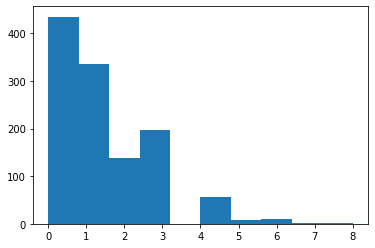

In [41]:
plt.hist(df_clean['label_cnt'])

In [49]:
from collections import Counter
c = Counter(df_clean['label_cnt'])
sorted(c.items(),key = lambda i: i[0])

[(0.0, 435),
 (1.0, 335),
 (2.0, 138),
 (3.0, 196),
 (4.0, 56),
 (5.0, 9),
 (6.0, 10),
 (7.0, 2),
 (8.0, 1)]

In [50]:
sum(df_clean['label_cnt'])/len(df_clean['label_cnt'])

1.3113367174280879

In [51]:
for j in label_list:
    print(j, sum(df_clean[j]))

SDG1 32.0
SDG2 32.0
SDG3 320.0
SDG4 415.0
SDG5 26.0
SDG6 34.0
SDG7 23.0
SDG8 248.0
SDG9 33.0
SDG10 54.0
SDG11 64.0
SDG12 69.0
SDG13 32.0
SDG14 43.0
SDG15 53.0
SDG16 38.0
SDG17 34.0


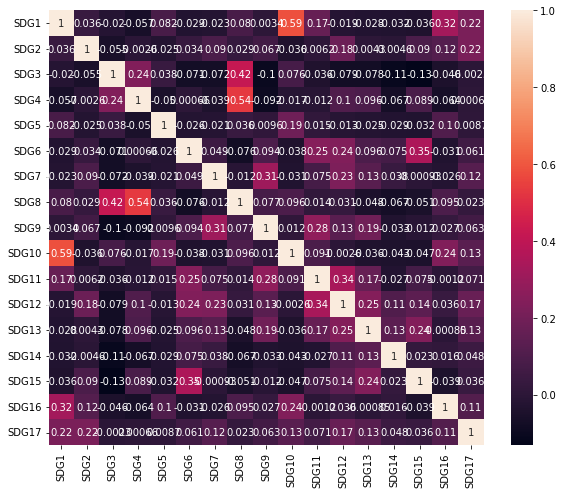

In [52]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.font_manager import fontManager
import seaborn as sns

corrmat = df_clean[label_list].corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corrmat, square=True, annot=True);

### 預測中

In [60]:
# best_val_accuracy
# best_train_index
best_val_index

array([  11,   18,   24,   28,   41,   42,   61,   73,   74,   89,  108,
        114,  132,  164,  167,  169,  173,  176,  185,  193,  214,  234,
        257,  264,  267,  272,  278,  300,  326,  338,  366,  368,  375,
        383,  393,  395,  396,  412,  416,  417,  426,  444,  454,  456,
        468,  483,  491,  495,  498,  499,  500,  516,  518,  544,  547,
        555,  568,  576,  587,  595,  601,  604,  616,  652,  665,  674,
        689,  690,  694,  700,  717,  735,  737,  743,  755,  756,  762,
        771,  789,  796,  801,  820,  839,  841,  848,  858,  859,  861,
        862,  865,  886,  890,  898,  925,  926,  942,  943,  947,  958,
        959,  978,  996, 1019, 1031, 1040, 1045, 1066, 1077, 1078, 1100,
       1105, 1106, 1109, 1131, 1136, 1137, 1151, 1158])

In [62]:
print(len(best_train_index))
print(len(best_val_index))

1064
118


In [64]:
model = Classifier()
model.load_state_dict(torch.load('./best_10fold_model.ckpt'))

<All keys matched successfully>

In [65]:
def evaluate(model):
    model.eval()

    test_set = SDG_Dataset(val_df, val_embedding, label_list)

    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

    model = model.to(device)

    accuracy_list = []
    precision_list = []
    recall_list = []
    topk_recall_list = []
    
    y_pred_list = []
    y_true_list = []
    
    with torch.no_grad():

        for test_embeddings, test_labels in test_loader:
            
            test_embeddings = test_embeddings.to(device)
            test_labels = test_labels.to(device)
            
            output = model(test_embeddings).cpu()

            pred = (output > 0).cpu()
            y_true = (test_labels > 0).cpu()
            
            # 計算評估指標
            accuracy, precision, recall, topk_recall = score(y_true, pred, output, k=5)
            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}")
            print(f"Top-5 Recall: {topk_recall}")
            accuracy_list.append(accuracy)
            precision_list.append(precision)
            recall_list.append(recall)
            topk_recall_list.append(topk_recall)

            # 印出猜測的結果對應
            y_pred = list(label_list[pred[0]])
            y_true = list(label_list[y_true[0]])
            y_pred_list.append(y_pred)
            y_true_list.append(y_true)
            # if not MLB.classes_[y_true[0]].any():
            print(f"預測: {y_pred}")
            print(f"正解: {y_true}")
            print("="*30)

    accuracy_res = np.array(accuracy_list).mean()
    precision_res = np.array(precision_list).mean()
    recall_res = np.array(recall_list).mean()
    topk_recall_res = np.array(topk_recall_list).mean()
    
    return accuracy_res, precision_res, recall_res, topk_recall_res, y_pred_list, y_true_list

In [66]:
train_df, val_df = df_clean.iloc[best_train_index, :], df_clean.iloc[best_val_index, :]
train_embedding, val_embedding = embedding_tensor[best_train_index, :], embedding_tensor[best_val_index, :]
    
accuracy_res, precision_res, recall_res, topk_recall_res, y_pred_list, y_true_list = evaluate(model)
f1_res = f1(precision_res, recall_res)

Accuracy: 0.0
Precision: 1.0
Recall: 0.6666666865348816
Top-5 Recall: 1.0
預測: ['SDG3', 'SDG4']
正解: ['SDG3', 'SDG4', 'SDG8']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['SDG4', 'SDG8']
正解: ['SDG4']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['SDG4', 'SDG8']
正解: ['SDG3', 'SDG12']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: []
正解: ['SDG8']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['SDG3']
正解: []
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: []
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['SDG4', 'SDG8']
正解: []
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: []
正解: [

In [67]:
# 計算各類別的 TP, FP, TN, FN
# ori_labels_col  = ['SDG' + str(i) for i in range(1, 18)]
detail_res_dict = {c: {x: 0 for x in ["TP", "TN", "FP", "FN", 'P']} for c in label_list}

In [68]:
for pred_, true_ in zip(y_pred_list, y_true_list):
    for guess in pred_:
        if guess in true_:
            detail_res_dict[guess]["TP"] += 1
        else:
            detail_res_dict[guess]["FP"] += 1
    for label in true_:
        if label not in pred_:
            detail_res_dict[label]["FN"] += 1
    others = set(label_list) - (set(pred_) | set(true_))
    for each in others:
        detail_res_dict[each]["TN"] += 1

In [69]:
# 建立 Data Frame
detail_res_df = pd.DataFrame(detail_res_dict).T
detail_res_df["Recall"] = round(detail_res_df["TP"] / (detail_res_df["TP"] + detail_res_df["FN"]), 2)
detail_res_df["Precision"] = round(detail_res_df["TP"] / (detail_res_df["TP"] + detail_res_df["FP"]), 2)
detail_res_df["P"] = detail_res_df["TP"] + detail_res_df["FN"]
detail_res_df["all"] = detail_res_df["TP"] + detail_res_df["TN"] + detail_res_df["FP"] + detail_res_df["FN"]
detail_res_df

,TP,TN,FP,FN,P,Recall,Precision,all
SDG1,1,116,1,0,1,1.00,0.50,118
SDG2,3,113,1,1,4,0.75,0.75,118
SDG3,30,82,3,3,33,0.91,0.91,118
SDG4,33,68,6,11,44,0.75,0.85,118
SDG5,1,117,0,0,1,1.00,1.00,118
SDG6,0,116,1,1,1,0.00,0.00,118
SDG7,1,114,2,1,2,0.50,0.33,118
SDG8,19,86,5,8,27,0.70,0.79,118
SDG9,1,113,2,2,3,0.33,0.33,118
SDG10,4,111,1,2,6,0.67,0.80,118


In [80]:
y_true_list_cnt = [len(i) for i in y_true_list]
y_pred_list_cnt = [len(i) for i in y_pred_list]

In [88]:
sum(y_true_list_cnt)/len(y_true_list_cnt)

1.3559322033898304

In [89]:
sum(y_pred_list_cnt)/len(y_pred_list_cnt)

1.2033898305084745

In [84]:
a = Counter(y_true_list_cnt)
a = sorted(a.items(),key = lambda i: i[0])
a

[(0, 42), (1, 37), (2, 11), (3, 18), (4, 6), (5, 2), (6, 1), (7, 1)]

In [86]:
b = Counter(y_pred_list_cnt)
b = sorted(b.items(),key = lambda i: i[0])
b

[(0, 50), (1, 30), (2, 14), (3, 16), (4, 4), (5, 4)]